In [1]:
import pickle
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits import mplot3d
import pandas as pd
import pandasql as ps
import numpy as np
import scipy.io
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import shap
from xgboost import XGBRegressor, plot_importance, plot_tree
from table_evaluator import TableEvaluator
import os



from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    KFold, 
    StratifiedKFold, 
    GridSearchCV
)
from sklearn.ensemble import (
    RandomForestClassifier, 
    RandomForestRegressor, 
    VotingClassifier, 
    VotingRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score,  
    f1_score, 
    precision_score, 
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    ConfusionMatrixDisplay
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import (
    load_model,
    Sequential
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Dense, 
    LeakyReLU, 
    Input
)   
from tensorflow.keras.optimizers import Adam


from ctgan import CTGAN
from sdv.single_table import (
    CTGANSynthesizer,
    TVAESynthesizer
)
from sdv.metadata import SingleTableMetadata
from sdmetrics.reports.single_table import QualityReport
from sdv.evaluation.single_table import (
    run_diagnostic, 
    evaluate_quality,
    get_column_plot
)
from sdmetrics.single_table import NewRowSynthesis
from sdv.sampling import Condition



from ML_Packages.Conversion_Packages import *
from ML_Packages.Model import *
from ML_Packages.Plotting import *
from ML_Packages.Preprocessing import *

# <font color=33FFF9>**Introduction to Booklet**</font>

<h3 style="font-family:Georgia;"> Introduction</h3>
<p> This documentation is for my thesis project on aircraft design and analysis. This document serves as a comprehensive repository of all the information, work, code, and notes accumulated throughout the course of my research.</p>

<h3 style="font-family:Georgia;"> Purpose</h3>
Within this documentation, you will discover the following key components:

<ul>
    <li><strong>Research Objectives:</strong> Clearly defined goals and objectives guiding the research project.</li>
    <li><strong>Literature Review:</strong> A comprehensive summary of key findings from relevant literature and research in the field of aircraft design and analysis.</li>
    <li><strong>Data Sources:</strong> Documentation of the sources of data utilized, whether obtained from publicly available datasets, industry reports, or proprietary sources.</li>
    <li><strong>Model Development:</strong> Detailed explanation of the development and implementation of any machine learning models or algorithms used in the research, including parameter tuning and validation techniques.</li>
    <li><strong>Results and Analysis:</strong> Presentation of the findings and analysis, including insights or trends discovered from the data.</li>
    <li><strong>References:</strong> A comprehensive list of references cited throughout the documentation, following a consistent citation style.</li>
    <li><strong>Important Notes:</strong> Insights into the rationale behind specific decisions made during the research process and any noteworthy considerations.</li>
</ul>

<h3 style="font-family:Georgia;"> Color Coding</h3>
<ul>
<li style="color: #33FFF9;"><strong>Title:</strong> #33FFF9</li>
<li style="color: #CE33FF;"><strong>Parameters Section:</strong> #CE33FF</li>
<li style="color: #F4AC12;"><strong>Subsections:</strong> #F4AC12</li>
<li style="color: #12F4B3;"><strong>Subsubsections:</strong> #12F4B3</li>
<li style="color: #F4128A;"><strong>Model Architecture:</strong> #F4128A</li>
<li style="color: #FF5533;"><strong>Important Notes:</strong> #FF5533</li>
<li style="color: #374DC8;"><strong>Parameter Name:</strong> #374DC8</li>
<li style="color: #44C837;"><strong>Next Steps:</strong> #44C837</li>
<li style="color: #C837A0;"><strong>Explanation:</strong> #C837A0</li>
</ul>

# <font color=33FFF9>**Important Website & Links**</font>

<ul>
    <li> The following link contains really good notes regarding aircraft design: <a href="https://www.fzt.haw-hamburg.de/pers/Scholz/HOOU/"> HAW-Hamburg Aircraft Design</a> </li>
    <li> For detail lectures regarding aircraft design, you can also check the following courses offered by Luftfahrzeugbau und Leichtbau at TU Berlin: <strong> Flugzeugentwurf I </strong> & <strong> Flugzeugentwurf II </strong> </li>
</ul>

# <font color=33FFF9>**Theory - Introduction to Aircraft Design**</font>

## <font style="color: #F4AC12;"> <strong>Airplane Parts & Functions </strong></font>

The diagram below shows the Airplane parts <a href="https://www1.grc.nasa.gov/beginners-guide-to-aeronautics/airplane-parts-function/"> [3]</a><br>
<p align="center">
  <img src="images/Airplane_Parts.png" alt="Airplane Parts" width="500"/>
</p>

## <font style="color: #F4AC12;"> <strong>Requirements, Parameters, Constraints and Objectives  </strong></font>

All the notes below are taken from the following link: <a href="https://www1.grc.nasa.gov/beginners-guide-to-aeronautics/airplane-parts-function/"> HAW-Hamburg Aircraft Design - Introduction Lecture</a><br>

<p>
The following requirements, at least, should be met when aircraft design begins: 
<ul>
    <li> Payload</li>
    <li> Range</li>
    <li> Mach Number</li>
</ul>

The key design parameters are: 
<ul>
    <li> Take-off mass</li>
    <li> Fuel mass</li>
    <li> Operating empty mass</li>
    <li> Wing area</li>
    <li> Take-off thrust</li>
    </ul>

In principle, the aim of aircraft design is to create something new through synthesis. This contrasts with the analysis of the aircraft by a large number of specialized disciplines in aircraft construction. Flight mechanics, as an example of one of the disciplines, focuses on aircraft geometry and uses this to determine flight performance and flight characteristics. 

</p>



## <font style="color: #F4AC12;"> <strong>Aircraft Design Sequence </strong></font>


All the notes below are taken from the following link: <a href="https://www.fzt.haw-hamburg.de/pers/Scholz/HOOU/AircraftDesign_2_DesignSequenz.pdf"> HAW-Hamburg Aircraft Design - Aircraft Design Sequence</a><br>

Really good notes regarding the sequence of aircraft design. We will later use the sequence provided here to train our ML models one by one until we had to train the model for "Range" & other "Flight Mechanics" parameters.

# <font color=33FFF9>**Standard Units In Aviation**</font>
<p> The standard SI Units are taken from the following link: <a href=https://en.wikipedia.org/wiki/International_Civil_Aviation_Organization">Civil Aviation SI Units</a>

<table style="width:100%">
  <tr>
    <th>Parameter</th>
    <th>Unit</th>
  </tr>
  <tr>
    <td>Speed</td>
    <td>km/h</td>
  </tr>
  <tr>
    <td>Distance</td>
    <td>km</td>
  </tr>
  <tr>
    <td>Altitude</td>
    <td>meters</td>
  </tr>
  <tr>
    <td>Weight</td>
    <td>kg</td>
  </tr>
  <tr>
    <td>Fuel Capacity	</td>
    <td>Liters (L)</td>
  </tr>
  <tr>
    <td>Fuel Weight	</td>
    <td>kg</td>
  </tr>
  <tr>
    <td>Thrust</td>
    <td>Newtons (N)</td>
  </tr>
  <tr>
    <td>Temperature</td>
    <td>Celsius (°C)</td>
  </tr>
  <tr>
    <td>Acceleration</td>
    <td>Meters per second squared (m/s²)</td>
  </tr>
  <tr>
    <td>Force</td>
    <td>Newtons (N)</td>
  </tr>
  <tr>
    <td>Density</td>
    <td>Kilograms per cubic meter (kg/m³)</td>
  </tr>
  <tr>
    <td>Length</td>
    <td>meters</td>
  </tr>
  <tr>
    <td>Width</td>
    <td>meters</td>
  </tr>
  <tr>
    <td>Wing Span</td>
    <td>meters</td>
  </tr>
  <tr>
    <td>Thrust/Shaft Power</td>
    <td>Newtons (N)</td>
  </tr>
  <tr>
    <td>Wing Loading</td>
    <td>N/m²</td>
  </tr>
  <tr>
    <td>Tail Loading</td>
    <td>N/m²</td>
  </tr>
  <tr>
    <td>Rate of Climb (ROC)</td>
    <td>m/s</td>
  </tr>
  <tr>
    <td>Fuselage Length</td>
    <td>meters</td>
  </tr>
  </tr>
</table>



# <font color=33FFF9>**The 50 Most Important Parameters of the 60 Most Used Passenger Aircraft**</font>

<p> The dataset is taken from the following link: <a href="https://www.fzt.haw-hamburg.de/pers/Scholz/arbeiten/TextHirsch.pdf">The 50 Most Important Parameters of the 60 Most Used Passenger Aircraft</a>

Request to use the dataset has been granted. 

## <font style="color: #CE33FF;"> Parameters: </font>


<ul>
    <li><strong><span style="color: #374DC8;">Manufacturer:</span></strong> The company that manufactures the aircraft.</li>
    <li><strong><span style="color: #374DC8;">Aircraft type:</span></strong> The specific type or model designation of the aircraft.</li>
    <li><strong><span style="color: #374DC8;">Total number of operating A/C:</span></strong> The total number of aircraft of this type currently in operation.</li>
    <li><strong><span style="color: #374DC8;">Option/Variant:</span></strong> Any optional configurations or variants of the aircraft model.</li>
    <li><strong><span style="color: #374DC8;">Engine:</span></strong> The type or model of engine(s) used in the aircraft.</li>
    <li><strong><span style="color: #374DC8;">No. of Engines:</span></strong> The total number of engines installed on the aircraft.</li>
    <li><strong><span style="color: #374DC8;">Model:</span></strong> The specific model name or designation of the aircraft.</li>
    <li><strong><span style="color: #374DC8;">Max. Rated Takeoff Thrust (T_TO):</span></strong> The maximum rated thrust produced by the engines during takeoff, typically measured in kilonewtons (kN).</li>
    <li><strong><span style="color: #374DC8;">Equivalent Power (P):</span></strong> The equivalent power of the engines, typically measured in kilowatts (kW).</li>
    <li><strong><span style="color: #374DC8;">Propeller:</span></strong> Information about the propeller(s) used in the aircraft.</li>
    <li><strong><span style="color: #374DC8;">Cabin Length (l_CABIN):</span></strong> The length of the cabin, which is the passenger compartment of the aircraft, typically measured in meters (m).</li>
    <li><strong><span style="color: #374DC8;">Max. Height of Cabin (h_CABIN):</span></strong> The maximum height of the cabin, typically measured in meters (m).</li>
    <li><strong><span style="color: #374DC8;">Max. Width of Cabin (d_F,I):</span></strong> The maximum width of the cabin, typically measured in meters (m).</li>
    <li><strong><span style="color: #374DC8;">Passenger Compartment Volume (V_CABIN):</span></strong> The volume of the passenger compartment or cabin, typically measured in cubic meters (m³).</li>
    <li><strong><span style="color: #374DC8;">Fuselage Height (h_F):</span></strong> The height of the fuselage, which is the main body of the aircraft, typically measured in meters (m).</li>
    <li><strong><span style="color: #374DC8;">Fuselage Width (w_F):</span></strong> The width of the fuselage, typically measured in meters (m).</li>
    <li><strong><span style="color: #374DC8;">Total Length of Aircraft (l_A/C):</span></strong> The total length of the aircraft, typically measured in meters (m).</li>
    <li><strong><span style="color: #374DC8;">Wingspan (b_W):</span></strong> The wingspan of the aircraft, which is the distance from one wingtip to the other, typically measured in meters (m).</li>
    <li><strong><span style="color: #374DC8;">Height of Aircraft (h_A/C):</span></strong> The height of the aircraft, typically measured in meters (m).</li>
    <li><strong><span style="color: #374DC8;">Landing Gear Track (l_T):</span></strong> The track width of the landing gear, typically measured in meters (m).</li>
    <li><strong><span style="color: #374DC8;">Wheelbase (l_WB):</span></strong> The wheelbase of the aircraft, typically measured in meters (m).</li>
    <li><strong><span style="color: #374DC8;">Wing Area (S_W):</span></strong> The total wing area of the aircraft, typically measured in square meters (m²).</li>
    <li><strong><span style="color: #374DC8;">Taper ratio of Wing (λ_W):</span></strong> The taper ratio of the wings, which is the ratio of the root chord to the tip chord.</li>
    <li><strong><span style="color: #374DC8;">1/4 Chord Sweep of Wing (φ_25,W):</span></strong> The 1/4 chord sweep of the wings, typically measured in degrees (°).</li>
    <li><strong><span style="color: #374DC8;">Vertical Tail Area (S_V):</span></strong> The total area of the vertical tail of the aircraft, typically measured in square meters (m²).</li>
    <li><strong><span style="color: #374DC8;">Height of Vertical Tail (b_V):</span></strong> The height of the vertical tail, typically measured in meters (m).</li>
    <li><strong><span style="color: #374DC8;">Taper ratio of Vertical Tail (λ_V):</span></strong> The taper ratio of the vertical tail.</li>
    <li><strong><span style="color: #374DC8;">1/4 Chord Sweep of Vertical Tail (φ_25,V):</span></strong> The 1/4 chord sweep of the vertical tail, typically measured in degrees (°).</li>
    <li><strong><span style="color: #374DC8;">Horizontal Tail Area (S_H):</span></strong> The total area of the horizontal tail of the aircraft, typically measured in square meters (m²).</li>
    <li><strong><span style="color: #374DC8;">Span of Horizontal Tail (b_H):</span></strong> The span of the horizontal tail, typically measured in meters (m).</li>
    <li><strong><span style="color: #374DC8;">Taper Ratio of Horizontal Tail (λ_H):</span></strong> The taper ratio of the horizontal tail.</li>
    <li><strong><span style="color: #374DC8;">1/4 Chord Sweep of Horizontal Tail (φ_25,H):</span></strong> The 1/4 chord sweep of the horizontal tail, typically measured in degrees (°).</li>
    <li><strong><span style="color: #374DC8;">Cruise V_MO (kt):</span></strong> The cruise speed limit in knots (kt).</li>
    <li><strong><span style="color: #374DC8;">Cruise M_MO (Mach):</span></strong> The cruise speed limit in Mach.</li>
    <li><strong><span style="color: #374DC8;">Cruise Speed (M_CR):</span></strong> The cruise speed of the aircraft, typically measured in Mach.</li>
    <li><strong><span style="color: #374DC8;">Max. Certified Flight Level (h_MCR):</span></strong> The maximum certified flight level, typically measured in flight levels (FL).</li>
    <li><strong><span style="color: #374DC8;">Cruise Altitude (h_CR):</span></strong> The cruise altitude of the aircraft, typically measured in flight levels (FL).</li>
    <li><strong><span style="color: #374DC8;">Fuel Unusable Fuel (l):</span></strong> The amount of fuel considered unusable, typically measured in liters (l).</li>
    <li><strong><span style="color: #374DC8;">Optional Fuel (l):</span></strong> The amount of optional fuel that can be carried, typically measured in liters (l).</li>
    <li><strong><span style="color: #374DC8;">Max usable fuel (l):</span></strong> The maximum usable fuel capacity, typically measured in liters (l).</li>
    <li><strong><span style="color: #374DC8;">Range Max. Payload (R_MPL) (nm):</span></strong> The maximum range with maximum payload, typically measured in nautical miles (nm).</li>
    <li><strong><span style="color: #374DC8;">Max. Pax (R_M.pax) (nm):</span></strong> The maximum range with maximum passengers, typically measured in nautical miles (nm).</li>
    <li><strong><span style="color: #374DC8;">Max. Range (R_PLMR) (nm):</span></strong> The maximum range of the aircraft, typically measured in nautical miles (nm).</li>
    <li><strong><span style="color: #374DC8;">Mass: Max. Ramp (m_MR) (MRM) (kg):</span></strong> The maximum ramp weight of the aircraft, typically measured in kilograms (kg).</li>
    <li><strong><span style="color: #374DC8;">Mass: Max. Take-Off (m_MTO) (MTOM) (kg):</span></strong> The maximum take-off weight of the aircraft, typically measured in kilograms (kg).</li>
    <li><strong><span style="color: #374DC8;">Mass: Max. Landing (m_ML) (MLM) (kg):</span></strong> The maximum landing weight of the aircraft, typically measured in kilograms (kg).</li>
    <li><strong><span style="color: #374DC8;">Mass: Max. Zero Fuel (m_MZF) (MZFM) (kg):</span></strong> The maximum zero fuel weight of the aircraft, typically measured in kilograms (kg).</li>
    <li><strong><span style="color: #374DC8;">Mass: Operating Empty (m_OE) (OEM) (MZFM-MPL) (kg):</span></strong> The operating empty weight of the aircraft, typically measured in kilograms (kg).</li>
    <li><strong><span style="color: #374DC8;">Mass: Max. Payload (m_MPL) (MPL) (kg):</span></strong> The maximum payload capacity of the aircraft, typically measured in kilograms (kg).</li>
    <li><strong><span style="color: #374DC8;">Mass: Payload at Max. Range (m_PLMR) (kg):</span></strong> The payload capacity at maximum range, typically measured in kilograms (kg).</li>
    <li><strong><span style="color: #374DC8;">Cargo Volume (V_CARGO) (m³):</span></strong> The volume of cargo space available, typically measured in cubic meters (m³).</li>
    <li><strong><span style="color: #374DC8;">Cargo Capacity:</span></strong> Information about the cargo capacity of the aircraft.</li>
    <li><strong><span style="color: #374DC8;">Max Pallet Underfloor:</span></strong> Maximum pallet capacity under the floor of the aircraft.</li>
    <li><strong><span style="color: #374DC8;">Seats Max:</span></strong> Maximum number of seats available in the aircraft.</li>
    <li><strong><span style="color: #374DC8;">Std. Layout:</span></strong> Information about the standard layout of seats in the aircraft.</li>
</ul>


### <font style="color: #CE33FF;"> Aerodynamics: </font>

<ul>
    <li><strong>Wingspan (b_W):</strong> Main parameter. Used to calculate wing aspect ratio and lift distribution.</li>
    <li><strong>Wing Area (S_W):</strong> Main parameter. Used to calculate wing loading and lift coefficient.
        <ul>
            <li><strong>Taper ratio of Wing (λ_W):</strong> Sub-parameter. Affects lift distribution and aerodynamic efficiency.</li>
            <li><strong>1/4 Chord Sweep of Wing (φ_25,W):</strong> Sub-parameter. Affects aerodynamic performance and stability.</li>
        </ul>
    </li>
    <li><strong>Vertical Tail Area (S_V):</strong> Main parameter. Used to calculate tail volume coefficient and stability.
        <ul>
            <li><strong>Taper ratio of Vertical Tail (λ_V):</strong> Sub-parameter. Affects tail effectiveness and stability.</li>
            <li><strong>1/4 Chord Sweep of Vertical Tail (φ_25,V):</strong> Sub-parameter. Affects tail performance and stability.</li>
        </ul>
    </li>
    <li><strong>Horizontal Tail Area (S_H):</strong> Main parameter. Used to calculate tail volume coefficient and stability.
        <ul>
            <li><strong>Taper Ratio of Horizontal Tail (λ_H):</strong> Sub-parameter. Affects tail effectiveness and stability.</li>
            <li><strong>1/4 Chord Sweep of Horizontal Tail (φ_25,H):</strong> Sub-parameter. Affects tail performance and stability.</li>
        </ul>
    </li>
</ul>


### <font style="color: #CE33FF;"> Flight Mechanics: </font>
<ul>
    <li><strong>Max. Rated Takeoff Thrust (T_TO):</strong> Main parameter. Used for thrust-to-weight ratio and takeoff performance.</li>
    <li><strong>Equivalent Power (P):</strong> Main parameter. Used for power loading and climb performance.</li>
    <li><strong>Max. Certified Flight Level (h_MCR):</strong> Main parameter. Defines maximum flight altitude.</li>
    <li><strong>Cruise Speed (M_CR):</strong> Main parameter. Defines cruising speed.</li>
    <li><strong>Cruise Altitude (h_CR):</strong> Main parameter. Defines cruising altitude.</li>
    <li><strong>Mass: Max. Take-Off (m_MTO) (MTOM) (kg):</strong> Main parameter. Defines maximum takeoff weight.</li>
    <li><strong>Mass: Max. Landing (m_ML) (MLM) (kg):</strong> Main parameter. Defines maximum landing weight.</li>
    <li><strong>Mass: Max. Zero Fuel (m_MZF) (MZFM) (kg):</strong> Main parameter. Defines maximum zero fuel weight.</li>
    <li><strong>Mass: Operating Empty (m_OE) (OEM) (MZFM-MPL) (kg):</strong> Main parameter. Defines operating empty weight.</li>
    <li><strong>Mass: Max. Payload (m_MPL) (MPL) (kg):</strong> Main parameter. Defines maximum payload weight.</li>
    <li><strong>Range Max. Payload (R_MPL) (nm):</strong> Main parameter. Defines maximum range with payload.</li>
</ul>

### <font style="color: #CE33FF;"> Other Parameters: </font>
<ul>
    <li><strong>Manufacturer:</strong> Identification parameter.</li>
    <li><strong>Aircraft type:</strong> Identification parameter.</li>
    <li><strong>Total number of operating A/C:</strong> Operational parameter.</li>
    <li><strong>Option/Variant:</strong> Configuration parameter.</li>
    <li><strong>Engine:</strong> Identification parameter.</li>
    <li><strong>No. of Engines:</strong> Configuration parameter.</li>
    <li><strong>Model:</strong> Identification parameter.</li>
    <li><strong>Propeller:</strong> Configuration parameter.</li>
    <li><strong>Cabin Length (l_CABIN):</strong> Interior parameter.</li>
    <li><strong>Max. Height of Cabin (h_CABIN):</strong> Interior parameter.</li>
    <li><strong>Max. Width of Cabin (d_F,I):</strong> Interior parameter.</li>
    <li><strong>Passenger Compartment Volume (V_CABIN):</strong> Interior parameter.</li>
    <li><strong>Fuselage Height (h_F):</strong> Exterior parameter.</li>
    <li><strong>Fuselage Width (w_F):</strong> Exterior parameter.</li>
    <li><strong>Total Length of Aircraft (l_A/C):</strong> Exterior parameter.</li>
    <li><strong>Landing Gear Track (l_T):</strong> Landing gear parameter.</li>
    <li><strong>Wheelbase (l_WB):</strong> Landing gear parameter.</li>
    <li><strong>Fuel Unusable Fuel (l):</strong> Fuel parameter.</li>
    <li><strong>Optional Fuel (l):</strong> Fuel parameter.</li>
    <li><strong>Max usable fuel (l):</strong> Fuel parameter.</li>
    <li><strong>Max. Pax (R_M.pax) (nm):</strong> Passenger parameter.</li>
    <li><strong>Max. Range (R_PLMR) (nm):</strong> Range parameter.</li>
    <li><strong>Mass: Max. Ramp (m_MR) (MRM) (kg):</strong> Mass parameter.</li>
    <li><strong>Mass: Payload at Max. Range (m_PLMR) (kg):</strong> Mass parameter.</li>
    <li><strong>Cargo Volume (V_CARGO) (m³):</strong> Cargo parameter.</li>
    <li><strong>Cargo Capacity:</strong> Cargo parameter.</li>
    <li><strong>Max Pallet Underfloor:</strong> Cargo parameter.</li>
    <li><strong>Seats Max:</strong> Passenger parameter.</li>
    <li><strong>Std. Layout:</strong> Passenger parameter.</li>
</ul>


## <font style="color: #F4AC12;"> <strong>Data Cleanup </strong></font>

In [365]:
para_for_60_aircrafts = pd.read_excel('Datasets/The 50 Most Important Parameters of the 60 Most Used Passenger Aircraft_Dataset/Aircraft_Database.xlsx')
para_for_60_aircrafts = para_for_60_aircrafts.drop(['A/C'], axis=1)
para_for_60_aircrafts.drop(para_for_60_aircrafts.tail(3).index, inplace = True)
para_for_60_aircrafts.columns = para_for_60_aircrafts.iloc[0]
para_for_60_aircrafts = para_for_60_aircrafts[1:]
para_for_60_aircrafts

0                                 Aircraft type A220-300    A319ceo  \
1                 Total number of operating A/C       72       1243   
2                                Option/Variant        -          -   
3                                No. of Engines        2          2   
4                                         Model  PW1521G  CFM56-5A5   
5          Max. Rated Takeoff Thrust, T_TO [kN]    97.73     104.53   
6                      Equivalent Power, P [kW]        -          -   
7                                     Propeller        -          -   
8                           Length, l_CABIN [m]     27.5      23.78   
9                      Max. Height, h_CABIN [m]     2.13       2.25   
10                        Max. Width, d_F,I [m]     3.28        3.7   
11   Passenger Compartment Volume, V_CABIN [m³]      NaN        120   
12                              Height, h_F [m]     3.72       4.14   
13                               Width, w_F [m]     3.51       3.95   
14                            Length, l_A/C [m]     38.7      33.84   
15                                Span, b_W [m]     35.1       35.8   
16                            Height, h_A/C [m]     11.5      11.76   
17                               Track, l_T [m]     6.73       7.59   
18                          Wheelbase, l_WB [m]    15.31      11.04   
19                               Area, S_W [m²]    112.3        NaN   
20                             Taper ratio, λ_W     0.26       0.25   
21                  1/4 Chord Sweep, φ_25,W [°]       26       23.5   
22                               Area, S_V [m²]     28.2        NaN   
23                              Height, b_V [m]        6       5.87   
24                             Taper ratio, λ_V     0.35       0.33   
25                  1/4 Chord Sweep, φ_25,V [°]     35.5         35   
26                               Area, S_H [m²]     36.6        NaN   
27                                Span, b_H [m]    12.26      12.45   
28                             Taper Ratio, λ_H    0.375      0.375   
29                  1/4 Chord Sweep, φ_25,H [°]     30.5         28   
30                                    V_MO [kt]      489        488   
31                                  M_MO [Mach]     0.82       0.82   
32                    Cruise Speed, M_CR [Mach]      NaN        NaN   
33      Max. Certified Flight Level, h_MCR [FL]      410        410   
34                   Cruise Altitude, h_CR [FL]      NaN        NaN   
35                            Unusable Fuel [l]      125         82   
36                            Optional Fuel [l]        -       8250   
37                          Max usable fuel [l]    21381      15609   
38                     Max. Payload, R_MPL [nm]     2000       2500   
39                       Max. Pax, R_M,pax [nm]     3100       3000   
40                      Max. Range, R_PLMR [nm]     3350       3950   
41                   Max. Ramp, m_MR (MRM) [kg]    71300      75900   
42             Max. Take-Off, m_MTO (MTOM) [kg]    70900      75500   
43                Max. Landing, m_ML (MLM) [kg]    58800      62500   
44            Max. Zero Fuel, m_MZF (MZFM) [kg]    55800      58500   
45  Operating Empty, m_OE (OEM) (MZFM-MPL) [kg]    43500      35400   
46               Max. Payload, m_MPL (MPL) [kg]    12300      23100   
47           Payload at Max. Range, m_PLMR [kg]     6350       9800   
48                         Volume, V_CARGO [m³]    27.46      27.66   
49                               Cargo Capacity        -      4 ULD   
50                       Max. Pallet Underfloor        -          -   
51                         Max. Seats, n_M,SEAT      149        160   
52                          Std. Layout, n_SEAT      140        156   

0     A319neo    A320ceo    A320neo      A321ceo      A321neo    A330-200  \
1           0       4132       1009         1591          355         502   
2           -          -          -            -            -    A330-203   
3    

In [366]:
para_for_60_aircrafts = para_for_60_aircrafts.transpose()
para_for_60_aircrafts.columns = para_for_60_aircrafts.iloc[0]
para_for_60_aircrafts = para_for_60_aircrafts[1:]
para_for_60_aircrafts.reset_index(inplace=True)
para_for_60_aircrafts.columns.values[0] = 'Aircraft_Type'
para_for_60_aircrafts

Aircraft type    Aircraft_Type Total number of operating A/C Option/Variant  \
0                     A220-300                            72              -   
1                      A319ceo                          1243              -   
2                      A319neo                             0              -   
3                      A320ceo                          4132              -   
4                      A320neo                          1009              -   
5                      A321ceo                          1591              -   
6                      A321neo                           355              -   
7                     A330-200                           502       A330-203   
8                     A330-300                           707       A330-303   
9                     A330-900                            47       A330-941   
10                    A350-900                           321       A350-941   
11                   A350-1000                            43      A350-1041   
12                        A380                           237       A380-800   
13                       AN-24                            97             RV   
14                      ATR 42                           208    42-500/-600   
15                      ATR 72                           795   72-212A/-600   
16             Jetstream 31/32                           101             32   
17                          99                           107            C99   
18                       1900C                           121              -   
19                       1900D                           220              -   
20                     717-200                           145            HGW   
21                     737-300                           214              -   
22                     737-400                           141              -   
23                     737-500                           161              -   
24                     737-700                           979              -   
25                     737-800                          4788              -   
26                     737-900                          556*              -   
27                   737-900ER                          556*              -   
28                       737-8                           347              -   
29                     757-200                           302              -   
30                       MD-80                          232*      MD-82/-88   
31                       MD-80                          232*          MD-87   
32                     747-400                          123*        747-400   
33                     747-400                          123*      747-400ER   
34                     767-300                          365*        767-300   
35                     767-300                          365*      767-300ER   
36                     777-200                          391*        777-200   
37                     777-200                          391*      777-200ER   
38                   777-300ER                           805              -   
39                       787-8                           363              -   
40                       787-9                           540              -   
41                      787-10                            58              -   
42                      CRJ200                           601             LR   
43                      CRJ700                           291             ER   
44                      CRJ900                           471     CL-6002D24   
45                 Dash 8 Q100                           152      DHC-8-106   
46                 Dash 8 Q300                           157      DHC-8-301   
47                 Dash 8 Q400                           462      DHC-8-402   
48                     EMB 120                           127             ER   
49                      EMB145                    

In [367]:
# Create a dictionary to map the old column names to the new ones with dashes instead of spaces

column_mapping = {
    'Total number of operating A/C': 'Operating_Aircraft_Count',
    'Option/Variant': 'Option_Variant',
    'No. of Engines': 'Total_Engines',
    'Model': 'Engine_Model',
    'Max. Rated Takeoff Thrust, T_TO [kN]': 'Max_Takeoff_Thrust',
    'Equivalent Power, P [kW]': 'Equivalent_Power',
    'Propeller': 'Propeller_Type',
    'Length, l_CABIN [m]': 'Cabin_Length',
    'Max. Height, h_CABIN [m]': 'Max_Cabin_Height',
    'Max. Width, d_F,I [m]': 'Max_Cabin_Width',
    'Passenger Compartment Volume, V_CABIN [m³]': 'Passenger_Compartment_Volume',
    'Height, h_F [m]': 'Fuselage_Height',
    'Width, w_F [m]': 'Fuselage_Width',
    'Length, l_A/C [m]': 'Aircraft_Length',
    'Span, b_W [m]': 'Wing_Span',
    'Height, h_A/C [m]': 'Aircraft_Height',
    'Track, l_T [m]': 'Wheel_Track',
    'Wheelbase, l_WB [m]': 'Wheelbase',
    'Area, S_W [m²]': 'Wing_Area',
    'Taper ratio, λ_W': 'Wing_Taper_Ratio',
    '1/4 Chord Sweep, φ_25,W [°]': '1/4_Wing_Sweep',
    'Area, S_V [m²]': 'Area_S_V_[m²]',
    'Height, b_V [m]': 'Height_b_V_[m]',
    'Taper ratio, λ_V': 'Taper_ratio_λ_V',
    '1/4 Chord Sweep, φ_25,V [°]': '1/4_Chord_Sweep_φ_25,V_[°]',
    'Area, S_H [m²]': 'Area_S_H',
    'Span, b_H [m]': 'Span_b_H',
    'Taper Ratio, λ_H': 'Taper_Ratio_λ_H',
    '1/4 Chord Sweep, φ_25,H [°]': '1/4_Chord_Sweep_φ_25',
    'V_MO [kt]': 'V_MO',
    'M_MO [Mach]': 'M_MO',
    'Cruise Speed, M_CR [Mach]': 'Cruise_Speed',
    'Max. Certified Flight Level, h_MCR [FL]': 'Max_Certified_Flight_Level',
    'Cruise Altitude, h_CR [FL]': 'Cruise_Altitude',
    'Unusable Fuel [l]': 'Unusable_Fuel',
    'Optional Fuel [l]': 'Optional_Fuel',
    'Max usable fuel [l]': 'Max_Usable_Fuel',
    'Max. Payload, R_MPL [nm]': 'Max_Payload',
    'Max. Pax, R_M,pax [nm]': 'Max_Pax_R_M',
    'Max. Range, R_PLMR [nm]': 'Max_Range_R_PLMR',
    'Max. Ramp, m_MR (MRM) [kg]': 'Max_Ramp_m_MR',
    'Max. Take-Off, m_MTO (MTOM) [kg]': 'Max_Take_Off_m_MTO',
    'Max. Landing, m_ML (MLM) [kg]': 'Max_Landing_m_ML',
    'Max. Zero Fuel, m_MZF (MZFM) [kg]': 'Max_Zero_Fuel',
    'Operating Empty, m_OE (OEM) (MZFM-MPL) [kg]': 'Operating_Empty_m_OE',
    'Max. Payload, m_MPL (MPL) [kg]': 'Max_Payload_m_MPL',
    'Payload at Max. Range, m_PLMR [kg]': 'Payload_at_Max_Range_m_PLMR',
    'Volume, V_CARGO [m³]': 'Volume_V_CARGO',
    'Cargo Capacity': 'Cargo_Capacity',
    'Max. Pallet Underfloor': 'Max_Pallet_Underfloor',
    'Max. Seats, n_M,SEAT': 'Max_Seats_n_M,SEAT',
    'Std. Layout, n_SEAT': 'Std_Layout_n_SEAT',

    # Add other columns as necessary
}

# Rename the columns
para_for_60_aircrafts.rename(columns=column_mapping, inplace=True)
para_for_60_aircrafts = para_for_60_aircrafts.drop(['Operating_Aircraft_Count', 'Option_Variant', 'Max_Certified_Flight_Level', 'Max_Pallet_Underfloor', 
                                                    'Wheel_Track', 'Wheelbase', 'Cruise_Speed', 'Unusable_Fuel', 'Optional_Fuel', 'Max_Ramp_m_MR', 'Max_Ramp_m_MR', 'Equivalent_Power', 
                                                    'Cargo_Capacity', 'Propeller_Type'], axis=1) # Also removed Cargo_Capacity and Propeller_Type because of very few values available
pd.set_option('display.max_columns', None)

para_for_60_aircrafts



Aircraft type    Aircraft_Type Total_Engines    Engine_Model  \
0                     A220-300             2         PW1521G   
1                      A319ceo             2       CFM56-5A5   
2                      A319neo             2       LEAP-1A26   
3                      A320ceo             2       CFM56-5B4   
4                      A320neo             2       LEAP-1A29   
5                      A321ceo             2       CFM56-5B1   
6                      A321neo             2       LEAP-1A32   
7                     A330-200             2      CF6-80E1A3   
8                     A330-300             2      CF6-80E1A3   
9                     A330-900             2         7000-72   
10                    A350-900             2          XWB-84   
11                   A350-1000             2          XWB-97   
12                        A380             4         970B-84   
13                       AN-24             2           AI-24   
14                      ATR 42             2          PW127M   
15                      ATR 72             2        PW127M/N   
16             Jetstream 31/32             2   TPE 331-12UHR   
17                          99             2         PT6A-36   
18                       1900C             2        PT6A-65B   
19                       1900D             2        PT6A-67D   
20                     717-200             2  BR700-715C1-30   
21                     737-300             2      CFM56-3B-2   
22                     737-400             2      CFM56-3C-1   
23                     737-500             2      CFM56-3B-1   
24                     737-700             2      CFM56-7B22   
25                     737-800             2      CFM56-7B22   
26                     737-900             2      CFM56-7B22   
27                   737-900ER             2      CFM56-7B22   
28                       737-8             2       LEAP-1B28   
29                     757-200             2          PW2040   
30                       MD-80             2        JT8D-217   
31                       MD-80             2       JT8D-217C   
32                     747-400             4     CF6-80C2B1F   
33                     747-400             4     CF6-80C2B5F   
34                     767-300             2      RB211-524H   
35                     767-300             2      RB211-524H   
36                     777-200             2        GE90-94B   
37                     777-200             2        GE90-94B   
38                   777-300ER             2     GE90-115BL1   
39                       787-8             2       GEnx-1B70   
40                       787-9             2       GEnx-1B70   
41                      787-10             2       GEnx-1B76   
42                      CRJ200             2        CF34-3B1   
43                      CRJ700             2        CF34-8C1   
44                      CRJ900             2        CF34-8C5   
45                 Dash 8 Q100             2           PW121   
46                 Dash 8 Q300             2           PW123   
47                 Dash 8 Q400             2          PW150A   
48                     EMB 120             2           PW118   
49                      EMB145             2     AE3007 A1/1   
50                      EMB145             2       AE3007 A1   
51                      EMB145             2      AE3007 A1E   
52                         170             2        CF34-8E5   
53                         175             2        CF34-8E5   
54                         190             2       CF34-10E7   
55                         195             2       CF34-10E7   
56                      Merlin             2     331-3U-303G   
57                       Metro             2    331-3UW-303G   
58                   Fokker 50             2          PW125B   
59                  Fokker 100             2      Tay 650-15   
60                    Saab 340             2       GE CT7-9B   
61                Superjet 100  

In [368]:
change_datatype = {
                'Aircraft type': str,
                'Total_Engines': float,
                'Cabin_Length': float,
                'Max_Cabin_Height': float,
                'Max_Cabin_Width': float,
                'Passenger_Compartment_Volume': float,
                'Max_Takeoff_Thrust': float,
                'Fuselage_Height': float,
                'Fuselage_Width': float,
                'Aircraft_Length': float,
                'Wing_Span': float,
                'Aircraft_Height': float,
                'Wing_Area': float,
                'Wing_Taper_Ratio': float,
                '1/4_Wing_Sweep': float,
                'Area_S_V_[m²]': float,
                'Height_b_V_[m]': float,
                'Taper_ratio_λ_V': float,
                'Engine_Model': str,
                '1/4_Chord_Sweep_φ_25,V_[°]': float,
                'Area_S_H': float,
                'Span_b_H': float,
                'Taper_Ratio_λ_H': float,
                '1/4_Chord_Sweep_φ_25': float,
                'V_MO': float,
                'M_MO': float,
                'Cruise_Altitude': float,
                'Max_Payload': float,
                'Max_Pax_R_M': float,
                'Max_Usable_Fuel': float,
                'Max_Range_R_PLMR': float,
                'Max_Ramp_m_MR': float,
                'Max_Take_Off_m_MTO': float,
                'Max_Landing_m_ML': float,
                'Max_Zero_Fuel': float,
                'Operating_Empty_m_OE': float,
                'Max_Payload_m_MPL': float,
                'Payload_at_Max_Range_m_PLMR': float,
                'Volume_V_CARGO': float,
                'Max_Seats_n_M,SEAT': float,
                'Std_Layout_n_SEAT': float,
            }

para_for_60_aircrafts = change_col_datatypes(para_for_60_aircrafts, change_datatype)


No datatype specified for column 'Aircraft_Type', skipping conversion
Error converting column 'Max_Takeoff_Thrust' to <class 'float'>: could not convert string to float: '-'
Error converting column 'M_MO' to <class 'float'>: could not convert string to float: '-'
Columns not converted: ['Aircraft_Type']


In [369]:
para_for_60_aircrafts

Aircraft type    Aircraft_Type  Total_Engines    Engine_Model  \
0                     A220-300            2.0         PW1521G   
1                      A319ceo            2.0       CFM56-5A5   
2                      A319neo            2.0       LEAP-1A26   
3                      A320ceo            2.0       CFM56-5B4   
4                      A320neo            2.0       LEAP-1A29   
5                      A321ceo            2.0       CFM56-5B1   
6                      A321neo            2.0       LEAP-1A32   
7                     A330-200            2.0      CF6-80E1A3   
8                     A330-300            2.0      CF6-80E1A3   
9                     A330-900            2.0         7000-72   
10                    A350-900            2.0          XWB-84   
11                   A350-1000            2.0          XWB-97   
12                        A380            4.0         970B-84   
13                       AN-24            2.0           AI-24   
14                      ATR 42            2.0          PW127M   
15                      ATR 72            2.0        PW127M/N   
16             Jetstream 31/32            2.0   TPE 331-12UHR   
17                          99            2.0         PT6A-36   
18                       1900C            2.0        PT6A-65B   
19                       1900D            2.0        PT6A-67D   
20                     717-200            2.0  BR700-715C1-30   
21                     737-300            2.0      CFM56-3B-2   
22                     737-400            2.0      CFM56-3C-1   
23                     737-500            2.0      CFM56-3B-1   
24                     737-700            2.0      CFM56-7B22   
25                     737-800            2.0      CFM56-7B22   
26                     737-900            2.0      CFM56-7B22   
27                   737-900ER            2.0      CFM56-7B22   
28                       737-8            2.0       LEAP-1B28   
29                     757-200            2.0          PW2040   
30                       MD-80            2.0        JT8D-217   
31                       MD-80            2.0       JT8D-217C   
32                     747-400            4.0     CF6-80C2B1F   
33                     747-400            4.0     CF6-80C2B5F   
34                     767-300            2.0      RB211-524H   
35                     767-300            2.0      RB211-524H   
36                     777-200            2.0        GE90-94B   
37                     777-200            2.0        GE90-94B   
38                   777-300ER            2.0     GE90-115BL1   
39                       787-8            2.0       GEnx-1B70   
40                       787-9            2.0       GEnx-1B70   
41                      787-10            2.0       GEnx-1B76   
42                      CRJ200            2.0        CF34-3B1   
43                      CRJ700            2.0        CF34-8C1   
44                      CRJ900            2.0        CF34-8C5   
45                 Dash 8 Q100            2.0           PW121   
46                 Dash 8 Q300            2.0           PW123   
47                 Dash 8 Q400            2.0          PW150A   
48                     EMB 120            2.0           PW118   
49                      EMB145            2.0     AE3007 A1/1   
50                      EMB145            2.0       AE3007 A1   
51                      EMB145            2.0      AE3007 A1E   
52                         170            2.0        CF34-8E5   
53                         175            2.0        CF34-8E5   
54                         190            2.0       CF34-10E7   
55                         195            2.0       CF34-10E7   
56                      Merlin            2.0     331-3U-303G   
57                       Metro            2.0    331-3UW-303G   
58                   Fokker 50            2.0          PW125B   
59                  Fokker 100            2.0      Tay 650-15   
60                    Saab 340     

<p style="color: #C837A0;"> Some of the columns contain string values, and, as a results, we had to convert those values into Nan values in order to change the datatype of the specific column</p>

In [370]:
para_for_60_aircrafts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Aircraft_Type                 63 non-null     object 
 1   Total_Engines                 63 non-null     float64
 2   Engine_Model                  63 non-null     object 
 3   Max_Takeoff_Thrust            44 non-null     float64
 4   Cabin_Length                  34 non-null     float64
 5   Max_Cabin_Height              61 non-null     float64
 6   Max_Cabin_Width               62 non-null     float64
 7   Passenger_Compartment_Volume  20 non-null     float64
 8   Fuselage_Height               56 non-null     float64
 9   Fuselage_Width                56 non-null     float64
 10  Aircraft_Length               63 non-null     float64
 11  Wing_Span                     63 non-null     float64
 12  Aircraft_Height               63 non-null     float64
 13  Wing_Ar

<h5 style="color: #44C837;"><strong>Next step:</strong></h5>
<ul style="color: #44C837;">
    <li> Convert them into float values.(✅)</li>
    <li> Also check the way names of aircrafts given are correct(✅)</li>
    <li> Check if the values are correct (✅)</li>
    <li> Fill all the missing values of the aircraft(✅)</li>
    <li> Add extra columns required such as: engines type for each aircraft (✅) </li>
</ul>

In [371]:
pd.set_option('display.max_rows', None)
#para_for_60_aircrafts

In [372]:
# Modify values for specific aircraft types using .loc

# A319ceo
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A319ceo', 'Wing_Area'] = '122.4'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A319ceo', 'Area_S_V_[m²]'] = '31.0'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A319ceo', 'Area_S_H'] = '21.5'

# A319neo
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A319neo', 'Wing_Area'] = '122.4'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A319neo', 'Area_S_V_[m²]'] = '31.0'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A319neo', 'Area_S_H'] = '21.5'

# A320ceo
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A320ceo', 'Wing_Area'] = '122.4'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A320ceo', 'Area_S_V_[m²]'] = '31.0'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A320ceo', 'Area_S_H'] = '21.5'

# A320neo
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A320neo', 'Wing_Area'] = '122.4'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A320neo', 'Area_S_V_[m²]'] = '21.5'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A320neo', 'Area_S_H'] = '31.0'

# A321ceo
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A321ceo', 'Wing_Area'] = '122.4'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A321ceo', 'Area_S_V_[m²]'] = '21.0'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A321ceo', 'Area_S_H'] = '31.5'

# A321neo
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A321neo', 'Wing_Area'] = '122.4'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A321neo', 'Area_S_V_[m²]'] = '21.0'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A321neo', 'Area_S_H'] = '31.5'

# A330-200
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A330-200', 'Wing_Area'] = '122.4'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A330-200', 'Area_S_V_[m²]'] = '47.65'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A330-200', 'Area_S_H'] = '31.0'

# A330-300
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A330-300', 'Wing_Area'] = '361.6'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A330-300', 'Area_S_V_[m²]'] = '45.20'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A330-300', 'Area_S_H'] = '72.90'

# A330-900
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A330-900', 'Wing_Area'] = '361.6'
#para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A330-900', 'Area_S_V_[m²]'] = ''
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A330-900', 'Area_S_H'] = ''

# A350-900
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A350-900', 'Wing_Area'] = '361.6'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A350-900', 'Area_S_V_[m²]'] = '57.0'
#para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A350-900', 'Area_S_H'] = ''

# A350-1000
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A350-1000', 'Wing_Area'] = '443'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A350-1000', 'Area_S_V_[m²]'] = '51.0'
#para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'A350-1000', 'Area_S_H'] = ''


Values taken from the following links: 

<ul style="color: #C837A0;">
    <li> <a href="https://booksite.elsevier.com/9780340741528/appendices/data-a/table-1/table.htm">Civil Jet Aircraft Design</a></li>
    <li> <a href="https://www.airbus.com/sites/g/files/jlcbta136/files/2021-11/Airbus-Commercial-Aircraft-AC-A350-900-1000.pdf">Airbus A350-900</a></li>
    <li> <a href="https://doc8643.com/aircraft/AN24">AN-24</a></li>
    <li> <a href="https://www.flugzeuginfo.net/acdata_php/acdata_7572_en.php">757-200</a></li>
    <li> <a href="https://www.flugzeuginfo.net/acdata_php/acdata_md80_en.php">MD-80</a></li>
    <li> <a href="https://www.flugzeuginfo.net/acdata_php/acdata_7673_en.php">767-300</a></li>
    <li> <a href="https://www.airlines-inform.com/commercial-aircraft/boeing-787-10.html">787-10</a></li>
    <li> <a href="https://en.wikipedia.org/wiki/General_Electric_GEnx">We found 787-10 TakeOff Thrust based on engine used in it</a></li>
    <li> <a href="https://www.aircharteradvisors.com/swearingen-merlin-sa226/#:~:text=The%20Swearingen%20SA226%20was%20designed,2%2C000%20nautical%20mile%20flight%20range.">We found Maximum payload capacity of SA226 Merlin III using this link</a></li>
     <li> <a href="https://de.wikipedia.org/wiki/Fokker_100">Fokker 100</a></li>
    <li> <a href="https://airlinersnow.com/Sukhoi-Superjet/Sukhoi-Superjet.htm#:~:text=Superjet%20SSJ100%2F95%20Specifications&text=Height%3A%2010.28%20m%20(33%20ft,45%2C880%20kg%20(101%2C150%20lb).">RRJ-95 SuperJet 100 operating empty weight</a></li>
    <li> <a href="https://en.wikipedia.org/wiki/Sukhoi_Superjet_100">RRJ-95 SuperJet 100 Maximum Payload (Max_Payload_m_MPL)</a></li>
    <li> <a href="https://www.vikingair.com/twin-otter-series-400/technical-description">Specifications provided to calculate CC-138 Twin Otter
 fuselage width & fuselage height</a></li>
    <li> <a href="https://de.wikipedia.org/wiki/ATR_42">ATR 42 Range</a></li>
    <li> <a href="https://www.flugzeuginfo.net/acdata_php/acdata_1900_en.php">Beechcraft 1900 Range</a></li>
    <li> <a href="https://www.flugzeuginfo.net/acdata_php/acdata_1900_en.php">Beechcraft 1900 Range</a></li>
</ul>

<br>
<p style="color: #C837A0;"> So we had to fill values for the aircraft. For Airbus models, they have two models, one is the ceo (current enginer model) and the other one is neo (newer engine model). The difference between ceo and neo is the new enginer models. In the newer enginer, models, they're replacing IAE V2500 and CFM56-5B models with the PW1100G-JM and LEAP-1A series engines (manufactured by Pratt and Whitney and CFM International, respectively). The information is taken from the following link: <a href="https://baatraining.com/blog/differences-between-a320ceo-and-a320neo-in-a-nutshell/">Differnce between ceo and neo in a nutshell</a> 
<br><br>
We also manually filled in the values for Wing_Area, Area_S_V_[m²] (Vertical Wing Area), Area_S_H (Horizontal Wing Area). For some, for example A350-1000, we have to use the booklets and check values manually. For example we have that the "Vertical Tail Area/ Vertical Stabilzier Area", is a trapezoid; hence, we can check it's height and length and using the formula, we can calculate the Vertical Tail Area. We do it for numerous aircafts to calculate their "Vertical Tail Area" & "Horizontal Tail Area"

<br><br>
</p>

<p style="color: #44C837;"> For now we will just remove the Vertical Tail Area & Horizontal Tail Area, as these values are quite difficult to find and require too much booklet studies. We can add them or spend time with them if we need them in the future. To calcualte Mach speed, we can check the velocity and use the formula to calculate the Mach speed. Another way to show how we filled empty values


</p>

In [373]:
para_for_60_aircrafts.drop(columns=['Area_S_V_[m²]', 'Area_S_H'], inplace=True)
para_for_60_aircrafts

Aircraft type    Aircraft_Type  Total_Engines    Engine_Model  \
0                     A220-300            2.0         PW1521G   
1                      A319ceo            2.0       CFM56-5A5   
2                      A319neo            2.0       LEAP-1A26   
3                      A320ceo            2.0       CFM56-5B4   
4                      A320neo            2.0       LEAP-1A29   
5                      A321ceo            2.0       CFM56-5B1   
6                      A321neo            2.0       LEAP-1A32   
7                     A330-200            2.0      CF6-80E1A3   
8                     A330-300            2.0      CF6-80E1A3   
9                     A330-900            2.0         7000-72   
10                    A350-900            2.0          XWB-84   
11                   A350-1000            2.0          XWB-97   
12                        A380            4.0         970B-84   
13                       AN-24            2.0           AI-24   
14                      ATR 42            2.0          PW127M   
15                      ATR 72            2.0        PW127M/N   
16             Jetstream 31/32            2.0   TPE 331-12UHR   
17                          99            2.0         PT6A-36   
18                       1900C            2.0        PT6A-65B   
19                       1900D            2.0        PT6A-67D   
20                     717-200            2.0  BR700-715C1-30   
21                     737-300            2.0      CFM56-3B-2   
22                     737-400            2.0      CFM56-3C-1   
23                     737-500            2.0      CFM56-3B-1   
24                     737-700            2.0      CFM56-7B22   
25                     737-800            2.0      CFM56-7B22   
26                     737-900            2.0      CFM56-7B22   
27                   737-900ER            2.0      CFM56-7B22   
28                       737-8            2.0       LEAP-1B28   
29                     757-200            2.0          PW2040   
30                       MD-80            2.0        JT8D-217   
31                       MD-80            2.0       JT8D-217C   
32                     747-400            4.0     CF6-80C2B1F   
33                     747-400            4.0     CF6-80C2B5F   
34                     767-300            2.0      RB211-524H   
35                     767-300            2.0      RB211-524H   
36                     777-200            2.0        GE90-94B   
37                     777-200            2.0        GE90-94B   
38                   777-300ER            2.0     GE90-115BL1   
39                       787-8            2.0       GEnx-1B70   
40                       787-9            2.0       GEnx-1B70   
41                      787-10            2.0       GEnx-1B76   
42                      CRJ200            2.0        CF34-3B1   
43                      CRJ700            2.0        CF34-8C1   
44                      CRJ900            2.0        CF34-8C5   
45                 Dash 8 Q100            2.0           PW121   
46                 Dash 8 Q300            2.0           PW123   
47                 Dash 8 Q400            2.0          PW150A   
48                     EMB 120            2.0           PW118   
49                      EMB145            2.0     AE3007 A1/1   
50                      EMB145            2.0       AE3007 A1   
51                      EMB145            2.0      AE3007 A1E   
52                         170            2.0        CF34-8E5   
53                         175            2.0        CF34-8E5   
54                         190            2.0       CF34-10E7   
55                         195            2.0       CF34-10E7   
56                      Merlin            2.0     331-3U-303G   
57                       Metro            2.0    331-3UW-303G   
58                   Fokker 50            2.0          PW125B   
59                  Fokker 100            2.0      Tay 650-15   
60                    Saab 340     

In [374]:
# Updating values based on Aircraft_Type column using .loc

# AN-24
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'AN-24', 'Max_Landing_m_ML'] = '21000'

# Boeing 737 Series
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '737-300', 'Wing_Area'] = '91.04'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '737-400', 'Wing_Area'] = '91.04'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '737-500', 'Wing_Area'] = '91.04'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '737-700', 'Wing_Area'] = '124.6'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '737-800', 'Wing_Area'] = '124.6'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '737-900', 'Wing_Area'] = '124.6'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '737-900ER', 'Wing_Area'] = '124.6'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '737-8', 'Wing_Area'] = '127'

# Boeing 757 Series
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '757-200', 'Wing_Area'] = '185'

# MD-80
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'MD-80', 'Wing_Area'] = '112.3'

# Boeing 747-400
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '747-400', 'Wing_Area'] = '525'

# Boeing 767-300
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '767-300', 'Wing_Area'] = '283.3'

# Boeing 777-300ER
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '777-300ER', 'Wing_Area'] = '427.8'

# Boeing 787 Series
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '787-8', 'Wing_Area'] = '377'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '787-8', 'Max_Takeoff_Thrust'] = '255.30'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '787-9', 'Wing_Area'] = '377'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '787-9', 'Max_Takeoff_Thrust'] = '255.30'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '787-10', 'Wing_Area'] = '360.5'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == '787-10', 'Max_Takeoff_Thrust'] = '339'

# Merlin
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'Merlin', 'Max_Range_R_PLMR'] = '1938 ' # Max range in nautical miles
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'Merlin', 'Payload_at_Max_Range_m_PLMR'] = '1944.176'  # Converted pounds to kg

# Metro
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'Metro', 'Max_Takeoff_Thrust'] = ''
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'Metro', 'Fuselage_Height'] = ''
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'Metro', 'Fuselage_Width'] = ''

# Fokker 50 and 100
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'Fokker 50', 'Max_Takeoff_Thrust'] = ''
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'Fokker 100', 'Wing_Area'] = '93.50'

# Saab 340
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'Saab 340', 'Max_Takeoff_Thrust'] = '26.4 ' # Based on calculated value

# Superjet 100
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'Superjet 100', 'Wing_Area'] = '83.8'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'Superjet 100', 'Operating_Empty_m_OE'] = '25100'
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'Superjet 100', 'Max_Payload_m_MPL'] = '12245'

# Twin Otter
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'Twin Otter', 'Fuselage_Height'] = '4.44'  # Manually calculated
para_for_60_aircrafts.loc[para_for_60_aircrafts['Aircraft_Type'] == 'Twin Otter', 'Fuselage_Width'] = '1.75'


In [375]:
para_for_60_aircrafts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Aircraft_Type                 63 non-null     object 
 1   Total_Engines                 63 non-null     float64
 2   Engine_Model                  63 non-null     object 
 3   Max_Takeoff_Thrust            50 non-null     object 
 4   Cabin_Length                  34 non-null     float64
 5   Max_Cabin_Height              61 non-null     float64
 6   Max_Cabin_Width               62 non-null     float64
 7   Passenger_Compartment_Volume  20 non-null     float64
 8   Fuselage_Height               58 non-null     object 
 9   Fuselage_Width                58 non-null     object 
 10  Aircraft_Length               63 non-null     float64
 11  Wing_Span                     63 non-null     float64
 12  Aircraft_Height               63 non-null     float64
 13  Wing_Ar

In [376]:
change_datatype = {
                'Max_Takeoff_Thrust': float,
                'Fuselage_Height': float,
                'Fuselage_Width': float,
                'Wing_Area': float, 
                'Max_Range_R_PLMR': float, 
                'Max_Ramp_m_MR': float,
                'Operating_Empty_m_OE': float, 
                'Max_Payload_m_MPL': float, 
                'Max_Landing_m_ML': float,
                'Payload_at_Max_Range_m_PLMR': float, 
            }

para_for_60_aircrafts = change_col_datatypes(para_for_60_aircrafts, change_datatype)
para_for_60_aircrafts.info()


No datatype specified for column 'Aircraft_Type', skipping conversion
No datatype specified for column 'Total_Engines', skipping conversion
No datatype specified for column 'Engine_Model', skipping conversion
Error converting column 'Max_Takeoff_Thrust' to <class 'float'>: could not convert string to float: ''
No datatype specified for column 'Cabin_Length', skipping conversion
No datatype specified for column 'Max_Cabin_Height', skipping conversion
No datatype specified for column 'Max_Cabin_Width', skipping conversion
No datatype specified for column 'Passenger_Compartment_Volume', skipping conversion
Error converting column 'Fuselage_Height' to <class 'float'>: could not convert string to float: ''
Error converting column 'Fuselage_Width' to <class 'float'>: could not convert string to float: ''
No datatype specified for column 'Aircraft_Length', skipping conversion
No datatype specified for column 'Wing_Span', skipping conversion
No datatype specified for column 'Aircraft_Height', 

<p style="color: #C837A0;"> Uptil now, tried to fill in the data manually using different links and forms. Now the next step is to standardize the values. This is what we will do in the next step.</p>

<br>

<table class="center">
  <tr>
    <th>Parameter</th>
    <th>Definition</th>
    <th>Current Units</th>
    <th>Units To Convert</th>
  </tr>
  <tr>
    <td>Total_Engines</td>
    <td>The total number of engines installed on the aircraft.</td>
    <td>INTEGER</td>
    <td>INTEGER</td>
  </tr>
  <tr>
    <td>Engine_Model</td>
    <td>The model or type of engine(s) used in the aircraft.</td>
    <td>String</td>
    <td>String</td>
  </tr>
  <tr>
    <td>Max_Takeoff_Thrust</td>
    <td>The maximum rated thrust produced by the engines during takeoff, typically measured in kilonewtons</td>
    <td>KN</td>
    <td>Newtons (N)</td>
  </tr>
  <tr>
    <td>Cabin_Length</td>
    <td>The length of the passenger cabin of the aircraft</td>
    <td>Meters (m)</td>
    <td>Meters (m)</td>
  </tr>
  <tr>
    <td>Max_Cabin_Height</td>
    <td>The maximum height of the passenger cabin</td>
    <td>Meters (m)</td>
    <td>Meters (m)</td>
  </tr>
  <tr>
    <td>Max_Cabin_Width</td>
    <td>The maximum width of the passenger cabin</td>
    <td>Meters (m)</td>
    <td>Meters (m)</td>
  </tr>
  <tr>
    <td>Passenger_Compartment_Volume</td>
    <td>The volume of the passenger compartment (cabin)</td>
    <td>Cubic meters (m³)</td>
    <td>Cubic meters (m³)</td>
  </tr>
  <tr>
    <td>Fuselage_Height</td>
    <td>The height of the fuselage, which is the main body of the aircraft</td>
    <td>Meters</td>
    <td>Meters</td>
  </tr>
  <tr>
    <td>Fuselage_Width</td>
    <td>The width of the fuselage</td>
    <td>Meters</td>
    <td>Meters</td>
  </tr>
  <tr>
    <td>Aircraft_Length</td>
    <td> The total length of the aircraft</td>
    <td>Meters</td>
    <td>Meters</td>
  </tr>
  <tr>
    <td>Wing_Span</td>
    <td>The wingspan of the aircraft, which is the distance from one wingtip to the other,</td>
    <td>Meters</td>
    <td>Meters</td>
  </tr>
  <tr>
    <td>Aircraft_Height</td>
    <td>The height of the aircraft</td>
    <td>Meters</td>
    <td>Meters</td>
  </tr>
  <tr>
    <td>Wing_Area</td>
    <td>The total wing area of the aircraft</td>
    <td>m²</td>
    <td>m²</td>
  </tr>
  <tr>
    <td>Wing_Taper_Ratio</td>
    <td>The taper ratio of the wings, which is the ratio of the root chord to the tip chord.</td>
    <td>-</td>
    <td>-</td>
  </tr>
  <tr>
    <td>1/4_Wing_Sweep</td>
    <td>The 1/4 chord sweep of the wings</td>
    <td>degrees</td>
    <td>degrees</td>
  </tr>
  <tr>
    <td>Height_b_V_[m]</td>
    <td>Height of the vertical tail</td>
    <td>Meters</td>
    <td>Meters</td>
  </tr>
  <tr>
    <td>Taper_ratio_λ_V</td>
    <td>The taper ratio of the vertical tail.</td>
    <td>-</td>
    <td>-</td>
  </tr>
  <tr>
    <td>1/4_Chord_Sweep_φ_25,V_[°]</td>
    <td> The 1/4 chord sweep of the vertical tail</td>
    <td>degrees</td>
    <td>degrees</td>
  </tr>
  <tr>
    <td>Span_b_H</td>
    <td>Span of the horizontal tail</td>
    <td>Meters</td>
    <td>Meters</td>
  </tr>
  <tr>
    <td>Taper_Ratio_λ_H</td>
    <td>The taper ratio of the horizontal tail.</td>
    <td>-</td>
    <td>-</td>
  </tr>
  <tr>
    <td>1/4_Chord_Sweep_φ_25</td>
    <td>The 1/4 chord sweep of the horizontal tail</td>
    <td>degrees</td>
    <td>degrees</td>
  </tr>
  <tr>
    <td>V_MO</td>
    <td>Cruise speed limit in knots</td>
    <td>Knots</td>
    <td>km/h</td>
  </tr>
  <tr>
    <td>M_MO</td>
    <td>Cruise speed limit in Mach.</td>
    <td>Mach</td>
    <td>Mach</td>
  </tr>
  <tr>
    <td>Cruise_Altitude</td>
    <td>The cruise altitude of the aircraft</td>
    <td>Feet (ft)</td>
    <td>Feet (ft)</td>
  </tr>
  <tr>
    <td>Max_Usable_Fuel</td>
    <td>The maximum usable fuel capacity.</td>
    <td>Litres</td>
    <td>Litres</td>
  </tr>
  <tr>
    <td>Max_Payload</td>
    <td>The maximum payload capacity of the aircraft</td>
    <td>Kilograms (kg)</td>
    <td>Kilograms (kg)</td>
  </tr>
  <tr>
    <td>Max_Pax_R_M</td>
    <td>The maximum range of the aircraft with maximum passengers</td>
    <td>Nautical miles (nm)</td>
    <td>Meters</td>
  </tr>
  <tr>
    <td>Max_Range_R_PLMR</td>
    <td>The maximum range of the aircraft</td>
    <td>Nautical miles </td>
    <td>Meters</td>
  </tr>
  <tr>
    <td>Max_Take_Off_m_MTO</td>
    <td>The maximum take-off weight of the aircraft</td>
    <td>Kg</td>
    <td>Kg</td>
  </tr>
  <tr>
    <td>Max_Landing_m_ML</td>
    <td>The maximum landing weight of the aircraft</td>
    <td>Kg</td>
    <td>Kg</td>
  </tr>
  <tr>
    <td>Max_Zero_Fuel</td>
    <td>The maximum zero fuel weight of the aircraft</td>
    <td>Kg</td>
    <td>Kg</td>
  </tr>
  <tr>
    <td>Operating_Empty_m_OE</td>
    <td>The operating empty weight of the aircraft</td>
    <td>Kg</td>
    <td>Kg</td>
  </tr>
  <tr>
    <td>Max_Payload_m_MPL</td>
    <td>The maximum payload capacity of the aircraft</td>
    <td>Kg</td>
    <td>Kg</td>
  </tr>
  <tr>
    <td>Payload_at_Max_Range_m_PLMR</td>
    <td>The payload capacity at maximum range</td>
    <td>Kg</td>
    <td>Kg</td>
  </tr>
  <tr>
    <td>Volume_V_CARGO</td>
    <td>The volume of cargo space available in the aircraft</td>
    <td>m³</td>
    <td>m³</td>
  </tr>
  <tr>
    <td>Max_Seats_n_M,SEAT</td>
    <td>The maximum number of seats available in the aircraft</td>
    <td>INTEGER</td>
    <td>INTEGER</td>
  </tr>
  <tr>
    <td>Std_Layout_n_SEAT</td>
    <td>The standard layout of seats in the aircraft</td>
    <td>INTEGER</td>
    <td>INTEGER</td>
  </tr> 
</table>


<h5 style="color: #44C837;"><strong>Next step:</strong></h5>
<ul style="color: #44C837;">
    <li> Make values in standard units. Convert them back to SI Units (✅)</li>
    <li> Using Knots or Km/h values of speed, find their respective Mach values(✅)</li>
    <li> We try to fill in the other parameters if possible using calculation (✅)</li>
</ul>

In [377]:
#Find empty values of Mach in dataset and find their corresponding Knots values and then calculate the Mach value

null_m_mo = para_for_60_aircrafts[para_for_60_aircrafts['M_MO'].isnull()]
null_m_mo


for index, row in null_m_mo.iterrows():
    V_MO_value = row['V_MO']
    M_MO_value_new = V_MO_value * 0.0015
    para_for_60_aircrafts.at[index, 'M_MO'] = M_MO_value_new


#Convert Max_Takeoff_Thrust
para_for_60_aircrafts['Max_Takeoff_Thrust'] = para_for_60_aircrafts['Max_Takeoff_Thrust'].apply(lambda x: float(x)* 1000)

#Convert speed to km/h
para_for_60_aircrafts = convert_speed(para_for_60_aircrafts, 'V_MO', knots=True)

#Convert range to meters
para_for_60_aircrafts = convert_range(para_for_60_aircrafts, 'Max_Range_R_PLMR', nm=True)
para_for_60_aircrafts = convert_range(para_for_60_aircrafts, 'Max_Pax_R_M', nm=True)

In [378]:
para_for_60_aircrafts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Aircraft_Type                 63 non-null     object 
 1   Total_Engines                 63 non-null     float64
 2   Engine_Model                  63 non-null     object 
 3   Max_Takeoff_Thrust            48 non-null     float64
 4   Cabin_Length                  34 non-null     float64
 5   Max_Cabin_Height              61 non-null     float64
 6   Max_Cabin_Width               62 non-null     float64
 7   Passenger_Compartment_Volume  20 non-null     float64
 8   Fuselage_Height               57 non-null     float64
 9   Fuselage_Width                57 non-null     float64
 10  Aircraft_Length               63 non-null     float64
 11  Wing_Span                     63 non-null     float64
 12  Aircraft_Height               63 non-null     float64
 13  Wing_Ar

In [379]:
aircraft_range = {
    'ATR 42': 1150,
    'ATR 72': 1528,
    'Jetstream 31/32': 1260,
    '1900C': 2778,
    '1900D': 1279,
    'Superjet 100': 3048     
}

null_max_range = para_for_60_aircrafts[para_for_60_aircrafts['Max_Range_R_PLMR'].isnull()]
null_max_range


for index, row in null_max_range.iterrows():
    aircraft_range_value = aircraft_range[row['Aircraft_Type']]
    para_for_60_aircrafts.at[index, 'Max_Range_R_PLMR'] = aircraft_range_value * 1000 #Convert to meters


In [380]:
# List of dictionaries containing aircraft types and their engine types
aircraft_engine_type = [
    {"Aircraft_Type": "A220-300", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "A319ceo", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "A319neo", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "A320ceo", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "A320neo", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "A321ceo", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "A321neo", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "A330-200", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "A330-300", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "A330-900", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "A350-900", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "A350-1000", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "A380", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "AN-24", "Engine_Type": "Turboprop"},
    {"Aircraft_Type": "ATR 42", "Engine_Type": "Turboprop"},
    {"Aircraft_Type": "ATR 72", "Engine_Type": "Turboprop"},
    {"Aircraft_Type": "Jetstream 31/32", "Engine_Type": "Turboprop"},
    {"Aircraft_Type": "99", "Engine_Type": "Turboprop"},
    {"Aircraft_Type": "1900C", "Engine_Type": "Turboprop"},
    {"Aircraft_Type": "1900D", "Engine_Type": "Turboprop"},
    {"Aircraft_Type": "717-200", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "737-300", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "737-400", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "737-500", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "737-700", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "737-800", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "737-900", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "737-900ER", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "737-8", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "757-200", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "MD-80", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "747-400", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "767-300", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "777-200", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "777-300ER", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "787-8", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "787-9", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "787-10", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "CRJ200", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "CRJ700", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "CRJ900", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "Dash 8 Q100", "Engine_Type": "Turboprop"},
    {"Aircraft_Type": "Dash 8 Q300", "Engine_Type": "Turboprop"},
    {"Aircraft_Type": "Dash 8 Q400", "Engine_Type": "Turboprop"},
    {"Aircraft_Type": "EMB 120", "Engine_Type": "Turboprop"},
    {"Aircraft_Type": "EMB145", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "170", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "175", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "190", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "195", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "Merlin", "Engine_Type": "Turboprop"},
    {"Aircraft_Type": "Metro", "Engine_Type": "Turboprop"},
    {"Aircraft_Type": "Fokker 50", "Engine_Type": "Turboprop"},
    {"Aircraft_Type": "Fokker 100", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "Saab 340", "Engine_Type": "Turboprop"},
    {"Aircraft_Type": "Superjet 100", "Engine_Type": "Turbofan"},
    {"Aircraft_Type": "Twin Otter", "Engine_Type": "Turboprop"},
    
]

engine_type_df = pd.DataFrame(aircraft_engine_type)


para_for_60_aircrafts = para_for_60_aircrafts.merge(engine_type_df, on='Aircraft_Type', how='left')
col = para_for_60_aircrafts.pop('Engine_Type')
para_for_60_aircrafts.insert(2, col.name, col)
para_for_60_aircrafts['Engine_Type'].fillna('Turboprop', inplace=True)  #For some aircrafts I couldn't add engine_type so I used this method since all of them are Turboprop
para_for_60_aircrafts

Aircraft_Type  Total_Engines Engine_Type    Engine_Model  \
0          A220-300            2.0    Turbofan         PW1521G   
1           A319ceo            2.0    Turbofan       CFM56-5A5   
2           A319neo            2.0    Turbofan       LEAP-1A26   
3           A320ceo            2.0    Turbofan       CFM56-5B4   
4           A320neo            2.0    Turbofan       LEAP-1A29   
5           A321ceo            2.0    Turbofan       CFM56-5B1   
6           A321neo            2.0    Turbofan       LEAP-1A32   
7          A330-200            2.0    Turbofan      CF6-80E1A3   
8          A330-300            2.0    Turbofan      CF6-80E1A3   
9          A330-900            2.0    Turbofan         7000-72   
10         A350-900            2.0    Turbofan          XWB-84   
11        A350-1000            2.0    Turbofan          XWB-97   
12             A380            4.0    Turbofan         970B-84   
13            AN-24            2.0   Turboprop           AI-24   
14           ATR 42            2.0   Turboprop          PW127M   
15           ATR 72            2.0   Turboprop        PW127M/N   
16  Jetstream 31/32            2.0   Turboprop   TPE 331-12UHR   
17               99            2.0   Turboprop         PT6A-36   
18            1900C            2.0   Turboprop        PT6A-65B   
19            1900D            2.0   Turboprop        PT6A-67D   
20          717-200            2.0    Turbofan  BR700-715C1-30   
21          737-300            2.0    Turbofan      CFM56-3B-2   
22          737-400            2.0    Turbofan      CFM56-3C-1   
23          737-500            2.0    Turbofan      CFM56-3B-1   
24          737-700            2.0    Turbofan      CFM56-7B22   
25          737-800            2.0    Turbofan      CFM56-7B22   
26          737-900            2.0    Turbofan      CFM56-7B22   
27        737-900ER            2.0    Turbofan      CFM56-7B22   
28            737-8            2.0    Turbofan       LEAP-1B28   
29          757-200            2.0    Turbofan          PW2040   
30            MD-80            2.0    Turbofan        JT8D-217   
31            MD-80            2.0    Turbofan       JT8D-217C   
32          747-400            4.0    Turbofan     CF6-80C2B1F   
33          747-400            4.0    Turbofan     CF6-80C2B5F   
34          767-300            2.0    Turbofan      RB211-524H   
35          767-300            2.0    Turbofan      RB211-524H   
36          777-200            2.0    Turbofan        GE90-94B   
37          777-200            2.0    Turbofan        GE90-94B   
38        777-300ER            2.0    Turbofan     GE90-115BL1   
39            787-8            2.0    Turbofan       GEnx-1B70   
40            787-9            2.0    Turbofan       GEnx-1B70   
41           787-10            2.0    Turbofan       GEnx-1B76   
42           CRJ200            2.0    Turbofan        CF34-3B1   
43           CRJ700            2.0    Turbofan        CF34-8C1   
44           CRJ900            2.0    Turbofan        CF34-8C5   
45      Dash 8 Q100            2.0   Turboprop           PW121   
46      Dash 8 Q300            2.0   Turboprop           PW123   
47      Dash 8 Q400            2.0   Turboprop          PW150A   
48          EMB 120            2.0   Turboprop           PW118   
49           EMB145            2.0    Turbofan     AE3007 A1/1   
50           EMB145            2.0    Turbofan       AE3007 A1   
51           EMB145            2.0    Turbofan      AE3007 A1E   
52              170            2.0   Turboprop        CF34-8E5   
53              175            2.0   Turboprop        CF34-8E5   
54              190            2.0   Turboprop       CF34-10E7   
55              195            2.0   Turboprop       CF34-10E7   
56           Merlin            2.0   Turboprop     331-3U-303G   
57            Metro            2.0   Turboprop    331-3UW-303G   
58        Fokker 50            2.0   Turboprop          PW125B   
59       Fokker 100            2.0    Turbofan

<p style="color: #44C837;"> Add the new aircrafts as well as from where you took these values. Also in data preprocessing, explain what type of aircrafts you had like you have Turbofan which are more popular but you also added some other (depenending on what aircraft you add)</p>

In [385]:
print(para_for_60_aircrafts['Engine_Type'].value_counts())

Turbofan     43
Turboprop    20
Name: Engine_Type, dtype: int64


<p style="color: #FF5533;;">
Solution: We already have 20 aircrafts which have turboprop engines. Finding more aircraft with all these values will be extremely difficult. For now, we will mark this part as done.
</p>

In [387]:
para_for_60_aircrafts.to_excel('60_used_aircrafts_dataset_added_new.xlsx')

--------------------------------------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------------

# <font color=33FFF9>**Turbofan Specific Fuel Consumption, Size and Mass from Correlated Engine Parameters**</font>

<p> The dataset is taken from the following link: <a href="https://www.fzt.haw-hamburg.de/pers/Scholz/arbeiten/LandingHammami.html">Turbofan Parameters.</a></p>

Request to use the dataset has been granted.

## <font style="color: #CE33FF;"> Parameters: </font>

<ul>
    <li><strong><span style="color: #374DC8;">Model:</span></strong> The model name or designation of the turbofan engine.</li>
    <li><strong><span style="color: #374DC8;">Application:</span></strong> The intended application or use of the engine (e.g., commercial aviation, military aviation, etc.)</li>
    <li><strong><span style="color: #374DC8;">Takeoff Thrust [lbf]:</span></strong> The thrust produced by the engine during takeoff, typically measured in pounds-force (lbf).</li>
    <li><strong><span style="color: #374DC8;">Takeoff Thrust [N]:</span></strong> The thrust produced by the engine during takeoff, typically measured in Newtons (N).</li>
    <li><strong><span style="color: #374DC8;">SFC (h=0,M=0) [lb/lbf hr]:</span></strong> The specific fuel consumption of the engine at sea level and zero Mach number, typically measured in pounds of fuel per pound of thrust per hour (lb/lbf hr).</li>
    <li><strong><span style="color: #374DC8;">SFC (h=0,M=0) [kg/s.N]:</span></strong> The specific fuel consumption of the engine at sea level and zero Mach number, typically measured in kilograms of fuel per second per Newton of thrust (kg/s.N).</li>
    <li><strong><span style="color: #374DC8;">SFC (Cruise) [lb/lbf hr]:</span></strong> The specific fuel consumption of the engine during cruise conditions, typically measured in pounds of fuel per pound of thrust per hour (lb/lbf hr).</li>
    <li><strong><span style="color: #374DC8;">SFC (Cruise) [kg/s.N]:</span></strong> The specific fuel consumption of the engine during cruise conditions, typically measured in kilograms of fuel per second per Newton of thrust (kg/s.N).</li>
    <li><strong><span style="color: #374DC8;">OPR_ Sea lvl:</span></strong> The overall pressure ratio of the engine at sea level.</li>
    <li><strong><span style="color: #374DC8;">Cruise Altitude (h) [ft]:</span></strong> The cruise altitude of the aircraft equipped with the engine, typically measured in feet (ft).</li>
    <li><strong><span style="color: #374DC8;">Cruise Temperature [K]:</span></strong> The temperature at cruise altitude, typically measured in Kelvin (K).</li>
    <li><strong><span style="color: #374DC8;">Mach Number:</span></strong> The Mach number at cruise conditions.</li>
    <li><strong><span style="color: #374DC8;">C_a [Kg/N.m]:</span></strong> The constant a in the engine performance model equation (Kg/N.m).</li>
    <li><strong><span style="color: #374DC8;">C_b [Kg/N.s]:</span></strong> The constant b in the engine performance model equation (Kg/N.s).</li>
    <li><strong><span style="color: #374DC8;">BPR:</span></strong> The bypass ratio of the engine.</li>
    <li><strong><span style="color: #374DC8;">Entry into service:</span></strong> The date when the engine was introduced into commercial service.</li>
    <li><strong><span style="color: #374DC8;">Dry Mass [lb]:</span></strong>  The dry mass of the engine, typically measured in pounds (lb).</li>
    <li><strong><span style="color: #374DC8;">Dry Mass [kg]:</span></strong> The dry mass of the engine, typically measured in kilograms (kg).</li>
    <li><strong><span style="color: #374DC8;">Number of spools:</span></strong> The number of spools in the engine design.</li>
    <li><strong><span style="color: #374DC8;">Fan Diameter [in]:</span></strong> The diameter of the fan section of the engine, typically measured in inches (in).</li>
    <li><strong><span style="color: #374DC8;">Fan Diameter [m]:</span></strong> The diameter of the fan section of the engine, typically measured in meters (m).</li>
    <li><strong><span style="color: #374DC8;">Length [in]:</span></strong> The overall length of the engine, typically measured in inches (in).</li>
    <li><strong><span style="color: #374DC8;">Length [m]:</span></strong> The overall length of the engine, typically measured in meters (m).</li>
    <li><strong><span style="color: #374DC8;">Width/Diameter [in]:</span></strong> The width or diameter of the engine, typically measured in meters (m).</li>
    <li><strong><span style="color: #374DC8;">Engine Volume [m^3]:</span></strong> The volume of the engine, typically measured in cubic meters (m³).</li>

</ul>

In [ ]:
pd.set_option('display.max_columns', None)

In [476]:
turbofan_fuel_consumption_dataset = pd.read_excel('Datasets/Turbofan_Specific_Fuel_Consumption_Size_and_Mass_from_Correlated_Engine_Parameters/Database_googlesheet.xlsx')
turbofan_fuel_consumption_dataset

Manufacturer                         Model  \
0                         Allison (RollsRoyce)                       AE3007A   
1                        Allison (Rolls-Royce)                      AE3007A1   
2                        Allison (Rolls-Royce)                    AE3007A1/1   
3                        Allison (Rolls-Royce)                    AE3007A1/3   
4                        Allison (Rolls-Royce)                     AE3007A1E   
5                        Allison (Rolls-Royce)                     AE3007A1P   
6                        Allison (Rolls-Royce)                      AE3007A3   
7                        Allison (Rolls-Royce)                       AE3007C   
8                        Allison (Rolls-Royce)                      AE3007C1   
9                            Ivchenko (Klimov)                         AI-25   
10                           Ivchenko (Klimov)                        AI-25A   
11                               Avco Lycoming                        ALF301   
12                               Avco Lycoming                        ALF501   
13                               Avco Lycoming                       ALF502L   
14                               Avco Lycoming                     ALF502L-2   
15                               Avco Lycoming                    ALF502L-2A   
16                               Avco Lycoming                    ALF502L-2C   
17                               Avco Lycoming                     ALF502L-3   
18                               Avco Lycoming                     ALF502R-1   
19                               Avco Lycoming                     ALF502R-2   
20                               Avco Lycoming                     ALF502R-3   
21                               Avco Lycoming                    ALF502R-3A   
22                               Avco Lycoming                     ALF502R-4   
23                               Avco Lycoming                     ALF502R-5   
24                               Avco Lycoming                     ALF502R-6   
25                    AlliedSignal (Honeywell)                         AS905   
26                    AlliedSignal (Honeywell)                         AS907   
27                    AlliedSignal (Honeywell)                      AS977-1A   
28                                   Turbomeca                     Astafan 2   
29                                   Turbomeca                     Astafan 3   
30                                   Turbomeca                     Astafan 4   
31                                     Garrett                          ATF3   
32                                     Garrett                        ATF3-6   
33                                   Turbomeca                   Aubisque 1A   
34                                 Rolls-Royce             Avon RA.25 Mk.502   
35                                 Rolls-Royce             Avon RA.25 Mk.503   
36                                 Rolls-Royce             Avon RA.25 Mk.504   
37                                 Rolls-Royce             Avon RA.26 Mk.522   
38                                 Rolls-Royce             Avon RA.29 Mk.522   
39                                 Rolls-Royce             Avon RA.29 Mk.523   
40                                 Rolls-Royce           Avon RA.29/1 Mk.524   
41                                 Rolls-Royce          Avon RA.29/1 Mk.525B   
42                                 Rolls-Royce           Avon RA.29/1 Mk.526   
43                                 Rolls-Royce          Avon RA.29/3 Mk.527B   
44                                 Rolls-Royce          Avon RA.29/6 Mk.531B   
45                                 Rolls-Royce          Avon RA.29/6 Mk.533R   
46                                 Rolls-Royce          Avon RA.29/6 Mk.535R   
47                                 Rolls-Royce              Avon RA.7 Mk.117   
48                                   Turbomeca                      Bastafan   
49   BMW/Rolls-Royce (Rolls-Royce 

## <font style="color: #F4AC12;"> <strong>Data Cleaning & Standardization </strong></font>

In [ ]:
column_mapping_fuel_consumption = {
    'Takeoff Thrust [lbf]':'Takeoff_Thrust_lbf',
    'Takeoff Thrust [N]':'Takeoff_Thrust_N',
    'Thrust Cruise [lbf]':'Thrust_Cruise_lbf',
    'Thrust (Cruise) [N]':'Thrust_Cruise_N',
    'SFC (h=0,M=0) [lb/lbf hr]': 'SFC_lbf_hr',
    'SFC (h=0,M=0) [kg/s.N]': 'SFC_kg_s_N',
    'SFC (Cruise) [lb/lbf hr]': 'SFC_Cruise_lbf_hr',
    'SFC (Cruise) [kg/s.N]': 'SFC_Cruise_kg_s_N',
    'OPR_ Sea lvl':'OPR_Sea_lvl',
    'Cruise Altitude (h) [ft]':'Cruise_Altitude_ft',
    'Cruise Altitude (h) [Km]':'Cruise_Altitude_Km',
    'Cruise Temperature [K]':'Cruise_Temperature_K',
    'Mach Number':'Mach_Number',
    'C_a [Kg/N.m]' : 'C_a',
    'C_b [Kg/N.m²]':'C_b',
    'Entry into service':'Entry_into_service',
    'Dry Mass [lb]':'Dry_Mass_lb',
    'Dry Mass [kg]':'Dry_Mass_Kg',
    'Number of spools':'Number_of_spools',
    'Fan Diameter [in]':'Fan_Diameter_in',
    'Fan Diameter [m]':'Fan_Diameter_m',
    'Length [in]':'Length_in',
    'Length [m]':'Length_m',
    'Width/Diameter [in]':'Width_Diameter_in',
    'Width/Diameter [m]':'Width_Diameter_m',
    'Engine Volume [m^3]':'Engine_Volume_m^3',
}

# Rename the columns
turbofan_fuel_consumption_dataset.rename(columns=column_mapping_fuel_consumption, inplace=True)
turbofan_fuel_consumption_dataset

In [ ]:
turbofan_fuel_consumption_dataset.info()

<h5 style="color: #44C837;"><strong>Next step:</strong></h5>
<ul style="color: #44C837;">
    <li> Remove unnecessary columns (✅)</li>
    <li> Convert values into float or whatever they should be (✅)</li>
    <li> Convert values into SI Units(✅) </li>
    <li> Check & fill in or remove NAN values(✅) </li>
    </ul>

In [ ]:
turbofan_fuel_consumption_dataset = turbofan_fuel_consumption_dataset.drop(columns=['Manufacturer', 'Application', 'Takeoff_Thrust_lbf', 'Thrust (Cruise) [lbf]',
                                                                                    'Entry_into_service', 'Dry_Mass_lb', 'Fan_Diameter_in', 'Length_in',
                                                                                    'Width_Diameter_in', 'SFC_lbf_hr', 'SFC_Cruise_lbf_hr', 'Cruise_Altitude_ft'])

change_datatype = {
                'OPR_Sea_lvl': float,
                'BPR': float,
                
            }

turbofan_fuel_consumption_dataset = preprocess_data(turbofan_fuel_consumption_dataset, ['OPR_Sea_lvl', 'BPR'])
turbofan_fuel_consumption_dataset = change_col_datatypes(turbofan_fuel_consumption_dataset, change_datatype)

In [ ]:
turbofan_fuel_consumption_dataset.info()

In [ ]:
'''
Convert to SI Units
    Crusie Altitude: km -> meters
    Cruise Temperature: K -> C
'''

turbofan_fuel_consumption_dataset = convert_length_to_meters(turbofan_fuel_consumption_dataset, 'Cruise_Altitude_Km', km=True)
turbofan_fuel_consumption_dataset = convert_temp_to_celsius(turbofan_fuel_consumption_dataset, 'Cruise_Temperature_K', fahrenheit=True)
turbofan_fuel_consumption_dataset.rename(columns={'Cruise_Altitude_Km': 'Cruise_Altitude_m', 'Cruise_Temperature_K': 'Cruise_Temperature_C'}, inplace=True)
turbofan_fuel_consumption_dataset


In [ ]:
turbofan_fuel_consumption_dataset.to_excel('turbofan_fuel_consumption_dataset_new.xlsx')

In [ ]:
pd.set_option('display.max_columns', None)
turbofan_fuel_consumption_dataset = pd.read_excel('turbofan_fuel_consumption_dataset_new.xlsx')
turbofan_fuel_consumption_dataset

<div style="text-align: center;">
  <table style="margin-left: auto; margin-right: auto;">
    <tr>
      <th>Parameter</th>
      <th>Definition</th>
      <th>Standard Units</th>
    </tr>
    <tr>
      <td>Model</td>
      <td>The model name or designation of the turbofan engine.</td>
      <td>String</td>
    </tr>
    <tr>
      <td>Takeoff_Thrust_N</td>
      <td>The thrust produced by the engine during takeoff.</td>
      <td>Newtons (N)</td>
    </tr>
    <tr>
      <td>SFC_kg_s_N</td>
      <td>The specific fuel consumption of the engine at sea level and zero Mach number.</td>
      <td>kg/s.N</td>
    </tr>
    <tr>
      <td>SFC_Cruise_kg_s_N</td>
      <td>The specific fuel consumption of the engine during cruise conditions.</td>
      <td>kg/s.N</td>
    </tr>
    <tr>
      <td>OPR_Sea_lvl</td>
      <td>The overall pressure ratio of the engine at sea level.</td>
      <td>-</td>
    </tr>
    <tr>
      <td>Cruise_Altitude_m</td>
      <td>The cruise altitude of the aircraft equipped with the engine.</td>
      <td>meters (m)</td>
    </tr>
    <tr>
      <td>Cruise_Temperature_C</td>
      <td>The temperature at cruise altitude.</td>
      <td>Celsius (C)</td>
    </tr>
    <tr>
      <td>Mach_Number</td>
      <td>The Mach number at cruise conditions.</td>
      <td>-</td>
    </tr>
    <tr>
      <td>C_a</td>
      <td>The constant a in the engine performance model equation.</td>
      <td>Kg/N.m</td>
    </tr>
    <tr>
      <td>C_b</td>
      <td>The constant b in the engine performance model equation.</td>
      <td>Kg/N.s</td>
    </tr>
    <tr>
      <td>BPR</td>
      <td>The bypass ratio of the engine.</td>
      <td>-</td>
    </tr>
    <tr>
      <td>Dry_Mass_Kg</td>
      <td>The dry mass of the engine.</td>
      <td>Kilograms (Kg)</td>
    </tr>
    <tr>
      <td>Number_of_spools</td>
      <td>The number of spools in the engine design.</td>
      <td>Integer</td>
    </tr>
    <tr>
      <td>Fan_Diameter_m</td>
      <td>The diameter of the fan section of the engine.</td>
      <td>Meters (m)</td>
    </tr>
    <tr>
      <td>Length_m</td>
      <td>The overall length of the engine.</td>
      <td>Meters (m)</td>
    </tr>
    <tr>
      <td>Width_Diameter_m</td>
      <td>The width or diameter of the engine.</td>
      <td>Meters (m)</td>
    </tr>
    <tr>
      <td>Engine_Volume_m^3</td>
      <td>The volume of the engine.</td>
      <td>Cubic Meters (m³)</td>
    </tr>
  </table>
</div>


<p style="color: #C837A0;"><b>Takeoff_Thrust_N</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The thrust produced by the engine during takeoff, measured in Newtons (N).</li>
        <ul>
            <li>Affects the aircraft's ability to achieve takeoff velocity.</li>
            <li>Higher thrust can enable shorter takeoff distances and higher payload capacities.</li>
        </ul>
</ul>
<p style="color: #C837A0;"><b>SFC_kg_s_N</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The specific fuel consumption of the engine at sea level and zero Mach number, measured in kilograms of fuel per second per Newton of thrust (kg/s.N).</li>
        <ul>
            <li>Indicates the fuel efficiency of the engine during static conditions.</li>
            <li>Lower SFC values represent better fuel efficiency.</li>
            <li> This is measured when the engine is running on the ground or at zero airspeed, simulating conditions during takeoff or when stationary</li>
            <li> Relevant for takeoff and ground operations where the aircraft is stationary or moving slowly.</li>
            <li>Higher values indicate less efficiency, meaning more fuel is consumed to produce the same amount of thrust.</li>
        </ul>
</ul>
<p style="color: #C837A0;"><b>SFC_Cruise_kg_s_N</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The specific fuel consumption of the engine during cruise conditions, measured in kilograms of fuel per second per Newton of thrust (kg/s.N).</li>
        <ul>
            <li>Represents fuel efficiency during typical flight operations.</li>
            <li>A key parameter for determining the range and operational cost of the aircraft.</li>
            <li> Relevant for the majority of the flight duration, affecting range, fuel planning, and operating costs.</li>
        </ul>
</ul>
<p style="color: #C837A0;"> Engines are designed to be more efficient at cruise speeds, thereby reducing overall fuel consumption and improving range, while static SFC is crucial for takeoff performance and ground operations.</p>

<p style="color: #C837A0;"><b>OPR_Sea_lvl</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The overall ratio of the stagnation pressure as measured at the front and rear of the compressor of a gas turbine engine, at the sea level.</li>
        <ul>
            <li>Generally speaking, a higher overall pressure ratio implies higher efficiency, but the engine will usually weigh more, so there is a compromise. A high overall pressure ratio permits a larger area ratio nozzle to be fitted on the jet engine. This means that more of the heat energy is converted to jet speed, and energetic efficiency improves. This is reflected in improvements in the engine's <a href="https://en.wikipedia.org/wiki/Overall_pressure_ratio#:~:text=In%20aeronautical%20engineering%2C%20overall%20pressure,pressure%20ratio%20are%20used%20interchangeably.">[4]</a></li>
        </ul>
        <p align="center">
            <img src="images/Pressure_Ratio.png" alt="Pressure Ratio of Engines" width="300"/>
        </p>
        The image above is taken from the following link: <a href="https://www.grc.nasa.gov/www/k-12/airplane/epr.html">[5]</a>
</ul>
<p style="color: #C837A0;"><b>Cruise_Altitude_Km</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The cruise altitude of the aircraft equipped with the engine, measured in kilometers (Km).</li>
        <ul>
            <li>Affects engine performance and fuel efficiency.</li>
            <li>Higher cruise altitudes typically reduce drag and improve fuel efficiency.</li>
        </ul>
</ul>
<p style="color: #C837A0;"><b>Cruise_Temperature_K</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The temperature at cruise altitude, measured in Kelvin (K).</li>
        <ul>
            <li>Impacts engine efficiency and performance.</li>
            <li>Colder temperatures at higher altitudes can improve engine efficiency.</li>
        </ul>
</ul>
<p style="color: #C837A0;"><b>Mach_Number</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The Mach number at cruise conditions.</li>
        <ul>
            <li>Indicates the aircraft's speed relative to the speed of sound.</li>
            <li>Affects aerodynamic drag and fuel consumption.</li>
        </ul>
</ul>
<p style="color: #C837A0;"><b>C_a</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The constant a in the engine performance model equation, measured in Kg/N.m.</li>
        <ul>
            <li>Used in performance calculations and modeling.</li>
            <li>Represents specific characteristics of the engine's performance curve.</li>
        </ul>
</ul>
<p style="color: #C837A0;"><b>C_b</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The constant b in the engine performance model equation, measured in Kg/N.s.</li>
        <ul>
            <li>Used in performance calculations and modeling.</li>
            <li>Represents specific characteristics of the engine's performance curve.</li>
        </ul>
</ul>
<p style="color: #C837A0;"><b>BPR</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The bypass ratio of the engine.</li>
        <ul>
            <li>Indicates the ratio of the mass of air bypassing the engine core to the mass of air passing through the core.</li>
            <li>Higher bypass ratios generally improve fuel efficiency and reduce noise.</li>
        </ul>
</ul>
<p style="color: #C837A0;"><b>Dry_Mass_Kg</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The weight of the engine without any fuel, oil, or other operational fluids.</li>
        <ul>
            <li>Represents the weight of the engine without fuel or fluids.</li>
            <li>The dry mass of the engine contributes to the total weight of the aircraft. Higher dry mass increases the overall weight, affecting various performance metrics.</li>
        </ul>
</ul>
<p style="color: #C837A0;"><b>Number_of_spools</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: A spool is a  shorthand for the combination of an engine compressor and high-pressure turbine that drives it using a connecting drive shaft <a href="https://www.geaerospace.com/sites/default/files/t901-what-is-a-spool.pdf">[6]</a></li>
        <ul>
            <li>Spools are separate rotating assemblies in the engine.</li>
            <li>More spools can improve efficiency and allow for better optimization of engine performance.</li>
            <li> The purpose of the spool is to compress air driven by combustion gasses through the turbine. In a jet engine the air flows through the inlet into the compressor (to increase pressure), then through the burner (combustion chamber) to increase energy, then through the turbine (to extract power to turn the compressor) and finally out through the nozzle to provide thrust. In a single spool engine, the compressor and turbine stages are connected by a single shaft - so that is a one spool engine. High compression ratio is needed for efficiency and it is difficult to increase on a single shaft so the dual spool engine was created. The air goes from inlet to the "low pressure compressor" then the "high pressure compressor" (LPC and HPC). The turbine has stages attached to each compressor (the HPT and LPT) <a href="https://aviation.stackexchange.com/questions/91832/what-is-a-spool-in-any-jet-engine-what-is-its-funtion">[7]</a>.</li>
            <li> In a single-spool engine, the high-pressure turbine drives the entire compressor. In a dual-spool engine, the compressor and high-pressure turbine are both split into two segments <a href="https://www.geaerospace.com/sites/default/files/t901-what-is-a-spool.pdf">[8]</a>.</li>
        </ul>
        <p align="center">
            <img src="images/SingleSpoolvsDualSpool.png" alt="Single Spool vs Dual Spool" width="500"/>
        </p>
        The image above is taken from the following link: <a href="https://www.geaerospace.com/sites/default/files/t901-what-is-a-spool.pdf">[9]</a>
</ul>
<p style="color: #C837A0;"><b>Fan_Diameter_m</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The diameter of the fan section of the engine, measured in meters (m).</li>
        <ul>
            <li>Impacts the amount of air the engine can move.</li>
            <li>Larger fan diameters typically improve fuel efficiency and thrust.</li>
        </ul>
</ul>
<p style="color: #C837A0;"><b>Length_m</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The overall length of the engine, measured in meters (m).</li>
        <ul>
            <li>Affects the integration and fit within the aircraft design.</li>
            <li>Longer engines might impact the center of gravity and weight distribution.</li>
        </ul>
</ul>
<p style="color: #C837A0;"><b>Width_Diameter_m</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The width or diameter of the engine, measured in meters (m).</li>
        <ul>
            <li>Determines the space required for engine installation.</li>
            <li>Impacts aerodynamic characteristics and engine nacelle design.</li>
        </ul>
</ul>
<p style="color: #C837A0;"><b>Engine_Volume_m^3</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The volume of the engine, measured in cubic meters (m³).</li>
        <ul>
            <li>Provides an overall sense of the engine's size.</li>
            <li>Useful for space planning and integration within the aircraft.</li>
        </ul>
</ul>

--------------------------------------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------------

# <font color=#33FFF9>**Dataset Combinations & Analytics**</font>

## <font color=#F4AC12>**Predicted Combinations**</font>

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
para_for_60_aircrafts = pd.read_excel('60_used_aircrafts_dataset_added_new.xlsx')
para_for_60_aircrafts.drop(columns=['Unnamed: 0'], inplace=True)
para_for_60_aircrafts

In [ ]:
para_for_60_aircrafts.info()

In [ ]:
turbofan_fuel_consumption_dataset = pd.read_excel('turbofan_fuel_consumption_dataset_new.xlsx')
turbofan_fuel_consumption_dataset.drop(columns=['Unnamed: 0'], inplace=True)
turbofan_fuel_consumption_dataset 

In [ ]:
turbofan_fuel_consumption_dataset.info()

<p style="color: #C837A0;">We can build the following dataset combinations to train models and analyze how various parameters affect the range of the aircraft:</p>


<br><br>

<p style="color: #C837A0;"><b>Aerodynamics Dataset:</b></p>
<ul style="color: #C837A0;">
    <li>Fuselage_Height</li>
    <li>Fuselage_Width</li>
    <li>Aircraft_Length</li>
    <li>Wing_Span</li>
    <li>Aircraft_Height</li>
    <li>Wing_Area</li>
    <li>Wing_Taper_Ratio</li>
    <li>1/4_Wing_Sweep</li>
    <li>Height_b_V_[m]</li>
    <li>Taper_ratio_λ_V</li>
    <li>1/4_Chord_Sweep_φ_25,V_[°]</li>
    <li>Span_b_H</li>
    <li>Taper_Ratio_λ_H</li>
    <li>1/4_Chord_Sweep_φ_25</li>
</ul>

<p style="color: #C837A0;"><b>Flight Performance Dataset:</b></p>
<ul style="color: #C837A0;">
    <li>Max_Takeoff_Thrust</li>
    <li>Max_Range_R_PLMR</li>
    <li>Max_Take_Off_m_MTO</li>
    <li>Max_Landing_m_ML</li>
    <li>Max_Zero_Fuel</li>
    <li>Operating_Empty_m_OE</li>
    <li>Max_Payload_m_MPL</li>
    <li>Payload_at_Max_Range_m_PLMR</li>
    <li>V_MO</li>
    <li>M_MO</li>
    <li>Max_Usable_Fuel</li>
</ul>

<p style="color: #C837A0;"><b>Engine Dataset:</b></p>
<ul style="color: #C837A0;">
    <li>Total_Engines</li>
    <li>Engine_Model</li>
    <li>Max_Takeoff_Thrust</li>
</ul>

<p style="color: #C837A0;"><b>Fuselage Dataset:</b></p>
<ul style="color: #C837A0;">
    <li>Fuselage_Height</li>
    <li>Fuselage_Width</li>
    <li>Aircraft_Length</li>
    <li>Aircraft_Height</li>
</ul>

<p style="color: #C837A0;"><b>Wing Dataset:</b></p>
<ul style="color: #C837A0;">
    <li>Wing_Span</li>
    <li>Wing_Area</li>
    <li>Wing_Taper_Ratio</li>
    <li>1/4_Wing_Sweep</li>
</ul>

<p style="color: #C837A0;"><b>Tail Dataset:</b></p>
<ul style="color: #C837A0;">
    <li>Height_b_V_[m]</li>
    <li>Taper_ratio_λ_V</li>
    <li>1/4_Chord_Sweep_φ_25,V_[°]</li>
    <li>Span_b_H</li>
    <li>Taper_Ratio_λ_H</li>
    <li>1/4_Chord_Sweep_φ_25</li>
</ul>

<p style="color: #C837A0;"><b>Performance Limits Dataset:</b></p>
<ul style="color: #C837A0;">
    <li>Max_Takeoff_Thrust</li>
    <li>Max_Range_R_PLMR</li>
    <li>Max_Take_Off_m_MTO</li>
    <li>Max_Landing_m_ML</li>
    <li>Max_Zero_Fuel</li>
    <li>Operating_Empty_m_OE</li>
    <li>Max_Payload_m_MPL</li>
    <li>Payload_at_Max_Range_m_PLMR</li>
</ul>

<p style="color: #C837A0;"><b>Speed and Mach Dataset:</b></p>
<ul style="color: #C837A0;">
    <li>V_MO</li>
    <li>M_MO</li>
</ul>



## <font color=#F4AC12>**Breguet's Range & Endurance**</font>

<p style="color: #C837A0;"><b>Aerodynamics Dataset:</b><br></p>
<p> We will try to understand how different aerodynamics component affect each other & the range. <br>
We first see parameters that affect range and their relation an then we see how these parameters are affected by other parameters</p>

    

<font style="color: #C837A0;"> <strong>Range & Endurance </strong></font><br>
<p> The two most important parameters are the Range & Endurance. Range is the distance an airplane can fly on a given amount of fuel, while Endurance is the total time an airplane stays in the air on a full tank of fuel. <a href="https://people.clarkson.edu/~pmarzocc/AE429/AE-429-11.pdf">[AE 429 - Aircraft Performance andFlight Mechanics]</a>. 
<br><br>

For jet-powered aircraft, the Breguet range equation is given by:<br>
<p align="center">
  <img src="images/Breguet_Range_Equation_JetAircraft.png" alt="Breguets Range Equation - Jet Aircraft" width="200"/>
</p>
where:
<ul>
    <li>V = True airspeed</li>
    <li>c = Specific fuel consumption</li>
    <li>L = lift</li>
    <li>D = Drag</li>
    <li>L/D = Lift-to-drag-ration</li>
    <li>Wi = Initial weight of aircraft</li>
    <li>Wf = Final weight of aircraft</li>
</ul>


For propeller aircraft, the Breguet range equation is given by:<br>
<p align="center">
  <img src="images/Breguet_Range_Equation_PropellerAircraft.png" alt="Breguets Range Equation - Propeller Aircraft" width="200"/>
</p>
where:
<ul>
    <li>V = True airspeed</li>
    <li>c = Specific fuel consumption</li>
    <li> η = propeller efficiency</li>
    <li>L = lift</li>
    <li>D = Drag</li>
    <li>L/D = Lift-to-drag-ration</li>
    <li>Wi = Initial weight of aircraft</li>
    <li>Wf = Final weight of aircraft</li>
</ul>

<br><br>
We currently have the following parameters: 

<ul>
  <li> V_MO: True Airpseed</li>
  <li>specific fuel consumptions: Could be taken out and used from "Turbo Specific Fuel Consumptions" dataset</li>
  <li> Max_Take_Off_m_MTO: Inital weight</li>
  <li> Max_Landing_m_ML: Final weight</li>
</ul>
We currently don't have "Lift-to-drag-ratio". However, we will see how these parameter affect & some other parameter affect the total range of the aircraft.

<br><br>

For jet-powered aircraft, the Breguet endurance equation is given by:<br>
<p align="center">
  <img src="images/Breguet_Endurance_Equation_JetAircraft.png" alt="Breguets Endurance Equation - Jet Aircraft" width="200"/>
</p>

<br>

For propeller aircraft, the Breguet endurance equation is given by:<br>
<p align="center">
  <img src="images/Breguet_Endurance_Equation_PropellerAircraft.png" alt="Breguets Endurance Equation - Propeller Aircraft" width="200"/>
</p>




</p>

In [ ]:
parameters_for_checking_range = para_for_60_aircrafts
# logarithm of the weight ratio
parameters_for_checking_range["ln(Wi/Wf)"] = (np.log(parameters_for_checking_range['Max_Take_Off_m_MTO'] / parameters_for_checking_range['Max_Landing_m_ML']))
parameters_for_checking_range.insert(23, 'ln(Wi/Wf)', parameters_for_checking_range.pop('ln(Wi/Wf)'))


parameters_for_checking_range['aspect_ratio'] = parameters_for_checking_range['Wing_Span'] ** 2 / parameters_for_checking_range['Wing_Area']
parameters_for_checking_range.insert(24, 'aspect_ratio', parameters_for_checking_range.pop('aspect_ratio'))
parameters_for_checking_range



#Add specific fuel consumption from turbofan dataset
parameters_merged = pd.merge(parameters_for_checking_range, 
                            turbofan_fuel_consumption_dataset[['Model', 'Thrust_Cruise_N', 'SFC_kg_s_N', 'SFC_Cruise_kg_s_N', 'OPR_Sea_lvl', 'Cruise_Altitude_m', 'Cruise_Temperature_C', 'C_a', 'C_b [Kg/N.s]', 'BPR', 'Number_of_spools']],
                             left_on='Engine_Model', 
                             right_on='Model',
                             how='left'
                             )
parameters_merged

In [ ]:
change_datatype = {
                'Payload_at_Max_Range_m_PLMR': float,
                
            }

#range_eq_para = preprocess_data(range_eq_para, ['Payload_at_Max_Range_m_PLMR'])
parameters_merged = change_col_datatypes(parameters_merged, change_datatype)

In [ ]:
#parameters_merged.to_excel('./Datasets/current_dataset.xlsx')

In [ ]:
plt.figure(figsize=(10, 7))

# First subplot: Regression plot
plt.subplot(1, 2, 1)
sns.regplot(data=parameters_merged, x='Total_Engines', y='Max_Takeoff_Thrust')
plt.title("Relation between Total Engines and Max Takeoff Thrust")
plt.xlabel("Total Engines")
plt.ylabel("Max Takeoff Thrust")

# Second subplot: Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=parameters_merged, x='Total_Engines', y='Max_Takeoff_Thrust')
plt.title("Relation between Total Engines and Max Takeoff Thrust")
plt.xlabel("Total Engines")
plt.ylabel("Max Takeoff Thrust")

plt.tight_layout()
plt.show()


In [ ]:
# Calculate correlation coefficient
correlation = parameters_merged['Total_Engines'].corr(parameters_merged['Max_Takeoff_Thrust'])
print(f"Correlation coefficient between Total Engines and Max Takeoff Thrust: {correlation}")

<p style="color: #C837A0;">The diagram above explains the relationship between the total number of engines and the maximum takeoff thrust.

<ul style="color: #C837A0;">
    <li> There is a general upward trend, as indicated by the positive slope of the regression line. This suggests that as the number of engines increases, the maximum takeoff thrust also tends to increase.
    <li> However, the spread of the data points indicates considerable variability in maximum takeoff thrust for a given number of engines. This could. This could be also due to the fact that we have 15 nan values out of 63 (23%), which affect the results in the graph
    <li> For aircraft with 2 engines, the distribution of maximum takeoff thrust shows a wider range, with some outliers at higher thrust values
    <li> For aircraft with 4 engines, the distribution is more concentrated around higher thrust values, with less variability compared to 2-engine aircraft. Furthermore, the Maximum Takeoff Thrust for 4 engine models in generally higher than with 2 models, something we already predicted. It shows that having more engines increases the Takeoff Thrust
    <li> A correlation coefficient of 0.238 indicates a weak positive relationship between the number of engines and the maximum takeoff thrust. While there is a tendency for aircraft with more engines to have higher takeoff thrust, the relationship is not very strong. Other factors likely influence the maximum takeoff thrust significantly.
</ul>


</p>

In [ ]:
['Fuselage_Height', 'Fuselage_Width', 'Aircraft_Length', 'Aircraft_Height', 'Wing_Span', 'Wing_Area', 'aspect_ratio', 'Wing_Taper_Ratio', '1/4_Wing_Sweep', 'ln(Wi/Wf)', 'Max_Usable_Fuel', 'V_MO', 'Payload_at_Max_Range_m_PLMR']

In [ ]:
warnings.filterwarnings('ignore', category=np.RankWarning)
param = ['Wing_Span', 'Wing_Area', 'aspect_ratio', 'Wing_Taper_Ratio', '1/4_Wing_Sweep', 'ln(Wi/Wf)', 'Max_Usable_Fuel', 'V_MO', 'Payload_at_Max_Range_m_PLMR']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 12))
axes = axes.flatten()

for i, param in enumerate(param):
    sns.regplot(data=parameters_merged, x=param, y='Max_Range_R_PLMR', order=1, ax=axes[i])
    axes[i].set_title(f'{param} vs Range')

plt.tight_layout()
plt.show()

<p style="color: #C837A0;">The following analysis is based on scatter plots with regression lines showing the relationship between various parameters and the maximum range of the aircraft (Max_Range_R_PLMR). These parameters are integral to the Breguet range equation, which estimates the range of an aircraft based on its aerodynamic efficiency, fuel consumption, and weight changes.

<ul style="color: #C837A0;">
    <li> More engines can contribute to higher thrust, potentially allowing the aircraft to carry more fuel and thus increase its range
    <li>Higher takeoff thrust allows the aircraft to carry more fuel and payload, which can contribute to a longer range. It also provides better performance in different flight phases, including takeoff, climb, and cruise.
    <li> V_MO, which is the acutal speed, is one of the parameters of the Breguet range equation. The plot shows positive correlation between the cruise speed and the range. This can be proven by the formula where there is a direct relation b/w speed & range.
    <li> Maximum usbale fuel, is not part of breguest equation directly; however, it affects the overall results. The more fuel an aircraft can carry, the longer it can fly without needing to refuel. This directly affects the range, as sufficient fuel is crucial for covering long distances.
    <li> Specific Fuel consumption (SFC_kg_s_N), is one of the parameters of reguet range equation. It's the is the fuel mass-flow rate divided by the thrust produced and therefore has units of kg/(Ns) <a href="https://web.mit.edu/16.unified/www/FALL/Unified_Concepts/Breguet-Range-U2-notes-Fall08(2).pdf">[1]</a>.  In the equation range is inversly proportional to specific fuel consumption.  This is means that the more efficent the engine, the lesser fuel it consumes, hence range increase. Our graph above indicates the same result.
    <li> Lastly, ln(Wi/Wf) (Logarithm of Weight Ratio). This parameter represents the efficiency of fuel consumption relative to the aircraft's weight. A higher ln(Wi/Wf) value indicates a significant reduction in weight due to fuel consumption, contributing to a longer range as the aircraft becomes lighter and more efficient during the flight.
</ul>

</p>

<p style="color: #C837A0;">The fuselage is the main body of the aircraft, and even though it has many critical functions, fuselage design is really crucical in impacting the drag and lift; hence, impacting overall aerodynamic efficiency. It's  designed with a streamlined shape. This reduces air resistance and improves fuel efficiency. We can check how does aircraft length, width, fuselage length, and fuselage width affect other parameters, such as: Maximum Takeoff Weight, Range, and maximum payload capacity of the aircraft (Max_Payload_m_MPL).


</p>

## <font style="color: #F4AC12;"> <strong>Fuselage & Aircraft Parameters vs Flight Mechanics </strong></font>

All the notes below are taken from the following link: <a href="https://www.fzt.haw-hamburg.de/pers/Scholz/HOOU/AircraftDesign_6_Fuselage.pdf"> HAW-Hamburg Aircraft Design - Fuselage Design</a><br>

<p>
In order to accommodate a specific number of passengers, the fuselage can be long and narrow or, conversely, short and wide. As the fuselage contributes approximately 25% to 50 % of an aircraft's total drag, it is especially important to ensure that it has a low-drag shape.

</p>

In [ ]:
##Fuselage
fuselage_eval = parameters_merged[['Fuselage_Height', 'Fuselage_Width', 'Aircraft_Length', 'Aircraft_Height', 'Max_Take_Off_m_MTO','Max_Range_R_PLMR', 'Max_Payload_m_MPL', 'Payload_at_Max_Range_m_PLMR']]
fuselage_eval

In [ ]:
param = ['Fuselage_Height', 'Fuselage_Width', 'Aircraft_Length', 'Aircraft_Height']

#Visualize the relationship b/w the variables

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.scatter(data=fuselage_eval, x='Fuselage_Height', y='Aircraft_Length')
plt.title("Fuselage Height vs Aircraft Length")
plt.xlabel("Fuselage Height")
plt.ylabel("Aircraft Length")
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(data=fuselage_eval, x='Fuselage_Height', y='Aircraft_Height')
plt.title("Fuselage Height vs Aircraft Height")
plt.xlabel("Fuselage Height")
plt.ylabel("Aircraft Height")
plt.legend()


plt.subplot(2, 2, 3)
plt.scatter(data=fuselage_eval, x='Fuselage_Width', y='Aircraft_Length')
plt.title("Fuselage Width vs Aircraft Length")
plt.xlabel("Fuselage Width")
plt.ylabel("Aircraft Length")
plt.legend()



plt.subplot(2, 2, 4)
plt.scatter(data=fuselage_eval, x='Fuselage_Width', y='Aircraft_Height')
plt.title("Fuselage Height vs Aircraft Height")
plt.xlabel("Fuselage Height")
plt.ylabel("Aircraft Height")
plt.legend()



plt.tight_layout()
plt.show()



##Check the corrleation between the fuselage parameters & Aircraft length and Aircraft height parameters

fuselage_correl_data_cleaned = fuselage_eval.dropna()
pairs = [
    ('Fuselage_Height', 'Aircraft_Length'),
    ('Fuselage_Width', 'Aircraft_Length'),
    ('Fuselage_Height', 'Aircraft_Height'),
    ('Fuselage_Width', 'Aircraft_Height')
]

for x, y in pairs:
    corr, _ = stats.pearsonr(fuselage_correl_data_cleaned[x], fuselage_correl_data_cleaned[y])
    print(f'Pearson correlation between {x} and {y}: {corr}')

<p style="color: #C837A0;">Before examining how fuselage and aircraft parameters impact other flight mechanics parameters—such as Maximum Takeoff Weight, Range, Maximum Payload, and Maximum Payload at Maximum Range—we first explored the relationships between fuselage parameters and their influence on aircraft length and height.<br><br>
The Pearson correlation coefficients provide a measure of the linear relationship between pairs of variables. These values range from -1 to 1, where 1 indicates a perfect positive linear relationship, -1 indicates a perfect negative linear relationship, and 0 indicates no linear relationship.<br><br>
Our analysis reveals a very strong positive relationship between each parameter pair. This suggests that fuselage parameters directly impact aircraft parameters, which in turn affect aerodynamics and flight mechanics.<br><br></p>

<p style="color: #C837A0;">
One surprising correlation is between fuselage width and aircraft height. The data indicates that as fuselage width increases, the overall height of the aircraft also tends to increase. This suggests that design considerations for fuselage width directly influence the overall height of the aircraft. Wider fuselages may necessitate larger vertical stabilizers and landing gear, contributing to the overall height of the aircraft.

<ul style="color: #C837A0;">
    <li> Max Takeoff Weight (Max_Take_Off_m_MTO): Understanding how fuselage dimensions influence the maximum weight an aircraft can safely take off with.</li>
    <li> Max Range (Max_Range_R_PLMR): Analyzing the impact of fuselage dimensions on the aircraft's maximum range, considering aerodynamic efficiency and fuel capacity.</li>
    <li> Max Payload (Max_Payload_m_MPL): Assessing how the internal volume and structural design affected by fuselage dimensions can influence the maximum payload capacity.</li>
    <li> Payload at Max Range (Payload_at_Max_Range_m_PLMR): Evaluating the balance between weight, aerodynamic efficiency, and fuel capacity to determine how fuselage dimensions impact the payload capacity at maximum range.</li>

</ul>
</p>

In [ ]:
'''
Check 3 parameters: 
    (Fuselage_Height, Fuselage_Width) vs Max_Take_Off_m_MTO
    (Fuselage_Height, Fuselage_Width) vs Max_Range_R_PLMR
    (Fuselage_Height, Fuselage_Width) vs Max_Payload_m_MPL
    (Fuselage_Height, Fuselage_Width) vs Payload_at_Max_Range_m_PLMR


    (Aircraft_Length, Aircraft_Height) vs Max_Take_Off_m_MTO
    (Aircraft_Length, Aircraft_Height) vs Max_Range_R_PLMR
    (Aircraft_Length, Aircraft_Height) vs Max_Payload_m_MPL
    (Aircraft_Length, Aircraft_Height) vs Payload_at_Max_Range_m_PLMR


Note: Also try to understand how the meaning of the flight mechanics parameters, their affect in real life, and how our fuselage & aircraft 
parameters affect them
'''

fuselage_eval_cleaned = fuselage_eval.dropna()

fuselage_params = ['Fuselage_Height', 'Fuselage_Width']
aircraft_params = ['Aircraft_Length', 'Aircraft_Height']
eval_params = ['Max_Take_Off_m_MTO', 'Max_Range_R_PLMR', 'Max_Payload_m_MPL', 'Payload_at_Max_Range_m_PLMR']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 24), subplot_kw={'projection': '3d'})
axes = axes.flatten()

for idx, eval_param in enumerate(eval_params):
    for i, fuselage_param in enumerate(fuselage_params):
        for j, aircraft_param in enumerate(aircraft_params):
            ax = axes[idx * 2 + j]
            
            # Calculate Pearson correlation coefficients
            corr_fuselage_eval, _ = stats.pearsonr(fuselage_eval_cleaned[fuselage_param], fuselage_eval_cleaned[eval_param])
            corr_aircraft_eval, _ = stats.pearsonr(fuselage_eval_cleaned[aircraft_param], fuselage_eval_cleaned[eval_param])
            
            ax.scatter3D(
                fuselage_eval[fuselage_param],
                fuselage_eval[aircraft_param],
                fuselage_eval[eval_param],
                label=f'{eval_param}',
                color='green'
            )
            ax.set_xlabel(fuselage_param)
            ax.set_ylabel(aircraft_param)
            ax.set_zlabel(eval_param)
            ax.set_title(f'{fuselage_param} & {aircraft_param} vs {eval_param}\n'
                         f'Corr b/w {fuselage_param} & {eval_param}: {corr_fuselage_eval:.2f}\n'
                         f'Corr b/w {aircraft_param} & {eval_param}: {corr_aircraft_eval:.2f}\n'
                         )
            
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()



 <ul  style="color: #44C837;"> 
    <li> Understand each of the parameter above (✅)</li>
    <li> Understand how each of these parameters are affected by fuselage and aircraft length (✅)</li>
   <li> <a href="https://www.fzt.haw-hamburg.de/pers/Scholz/HOOU/">They've notes here regarding Fuselage Design</a> (❌).</li>

 </ul>

<ul style="color: #C837A0;">
<li> <strong> Maximum TakeOff Weight (Max_Take_Off_m_MTO): </strong>The MTOW of an aircraft is the maximum mass, defined by the aircraft manufacturer (due to structural or other limits), at which the aircraft is certified for take off <a href="https://ansperformance.eu/acronym/mtow/#:~:text=The%20MTOW%20of%20an%20aircraft,is%20certified%20for%20take%20off.">[2]</a>.  Generally, longer fuselages and aircraft lengths allow for more capacity for fuel and cargo, contributing to higher maximum takeoff weights. This can also be proven from the image above which shown a strong correlation b/w fuselage parameters and aircraft parameters to aximum TakeOff Weight. Furthermore, an exponential increase in Maximum TakeOff Weight also shows that increasing even one of the parameters can significantly increase the Maximum TakeOff Weight. </li>
</li> <strong> Maximum Payload (Max_Payload_m_MPL):</strong> Payload Capacity in aviation refers to the maximum weight of passengers, cargo, and any additional items that an aircraft can carry beyond its empty weight (the weight of the aircraft without payload or fuel)<a href="https://www.globeair.com/g/payload-capacity">[3]</a>. Larger fuselage and aircraft dimensions allow for more passenger seats and cargo space, increasing the maximum payload capacity. These results can also be proven from the image above which shown a strong correlation b/w fuselage parameters and aircraft parameters to Maximum Payload. </li>
<li> <strong>Payload at Max Range (Payload_at_Max_Range_m_PLMR):</strong> The weight of cargo and passengers that the aircraft can carry at its maximum range. The fuselage length and aircraft size affect the aircraft's efficiency and capacity to carry payload over long distances. Larger aircraft can optimize fuel storage and payload distribution to maximize range.</li>


</ul>

  <ul  style="color: #44C837;"> 
    <li> Read the notes on Aircraft Design sequence: <a href="https://www.fzt.haw-hamburg.de/pers/Scholz/HOOU/AircraftDesign_2_DesignSequenz.pdf"> Click the following link </a>. It explain the step by step process of designing an aircraft. Using this and the parameters you have above, train the model one by one, until you have to train the model on "Range" and other "Flight Mechanics" Parameters(❌)</li>
 </ul>

## <font style="color: #F4AC12;"> <strong>Aircraft Weight Parameters Vs Range </strong></font>

 <ul  style="color: #44C837;">
   <li> Check how these other parameters affect range. Like Take off weight, payload etc affect range (✅) -> For example Payload at Max Range affect range of the aircraft <a href="https://en.wikipedia.org/wiki/Payload#/media/File:Payloadrange.jpg.">check the image</a>.</li>
    <li> There is a relationship b/w max payload and max take off weight of range. For example, if we wanna increase range, we need to increase payload for more fuel but then we need to make sure that we reduce Maximum TakeOff Weight inorder to add more fuel. Check these combinations too <a href="https://www.youtube.com/watch?v=1CDGj9b7FgI">check the video</a> (✅).</li>
    <li> Also check how all these weight parameters affect range. For example, create range in x axis, and on y axis all of these parameters like TakeOff Weight, Payload, Zero Fuel Weight, etc, and see how increasing range affect these values. Do the acutally follow the range payload diagram <a href="https://www.youtube.com/watch?v=rJppxGCwsTI">check the video</a>.(✅)</li>
    <li> Create a network. For example how each parameter affect range at the end. For example, fuselage paramteres -> Takeoff weight -> Range (❌)</li>
 </ul>

The notes below are taken from the following links:
<ul>
<li> <a href="https://www.youtube.com/watch?v=rJppxGCwsTI&t=313s"> Range Payload Diagram - Part 01</a></li>
<li> <a href="https://www.youtube.com/watch?v=aT4WHdVOIJ0"> Range Payload Diagram - Part 02</a></li>
<li> <a href="https://www.youtube.com/watch?v=4VwhEnReY3A"> Tutorial on Range Payload Diagram of Transport Aircraft</a></li>
<li> <a href="Lecture Notes/Aircraft_Payload_Range_Analysis.pdf"> Payload Range Analysis</a> The book contains really detail information regarding payload-range diagram and how we can increase one or both of them</li>
<ul>
<br>

<h4><strong> 1) Operating Empty Weight (Operating_Empty_m_OE)</strong></h4>
<p>
The "Operating empty weight" (OEW) is the sum of the empty weight and the crew plus their baggage <a href="https://en.wikipedia.org/wiki/Operating_empty_weight"> [4]</a>.<br><br>
<div style="text-align: center;">
  <i> <strong> Operating Empty Weight</strong> = Basic Empty Weight + Crew and Equipment Weight</i>
</div>
</p>

<br><br>

<h4><strong> 2) Maximum Payload (Max_Payload_m_MPL)</strong></h4>
<p>
The maximum weight of passengers, cargo, and baggage that the aircraft can carry
<div style="text-align: center;">
  <i> <strong> Maximum Payload</strong> = Passenger + Baggage + Cargo</i>
</div>
This parameter is really crucial, as it plays a significant role in estimating the total revenue that an aircraft can generate. The higher the payload capacity, the more passengers, cargo, and baggage the aircraft can carry, which can increase the revenue generated per flight.
</p>

<br><br>

<h4><strong> 3)  Maximum Zero Fuel Weight (Max_Zero_Fuel)</strong></h4>
<p>
The maximum weight of the aircraft without any usable fuel. This includes the aircraft, passengers, and cargo.
<div style="text-align: center;">
  <i> <strong> Max Zero Fuel Weight</strong> = Operating Empty Weight+Payload</i>
</div>
This is the weight we can expect if we have add no fuel in the aircraft. However, that's not the case in real life. We need to add fuel to fly the aircraft. Fuel is a significant portion of the aircraft's weight, and it's crucial to consider it when calculating the total weight of the aircraft.
</p>

<br><br>


<h4><strong> 4) Maximum Takeoff Weight (Max_Take_Off_m_MTO)</strong></h4>
<p>
Maximum Takeoff Weight (MTOW) is the maximum weight permissible for an aircraft during the takeoff phase <a href="https://www.globeair.com/g/maximum-takeoff-weight-mtow#:~:text=Maximum%20Takeoff%20Weight%20(MTOW)%20is%20one%20of%20the%20most%20important,and%20any%20other%20items%20aboard."> [5]</a>.<br><br>
<div style="text-align: center;">
  <i> <strong> Max Takeoff Weight</strong> = Operating Empty Weight+ Max Fuel Weight+ Max Payload</i>
</div>
</p>

<br><br>


<h4><strong> 5) Payload at Maximum Range (Payload_at_Max_Range_m_PLMR)</strong></h4>
<p>
The weight of passengers and cargo that the aircraft can carry at its maximum range<br><br>
<div style="text-align: center;">
  <i> <strong> Payload at Max Range</strong> = Max Takeoff Weight−Operating Empty Weight−Fuel Weight for Max Range</i>
</div><br>
The payload at maximum range is the maximum weight of passengers and cargo that the aircraft can carry while achieving its maximum range. This is a critical parameter for airlines, as it determines the revenue-generating capacity of the aircraft on long-haul flights. The higher the payload at maximum range, the more passengers and cargo the aircraft can carry while flying long distances. This could be further understood using the Payload Range Diagram <a href="http://www.aircraftmonitor.com/uploads/1/5/9/9/15993320/aircraft_payload_range_analysis_for_financiers___v2.pdf"> [6]</a>.

<p align="center">
  <img src="images/Aircraft_Weight_Design.png" alt="Aircraft Weight Design" width="700"/>
</p>
<br><br>

The diagram below shows the Payload Range Trade-off, which illustrates the relationship between the payload carried by an aircraft and the range it can achieve <a href="https://www.fzt.haw-hamburg.de/pers/Scholz/HOOU/AircraftDesign_3_Requirements.pdf"> [7]</a>. (Add explanation for this diagram)

<p align="center">
  <img src="images/Payload-Range Trade-off.png" alt="Payload Range Trade-off" width="700"/>
</p><br>

<p align="center">
  <img src="images/Payload-Range Trade-off_2.png" alt="Payload Range Trade-off_2" width="700"/>
</p><br>

<p align="center">
  <img src="images/Payload-Range Trade-off_3.png" alt="Payload Range Trade-off_3" width="700"/>
</p><br>

<p align="center">
  <img src="images/Payload-Range Trade-off_4.png" alt="Payload Range Trade-off_4" width="700"/>
</p><br>

<p align="center">
  <img src="images/Payload-Range Trade-off_5.png" alt="Payload Range Trade-off_5" width="700"/>
</p><br>

The diagram above shows how we can trade-off payload to increase range of the aircraft and vice verca. All the images above are taken from the following link: <a href="http://www.aircraftmonitor.com/uploads/1/5/9/9/15993320/aircraft_payload_range_analysis_for_financiers___v2.pdf"> [7]</a>. <br>

<br><br>


<h4><strong> 6) Maximum Landing Weight (Max_Landing_m_ML)</strong></h4>
<p>
The maximum weight at which the aircraft is certified to land <a href="http://www.aircraftmonitor.com/uploads/1/5/9/9/15993320/aircraft_payload_range_analysis_for_financiers___v2.pdf"> [7]</a>.<br><br>
<div style="text-align: center;">
  <i> <strong> Max Landing Weight</strong> = Operating Empty Weight+Payload+Remaining Fuel Weight at Landing</i>

</div><br>
<h4><strong> Ways to Increase Payload & Range</strong></h4>
<p>
There are several ways to increase the payload and range of an aircraft. These include:
<ul>
  <li> <strong> Increasing Maximum Zero-Fuel Weight (MZFW):</strong> Increase in MZFW allows more payload to be carried.MZFW (Maximum Zero Fuel Weight) is increased by demonstrating the structural integrity of the airframe.<br>
  <p align="center">
  <img src="images/Payload_Range_Affected_By_Changes_MZFW.png" alt="Payload Range Affected By Changes In MZFW" width="500"/>
</p>
  </li>

  <li> <strong> Reducing Operating Empty Weight (OEW):</strong> Lowering OEW increases the payload capacity. Focus on reducing weight to improve aircraft performance and fuel efficiency. Use of lightweight materials and optimizing interior systems to reduce OEW.
<br>
  <p align="center">
  <img src="images/Payload_Range_Affected_By_Changes_OEW.png" alt="Payload Range Affected By Changes In OEW" width="500"/>
</p>
  </li>

   <li> <strong> Increasing Maximum Takeoff Weight (MTOW):</strong> Higher MTOW allows carrying more payload or flying further with a given payload. Structural improvements and certification are required to increase MTOW.
<br>
  <p align="center">
  <img src="images/Payload_Range_Affected_By_Changes_MTOW.png" alt="Payload Range Affected By Changes In MTOW" width="500"/>
</p>
  </li>

  <li> <strong> Increasing Maximum Fuel Capacity (MFC):</strong> Adding auxiliary fuel tanks to increase the range. Auxiliary tanks add weight and may reduce available cargo space.
<br>
  <p align="center">
  <img src="images/Payload_Range_Affected_By_Changes_MFC.png" alt="Payload Range Affected By Changes In MFC" width="500"/>
</p>
  </li>


</ul>

</p>
<br><br>



</p>




Add these notes too toe notebook for theoratical understanding: https://www.fzt.haw-hamburg.de/pers/Scholz/HOOU/AircraftDesign_3_Requirements.pdf. 
It has notes regarding Range Payload and other definitions

In [ ]:
'''
Max_Take_Off_m_MTO -> Max Takeoff Weight
Max_Range_R_PLMR -> Max Range
Max_Payload_m_MPL -> Max Payload
Max_Payload_m_MPL -> Max Payload at Max Range
Max_Landing_m_ML -> Max Landing Weight
Max_Usable_Fuel -> Max Usable Fuel
Max_Zero_Fuel -> Max Zero Fuel Weight
Operating_Empty_m_OE -> Operating Empty Weight
Payload_at_Max_Range_m_PLMR -> Payload at Max Range
'''

aircraft_weight_param = parameters_merged[['Fuselage_Height', 'Fuselage_Width', 'Aircraft_Length', 'Aircraft_Height', 'Max_Take_Off_m_MTO','Max_Range_R_PLMR', 'Max_Payload_m_MPL', 'Max_Landing_m_ML', 'Max_Usable_Fuel','Max_Zero_Fuel',  'ln(Wi/Wf)','Operating_Empty_m_OE', 'Payload_at_Max_Range_m_PLMR']]
aircraft_weight_param

In [ ]:
aircraft_weight_param['Payload_at_Max_Range_m_PLMR'] = aircraft_weight_param['Payload_at_Max_Range_m_PLMR'].astype(str).str.replace(',', '')

In [ ]:
change_payload_at_max_range_dtype = {
    'Payload_at_Max_Range_m_PLMR': float}

aircraft_weight_param = change_col_datatypes(aircraft_weight_param, change_payload_at_max_range_dtype)

In [ ]:
aircraft_weight_param.info()

In [ ]:
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each graph in the appropriate subplot
sns.regplot(data=aircraft_weight_param, x='Max_Take_Off_m_MTO', y='Max_Range_R_PLMR', ax=axes[0])
axes[0].set_title("Max Takeoff Weight vs Max Range")
axes[0].set_xlabel("Max Takeoff Weight")
axes[0].set_ylabel("Max Range")

sns.regplot(data=aircraft_weight_param, x='Max_Take_Off_m_MTO', y='Payload_at_Max_Range_m_PLMR', ax=axes[1])
axes[1].set_title("Max Takeoff Weight vs Payload at Max Range")
axes[1].set_xlabel("Max Takeoff Weight")
axes[1].set_ylabel("Payload at Max Range")

sns.regplot(data=aircraft_weight_param, x='Max_Payload_m_MPL', y='Max_Range_R_PLMR', ax=axes[2])
axes[2].set_title("Max Payload vs Max Range")
axes[2].set_xlabel("Max Payload")
axes[2].set_ylabel("Max Range")

sns.regplot(data=aircraft_weight_param, x='Max_Payload_m_MPL', y='Payload_at_Max_Range_m_PLMR', ax=axes[3])
axes[3].set_title("Max Payload vs Payload at Max Range")
axes[3].set_xlabel("Max Payload")
axes[3].set_ylabel("Payload at Max Range")

sns.regplot(data=aircraft_weight_param, x='Max_Usable_Fuel', y='Max_Range_R_PLMR', ax=axes[4])
axes[4].set_title("Max Usable Fuel vs Max Range")
axes[4].set_xlabel("Max Usable Fuel")
axes[4].set_ylabel("Max Range")

sns.regplot(data=aircraft_weight_param, x='Max_Landing_m_ML', y='Payload_at_Max_Range_m_PLMR', ax=axes[5])
axes[5].set_title("Max Landing Weight vs Payload at Max Range")
axes[5].set_xlabel("Max Landing Weight")
axes[5].set_ylabel("Payload at Max Range")

sns.scatterplot(data=aircraft_weight_param, x='Max_Range_R_PLMR', y='Max_Zero_Fuel', ax=axes[6])
axes[6].set_title("Max Range vs Max Zero Fuel Weight")
axes[6].set_xlabel("Max Range")
axes[6].set_ylabel("Max Zero Fuel Weight")


sns.scatterplot(data=aircraft_weight_param, x='ln(Wi/Wf)', y='Max_Zero_Fuel', ax=axes[7])
axes[7].set_title("ln(Wi/Wf) vs Max Zero Fuel Weight")
axes[7].set_xlabel("ln(Wi/Wf)")
axes[7].set_ylabel("Max Zero Fuel Weight ")

sns.scatterplot(data=aircraft_weight_param, x='ln(Wi/Wf)', y='Max_Range_R_PLMR', ax=axes[8])
axes[8].set_title("ln(Wi/Wf) vs Max Range")
axes[8].set_xlabel("ln(Wi/Wf)")
axes[8].set_ylabel("Max Range ")

fig.delaxes(axes[9])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<ul style="color: #C837A0;">
<li> <strong> Max Takeoff Weight vs Max Range: </strong> Higher MTOW allows an aircraft to carry more fuel, which can extend the range. However, it also depends on the efficiency of the aircraft and the fuel consumption rate. This aligns with the Breguet range equation, where range is directly proportional to the weight of the fuel that can be carried. </li>
</li> <strong> Max Takeoff Weight vs Payload at Max Range: </strong> Higher MTOW typically means the aircraft can carry more payload. The payload at maximum range is a critical factor in commercial aviation as it determines how much cargo or passengers can be transported over long distances. </li>
<li> <strong>Max Payload vs Max Range:</strong> The maximum payload an aircraft can carry is influenced by its structural limits and fuel capacity. An efficient aircraft design that can carry more payload will generally have a better range if it can also carry sufficient fuel to support that payload over long distances.</li>
<li> <strong>Max Payload vs Payload at Max Range:</strong> This plot shows a positive correlation, indicating that aircraft with higher maximum payload capacities can carry more payload even at maximum range. This relationship is crucial in designing aircraft for long-haul flights. The ability to carry more payload at maximum range directly affects the aircraft's commercial viability.</li>
<li> <strong>Max Usable Fuel vs Max Range:</strong> This directly correlates with the Breguet range equation. More fuel allows the aircraft to fly longer distances, assuming the fuel efficiency remains constant.</li>
<li> <strong>Max Zero Fuel Weight vs Max Range: </strong> The graph indicates that MZFW does not have as strong a direct correlation with range. This is because while MZFW impacts payload capacity, it is the fuel capacity (MTOW - MZFW) that more directly affects the range. It primarily affects how much fuel can be carried when the aircraft is loaded to its maximum payload capacity. While high MZFW allows for more payload, it restricts fuel capacity within the MTOW limit, potentially reducing the range. This is why the graph shows a weaker direct correlation between MZFW and range.  A way of proving the idea is: 
<p align="center">
  <i> <strong> Fuel Capacity</strong> = MTOW − MZFW</i>
</p><br>
We know that Range is:
<p align="center">
  <i> <strong> Range</strong> = (V/c) x (L/D) x ln(Wi/Wf)</i>
</p><br>
Where Wi = Inital Weight (MTOW) and Wf = Final Weight (MZFW). Hence, a higher MZFW reduces the <i>Wi/Wf</i> ratio, which could reduce range. Generally we should see an incerse relation between <strong> Max Zero Fuel Weight</strong> & <strong> Max Range </strong>; however, the Range of the aircraft is not just determined by Zero Fuel Weight, but a lot of other parameters too. Hence, we have to take a lot of other parameters into consideration when training the model. If we just use Zero Fuel weight then our model will give wrong results </li>
  </li>

</ul>

## <font style="color: #F4AC12;"> <strong>Aerodynamics Parameters vs Weight & Flight Mechanics </strong></font>

<p style="color: #C837A0;">We generally contain wing & tail parameters:</p>

<p style="color: #C837A0;"><b>Wing_Span</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The distance from one wingtip to the other, typically measured in feet or meters.</li>
    <p align="center">
        <img src="images/WingSpan.png" alt="Wing Span" width="300"/>
    </p>
    <li><b>Effect on Aircraft</b>:
        <ul>
            <li>Lift and Drag: A larger wing span generally provides more lift due to a greater wing area. However, it can also increase drag.</li>
            <li>Aspect Ratio: Higher wing span increases the aspect ratio (span squared divided by wing area), which improves lift-to-drag ratio, enhancing aerodynamic efficiency.</li>
            <li>Structural Considerations: Longer wings can be more susceptible to bending and require stronger structures, increasing weight.</li>
        </ul>
    </li>
</ul>

<p style="color: #C837A0;"><b>Wing_Area</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The total surface area of the wing, including both the upper and lower surfaces, measured in square feet or square meters.</li>
    <li><b>Effect on Aircraft</b>:
        <ul>
            <li>Lift Generation: Greater wing area allows for more lift production at lower speeds, which is crucial for takeoff, landing, and overall performance.</li>
            <li>Wing Loading: Wing loading is the aircraft's weight divided by the wing area. Lower wing loading improves maneuverability and reduces stall speeds.</li>
            <li>Fuel Efficiency: Larger wing areas can contribute to better fuel efficiency due to improved lift-to-drag ratios.</li>
        </ul>
    </li>
</ul>

<p style="color: #C837A0;"><b>Wing_Taper_Ratio</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The ratio of the tip chord length to the root chord length. A taper ratio less than 1 means the wing tapers towards the tip.</li>
     <p align="center">
        <img src="images/WingTaperRatio.jpg" alt="Wing Taper Ratio" width="300"/>
    </p>
    <li><b>Effect on Aircraft</b>:
        <ul>
            <li>Aerodynamic Efficiency: Tapered wings reduce induced drag by improving the distribution of lift across the span. This leads to better fuel efficiency and performance.</li>
            <li>Structural Weight: Tapered wings can be lighter and more structurally efficient, as less material is needed towards the tips.</li>
            <li>Stall Characteristics: Wings with a taper can have more favorable stall characteristics, often stalling at the root first, which provides more predictable handling.</li>
        </ul>
    </li>
</ul>

<p style="color: #C837A0;"><b>1/4_Wing_Sweep</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The angle between the line connecting the quarter chord points of the wing and a line perpendicular to the aircraft's longitudinal axis.</li>
         <p align="center">
        <img src="images/QuarterWingSweep.png" alt="Quarter Wing Sweep" width="300"/>
    </p>
    <li><b>Effect on Aircraft</b>:
        <ul>
            <li>Mach Number: Swept wings delay the onset of shock waves and drag rise as the aircraft approaches transonic speeds (close to the speed of sound), improving high-speed performance.</li>
            <li>Stability and Control: Wing sweep affects longitudinal stability and can influence the control surfaces' effectiveness.</li>
            <li>Spanwise Flow: Swept wings cause air to flow spanwise towards the tips, which can affect the lift distribution and stall behavior.</li>
        </ul>
    </li>
</ul>

------------------------------------------------------------------------------------------------------------------------------------------
<p style="color: #C837A0;"><b>Height_b_V_[m]</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: Height of the vertical tail.</li>
    <li><b>Effect on Aircraft</b>:
        <ul>
            <li>Stability: A higher vertical tail can improve directional stability.</li>
            <li>Control: Influences the effectiveness of the rudder in controlling yaw movements.</li>
        </ul>
    </li>
</ul>

<p style="color: #C837A0;"><b>Taper_ratio_λ_V</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The taper ratio of the vertical tail.</li>
    <li><b>Effect on Aircraft</b>:
        <ul>
            <li>Aerodynamic Efficiency: A tapered vertical tail reduces drag and improves lift distribution.</li>
            <li>Structural Weight: Tapered designs can be lighter and more efficient structurally.</li>
        </ul>
    </li>
</ul>

<p style="color: #C837A0;"><b>1/4_Chord_Sweep_φ_25,V_[°]</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The 1/4 chord sweep of the vertical tail.</li>
    <li><b>Effect on Aircraft</b>:
        <ul>
            <li>Mach Number: Swept vertical tails delay the onset of shock waves at high speeds.</li>
            <li>Directional Stability: Affects the aerodynamic stability and control at different speeds.</li>
        </ul>
    </li>
</ul>

<p style="color: #C837A0;"><b>Span_b_H</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: Span of the horizontal tail.</li>
    <li><b>Effect on Aircraft</b>:
        <ul>
            <li>Stability: A longer horizontal tail span can improve pitch stability.</li>
            <li>Control: Influences the effectiveness of the elevators in controlling pitch movements.</li>
        </ul>
    </li>
</ul>

<p style="color: #C837A0;"><b>Taper_Ratio_λ_H</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The taper ratio of the horizontal tail.</li>
    <li><b>Effect on Aircraft</b>:
        <ul>
            <li>Aerodynamic Efficiency: A tapered horizontal tail reduces drag and improves lift distribution.</li>
            <li>Structural Weight: Tapered designs can be lighter and more efficient structurally.</li>
        </ul>
    </li>
</ul>

<p style="color: #C837A0;"><b>1/4_Chord_Sweep_φ_25</b></p>
<ul style="color: #C837A0;">
    <li><b>Definition</b>: The 1/4 chord sweep of the horizontal tail.</li>
    <li><b>Effect on Aircraft</b>:
        <ul>
            <li>Mach Number: Swept horizontal tails delay the onset of shock waves at high speeds.</li>
            <li>Longitudinal Stability: Affects the aerodynamic stability and control in pitch.</li>
        </ul>
    </li>
</ul>

  <ul  style="color: #44C837;"> 
    <li> Focus on aerodynamice dataset, and see how it affect other important parameters (❌) </li>
    <li> <a href="https://www.fzt.haw-hamburg.de/pers/Scholz/HOOU/AircraftDesign_7_WingDesign.pdf">Nice notes regarding wing design </a>. Study these notes before going through the dataset and evaluations (✅)</li>
 </ul>
 <p style="color: #44C837;"> <b> The combination below are to perform the tasks provided above</b></p>

<p><b>Wing and Tail Design Parameters for ML Models</b></p>

<p><b>Key Combinations</b></p>

<p><b>1. Lift-to-Drag Ratio (Efficiency)</b></p>
<ul>
    <li><b>Features</b>:</li>
    <ul>
        <li>Wing_Span</li>
        <li>Wing_Area</li>
        <li>Wing_Taper_Ratio</li>
        <li>1/4_Wing_Sweep</li>
        <li>Max_Takeoff_Thrust</li>
        <li>Cruise_Altitude_m</li>
        <li>Cruise_Temperature_C</li>
    </ul>
    <li><b>Rationale</b>:</li>
    <ul>
        <li>Combines wing geometry with engine thrust and cruise conditions to model aerodynamic efficiency.</li>
    </ul>
</ul>

<p><b>2. Wing Loading and Structural Efficiency</b></p>
<ul>
    <li><b>Features</b>:</li>
    <ul>
        <li>Wing_Area</li>
        <li>Max_Take_Off_m_MTO</li>
        <li>Max_Landing_m_ML</li>
        <li>Max_Zero_Fuel</li>
        <li>Operating_Empty_m_OE</li>
    </ul>
    <li><b>Rationale</b>:</li>
    <ul>
        <li>Predicts structural efficiency and performance based on wing loading.</li>
    </ul>
</ul>

<p><b>3. Fuel Efficiency and Range</b></p>
<ul>
    <li><b>Features</b>:</li>
    <ul>
        <li>Wing_Span</li>
        <li>Wing_Area</li>
        <li>1/4_Wing_Sweep</li>
        <li>Max_Usable_Fuel</li>
        <li>Max_Range_R_PLMR</li>
        <li>SFC_Cruise_kg_s_N</li>
    </ul>
    <li><b>Rationale</b>:</li>
    <ul>
        <li>Models fuel efficiency and range using wing parameters and fuel consumption metrics.</li>
    </ul>
</ul>

<p><b>4. Stability and Control</b></p>
<ul>
    <li><b>Features</b>:</li>
    <ul>
        <li>Wing_Span</li>
        <li>Wing_Taper_Ratio</li>
        <li>1/4_Wing_Sweep</li>
        <li>Height_b_V_[m]</li>
        <li>Taper_ratio_λ_V</li>
        <li>1/4_Chord_Sweep_φ_25,V_[°]</li>
        <li>Span_b_H</li>
        <li>Taper_Ratio_λ_H</li>
        <li>1/4_Chord_Sweep_φ_25</li>
    </ul>
    <li><b>Rationale</b>:</li>
    <ul>
        <li>Analyzes stability and control dynamics by combining wing and tail design parameters.</li>
    </ul>
</ul>

<p><b>5. Performance Metrics</b></p>
<ul>
    <li><b>Features</b>:</li>
    <ul>
        <li>Wing_Span</li>
        <li>Wing_Area</li>
        <li>1/4_Wing_Sweep</li>
        <li>Max_Takeoff_Thrust</li>
        <li>Thrust_Cruise_N</li>
        <li>OPR_Sea_lvl</li>
        <li>Cruise_Altitude_m</li>
    </ul>
    <li><b>Rationale</b>:</li>
    <ul>
        <li>Predicts performance metrics like maximum speed and thrust efficiency.</li>
    </ul>
</ul>

<p><b>Additional Combinations</b></p>

<p><b>6. Structural Load and Durability</b></p>
<ul>
    <li><b>Features</b>:</li>
    <ul>
        <li>Wing_Span</li>
        <li>Wing_Area</li>
        <li>Fuselage_Height</li>
        <li>Fuselage_Width</li>
        <li>Aircraft_Length</li>
        <li>Max_Take_Off_m_MTO</li>
        <li>Max_Landing_m_ML</li>
    </ul>
    <li><b>Rationale</b>:</li>
    <ul>
        <li>Models structural load and durability using wing and fuselage dimensions.</li>
    </ul>
</ul>

<p><b>7. Aerodynamic Drag</b></p>
<ul>
    <li><b>Features</b>:</li>
    <ul>
        <li>Wing_Span</li>
        <li>Wing_Area</li>
        <li>Wing_Taper_Ratio</li>
        <li>1/4_Wing_Sweep</li>
        <li>Max_Takeoff_Thrust</li>
        <li>Cruise_Altitude_m</li>
        <li>BPR (Bypass Ratio)</li>
    </ul>
    <li><b>Rationale</b>:</li>
    <ul>
        <li>Analyzes aerodynamic drag by combining wing shape, size, and engine parameters.</li>
    </ul>
</ul>

<p><b>Why These Combinations?</b></p>
<ul>
    <li><b>Interconnectedness</b>: Captures the interconnected nature of aircraft design and performance.</li>
    <li><b>Predictive Power</b>: Enhances model accuracy by including related features.</li>
    <li><b>Complex Relationships</b>: Models the complex relationships between design and operational parameters.</li>
</ul>

<br><br>

We can further combine these combination to get even a more comprehensive model for prediction. For example, we can combine <strong> Lift-to-Drag Ratio (Efficiency) </strong> with <strong> Fuel Efficiency and Range </strong> to get a more comprehensive model. This will help us to understand how the aerodynamic efficiency of the aircraft affects the fuel efficiency and range of the aircraft.


  <ul  style="color: #44C837;"> 
    <li>Verify the relationship between wing area and aircraft weight (❌)</li>
    <li>Investigate if wing area is determined by payload or the number of passengers (❌)</li>
 </ul>

  <p style="color: #44C837;"> <b> The combination below are to perform the tasks provided above</b></p>

1. Relationship Between Wing Area and Aircraft Weight
<ul>
    <li><b>Features</b>:</li>
    <ul>
        <li>Wing_Area</li>
        <li>Max_Take_Off_m_MTO</li>
        <li>Operating_Empty_m_OE</li>
        <li>Max_Landing_m_ML</li>
        <li>Max_Zero_Fuel</li>
    </ul>
    <li><b>Rationale</b>:</li>
    <ul>
        <li>To understand how wing area correlates with various weight parameters, which is essential for optimizing aircraft design for performance and structural efficiency.</li>
    </ul>
    <li><b>Expected Output</b>:</li>
    <ul>
        <li>Correlation coefficients and regression models indicating how wing area scales with different weight parameters. A strong correlation would suggest that wing area is a significant factor in determining aircraft weight distributions.</li>
    </ul>
</ul>
2. Wing Area Determined by Payload
<ul>
    <li><b>Features</b>:</li>
    <ul>
        <li>Wing_Area</li>
        <li>Max_Payload_m_MPL</li>
        <li>Payload_at_Max_Range_m_PLMR</li>
    </ul>
    <li><b>Rationale</b>:</li>
    <ul>
        <li>To investigate if wing area is influenced by the aircraft's payload capacity, helping in designing wings optimized for carrying capacity and efficiency.</li>
    </ul>
    <li><b>Expected Output</b>:</li>
    <ul>
        <li>Correlation coefficients and regression models showing how wing area correlates with payload capacity. Insights into whether larger wing areas are required for higher payloads.</li>
    </ul>
</ul>

  <ul  style="color: #44C837;"> 
    <li>Understand the impact of larger wings on the overall weight of the aircraft – (Examine the potential snowball effect of increased weight due to larger wings) (❌)</li>
    <li>Explore how to relate various parameters to account for the snowball effect. Consider range and other flight mechanics parameters (❌)</li>
    <li>Analyze the snowball effect: Determine how increases in weight, seats, or fuselage size affect wing size requirements. Note that this is not always straightforward, as seen in aircraft like the A320, which maintains the same wing area despite varying weights by increasing fuselage size (❌)</li>
    <li> Understand the snowball affect. For example increasing weight/seats/fueslage, how bigger should my wing become. It's not always the case because generally A320 aircrafts have different weight but with same wing area. They did it by increasing a fuselage.(❌)</li>
 </ul>

<p style="color: #C837A0;"><b>Check the following notes to understand Snowball Affect: <a href="https://www.fzt.haw-hamburg.de/pers/Scholz/arbeiten/TextCheemaProject.pdf">The Mass Growth Factor – Snowball Effects in Aircraft Design </a>. </b></p>
<br>

1. Impact of Larger Wings on Overall Weight
<ul>
    <li><b>Features</b>:</li>
    <ul>
        <li>Wing_Area</li>
        <li>Max_Take_Off_m_MTO</li>
        <li>Operating_Empty_m_OE</li>
        <li>Max_Landing_m_ML</li>
        <li>Max_Zero_Fuel</li>
        <li>Fuselage_Height</li>
        <li>Fuselage_Width</li>
        <li>Aircraft_Length</li>
    </ul>
    <li><b>Rationale</b>:</li>
    <ul>
        <li>To understand the impact of larger wings on the overall weight of the aircraft, including potential structural and aerodynamic implications.</li>
    </ul>
    <li><b>Expected Output</b>:</li>
    <ul>
        <li>Insights into how increases in wing area affect various weight parameters, highlighting any snowball effects (e.g., increased structural weight due to larger wings).</li>
    </ul>
</ul>
2. Relating Parameters to Account for Snowball Effect (Considering Range and Flight Mechanics)
<ul>
    <li><b>Features</b>:</li>
    <ul>
        <li>Wing_Area</li>
        <li>Max_Take_Off_m_MTO</li>
        <li>Max_Usable_Fuel</li>
        <li>SFC_Cruise_kg_s_N</li>
        <li>Max_Range_R_PLMR</li>
        <li>Cruise_Altitude_m</li>
        <li>Aircraft_Length</li>
        <li>Fuselage_Height</li>
        <li>Fuselage_Width</li>
    </ul>
    <li><b>Rationale</b>:</li>
    <ul>
        <li>To explore how to relate various parameters to account for the snowball effect, considering the range and other flight mechanics parameters.</li>
    </ul>
    <li><b>Expected Output</b>:</li>
    <ul>
        <li>Understanding of how changes in one parameter (e.g., wing area) can cause cascading effects on other parameters, impacting overall performance, range, and flight mechanics.</li>
    </ul>
</ul>
3. Analyzing the Snowball Effect (Weight, Seats, Fuselage Size, and Wing Size)
<ul>
    <li><b>Features</b>:</li>
    <ul>
        <li>Wing_Area</li>
        <li>Max_Take_Off_m_MTO</li>
        <li>Max_Landing_m_ML</li>
        <li>Max_Zero_Fuel</li>
        <li>Operating_Empty_m_OE</li>
        <li>Max_Payload_m_MPL</li>
        <li>Payload_at_Max_Range_m_PLMR</li>
        <li>Fuselage_Height</li>
        <li>Fuselage_Width</li>
        <li>Aircraft_Length</li>
    </ul>
    <li><b>Rationale</b>:</li>
    <ul>
        <li>To determine how increases in weight, seats, or fuselage size affect wing size requirements, accounting for complex relationships seen in real-world aircraft designs like the A320.</li>
    </ul>
    <li><b>Expected Output</b>:</li>
    <ul>
        <li>Models and insights that illustrate the relationship between wing size and other aircraft parameters, providing guidance on how to balance these elements in design to avoid undesirable snowball effects.</li>
    </ul>
</ul>

In [ ]:
dataset = pd.read_excel('Datasets/current_dataset.xlsx')
dataset.drop(columns=['Unnamed: 0'], inplace=True)
dataset

# <font style="color: #33FFF9;"> <strong>Training ML Models </strong></font>

## <font style="color: #F4AC12;"> <strong>TurboFan Parameters </strong></font>

<ul> Some nice resaerch papers to go through before training the model:
<br><br>
    <li><a href="https://ntrs.nasa.gov/api/citations/20205007448/downloads/TM-20205007448.pdf">Machine Learning-Based Predictive Analytics
for Aircraft Engine Conceptual Design</a></li>
    <li><a href="https://cs229.stanford.edu/proj2014/Anil%20Variyar,Application%20Of%20Machine%20Learning%20To%20Aircraft%20Conceptual%20Design.pdf">Final Report - Application of Machine Learning to
Aircraft Conceptual Design</a></li>
<ul>

In [463]:
pd.set_option('display.max_columns', None)

In [465]:
turbofan_fuel_consumption_dataset = pd.read_excel('turbofan_fuel_consumption_dataset_new.xlsx')
turbofan_fuel_consumption_dataset.drop(columns=['Unnamed: 0'], inplace=True)
turbofan_fuel_consumption_dataset.head(5)

Model  Takeoff_Thrust_N  Thrust_Cruise_N  SFC_kg_s_N  \
0     AE3007A           33718.0              NaN     0.10115   
1    AE3007A1           33718.0              NaN     0.10115   
2  AE3007A1/1           33718.0              NaN     0.10958   
3  AE3007A1/3           32027.0              NaN     0.10958   
4   AE3007A1E           36075.0              NaN     0.10958   

   SFC_Cruise_kg_s_N  OPR_Sea_lvl  Cruise_Altitude_m  Cruise_Temperature_C  \
0            0.18266         24.0                NaN                   NaN   
1            0.18266         24.0                NaN                   NaN   
2            0.18266          NaN                NaN                   NaN   
3            0.18266          NaN                NaN                   NaN   
4            0.18266          NaN                NaN                   NaN   

  Mach_Number  C_a  C_b [Kg/N.s]  BPR  Dry_Mass_Kg  Number_of_spools  \
0        0,80  NaN           NaN  5.3        719.0               2.0   
1        0,80  NaN           NaN  5.3        719.0               2.0   
2        0,80  NaN           NaN  5.3        719.0               2.0   
3        0,80  NaN           NaN  5.3        719.0               2.0   
4        0,80  NaN           NaN  5.3        719.0               2.0   

   Fan_Diameter_m  Length_m  Width_Diameter_m  Engine_Volume_m^3  
0          9779.0   27051.0           11049.0            25937.0  
1          9779.0   27051.0           11049.0            25937.0  
2          9779.0   27051.0           11049.0            25937.0  
3          9779.0   27051.0           11049.0            25937.0  
4          9779.0   27051.0           11049.0            25937.0

In [ ]:
change_datatype = {
                'Mach_Number': float,
                
            }

turbofan_fuel_consumption_dataset = preprocess_data(turbofan_fuel_consumption_dataset, ['Mach_Number'])
turbofan_fuel_consumption_dataset = change_col_datatypes(turbofan_fuel_consumption_dataset, change_datatype)

In [ ]:
turbofan_fuel_consumption_dataset.info()

<p style="color: #C837A0;">There're multiple parameters that could be used to understand performance of aircraft engines. These features include SFC_kg_s_N (Specific Fuel Consumption at zero Mach number), SFC_Cruise_kg_s_N (Specific fuel consumption during cruise speed), and Thrust_Cruise_N (The thrust produced during cruise conditions). However, the parameter that creates the largest impact is <b> SFC_Cruise_kg_s_N </b>. There are multiple reasons behind choosing the following parameter: </p>
<ul style="color: #C837A0;">
        <ul>
            <li>It directly affects the aircraft's range and fuel efficiency during the most fuel-intensive phase of flight</li>
            <li>Predicting SFC during cruise conditions can help optimize engine performance and design for better efficiency and longer range.</li>
        </ul>
</ul>

<br><br>

<p style="color: #C837A0;"> The inital plan was to use the model to train on the following parameters: Takeoff_Thrust_N, Thrust_Cruise_N, OPR_Sea_lvl, BPR, Mach_Number, Number_of_spools.However, it has been noted that <code>Takeoff_Thrust_N</code> and <code>Thrust_Cruise_N</code> do not directly affect specific fuel consumption (SFC). Instead, they are influenced by aircraft weight and other factors, thus affecting SFC indirectly. The critical parameters that directly impact <code>SFC_Cruise_kg_s_N</code> are: </p>
<ul style="color: #C837A0;">
    <li>BPR (Bypass Ratio)</li>
    <li>Number_of_spools</li>
</ul>
<p style="color: #C837A0;">Other parameters that are also somewhat important include:</p>
<ul style="color: #C837A0;">
    <li>Drymass_kg</li>
    <li>Fan_diameter</li>
</ul>
<p style="color: #C837A0;"> These parameters might have some correclations with the parameters we selected such as BPR & number of spools</p>

<p style="color: #C837A0;">Hence, we will train the model on the following parameters:</p>
<ul style="color: #C837A0;">
    <li>BPR</li>
    <li>Number_of_spools</li>
    <li>Drymass_kg</li>
    <li>Fan_diameter</li>
</ul>


### <font style="color: #12F4B3;"> <strong>Initial Prediction of SFC_Cruise_kg_s_N</strong></font>

In [ ]:
sfc_cruise = turbofan_fuel_consumption_dataset[['Model','BPR', 'Mach_Number', 'Number_of_spools', 'Fan_Diameter_m', 'Dry_Mass_Kg', 'SFC_Cruise_kg_s_N']]
sfc_cruise

#### <font style="color: #F4128A;"> <strong>Correlations</strong></font>

In [ ]:
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each graph in the appropriate subplot
sns.regplot(data=sfc_cruise, x='Number_of_spools', y='BPR', ax=axes[0])
axes[0].set_title("Number of Spools vs Bypass Ratio")
axes[0].set_xlabel("Number of Spools")
axes[0].set_ylabel("Bypass Ratio")

sns.regplot(data=sfc_cruise, x='Fan_Diameter_m', y='BPR', ax=axes[1])
axes[1].set_title("Fan Diameter vs Bypass Ratio")
axes[1].set_xlabel("Fan Diameter")
axes[1].set_ylabel("Bypass Ratio")

sns.regplot(data=sfc_cruise, x='Dry_Mass_Kg', y='Fan_Diameter_m', ax=axes[2])
axes[2].set_title("Engine Mass vs Fan Diameter")
axes[2].set_xlabel("Engine Mass")
axes[2].set_ylabel("Fan Diameter")

sns.regplot(data=sfc_cruise, x='BPR', y='SFC_Cruise_kg_s_N', ax=axes[3])
axes[3].set_title("Bypass Ratio vs Specific Fuel Consumption During Cruise ")
axes[3].set_xlabel("Bypass Ratio")
axes[3].set_ylabel("Specific Fuel Consumption During Cruise")

sns.regplot(data=sfc_cruise, x='Number_of_spools', y='SFC_Cruise_kg_s_N', ax=axes[4])
axes[4].set_title("Number Of Spools vs Specific Fuel Consumption During Cruise")
axes[4].set_xlabel("Number Of Spools")
axes[4].set_ylabel("Specific Fuel Consumption During Cruise")

fig.delaxes(axes[5])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
corr_comb = [
    ('Dry_Mass_Kg', 'Fan_Diameter_m'),
    ('Fan_Diameter_m', 'BPR'),
    ('Number_of_spools', 'BPR'),
    ('BPR', 'SFC_Cruise_kg_s_N'),
    ('Number_of_spools', 'SFC_Cruise_kg_s_N')
]


sfc_cruise.dropna(how='any', inplace=True)
sfc_cruise

for x, y in corr_comb:
    corr_fuselage_eval, _ = stats.pearsonr(sfc_cruise[x], sfc_cruise[y])
    print(f'The correction between {x} & {y} is: {corr_fuselage_eval}')

<h2 style="color: #C837A0;">Correlation Analysis and Interpretation</h2>

<h3 style="color: #C837A0;">Correlation Results</h3>
<p style="color: #C837A0;">The correlation analysis between various parameters yielded the following results:</p>
<ul style="color: #C837A0;">
    <li><b>Dry_Mass_Kg vs Fan_Diameter_m</b>: 0.9639
        <ul>
            <li>This very high positive correlation indicates that as the engine mass increases, the fan diameter also increases. This strong relationship suggests that heavier engines tend to have larger fans.</li>
        </ul>
    </li>
    <li><b>Fan_Diameter_m vs BPR</b>: 0.6209
        <ul>
            <li>This moderate positive correlation suggests that engines with larger fan diameters tend to have higher bypass ratios. This is expected because larger fans generally allow more air to bypass the engine core, increasing the bypass ratio.</li>
        </ul>
    </li>
    <li><b>Number_of_spools vs BPR</b>: 0.1499
        <ul>
            <li>This weak positive correlation indicates that while the number of spools is important, the observed weak correlation is likely due to data points being concentrated around specific spool counts. This clustering can obscure the true relationship in the dataset.</li>
        </ul>
    </li>
    <li><b>BPR vs SFC_Cruise_kg_s_N</b>: -0.7490
        <ul>
            <li>This strong negative correlation indicates that higher bypass ratios are associated with lower specific fuel consumption during cruise. This makes sense because engines with higher bypass ratios are generally more efficient.</li>
        </ul>
    </li>
    <li><b>Number_of_spools vs SFC_Cruise_kg_s_N</b>: -0.2383
        <ul>
            <li>This weak negative correlation suggests that the observed weak correlation is likely due to the concentration of data points around specific spool counts, which obscures the true relationship.</li>
        </ul>
    </li>
</ul>

<h3 style="color: #C837A0;">Graph Interpretation</h3>
<p style="color: #C837A0;">The scatter plots and regression lines provide visual insights into these correlations:</p>
<ul style="color: #C837A0;">
    <li><b>Number of Spools vs Bypass Ratio</b>: The plot shows a weak correlation, with data points concentrated around certain spool counts, indicating that the observed weak correlation is due to data clustering rather than a lack of relationship.</li>
    <li><b>Fan Diameter vs Bypass Ratio</b>: The plot shows a moderate positive correlation, with larger fan diameters associated with higher bypass ratios. The data points are more spread out, indicating a more consistent relationship.</li>
    <li><b>Engine Mass vs Fan Diameter</b>: The plot shows a very strong positive correlation, with data points closely following the regression line. This confirms the strong relationship between engine mass and fan diameter.</li>
    <li><b>Bypass Ratio vs Specific Fuel Consumption During Cruise</b>: The plot shows a strong negative correlation, with higher bypass ratios associated with lower specific fuel consumption. The data points follow a clear downward trend.</li>
    <li><b>Number Of Spools vs Specific Fuel Consumption During Cruise</b>: The plot shows a weak negative correlation, with data points concentrated around specific spool counts. This indicates that the observed weak correlation is due to data clustering rather than a lack of relationship.</li>
</ul>

<h3 style="color: #C837A0;">Weak Correlation of Spools</h3>
<p style="color: #C837A0;"> The weak correlation between the number of spools and both the bypass ratio and specific fuel consumption can be attributed to the concentration of data points in specific regions. The number of spools and bypass ratio are indeed important factors, but their specific values cause data clustering, which obscures the true relationship in the correlation analysis.</p>


##### <font style="color: #F4128A;"> <strong>CNN Network - Model Training & Parameters Evaluation</strong></font>

In [ ]:
sfc_cruise = turbofan_fuel_consumption_dataset[['Model','BPR', 'Number_of_spools', 'Fan_Diameter_m', 'Dry_Mass_Kg', 'SFC_Cruise_kg_s_N']]
sfc_cruise

In [ ]:
sfc_cruise.dropna(how='any', inplace=True)
sfc_cruise

In [ ]:
sfc_cruise_model = sfc_cruise['Model']
sfc_cruise.drop(columns=['Model'], inplace=True)

In [ ]:
features = ['BPR', 'Number_of_spools', 'Fan_Diameter_m',	'Dry_Mass_Kg']
target = 'SFC_Cruise_kg_s_N'

X_train, X_test, y_train, y_test, x_scalar_value, y_scalar_value = prep_model_data(sfc_cruise, features, target, 0.2, 42, model_type='cnn')

In [ ]:
# Define the model
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Conv1D(filters=256, kernel_size=2, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', kernel_regularizer=keras.regularizers.l2(0.4)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()


    

<p style="color: #C837A0;">In this model, we have chosen to use Mean Squared Error (MSE), Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE) as our evaluation metrics, since the task we're trying to solve is a regression task </p>
<ul style="color: #C837A0;">
        <ul>
            <li><b> Mean Squared Error (MSE):</b> It measures the average of the squares of the errors, which means it calculates the average squared difference between the predicted values and the actual values. This metric heavily penalizes larger errors, making it useful for identifying models that have significant deviations in their predictions.</li>
            <li><b>Mean Absolute Error (MAE):</b> It measures the average magnitude of the errors in a set of predictions, without considering their direction. It provides a linear score, which is easy to interpret as it gives the average error in the same units as the target variable.</li>
            <li><b>Root Mean Squared Error (RMSE):</b> It is the square root of the average of squared differences between prediction and actual observation. RMSE provides an error measure that is in the same units as the target variable, making it easier to interpret. Like MSE, RMSE penalizes larger errors more heavily than smaller ones, but it also has the advantage of being more interpretable due to its scale. RMSE combines the benefits of MSE's sensitivity to large errors and MAE's interpretability, providing a balanced measure of model performance.</li>
        </ul>

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_results = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

In [ ]:
plot_loss_metrics(model_results)

<p style="color: #C837A0;">The training and validation graphs illustrate the learning process of the model over 150 epochs. The three subplots show the progression of loss, mean absolute error (MAE), and root mean squared error (RMSE) for both the training and validation sets. </p>
<ul style="color: #C837A0;">
    <ul>
        <li><b>Loss Scores:</b> The training loss (green line) and validation loss (blue line) both decrease significantly during the initial epochs, indicating that the model is learning and improving its predictions. The training loss stabilizes around 0.2, while the validation loss stabilizes around 0.3. The close proximity of the training and validation loss curves suggests that the model is not overfitting significantly, as both curves follow a similar trend and stabilize without diverging.</li>
        <li><b>MAE Scores:</b> The mean absolute error (MAE) scores show a similar trend to the loss scores. The training MAE (cyan line) decreases steadily and stabilizes around 0.3, while the validation MAE (magenta line) decreases and stabilizes around 0.4. The parallel trend of the MAE curves indicates consistent performance on both training and validation sets, reinforcing the absence of significant overfitting.</li>
        <li><b>Root Mean Squared Error (RMSE):</b> The RMSE scores also reflect the model's performance. The training RMSE (yellow line) decreases steadily and stabilizes around 0.5, while the validation RMSE (red line) decreases and stabilizes around 0.4. The close alignment of the RMSE curves confirms that the model is performing similarly on both the training and validation data, with minimal overfitting.</li>
    </ul>
</ul>


In [ ]:
train_loss, train_mae, train_rmse = model.evaluate(X_train, y_train)
test_loss, test_mae, test_rmse = model.evaluate(X_test, y_test)

print(f'Training Loss: {train_loss:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}')
print(f'Test Loss: {test_loss:.4f}, MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}')

<p style="color: #C837A0;">The training metrics show that the model performs well on the training data, with a training loss of 0.2773, MAE of 0.2712, and RMSE of 0.4515. These values indicate that the model has learned to predict the target variable with relatively low error on the training set. The training loss being close to the MAE suggests that the model's predictions are generally accurate, and the RMSE being slightly higher indicates that there are some larger errors, but they are not significant.</p>

<p style="color: #C837A0;">The test metrics provide a good indication of the model's performance on unseen data. The test loss is 0.2547, MAE is 0.2752, and RMSE is 0.4258. These values are slightly higher than the training metrics, which is expected as the model has not seen this data before. The relatively small difference between the training and test metrics suggests that the model generalizes well and is not overfitting. The low test MAE and RMSE indicate that the model makes accurate predictions on the test set, with average errors being small and no significant large errors.</p>

<p style="color: #C837A0;">Overall, these metrics demonstrate that the model is well-trained and performs effectively on both the training and test datasets. The small gap between the training and test performance confirms that the model is capable of generalizing its learning to new, unseen data, making it reliable for practical applications.</p>


In [ ]:
# Make predictions
cnn_predictions_scaled = model.predict(X_test)


mae_cnn, rmse_cnn, r2_cnn, y_pred_cnn, y_test_original_cnn = evaluate_model(y_test, cnn_predictions_scaled, y_scalar_value)
print(f'Mean Absolute Error: {mae_cnn:.4f}\nRoot Mean Squared Error: {rmse_cnn:.4f}\nR^2 Score: {r2_cnn:.4f}')

<p style="color: #C837A0;">The low values for MAE and RMSE indicate that the model's predictions are very close to the actual values, with minimal error. The Mean Absolute Error (MAE) of 0.0075 signifies that, on average, the model's predictions deviate from the actual values by a very small margin. Similarly, the Root Mean Squared Error (RMSE) of 0.0117 highlights that the magnitude of prediction errors is also low, with the RMSE being slightly higher due to squaring the errors, which gives more weight to larger errors.</p>

<p style="color: #C837A0;">The R-squared value of 0.7764 suggests that approximately 77.64% of the variance in the target variable is explained by the model. This indicates a strong fit, as a higher R-squared value means the model captures a substantial portion of the variance in the data. These results demonstrate that the model performs well in predicting the specific fuel consumption at cruise conditions, providing accurate and reliable predictions with minimal error.</p>


In [ ]:
evaluate_regression_model(y_test_original_cnn, y_pred_cnn)

In [ ]:
results_df_cnn, avg_confidence = evaluate_model_confidence(y_test_original_cnn, y_pred_cnn)
results_df_cnn

<p style="color: #C837A0;">To evaluate the model's confidence in its predictions, the residuals (absolute differences between actual and predicted values) were calculated, and a confidence score was derived.</p>

<p style="color: #C837A0;">The DataFrame of results, sorted by confidence, indicates that the model is highly confident in predictions with low residuals. For example, the highest confidence score of 0.999950 corresponds to an actual value of 0.22762 and a predicted value of 0.227570, with a residual of only 0.000050. Lower residuals correspond to higher confidence, and the results show a range of confidence scores from very high to moderately high.</p>

<p style="color: #C837A0;">Overall, the model achieves an impressive average confidence score of 99.26%. This high average confidence score indicates that the model is making predictions with a high degree of accuracy and reliability. The consistent high confidence across the predictions suggests that the model is well-calibrated and robust in its performance.</p>

<p style="color: #C837A0;">These findings confirm that the model performs exceptionally well, with high accuracy and confidence in its predictions, and minimal overfitting. This demonstrates the model's reliability for predicting specific fuel consumption at cruise conditions. Further improvements can be made by fine-tuning hyperparameters or exploring different model architectures to enhance performance even further.</p>


In [ ]:
results_df_cnn.to_excel('Results/SFC_Cruise_kg_s_N Inital_Predictions/CNN_Confidence_Scores.xlsx')


In [ ]:
model.save('SFC_Cruise_kg_s_N_CNN_inital_model')


In [ ]:
##Model Evaluation
cnn_model_sfc_cruise = load_model('Model & Results/SFC_Cruise_kg_s_N Inital_Predictions/SFC_Cruise_kg_s_N_CNN_inital_model')

In [ ]:
cnn_feature_importance = CNNFeatureImportance(cnn_model_sfc_cruise, X_train, X_test, features, index=61)
cnn_feature_importance.plot_summary()

In [ ]:
cnn_feature_importance.plot_waterfall()

<p style="color: #C837A0;">These findings confirm that the model performs exceptionally well, with high accuracy and confidence in its predictions, and minimal overfitting. This demonstrates the model's reliability for predicting specific fuel consumption at cruise conditions. Further improvements can be made by fine-tuning hyperparameters or exploring different model architectures to enhance performance even further.</p>

#### <font style="color: #F4128A;"> <strong>SVR - Model Training & Parameters Evaluation</strong></font>

In [ ]:
features = ['BPR', 'Number_of_spools', 'Fan_Diameter_m', 'Dry_Mass_Kg']
target = 'SFC_Cruise_kg_s_N'

X_train, X_test, y_train, y_test, x_scalar_value, y_scalar_value = prep_model_data(sfc_cruise, features, target, 0.15, 42, model_type='svr')

In [ ]:
# Train the SVR model with a polynomial kernel
svr = SVR(kernel='linear')
svr.fit(X_train, y_train.ravel())

# Predict on the test set
y_pred_scaled = svr.predict(X_test).reshape(-1, 1)


mae, rmse, r2, y_pred, y_test_original = evaluate_model(y_test, y_pred_scaled, y_scalar_value)
print(f'Mean Absolute Error: {mae:.4f}\nRoot Mean Squared Error: {rmse:.4f}\nR^2 Score: {r2:.4f}')

In [ ]:
results_df_svr, avg_confidence = evaluate_model_confidence(y_test_original, y_pred)
results_df_svr

In [ ]:
results_df_svr.to_excel('Results/SFC_Cruise_kg_s_N Inital_Predictions/SVR_Confidence_Scores.xlsx')


In [ ]:
#Save the model
with open('Model & Results/SFC_Cruise_kg_s_N Inital_Predictions/SFC_Cruise_kg_s_N_SVR.pkl', 'wb') as file:
    pickle.dump(svr, file)


In [ ]:
# Plotting Confidence Distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(results_df_svr['Confidence'], kde=True, bins=30)
plt.title('Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

# Plotting Actual vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(results_df_svr['Actual'], results_df_svr['Predicted'], alpha=0.7)
plt.plot([results_df_svr['Actual'].min(), results_df_svr['Actual'].max()], 
         [results_df_svr['Actual'].min(), results_df_svr['Actual'].max()], 
         'r--', lw=2)
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [ ]:
svr_model_sfc_cruise = pickle.load(open('Model & Results/SFC_Cruise_kg_s_N Inital_Predictions/SFC_Cruise_kg_s_N_SVR.pkl', 'rb'))


In [ ]:
svr_FeatureImportance_SfcFuelConsump =  MLFeatureImportance(svr_model_sfc_cruise, X_train, y_train, features)

In [ ]:
svr_FeatureImportance_SfcFuelConsump.plot_permutation_importance_as_bar()

In [ ]:
svr_FeatureImportance_SfcFuelConsump.plot_permutation_importance()

#### <font style="color: #F4128A;"> <strong>Random Forest Regression - Model Training & Parameters Evaluation</strong></font>

In [ ]:
features = ['BPR', 'Number_of_spools', 'Fan_Diameter_m',	'Dry_Mass_Kg']
target = 'SFC_Cruise_kg_s_N'

X_train, X_test, y_train, y_test, x_scalar_value, y_scalar_value = prep_model_data(sfc_cruise, features, target, 0.15, 42, model_type='svr')

In [ ]:
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=30
    
)
rf_regressor.fit(X_train, y_train.ravel())

# Predict on the test set
rf_y_pred_scaled = rf_regressor.predict(X_test).reshape(-1, 1)


mae_rf, rmse_rf, r2_rf, y_pred_rf, y_test_original_rf = evaluate_model(y_test, rf_y_pred_scaled, y_scalar_value)
print(f'Mean Absolute Error: {mae_rf:.4f}\nRoot Mean Squared Error: {rmse_rf:.4f}\nR^2 Score: {r2_rf:.4f}')

In [ ]:
results_df_rf, avg_confidence_rf = evaluate_model_confidence(y_test_original_rf, y_pred_rf)
results_df_rf

In [ ]:
results_df_rf.to_excel('Results/SFC_Cruise_kg_s_N Inital_Predictions/RF_Confidence_Scores.xlsx')


In [ ]:
with open('Model & Results/SFC_Cruise_kg_s_N Inital_Predictions/SFC_Cruise_kg_s_N_RF.pkl', 'wb') as file:
    pickle.dump(rf_regressor, file)

In [ ]:
# Plotting Confidence Distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(results_df_rf['Confidence'], kde=True, bins=30)
plt.title('Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

# Plotting Actual vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(results_df_rf['Actual'], results_df_rf['Predicted'], alpha=0.7)
plt.plot([results_df_rf['Actual'].min(), results_df_rf['Actual'].max()], 
         [results_df_rf['Actual'].min(), results_df_rf['Actual'].max()], 
         'r--', lw=2)
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [ ]:
rf_model_sfc_cruise = pickle.load(open('Model & Results/SFC_Cruise_kg_s_N Inital_Predictions/SFC_Cruise_kg_s_N_RF.pkl', 'rb'))


In [ ]:
rf_model_sfc_cruise =  MLFeatureImportance(rf_model_sfc_cruise, X_train, y_train, features)

In [ ]:
rf_model_sfc_cruise.plot_permutation_importance_as_bar()

#### <font style="color: #F4128A;"> <strong>Esemble Learning - Model Training & Parameters Evaluation</strong></font>

In [ ]:
features = ['BPR', 'Number_of_spools', 'Fan_Diameter_m',	'Dry_Mass_Kg']
target = 'SFC_Cruise_kg_s_N'

X_train, X_test, y_train, y_test, x_scalar_value, y_scalar_value = prep_model_data(sfc_cruise, features, target, 0.15, 42, model_type='svr')

In [ ]:
# Define the individual models
dt_regressor = DecisionTreeRegressor(random_state=42)
svr_regressor = SVR(kernel='linear')
linear_regressor = LinearRegression()

#Also add Logistics Regression

# Fit the individual models
dt_regressor.fit(X_train, y_train.ravel())
svr_regressor.fit(X_train, y_train.ravel())
linear_regressor.fit(X_train, y_train.ravel())

# Create the Voting Regressor
voting_regressor = VotingRegressor(estimators=[
    ('dt', dt_regressor),
    ('svr', svr_regressor),
    ('linear', linear_regressor)
])

# Train the Voting Regressor
voting_regressor.fit(X_train, y_train.ravel())

# Predict on the test set
y_pred_voting = voting_regressor.predict(X_test).reshape(-1, 1)

mae_esemble, rmse_esemble, r2_esemble, y_pred_esemble, y_test_original_esemble = evaluate_model(y_test, y_pred_voting, y_scalar_value)
print(f'Mean Absolute Error: {mae_esemble:.4f}\nRoot Mean Squared Error: {rmse_esemble:.4f}\nR^2 Score: {r2_esemble:.4f}')


In [ ]:
results_df_esemble, avg_confidence_esemble = evaluate_model_confidence(y_test_original_esemble, y_pred_esemble)
results_df_esemble

In [ ]:
results_df_esemble.to_excel('Results/SFC_Cruise_kg_s_N Inital_Predictions/Esemble_Confidence_Scores.xlsx')

In [ ]:
with open('Model & Results/SFC_Cruise_kg_s_N Inital_Predictions/SFC_Cruise_kg_s_N_Esemble.pkl', 'wb') as file:
    pickle.dump(voting_regressor, file)

In [ ]:
# Plotting Confidence Distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(results_df_esemble['Confidence'], kde=True, bins=30)
plt.title('Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

# Plotting Actual vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(results_df_esemble['Actual'], results_df_esemble['Predicted'], alpha=0.7)
plt.plot([results_df_esemble['Actual'].min(), results_df_esemble['Actual'].max()], 
         [results_df_esemble['Actual'].min(), results_df_esemble['Actual'].max()], 
         'r--', lw=2)
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [ ]:
esemble_model_sfc_cruise = pickle.load(open('Model & Results/SFC_Cruise_kg_s_N Inital_Predictions/SFC_Cruise_kg_s_N_Esemble.pkl', 'rb'))


In [ ]:
esemble_model_sfc_cruise

In [ ]:
esemble_model_sfc_cruise =  MLFeatureImportance(esemble_model_sfc_cruise, X_train, y_train, features)

In [ ]:
esemble_model_sfc_cruise.plot_permutation_importance_as_bar()

In [ ]:
esemble_model_sfc_cruise.plot_permutation_importance()

#### <font style="color: #F4128A;"> <strong>Result Evaluation</strong></font>

In [ ]:
plt.figure(figsize=(14, 7))

# Plotting Confidence Distribution for CNN
sns.histplot(results_df_cnn['Confidence'], kde=True, bins=30, color='#1E6201', label='CNN', alpha=0.5)
# Plotting Confidence Distribution for Ensemble Model
sns.histplot(results_df_esemble['Confidence'], kde=True, bins=30, color='blue', label='Ensemble', alpha=0.5)

# Plotting Confidence Distribution for SVR Model
sns.histplot(results_df_svr['Confidence'], kde=True, bins=30, color='orange', label='SVR', alpha=0.5)

# Plotting Confidence Distribution for Random Forest Model
sns.histplot(results_df_rf['Confidence'], kde=True, bins=30, color='red', label='Random Forest', alpha=0.5)

plt.title('Confidence Distribution for Different Models')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.legend()

plt.show()

<p style="color: #C837A0;">The evaluation of the regression models—Convolutional Neural Network (CNN), Support Vector Regression (SVR), Random Forest Regressor, and Ensemble Learning—reveals their effectiveness in predicting the target variable. The key performance metrics for each model, including Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), R² score, and average confidence, are summarized below:</p>

<ul style="color: #C837A0;">
  <li><strong>Convolutional Neural Network (CNN):</strong>
    <ul>
      <li>Mean Absolute Error: 0.0075</li>
      <li>Root Mean Squared Error: 0.0117</li>
      <li>R² Score: 0.7764</li>
      <li>Average Confidence: 99.26%</li>
    </ul>
  </li>
  <li><strong>Support Vector Regression (SVR):</strong>
    <ul>
      <li>Mean Absolute Error: 0.0106</li>
      <li>Root Mean Squared Error: 0.0195</li>
      <li>R² Score: 0.3472</li>
      <li>Average Confidence: 98.97%</li>
    </ul>
  </li>
  <li><strong>Random Forest Regressor:</strong>
    <ul>
      <li>Mean Absolute Error: 0.0040</li>
      <li>Root Mean Squared Error: 0.0078</li>
      <li>R² Score: 0.8949</li>
      <li>Average Confidence: 99.60%</li>
    </ul>
  </li>
  <li><strong>Ensemble Learning:</strong>
    <ul>
      <li>Mean Absolute Error: 0.0080</li>
      <li>Root Mean Squared Error: 0.0128</li>
      <li>R² Score: 0.7170</li>
      <li>Average Confidence: 99.22%</li>
    </ul>
  </li>
</ul>

<h3 style="color: #C837A0;">Detailed Analysis</h3>

<p style="color: #C837A0;">All four models demonstrated high performance with respect to MAE and RMSE. These metrics indicate that the models were able to make predictions very close to the actual values. The low MAE and RMSE scores suggest that the errors between the predicted and actual values were minimal, reflecting the models' precision.</p>

<p style="color: #C837A0;">However, the R² scores for some models were relatively low despite their high confidence scores. The R² score, or coefficient of determination, measures the proportion of the variance in the dependent variable that is predictable from the independent variables. A low R² score, even with high confidence and low error metrics, suggests that while the models can make accurate predictions, they may not be capturing all the variability in the data. This can happen due to several reasons:</p>

<ul style="color: #C837A0;">
  <li><strong>Model Complexity and Data Variability:</strong> The models might be highly tuned to the training data, capturing specific patterns well but not generalizing all aspects of the data variability. This is a common occurrence in scenarios with limited data points or when the underlying relationships in the data are complex.</li>
  <li><strong>Feature Selection:</strong> The selected features might not encompass all the factors influencing the target variable, leading to unexplained variance. This indicates the potential benefit of exploring additional features or more complex interactions between existing features.</li>
  <li><strong>Noise in Data:</strong> There might be inherent noise in the data that the models cannot account for, reducing the R² score. This noise can obscure the relationship between the features and the target variable, affecting the model's ability to explain the variance fully.</li>
</ul>

<h3 style="color: #C837A0;">Confidence Scores Analysis</h3>

<p style="color: #C837A0;">The high average confidence scores for all models—99.26% for CNN, 98.97% for SVR, 99.60% for Random Forest, and 99.22% for Ensemble Learning—indicate that the models' predictions were consistently close to the actual values. Confidence scores are inversely related to residuals, where lower residuals translate to higher confidence scores. The confidence distribution plot (shown in the image) reflects that most predictions across all models were made with high confidence.</p>

<h3 style="color: #C837A0;">Comparative Performance</h3>

<ul style="color: #C837A0;">
  <li><strong>Convolutional Neural Network (CNN):</strong> The CNN model performed well, achieving an R² score of 0.7764, indicating a strong ability to explain the variance in the data. It had a low MAE (0.0075) and RMSE (0.0117), reflecting high prediction accuracy and precision.</li>
  <li><strong>Support Vector Regression (SVR):</strong> SVR had a lower R² score (0.3472), suggesting it struggled more with explaining the variance in the target variable. However, it maintained high average confidence (98.97%) and reasonable prediction accuracy with an MAE of 0.0106 and RMSE of 0.0195.</li>
  <li><strong>Random Forest Regressor:</strong> Random Forest showed the highest average confidence (99.60%) and the lowest MAE (0.0040), indicating very accurate predictions. It also achieved the highest R² score (0.8949), demonstrating the best performance in explaining the variance in the data among all models.</li>
  <li><strong>Ensemble Learning:</strong> The ensemble model provided balanced performance with an R² score of 0.7170, MAE of 0.0080, and RMSE of 0.0128. Its average confidence (99.22%) was slightly lower than Random Forest but still indicative of high prediction accuracy.</li>
</ul>

<p style="color: #C837A0;">Overall, while Random Forest showed the highest confidence and R² score, indicating very close predictions to actual values and the best explanation of data variance, CNN also demonstrated a strong balance of accuracy and explanatory power. SVR and Ensemble Learning performed well but with lower R² scores, suggesting potential areas for improvement in capturing the full variability of the data. The confidence plot corroborates these findings, showcasing high confidence across all models with slight variations reflective of their respective performance nuances.</p>


In [ ]:
cnn_feature_importance.plot_summary()

In [ ]:
svr_FeatureImportance_SfcFuelConsump.plot_permutation_importance_as_bar()

In [ ]:
rf_model_sfc_cruise.plot_feature_importance()

In [ ]:
esemble_model_sfc_cruise.plot_permutation_importance_as_bar()

<p style="color: #C837A0;">The analysis of feature importance for predicting Specific Fuel Consumption (SFC) during cruise has yielded insightful results across multiple machine learning models. For the CNN model, Bypass Ratio (BPR) emerged as the most significant feature, followed by Fan Diameter, Number of Spools, and Dry Mass. The CNN model, despite its complexity, demonstrated a high confidence score, indicating that it effectively captured the underlying relationships between the features and the target variable. This suggests that the CNN model is adept at handling the intricate patterns within the data, making it a strong candidate for accurate predictions.</p>

<p style="color: #C837A0;">On the other hand, the Random Forest model also highlighted BPR as the predominant feature, which is consistent with the CNN findings. Additionally, Dry Mass and Fan Diameter were identified as important features, reinforcing their relevance in predicting SFC. The Random Forest model is well-regarded for its interpretability and robustness, particularly with small to medium-sized datasets. Its ability to provide clear insights into feature importance and its generalization capabilities make it a reliable choice for prediction tasks.</p>

<p style="color: #C837A0;">The consistency of BPR as the most critical feature across both models underscores its fundamental role in determining SFC. This alignment between the models boosts confidence in the reliability of the results. The high importance of Dry Mass and Fan Diameter further corroborates their influence on SFC, as observed in both the CNN and Random Forest models.</p>

<p style="color: #C837A0;">Given these insights, we propose using both the CNN and Random Forest models for predicting Specific Fuel Consumption during cruise. The CNN model's strength lies in its capacity to capture complex relationships, which can lead to high prediction accuracy. Meanwhile, the Random Forest model offers robustness, interpretability, and reliability, making it an excellent counterpart to the CNN model. By leveraging the complementary strengths of these models, we can achieve a balanced and comprehensive prediction approach that maximizes accuracy and reliability.</p>

#### <font style="color: #F4128A;"> <strong>Model Predictions</strong></font>

In [ ]:
turbofan_fuel_consumption_dataset = pd.read_excel('turbofan_fuel_consumption_dataset_new.xlsx')
turbofan_fuel_consumption_dataset.drop(columns=['Unnamed: 0'], inplace=True)


change_datatype = {
                'Mach_Number': float,
                
            }

turbofan_fuel_consumption_dataset = preprocess_data(turbofan_fuel_consumption_dataset, ['Mach_Number'])
turbofan_fuel_consumption_dataset = change_col_datatypes(turbofan_fuel_consumption_dataset, change_datatype)


sfc_cruise = turbofan_fuel_consumption_dataset[['Model','BPR', 'Number_of_spools', 'Fan_Diameter_m', 'Dry_Mass_Kg', 'SFC_Cruise_kg_s_N']]
sfc_cruise

In [ ]:
sfc_cruise_pred_dataset = sfc_cruise[sfc_cruise['SFC_Cruise_kg_s_N'].isna()]
sfc_cruise_pred_dataset

In [ ]:
sfc_cruise_nan_values = sfc_cruise_pred_dataset[['Model', 'SFC_Cruise_kg_s_N']]
sfc_cruise_parameters = sfc_cruise_pred_dataset[[ 'Model','BPR', 'Number_of_spools', 'Fan_Diameter_m', 'Dry_Mass_Kg']].dropna(how='any')

In [ ]:
sfc_cruise_pred_dataset_combined = pd.merge(sfc_cruise_parameters, sfc_cruise_nan_values, on='Model', how='inner')
sfc_cruise_pred_dataset_models = sfc_cruise_pred_dataset_combined[['Model']]
sfc_cruise_pred_dataset_combined.drop(columns=['Model'], inplace=True)
sfc_cruise_pred_dataset_combined

##### <font style="color: #0BDE21;"> <strong>CNN</strong></font>

In [ ]:
prepared_features_sfc_cruise, features_scaler_sfc_cruise = prep_prediction_data(sfc_cruise_pred_dataset_combined, features, model_type='cnn')

In [ ]:
cnn_model_sfc_cruise_pred = cnn_model_sfc_cruise.predict(prepared_features_sfc_cruise)

In [ ]:
predictions_inverse_transformed = y_scalar_value.inverse_transform(cnn_model_sfc_cruise_pred)
sfc_cruise_pred_dataset_combined['Predicted_SFC_Cruise_kg_s_N'] = predictions_inverse_transformed

In [ ]:
sfc_cruise_pred_dataset_combined = pd.merge(sfc_cruise_pred_dataset_models, sfc_cruise_pred_dataset_combined, left_index=True, right_index=True)
sfc_cruise_pred_dataset_combined.drop(columns=['SFC_Cruise_kg_s_N'], inplace=True)
sfc_cruise_pred_dataset_combined

In [ ]:
#Save Results
sfc_cruise_pred_dataset_combined.to_excel('Results/SFC_Cruise_kg_s_N Inital_Predictions/SFC_Cruise_kg_s_N_CNN_Predictions.xlsx')

In [ ]:
#Explain & Evaluate Results

plt.figure(figsize=(10,5))
sns.displot(sfc_cruise_pred_dataset_combined['Predicted_SFC_Cruise_kg_s_N'], kde=True, bins=50)
plt.xlabel('Specific Fuel Consumption During Cruise Predictions')
plt.ylabel('Frequency')
plt.title('Distribution of Specific Fuel Consumption During Cruise Predictions')
plt.show()



In [ ]:
sfc_cruise

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each graph in the appropriate subplot for predictions
sns.regplot(data=sfc_cruise_pred_dataset_combined, x='BPR', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[0], color='blue')
axes[0].set_title("Predicted: BPR vs SFC")
axes[0].set_xlabel("BPR")
axes[0].set_ylabel("Predicted SFC")

sns.regplot(data=sfc_cruise_pred_dataset_combined, x='Number_of_spools', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[1], color='blue')
axes[1].set_title("Predicted: Number of Spools vs SFC")
axes[1].set_xlabel("Number of Spools")
axes[1].set_ylabel("Predicted SFC")

sns.regplot(data=sfc_cruise_pred_dataset_combined, x='Fan_Diameter_m', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[2], color='blue')
axes[2].set_title("Predicted: Fan Diameter vs SFC")
axes[2].set_xlabel("Fan Diameter")
axes[2].set_ylabel("Predicted SFC")

sns.regplot(data=sfc_cruise_pred_dataset_combined, x='Dry_Mass_Kg', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[3], color='blue')
axes[3].set_title("Predicted: Dry Mass vs SFC")
axes[3].set_xlabel("Dry Mass")
axes[3].set_ylabel("Predicted SFC")

# Plot each graph in the appropriate subplot for original values
sns.regplot(data=sfc_cruise, x='BPR', y='SFC_Cruise_kg_s_N', ax=axes[4], color='green')
axes[4].set_title("Original: BPR vs SFC")
axes[4].set_xlabel("BPR")
axes[4].set_ylabel("Original SFC")

sns.regplot(data=sfc_cruise, x='Number_of_spools', y='SFC_Cruise_kg_s_N', ax=axes[5], color='green')
axes[5].set_title("Original: Number of Spools vs SFC")
axes[5].set_xlabel("Number of Spools")
axes[5].set_ylabel("Original SFC")

sns.regplot(data=sfc_cruise, x='Fan_Diameter_m', y='SFC_Cruise_kg_s_N', ax=axes[6], color='green')
axes[6].set_title("Original: Fan Diameter vs SFC")
axes[6].set_xlabel("Fan Diameter")
axes[6].set_ylabel("Original SFC")

sns.regplot(data=sfc_cruise, x='Dry_Mass_Kg', y='SFC_Cruise_kg_s_N', ax=axes[7], color='green')
axes[7].set_title("Original: Dry Mass vs SFC")
axes[7].set_xlabel("Dry Mass")
axes[7].set_ylabel("Original SFC")

# Adjust layout to prevent overlap
plt.tight_layout()


fig.suptitle('Parameters vs Specific Fuel Consumption Prediction for CNN Model', fontsize=16, weight='bold')
fig.subplots_adjust(top=0.9)

plt.show()


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each graph in the appropriate subplot for both predicted and original values
sns.kdeplot(data=sfc_cruise_pred_dataset_combined, x='BPR', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[0], color='blue', label='Predicted')
sns.kdeplot(data=sfc_cruise, x='BPR', y='SFC_Cruise_kg_s_N', ax=axes[0], color='green', label='Original')
axes[0].set_title("BPR vs Specific Fuel Consumption")
axes[0].set_xlabel("BPR")
axes[0].set_ylabel("Specific Fuel Consumption")
axes[0].legend()

sns.kdeplot(data=sfc_cruise_pred_dataset_combined, x='Number_of_spools', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[1], color='blue', label='Predicted')
sns.kdeplot(data=sfc_cruise, x='Number_of_spools', y='SFC_Cruise_kg_s_N', ax=axes[1], color='green', label='Original')
axes[1].set_title("Number of Spools vs Specific Fuel Consumption")
axes[1].set_xlabel("Number of Spools")
axes[1].set_ylabel("Specific Fuel Consumption")
axes[1].legend()

sns.kdeplot(data=sfc_cruise_pred_dataset_combined, x='Fan_Diameter_m', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[2], color='blue', label='Predicted')
sns.kdeplot(data=sfc_cruise, x='Fan_Diameter_m', y='SFC_Cruise_kg_s_N', ax=axes[2], color='green', label='Original')
axes[2].set_title("Fan Diameter vs Specific Fuel Consumption")
axes[2].set_xlabel("Fan Diameter")
axes[2].set_ylabel("Specific Fuel Consumption")
axes[2].legend()

sns.kdeplot(data=sfc_cruise_pred_dataset_combined, x='Dry_Mass_Kg', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[3], color='blue', label='Predicted')
sns.kdeplot(data=sfc_cruise, x='Dry_Mass_Kg', y='SFC_Cruise_kg_s_N', ax=axes[3], color='green', label='Original')
axes[3].set_title("Dry Mass vs Specific Fuel Consumption")
axes[3].set_xlabel("Dry Mass")
axes[3].set_ylabel("Specific Fuel Consumption")
axes[3].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


<p style="color: #C837A0;">The Convolutional Neural Network (CNN) model's predictions for Specific Fuel Consumption (SFC) during cruise have been visualized through a combination of regression plots and Gaussian distribution plots. These visualizations provide insight into how well the model has captured the underlying relationships in the data.</p>

<p style="color: #C837A0;"><b>Regression Plots Analysis</b></p>
<p style="color: #C837A0;">The regression plots show the relationship between each feature (BPR, Number of Spools, Fan Diameter, and Dry Mass) and the predicted SFC. By comparing the predicted SFC against the actual SFC:</p>

<ul style="color: #C837A0;">
    <li><b>BPR vs SFC:</b> The regression line in the predicted plot closely matches the trend in the original data, indicating that the CNN model has accurately captured the impact of BPR on SFC. This is evidenced by a clear negative correlation in both plots.</li>
    <li><b>Number of Spools vs SFC:</b> The predicted plot shows a slight negative trend, which is also observed in the original data. Although the variation in the original data is higher, the model's predictions align well with the general trend, suggesting that it has moderately captured the relationship.</li>
    <li><b>Fan Diameter vs SFC:</b> Both the predicted and original plots display a negative correlation, though the predicted plot shows a more pronounced trend. This indicates that the model has successfully learned the impact of Fan Diameter on SFC, albeit with a slight exaggeration.</li>
    <li><b>Dry Mass vs SFC:</b> The negative trend in the predicted plot is consistent with the original data, suggesting that the model has effectively captured the relationship between Dry Mass and SFC. The predicted values align closely with the actual values, indicating a good model fit.</li>
</ul>

<p style="color: #C837A0;"><b>Gaussian Distribution Plots Analysis</b></p>
<p style="color: #C837A0;">The Gaussian distribution plots provide a density-based comparison of the predicted and actual SFC values against each feature:</p>

<ul style="color: #C837A0;">
    <li><b>BPR vs SFC:</b> The density contours of the predicted values (blue) overlap significantly with the actual values (green), indicating that the CNN model has accurately captured the distribution of SFC with respect to BPR.</li>
    <li><b>Number of Spools vs SFC:</b> There is a notable overlap between the predicted and actual density contours, though the predicted values show less variability. This suggests that the model has captured the central trend but may have missed some of the variability present in the original data.</li>
    <li><b>Fan Diameter vs SFC:</b> The predicted density contours align well with the actual data, indicating that the model has accurately captured the relationship. The close overlap suggests that the model predictions are reliable for this feature.</li>
    <li><b>Dry Mass vs SFC:</b> The predicted and actual density contours show significant overlap, confirming that the model has successfully learned the relationship between Dry Mass and SFC. The model's predictions are well-aligned with the actual distribution of SFC values.</li>
</ul>

<p style="color: #C837A0;"><b>Summary</b></p>
<p style="color: #C837A0;">Overall, the CNN model has demonstrated a good ability to capture the underlying relationships between the features and Specific Fuel Consumption during cruise. The regression plots and Gaussian distribution plots both indicate that the model's predictions align well with the actual data, particularly for BPR and Dry Mass, where the trends and density distributions show strong agreement. This suggests that the CNN model is effective in predicting SFC based on the given features.</p>

##### <font style="color: #0BDE21;"> <strong>Random Forest</strong></font>

In [ ]:
#Model prediction
sfc_cruise_pred_dataset_combined_rf = sfc_cruise_pred_dataset_combined
prepared_features_sfc_cruise_rf, features_scaler_sfc_cruise_rf = prep_prediction_data(sfc_cruise_pred_dataset_combined_rf, features, model_type='rf')
rf_model_sfc_cruise_pred = rf_model_sfc_cruise.predict(prepared_features_sfc_cruise_rf).reshape(-1, 1)


In [ ]:
predictions_inverse_transformed_rf = y_scalar_value.inverse_transform(rf_model_sfc_cruise_pred)
sfc_cruise_pred_dataset_combined_rf['Predicted_SFC_Cruise_kg_s_N'] = predictions_inverse_transformed_rf

In [ ]:
sfc_cruise_pred_dataset_combined_rf = pd.merge(sfc_cruise_pred_dataset_models, sfc_cruise_pred_dataset_combined_rf, left_index=True, right_index=True)
sfc_cruise_pred_dataset_combined_rf.drop(columns=['SFC_Cruise_kg_s_N'], inplace=True)
sfc_cruise_pred_dataset_combined_rf

In [ ]:
#Save Results
sfc_cruise_pred_dataset_combined_rf.to_excel('Results/SFC_Cruise_kg_s_N Inital_Predictions/SFC_Cruise_kg_s_N_RandomForest_Predictions.xlsx')

In [ ]:
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each graph in the appropriate subplot for predictions
sns.regplot(data=sfc_cruise_pred_dataset_combined_rf, x='BPR', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[0], color='blue')
axes[0].set_title("Predicted: BPR vs SFC")
axes[0].set_xlabel("BPR")
axes[0].set_ylabel("Predicted SFC")

sns.regplot(data=sfc_cruise_pred_dataset_combined_rf, x='Number_of_spools', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[1], color='blue')
axes[1].set_title("Predicted: Number of Spools vs SFC")
axes[1].set_xlabel("Number of Spools")
axes[1].set_ylabel("Predicted SFC")

sns.regplot(data=sfc_cruise_pred_dataset_combined_rf, x='Fan_Diameter_m', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[2], color='blue')
axes[2].set_title("Predicted: Fan Diameter vs SFC")
axes[2].set_xlabel("Fan Diameter")
axes[2].set_ylabel("Predicted SFC")

sns.regplot(data=sfc_cruise_pred_dataset_combined_rf, x='Dry_Mass_Kg', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[3], color='blue')
axes[3].set_title("Predicted: Dry Mass vs SFC")
axes[3].set_xlabel("Dry Mass")
axes[3].set_ylabel("Predicted SFC")

# Plot each graph in the appropriate subplot for original values
sns.regplot(data=sfc_cruise, x='BPR', y='SFC_Cruise_kg_s_N', ax=axes[4], color='green')
axes[4].set_title("Original: BPR vs SFC")
axes[4].set_xlabel("BPR")
axes[4].set_ylabel("Original SFC")

sns.regplot(data=sfc_cruise, x='Number_of_spools', y='SFC_Cruise_kg_s_N', ax=axes[5], color='green')
axes[5].set_title("Original: Number of Spools vs SFC")
axes[5].set_xlabel("Number of Spools")
axes[5].set_ylabel("Original SFC")

sns.regplot(data=sfc_cruise, x='Fan_Diameter_m', y='SFC_Cruise_kg_s_N', ax=axes[6], color='green')
axes[6].set_title("Original: Fan Diameter vs SFC")
axes[6].set_xlabel("Fan Diameter")
axes[6].set_ylabel("Original SFC")

sns.regplot(data=sfc_cruise, x='Dry_Mass_Kg', y='SFC_Cruise_kg_s_N', ax=axes[7], color='green')
axes[7].set_title("Original: Dry Mass vs SFC")
axes[7].set_xlabel("Dry Mass")
axes[7].set_ylabel("Original SFC")

# Adjust layout to prevent overlap
plt.tight_layout()


fig.suptitle('Parameters vs Specific Fuel Consumption Prediction for Random Forest Model', fontsize=16, weight='bold')
fig.subplots_adjust(top=0.9)

plt.show()


<p style="color: #C837A0;">The plots above compare the predicted Specific Fuel Consumption (SFC) values with the original SFC values using the Random Forest model. The graphs are divided into two rows, with the top row showing the predicted values (in blue) and the bottom row showing the original values (in green) for four different features: BPR, Number of Spools, Fan Diameter, and Dry Mass.</p>

<ul style="color: #C837A0;">
    <li><b>BPR vs SFC:</b> The top left plot illustrates the predicted SFC against BPR. The blue regression line indicates a strong negative correlation, meaning higher BPR values correspond to lower SFC predictions. The bottom left plot, showing the original values, confirms this negative correlation, demonstrating that the Random Forest model has effectively captured this relationship.</li>
    <li><b>Number of Spools vs SFC:</b> The second plot in the top row shows the predicted SFC against the number of spools. The regression line suggests a slight negative correlation, though the effect is minimal. The corresponding original values in the bottom row show a similar weak relationship, indicating that the Random Forest model has captured this feature's impact on SFC, albeit it is not as strong as other features.</li>
    <li><b>Fan Diameter vs SFC:</b> The third plot in the top row depicts the predicted SFC against the fan diameter. There is a clear negative correlation, where larger fan diameters are associated with lower SFC values. The original data in the bottom row supports this finding, showing that the Random Forest model has accurately predicted the influence of fan diameter on SFC.</li>
    <li><b>Dry Mass vs SFC:</b> The final plot in the top row shows the predicted SFC against dry mass. The regression line indicates a negative correlation, suggesting that higher dry mass values lead to lower SFC predictions. The original values in the bottom row also reflect this trend, confirming the Random Forest model's ability to capture this relationship effectively.</li>
</ul>

<p style="color: #C837A0;">Overall, the Random Forest model demonstrates strong predictive capabilities, particularly in capturing the negative correlations between SFC and features such as BPR, fan diameter, and dry mass. The weak correlation with the number of spools is also reflected accurately. These results indicate that the Random Forest model provides reliable predictions for Specific Fuel Consumption based on the given features.</p>


#### <font style="color: #F4128A;"> <strong>Model Predictions Evaluation (A/B Testing)</strong></font>

In [ ]:
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each graph in the appropriate subplot for predictions (Random Forest vs CNN)
sns.regplot(data=sfc_cruise_pred_dataset_combined_rf, x='BPR', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[0], color='blue', label='RF Prediction', scatter_kws={'alpha':0.5}, line_kws={'alpha':0.5})
sns.regplot(data=sfc_cruise_pred_dataset_combined, x='BPR', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[0], color='red', label='CNN Prediction', scatter_kws={'alpha':0.5}, line_kws={'alpha':0.5})
axes[0].set_title("BPR vs SFC")
axes[0].set_xlabel("BPR")
axes[0].set_ylabel("SFC")
axes[0].legend()

sns.regplot(data=sfc_cruise_pred_dataset_combined_rf, x='Number_of_spools', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[1], color='blue', label='RF Prediction', scatter_kws={'alpha':0.5}, line_kws={'alpha':0.5})
sns.regplot(data=sfc_cruise_pred_dataset_combined, x='Number_of_spools', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[1], color='red', label='CNN Prediction', scatter_kws={'alpha':0.5}, line_kws={'alpha':0.5})
axes[1].set_title("Number of Spools vs SFC")
axes[1].set_xlabel("Number of Spools")
axes[1].set_ylabel("SFC")
axes[1].legend()

sns.regplot(data=sfc_cruise_pred_dataset_combined_rf, x='Fan_Diameter_m', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[2], color='blue', label='RF Prediction', scatter_kws={'alpha':0.5}, line_kws={'alpha':0.5})
sns.regplot(data=sfc_cruise_pred_dataset_combined, x='Fan_Diameter_m', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[2], color='red', label='CNN Prediction', scatter_kws={'alpha':0.5}, line_kws={'alpha':0.5})
axes[2].set_title("Fan Diameter vs SFC")
axes[2].set_xlabel("Fan Diameter")
axes[2].set_ylabel("SFC")
axes[2].legend()

sns.regplot(data=sfc_cruise_pred_dataset_combined_rf, x='Dry_Mass_Kg', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[3], color='blue', label='RF Prediction', scatter_kws={'alpha':0.5}, line_kws={'alpha':0.5})
sns.regplot(data=sfc_cruise_pred_dataset_combined, x='Dry_Mass_Kg', y='Predicted_SFC_Cruise_kg_s_N', ax=axes[3], color='red', label='CNN Prediction', scatter_kws={'alpha':0.5}, line_kws={'alpha':0.5})
axes[3].set_title("Dry Mass vs SFC")
axes[3].set_xlabel("Dry Mass")
axes[3].set_ylabel("SFC")
axes[3].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

fig.suptitle('Model Predictions Comparison: CNN vs Random Forest', fontsize=16, weight='bold')
fig.subplots_adjust(top=0.9)

plt.show()


<p style="color: #C837A0;">The comparative analysis of the predicted specific fuel consumption (SFC) using the Random Forest (RF) and Convolutional Neural Network (CNN) models against the selected parameters provides valuable insights into the performance of both models.</p>

<ul style="color: #C837A0;">
    <li><b>BPR vs SFC:</b> Both RF and CNN predictions show a negative correlation between the BPR (Bypass Ratio) and SFC, indicating that higher BPR values generally lead to lower specific fuel consumption. The regression lines for both models are closely aligned, suggesting that both models are consistent in capturing the relationship between BPR and SFC.</li>
    <li><b>Number of Spools vs SFC:</b> The RF model's prediction shows a slight negative trend, while the CNN model indicates a more pronounced negative trend. Both models suggest that an increase in the number of spools slightly decreases the SFC. However, the difference in the slope of the regression lines indicates that CNN might be more sensitive to changes in this parameter.</li>
    <li><b>Fan Diameter vs SFC:</b> Both models predict a negative relationship between fan diameter and SFC, meaning larger fan diameters lead to lower SFC. The regression lines are quite similar, with the CNN model showing a slightly steeper decline, indicating it predicts a stronger impact of fan diameter on SFC.</li>
    <li><b>Dry Mass vs SFC:</b> The RF and CNN models both show a negative correlation between dry mass and SFC. The predictions are closely aligned, though the CNN model again shows a steeper decline, suggesting it predicts a more significant reduction in SFC with increasing dry mass.</li>
</ul>

<p style="color: #C837A0;">Overall, both models demonstrate similar trends in their predictions, with the CNN model generally showing slightly stronger relationships between the parameters and SFC. This indicates that the CNN model might be more sensitive to the input features, potentially capturing more subtle variations in the data. However, the overlapping predictions suggest that both models are robust and reliable in predicting SFC based on the given parameters.</p>

<p style="color: #C837A0;">The comparative analysis highlights that the CNN model might be slightly more effective in capturing the nuances of the relationships between the parameters and SFC. However, the Random Forest model also provides reliable predictions and might be preferred for its interpretability and simplicity in some scenarios. The choice between these models can be guided by the specific needs of the application, such as the requirement for interpretability versus the ability to capture complex relationships in the data.</p>

## <font color=#F4AC12>**Breguet's Range & Endurance**</font>

#### <font style="color: #F4128A;"> <strong>Data Pipeline Setup</strong></font>

In [593]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [594]:
para_for_60_aircrafts = pd.read_excel('60_used_aircrafts_dataset_added_new.xlsx')
para_for_60_aircrafts.drop(columns=['Unnamed: 0'], inplace=True)
para_for_60_aircrafts["ln(Wi/Wf)"] = (np.log(para_for_60_aircrafts['Max_Take_Off_m_MTO'] / para_for_60_aircrafts['Max_Landing_m_ML']))
para_for_60_aircrafts.insert(23, 'ln(Wi/Wf)', para_for_60_aircrafts.pop('ln(Wi/Wf)'))
para_for_60_aircrafts

Aircraft_Type  Total_Engines Engine_Type    Engine_Model  \
0          A220-300              2    Turbofan         PW1521G   
1           A319ceo              2    Turbofan       CFM56-5A5   
2           A319neo              2    Turbofan       LEAP-1A26   
3           A320ceo              2    Turbofan       CFM56-5B4   
4           A320neo              2    Turbofan       LEAP-1A29   
5           A321ceo              2    Turbofan       CFM56-5B1   
6           A321neo              2    Turbofan       LEAP-1A32   
7          A330-200              2    Turbofan      CF6-80E1A3   
8          A330-300              2    Turbofan      CF6-80E1A3   
9          A330-900              2    Turbofan         7000-72   
10         A350-900              2    Turbofan          XWB-84   
11        A350-1000              2    Turbofan          XWB-97   
12             A380              4    Turbofan         970B-84   
13            AN-24              2   Turboprop           AI-24   
14           ATR 42              2   Turboprop          PW127M   
15           ATR 72              2   Turboprop        PW127M/N   
16  Jetstream 31/32              2   Turboprop   TPE 331-12UHR   
17               99              2   Turboprop         PT6A-36   
18            1900C              2   Turboprop        PT6A-65B   
19            1900D              2   Turboprop        PT6A-67D   
20          717-200              2    Turbofan  BR700-715C1-30   
21          737-300              2    Turbofan      CFM56-3B-2   
22          737-400              2    Turbofan      CFM56-3C-1   
23          737-500              2    Turbofan      CFM56-3B-1   
24          737-700              2    Turbofan      CFM56-7B22   
25          737-800              2    Turbofan      CFM56-7B22   
26          737-900              2    Turbofan      CFM56-7B22   
27        737-900ER              2    Turbofan      CFM56-7B22   
28            737-8              2    Turbofan       LEAP-1B28   
29          757-200              2    Turbofan          PW2040   
30            MD-80              2    Turbofan        JT8D-217   
31            MD-80              2    Turbofan       JT8D-217C   
32          747-400              4    Turbofan     CF6-80C2B1F   
33          747-400              4    Turbofan     CF6-80C2B5F   
34          767-300              2    Turbofan      RB211-524H   
35          767-300              2    Turbofan      RB211-524H   
36          777-200              2    Turbofan        GE90-94B   
37          777-200              2    Turbofan        GE90-94B   
38        777-300ER              2    Turbofan     GE90-115BL1   
39            787-8              2    Turbofan       GEnx-1B70   
40            787-9              2    Turbofan       GEnx-1B70   
41           787-10              2    Turbofan       GEnx-1B76   
42           CRJ200              2    Turbofan        CF34-3B1   
43           CRJ700              2    Turbofan        CF34-8C1   
44           CRJ900              2    Turbofan        CF34-8C5   
45      Dash 8 Q100              2   Turboprop           PW121   
46      Dash 8 Q300              2   Turboprop           PW123   
47      Dash 8 Q400              2   Turboprop          PW150A   
48          EMB 120              2   Turboprop           PW118   
49           EMB145              2    Turbofan     AE3007 A1/1   
50           EMB145              2    Turbofan       AE3007 A1   
51           EMB145              2    Turbofan      AE3007 A1E   
52              170              2   Turboprop        CF34-8E5   
53              175              2   Turboprop        CF34-8E5   
54              190              2   Turboprop       CF34-10E7   
55              195              2   Turboprop       CF34-10E7   
56           Merlin              2   Turboprop     331-3U-303G   
57            Metro              2   Turboprop    331-3UW-303G   
58        Fokker 50              2   Turboprop          PW125B   
59       Fokker 100              2    Turbofan

In [595]:
turbofan_fuel_consumption_dataset = pd.read_excel('turbofan_fuel_consumption_dataset_new.xlsx')
turbofan_fuel_consumption_dataset.drop(columns=['Unnamed: 0'], inplace=True)
turbofan_fuel_consumption_dataset.head(5)

Model  Takeoff_Thrust_N  Thrust_Cruise_N  SFC_kg_s_N  \
0     AE3007A           33718.0              NaN     0.10115   
1    AE3007A1           33718.0              NaN     0.10115   
2  AE3007A1/1           33718.0              NaN     0.10958   
3  AE3007A1/3           32027.0              NaN     0.10958   
4   AE3007A1E           36075.0              NaN     0.10958   

   SFC_Cruise_kg_s_N  OPR_Sea_lvl  Cruise_Altitude_m  Cruise_Temperature_C  \
0            0.18266         24.0                NaN                   NaN   
1            0.18266         24.0                NaN                   NaN   
2            0.18266          NaN                NaN                   NaN   
3            0.18266          NaN                NaN                   NaN   
4            0.18266          NaN                NaN                   NaN   

  Mach_Number  C_a  C_b [Kg/N.s]  BPR  Dry_Mass_Kg  Number_of_spools  \
0        0,80  NaN           NaN  5.3        719.0               2.0   
1        0,80  NaN           NaN  5.3        719.0               2.0   
2        0,80  NaN           NaN  5.3        719.0               2.0   
3        0,80  NaN           NaN  5.3        719.0               2.0   
4        0,80  NaN           NaN  5.3        719.0               2.0   

   Fan_Diameter_m  Length_m  Width_Diameter_m  Engine_Volume_m^3  
0          9779.0   27051.0           11049.0            25937.0  
1          9779.0   27051.0           11049.0            25937.0  
2          9779.0   27051.0           11049.0            25937.0  
3          9779.0   27051.0           11049.0            25937.0  
4          9779.0   27051.0           11049.0            25937.0

In [596]:
range_eq_para = para_for_60_aircrafts.merge(turbofan_fuel_consumption_dataset, left_on='Engine_Model', right_on='Model', how='left')
range_eq_para.head

<bound method NDFrame.head of       Aircraft_Type  Total_Engines Engine_Type    Engine_Model  \
0          A220-300              2    Turbofan         PW1521G   
1           A319ceo              2    Turbofan       CFM56-5A5   
2           A319neo              2    Turbofan       LEAP-1A26   
3           A320ceo              2    Turbofan       CFM56-5B4   
4           A320neo              2    Turbofan       LEAP-1A29   
5           A321ceo              2    Turbofan       CFM56-5B1   
6           A321neo              2    Turbofan       LEAP-1A32   
7          A330-200              2    Turbofan      CF6-80E1A3   
8          A330-300              2    Turbofan      CF6-80E1A3   
9          A330-900              2    Turbofan         7000-72   
10         A350-900              2    Turbofan          XWB-84   
11        A350-1000              2    Turbofan          XWB-97   
12             A380              4    Turbofan         970B-84   
13            AN-24              2   Turboprop

In [597]:
range_eq_para.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 0 to 62
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Aircraft_Type                 63 non-null     object 
 1   Total_Engines                 63 non-null     int64  
 2   Engine_Type                   63 non-null     object 
 3   Engine_Model                  63 non-null     object 
 4   Max_Takeoff_Thrust            48 non-null     float64
 5   Cabin_Length                  34 non-null     float64
 6   Max_Cabin_Height              61 non-null     float64
 7   Max_Cabin_Width               62 non-null     float64
 8   Passenger_Compartment_Volume  20 non-null     float64
 9   Fuselage_Height               57 non-null     float64
 10  Fuselage_Width                57 non-null     float64
 11  Aircraft_Length               63 non-null     float64
 12  Wing_Span                     63 non-null     float64
 13  Aircraf

<p style="color: #C837A0;"> We don't have the direct parameters to calculate Lift-to-Drag Ratio. However, we can calculate the aspect ratio of the aircraft (Wing Span ^2/ Wing Area). A high aspect ratio wing is typically longer, thinner, faster, lower drag but lower lift; a low aspect ratio wing is shorter, fatter, and has higher lift but also higher drag. A higher aspect ratio will lead to a higher lift-to-drag ratio but will decrease the maximum lift coefficient.</p> 

<p style="color: #C837A0;"> The L/D ratio is affected by both the form drag of the body and by the induced drag associated with creating a lifting force. It depends principally on the lift and drag coefficients, angle of attack to the airflow and the wing aspect ratio <a href="https://en.wikipedia.org/wiki/Lift-to-drag_ratio"> [8]</a>. Whenever an aerodynamic body generates lift, this also creates lift-induced drag or induced drag. At low speeds an aircraft has to generate lift with a higher angle of attack, which results in a greater induced drag. This term dominates the low-speed side of the graph of lift versus velocity. The aspect ratio of an aircraft wing is directly related to its lift-to-drag ratio. Higher aspect ratios generally lead to higher lift-to-drag ratios by reducing induced drag, making the wing more aerodynamically efficient. </p>
</p>

#### <font style="color: #F4128A;"> <strong>Data Cleaning</strong></font>

<p style="color: #C837A0;">The objective here is to evaluate the range of an aircraft using Breguet's range equation. We have several parameters available that are essential for this calculation:</p>

<ul style="color: #C837A0;">
    <li><b>V_MO</b>: True Airspeed</li>
    <li><b>Specific Fuel Consumption</b></li>
    <li><b>Maximum Takeoff Weight</b></li>
    <li><b>Maximum Landing Weight</b></li>
    <li><b>ln(Wi/Wf)</b>: Natural logarithm of the ratio of initial weight to final weight</li>
</ul>

<p style="color: #C837A0;">However, we are currently missing the lift-to-drag ratio, which is crucial for accurate calculations. Since we do not have the direct measurements or values for the lift-to-drag ratio, we will use available aerodynamic parameters to train a model that directly estimates the range.</p>

<p style="color: #C837A0;">Other parameters we could add: </p>

<ul style="color: #C837A0;">
    <li> Total_Engines</li>
    <li>Wing Span</li>
    <li> Wing Area </li>
    <li> Wing Aspect Ratio </li>
    <li> Max Usable Fuel </li>
    <li> Max_Pax_R_M -> Max range of aircraft with max passengers</li>
    <li> Max_Range_R_PLMR -> Max range of aircraft</li>
    <li> Max_Zero_Fuel -> Total weight of aircraft without any fuel (not using this)</li>
    <li> Operating_Empty_m_OE -> Operating empty weight of aircraft</li>
    <li> Max_Payload_m_MPL -> Maximum payload capacity of the aircraft</li>
    <li> Payload_at_Max_Range_m_PLMR -> Payload at maximum range</li>
    <li> Volume_V_CARGO -> Not using this</li>
    <li> Max_Seats_n_M,SEAT -> maximum number of seats that can be fitted in an aircraft </li>
    <li> Std_Layout_n_SEAT -> Standard number of seats that are usually installed, which is typically lower than the maximum for passenger comfort or space for cargo. </li>
</ul>


In [598]:
#Calculate the aspect ratio (Wing Span^2 / Wing Area)
range_eq_para['aspect_ratio'] = range_eq_para['Wing_Span'] ** 2 / range_eq_para['Wing_Area']
range_eq_para.insert(24, 'aspect_ratio', range_eq_para.pop('aspect_ratio'))


#Convert Max_Range_R_PLMR & Max_Pax_R_M from m -> km
range_eq_para['Max_Pax_R_M'] = range_eq_para['Max_Pax_R_M'].apply(lambda x: x/1000)
range_eq_para['Max_Range_R_PLMR'] = range_eq_para['Max_Range_R_PLMR'].apply(lambda x: x/1000)


range_eq_para

Aircraft_Type  Total_Engines Engine_Type    Engine_Model  \
0          A220-300              2    Turbofan         PW1521G   
1           A319ceo              2    Turbofan       CFM56-5A5   
2           A319neo              2    Turbofan       LEAP-1A26   
3           A320ceo              2    Turbofan       CFM56-5B4   
4           A320neo              2    Turbofan       LEAP-1A29   
5           A321ceo              2    Turbofan       CFM56-5B1   
6           A321neo              2    Turbofan       LEAP-1A32   
7          A330-200              2    Turbofan      CF6-80E1A3   
8          A330-300              2    Turbofan      CF6-80E1A3   
9          A330-900              2    Turbofan         7000-72   
10         A350-900              2    Turbofan          XWB-84   
11        A350-1000              2    Turbofan          XWB-97   
12             A380              4    Turbofan         970B-84   
13            AN-24              2   Turboprop           AI-24   
14           ATR 42              2   Turboprop          PW127M   
15           ATR 72              2   Turboprop        PW127M/N   
16  Jetstream 31/32              2   Turboprop   TPE 331-12UHR   
17               99              2   Turboprop         PT6A-36   
18            1900C              2   Turboprop        PT6A-65B   
19            1900D              2   Turboprop        PT6A-67D   
20          717-200              2    Turbofan  BR700-715C1-30   
21          737-300              2    Turbofan      CFM56-3B-2   
22          737-400              2    Turbofan      CFM56-3C-1   
23          737-500              2    Turbofan      CFM56-3B-1   
24          737-700              2    Turbofan      CFM56-7B22   
25          737-800              2    Turbofan      CFM56-7B22   
26          737-900              2    Turbofan      CFM56-7B22   
27        737-900ER              2    Turbofan      CFM56-7B22   
28            737-8              2    Turbofan       LEAP-1B28   
29          757-200              2    Turbofan          PW2040   
30            MD-80              2    Turbofan        JT8D-217   
31            MD-80              2    Turbofan       JT8D-217C   
32          747-400              4    Turbofan     CF6-80C2B1F   
33          747-400              4    Turbofan     CF6-80C2B5F   
34          767-300              2    Turbofan      RB211-524H   
35          767-300              2    Turbofan      RB211-524H   
36          777-200              2    Turbofan        GE90-94B   
37          777-200              2    Turbofan        GE90-94B   
38        777-300ER              2    Turbofan     GE90-115BL1   
39            787-8              2    Turbofan       GEnx-1B70   
40            787-9              2    Turbofan       GEnx-1B70   
41           787-10              2    Turbofan       GEnx-1B76   
42           CRJ200              2    Turbofan        CF34-3B1   
43           CRJ700              2    Turbofan        CF34-8C1   
44           CRJ900              2    Turbofan        CF34-8C5   
45      Dash 8 Q100              2   Turboprop           PW121   
46      Dash 8 Q300              2   Turboprop           PW123   
47      Dash 8 Q400              2   Turboprop          PW150A   
48          EMB 120              2   Turboprop           PW118   
49           EMB145              2    Turbofan     AE3007 A1/1   
50           EMB145              2    Turbofan       AE3007 A1   
51           EMB145              2    Turbofan      AE3007 A1E   
52              170              2   Turboprop        CF34-8E5   
53              175              2   Turboprop        CF34-8E5   
54              190              2   Turboprop       CF34-10E7   
55              195              2   Turboprop       CF34-10E7   
56           Merlin              2   Turboprop     331-3U-303G   
57            Metro              2   Turboprop    331-3UW-303G   
58        Fokker 50              2   Turboprop          PW125B   
59       Fokker 100              2    Turbofan

In [599]:
range_eq_para = range_eq_para[['Aircraft_Type', 'Engine_Model', 'Engine_Type', 'Total_Engines', 'SFC_Cruise_kg_s_N','aspect_ratio', 'Max_Usable_Fuel',  'V_MO', 'Max_Pax_R_M', 'Operating_Empty_m_OE', 'Max_Payload_m_MPL','Payload_at_Max_Range_m_PLMR', 'ln(Wi/Wf)', 'Max_Seats_n_M,SEAT', 'Std_Layout_n_SEAT', 'Max_Range_R_PLMR']]
range_eq_para


Aircraft_Type    Engine_Model Engine_Type  Total_Engines  \
0          A220-300         PW1521G    Turbofan              2   
1           A319ceo       CFM56-5A5    Turbofan              2   
2           A319neo       LEAP-1A26    Turbofan              2   
3           A320ceo       CFM56-5B4    Turbofan              2   
4           A320neo       LEAP-1A29    Turbofan              2   
5           A321ceo       CFM56-5B1    Turbofan              2   
6           A321neo       LEAP-1A32    Turbofan              2   
7          A330-200      CF6-80E1A3    Turbofan              2   
8          A330-300      CF6-80E1A3    Turbofan              2   
9          A330-900         7000-72    Turbofan              2   
10         A350-900          XWB-84    Turbofan              2   
11        A350-1000          XWB-97    Turbofan              2   
12             A380         970B-84    Turbofan              4   
13            AN-24           AI-24   Turboprop              2   
14           ATR 42          PW127M   Turboprop              2   
15           ATR 72        PW127M/N   Turboprop              2   
16  Jetstream 31/32   TPE 331-12UHR   Turboprop              2   
17               99         PT6A-36   Turboprop              2   
18            1900C        PT6A-65B   Turboprop              2   
19            1900D        PT6A-67D   Turboprop              2   
20          717-200  BR700-715C1-30    Turbofan              2   
21          737-300      CFM56-3B-2    Turbofan              2   
22          737-400      CFM56-3C-1    Turbofan              2   
23          737-500      CFM56-3B-1    Turbofan              2   
24          737-700      CFM56-7B22    Turbofan              2   
25          737-800      CFM56-7B22    Turbofan              2   
26          737-900      CFM56-7B22    Turbofan              2   
27        737-900ER      CFM56-7B22    Turbofan              2   
28            737-8       LEAP-1B28    Turbofan              2   
29          757-200          PW2040    Turbofan              2   
30            MD-80        JT8D-217    Turbofan              2   
31            MD-80       JT8D-217C    Turbofan              2   
32          747-400     CF6-80C2B1F    Turbofan              4   
33          747-400     CF6-80C2B5F    Turbofan              4   
34          767-300      RB211-524H    Turbofan              2   
35          767-300      RB211-524H    Turbofan              2   
36          777-200        GE90-94B    Turbofan              2   
37          777-200        GE90-94B    Turbofan              2   
38        777-300ER     GE90-115BL1    Turbofan              2   
39            787-8       GEnx-1B70    Turbofan              2   
40            787-9       GEnx-1B70    Turbofan              2   
41           787-10       GEnx-1B76    Turbofan              2   
42           CRJ200        CF34-3B1    Turbofan              2   
43           CRJ700        CF34-8C1    Turbofan              2   
44           CRJ900        CF34-8C5    Turbofan              2   
45      Dash 8 Q100           PW121   Turboprop              2   
46      Dash 8 Q300           PW123   Turboprop              2   
47      Dash 8 Q400          PW150A   Turboprop              2   
48          EMB 120           PW118   Turboprop              2   
49           EMB145     AE3007 A1/1    Turbofan              2   
50           EMB145       AE3007 A1    Turbofan              2   
51           EMB145      AE3007 A1E    Turbofan              2   
52              170        CF34-8E5   Turboprop              2   
53              175        CF34-8E5   Turboprop              2   
54              190       CF34-10E7   Turboprop              2   
55              195       CF34-10E7   Turboprop              2   
56           Merlin     331-3U-303G   Turboprop              2   
57            Metro    331-3UW-303G   Turboprop              2   
58        Fokker 50          PW125B   Turboprop              2   
59       Fokker 100      Tay 650-15    Turbofa

In [600]:
range_eq_para.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 0 to 62
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Aircraft_Type                63 non-null     object 
 1   Engine_Model                 63 non-null     object 
 2   Engine_Type                  63 non-null     object 
 3   Total_Engines                63 non-null     int64  
 4   SFC_Cruise_kg_s_N            20 non-null     float64
 5   aspect_ratio                 61 non-null     float64
 6   Max_Usable_Fuel              63 non-null     int64  
 7   V_MO                         63 non-null     float64
 8   Max_Pax_R_M                  58 non-null     float64
 9   Operating_Empty_m_OE         63 non-null     int64  
 10  Max_Payload_m_MPL            61 non-null     float64
 11  Payload_at_Max_Range_m_PLMR  55 non-null     float64
 12  ln(Wi/Wf)                    63 non-null     float64
 13  Max_Seats_n_M,SEAT    

In [601]:
#range_eq_para.dropna(how='any', inplace=True)

In [602]:
#range_eq_para_aircraft_type = range_eq_para[['Aircraft_Type', 'Engine_Model']]
#range_eq_para.drop(columns=['Aircraft_Type', 'Engine_Model'], inplace=True)
#range_eq_para

In [603]:
range_eq_para.to_excel('Results/Breguets_Range/Range_Dataset.xlsx')

<table> <tr> <th>Parameter</th> <th>Unit</th> </tr> <tr> <td>Aircraft_Type</td> <td>String</td> </tr> <tr> <td>Engine_Model</td> <td>String</td> </tr> <tr> <td>SFC_Cruise_kg_s_N</td> <td>kg/s/N</td> </tr> <tr> <td>Aspect Ratio</td> <td>Dimensionless</td> </tr> <tr> <td>Max_Usable_Fuel</td> <td>liters</td> </tr> <tr> <td>V_MO (True Airspeed)</td> <td>km/h</td> </tr> <tr> <td>Max_Pax_R_M</td> <td>km</td> </tr> <tr> <td>Operating_Empty_m_OE</td> <td>kg</td> </tr> <tr> <td>Max_Payload_m_MPL</td> <td>kg</td> </tr> <tr> <td>Payload_at_Max_Range_m_PLMR</td> <td>kg</td> </tr> <tr> <td>ln(Wi/Wf)</td> <td>Dimensionless</td> </tr> <tr> <td>Max_Seats_n_M,SEAT</td> <td>Integer</td> </tr>  <tr> <td>Max_Range_R_PLMR</td> <td>km</td> </tr> </table>

#### <font style="color: #F4128A;"> <strong>SFC_Cruise Predictions</strong></font>

In [1041]:
# Create sfc_cruise_aircrafts with selected columns
sfc_cruise_aircrafts = range_eq_para[['Aircraft_Type', 'Engine_Model', 'Engine_Type', 'SFC_Cruise_kg_s_N']]

# Merge with the turbofan_fuel_consumption_dataset, ensuring 'Model' is included in the right side
sc_cruise_aircrafts = sfc_cruise_aircrafts.merge(
    turbofan_fuel_consumption_dataset[['Model', 'BPR', 'Number_of_spools', 'Fan_Diameter_m', 'Dry_Mass_Kg']], 
    left_on='Engine_Model', 
    right_on='Model', 
    how='left'
)

# Drop the 'Model' column after the merge
sc_cruise_aircrafts = sc_cruise_aircrafts.drop(columns=['Model'])

# Check the resulting dataframe
sc_cruise_aircrafts


Aircraft_Type    Engine_Model  Engine_Type  SFC_Cruise_kg_s_N   BPR  \
0       A220-300         PW1521G            1           0.078478   NaN   
1        A319ceo       CFM56-5A5            1           0.167480  6.20   
2        A319neo       LEAP-1A26            1           0.075108   NaN   
3        A320ceo       CFM56-5B4            1           0.153150  5.70   
4        A320neo       LEAP-1A29            1           0.075108   NaN   
5        A321ceo       CFM56-5B1            1           0.167480  5.50   
6        A321neo       LEAP-1A32            1           0.075108   NaN   
7       A330-200      CF6-80E1A3            1           0.160180  5.00   
8       A330-300      CF6-80E1A3            1           0.160180  5.00   
9       A330-900         7000-72            1           0.102030   NaN   
10      A350-900          XWB-84            1           0.097418   NaN   
11     A350-1000          XWB-97            1           0.097849   NaN   
12          A380         970B-84            1           0.107289   NaN   
13       717-200  BR700-715C1-30            1           0.077812   NaN   
14       737-300      CFM56-3B-2            1           0.082033   NaN   
15       737-400      CFM56-3C-1            1           0.079508   NaN   
16       737-500      CFM56-3B-1            1           0.079508   NaN   
17       737-700      CFM56-7B22            1           0.171420  5.40   
18       737-800      CFM56-7B22            1           0.171420  5.40   
19       737-900      CFM56-7B22            1           0.171420  5.40   
20     737-900ER      CFM56-7B22            1           0.171420  5.40   
21         737-8       LEAP-1B28            1           0.067926   NaN   
22       757-200          PW2040            1           0.163550  5.90   
23         MD-80        JT8D-217            1           0.211600  1.77   
24         MD-80       JT8D-217C            1           0.206820  1.72   
25       747-400     CF6-80C2B1F            1           0.157370  5.15   
26       747-400     CF6-80C2B5F            1           0.158490   NaN   
27       767-300      RB211-524H            1           0.114296   NaN   
28       767-300      RB211-524H            1           0.114296   NaN   
29       777-200        GE90-94B            1           0.108654  8.30   
30       777-200        GE90-94B            1           0.108654  8.30   
31     777-300ER     GE90-115BL1            1           0.072448   NaN   
32         787-8       GEnx-1B70            1           0.100618   NaN   
33         787-9       GEnx-1B70            1           0.100618   NaN   
34        787-10       GEnx-1B76            1           0.098900   NaN   
35        CRJ200        CF34-3B1            1           0.196710  6.30   
36        CRJ700        CF34-8C1            1           0.191090  4.90   
37        CRJ900        CF34-8C5            1           0.191090  4.90   
38   Dash 8 Q100           PW121            0           0.000000   NaN   
39   Dash 8 Q300           PW123            0           0.000000   NaN   
40   Dash 8 Q400          PW150A            0           0.000000   NaN   
41       EMB 120           PW118            0           0.000000   NaN   
42        EMB145     AE3007 A1/1            1           0.062501   NaN   
43        EMB145       AE3007 A1            1           0.062501   NaN   
44        EMB145      AE3007 A1E            1           0.062501   NaN   
45           170        CF34-8E5            0           0.191090  5.10   
46           175        CF34-8E5            0           0.191090  5.10   
47           190       CF34-10E7            0           0.000000   NaN   
48           195       CF34-10E7            0           0.000000   NaN   
49        Merlin     331-3U-303G            0           0.000000   NaN   
50     Fokker 50          PW125B            0           0.000000   NaN   
51    Fokker 100      Tay 650-15            1           0.083120   NaN   
52      Saab 340       GE CT7-9B            0           0.000000   NaN   

    Nu

In [1042]:
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'PW1521G', 'BPR'] = '12.0' #Taken from the following link: http://large.stanford.edu/courses/2014/ph240/suresh1/docs/pwspecs.pdf
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'PW1521G', 'Number_of_spools'] = '2' #It has an LP compressor & HP compressor
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'PW1521G', 'Fan_Diameter_m'] = '1.85'
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'PW1521G', 'Dry_Mass_Kg'] = '2177'

#Taken from aerodatabase
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'LEAP-1A26', 'BPR'] = '11.0' 
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'LEAP-1A26', 'Number_of_spools'] = '2' 
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'LEAP-1A26', 'Fan_Diameter_m'] = '1.98'
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'LEAP-1A26', 'Dry_Mass_Kg'] = '2990.0'

#Simialar to LEAP-1A26 so I took its values
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'LEAP-1A29', 'BPR'] = '11.0'
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'LEAP-1A29', 'Number_of_spools'] = '2' 
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'LEAP-1A29', 'Fan_Diameter_m'] = '1.98'
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'LEAP-1A29', 'Dry_Mass_Kg'] = '2990'

#Taken from aerodatabase
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'LEAP-1A32', 'BPR'] = '11.0' 
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'LEAP-1A32', 'Number_of_spools'] = '2.0' 
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'LEAP-1A32', 'Fan_Diameter_m'] = '1.98'
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'LEAP-1A32', 'Dry_Mass_Kg'] = '2990'


#Taken from aerodatabase
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == '7000-72', 'BPR'] = '10.0'  #Google
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == '7000-72', 'Number_of_spools'] = '4.78' 
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == '7000-72', 'Fan_Diameter_m'] = '2.85'
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == '7000-72', 'Dry_Mass_Kg'] = '6445'



sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'XWB-84', 'BPR'] = '9.6' 
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'XWB-84', 'Number_of_spools'] = '3' 
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'XWB-84', 'Fan_Diameter_m'] = '3'
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'XWB-84', 'Dry_Mass_Kg'] = '7277'



sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'XWB-97', 'BPR'] = '9.6' 
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'XWB-97', 'Number_of_spools'] = '3' 
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'XWB-97', 'Fan_Diameter_m'] = '3.0'
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == 'XWB-97', 'Dry_Mass_Kg'] = '7549'



sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == '970B-84', 'BPR'] = '7.1' 
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == '970B-84', 'Number_of_spools'] = '3' 
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == '970B-84', 'Fan_Diameter_m'] = '2.95'
sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == '970B-84', 'Dry_Mass_Kg'] = '6246'



engine_values = {
    #'AI-24': {'SFC_Cruise_kg_s_N': ''}, #Truboprop
    #'PW127M': {'SFC_Cruise_kg_s_N': ''}, #Truboprop
    #'PW127M/N': {'SFC_Cruise_kg_s_N': ''}, #Truboprop
    #'TPE 331-12UHR': {'SFC_Cruise_kg_s_N': ''}, #Truboprop
    #'PT6A-36': {'SFC_Cruise_kg_s_N': ''}, #Truboprop
    #'PT6A-65B': {'SFC_Cruise_kg_s_N': ''}, #Truboprop
    #'PT6A-67D': {'SFC_Cruise_kg_s_N': ''}, #Truboprop
    'BR700-715C1-30': {'BPR': '4.5', 'Number_of_spools': '2.0', 'Fan_Diameter_m': '1.47', 'Dry_Mass_Kg': '2085'},
    'CFM56-3B-2': {'BPR': '5.9', 'Number_of_spools': '2.0', 'Fan_Diameter_m': '1.52', 'Dry_Mass_Kg': '1966'},
    'CFM56-3C-1': {'BPR': '6.0', 'Number_of_spools': '2.0', 'Fan_Diameter_m': '1.52', 'Dry_Mass_Kg': '1966'},
    'CFM56-3B-1': {'BPR': '6.0', 'Number_of_spools': '2.0', 'Fan_Diameter_m': '1.52', 'Dry_Mass_Kg': '1954'},
    'LEAP-1B28': {'BPR': '9.0', 'Number_of_spools': '2.0', 'Fan_Diameter_m': '1.76', 'Dry_Mass_Kg': '2780'},
    'RB211-524H': {'BPR': '4.3', 'Number_of_spools': '3.0', 'Fan_Diameter_m': '2.19', 'Dry_Mass_Kg': '5790'}, #Google
    'GE90-115BL1': {'BPR': '9.0', 'Number_of_spools': '2.0', 'Fan_Diameter_m': '3.3', 'Dry_Mass_Kg': '8761'},
    'GEnx-1B70': {'BPR': '9.3', 'Number_of_spools': '2.0', 'Fan_Diameter_m': '2.82', 'Dry_Mass_Kg': '6147'},
    'GEnx-1B76': {'BPR': '9.1', 'Number_of_spools': '2.0', 'Fan_Diameter_m': '2.82', 'Dry_Mass_Kg': '6147'},
    #'PW121': {'SFC_Cruise_kg_s_N': ''}, #Truboprop
    #'PW123': {'SFC_Cruise_kg_s_N': ''}, #Truboprop
    #'PW150A': {'SFC_Cruise_kg_s_N': ''}, #Truboprop
    #'PW118': {'SFC_Cruise_kg_s_N': ''}, #Truboprop
    'AE3007 A1/1': {'BPR': '5.0', 'Number_of_spools': '2.0', 'Fan_Diameter_m': '2.92', 'Dry_Mass_Kg': '746'},  #https://www.rolls-royce.com/~/media/Files/R/Rolls-Royce/documents/defence/VCOMB%203855%20Defence%20Data%20sheet%20-%20AE%203007.pdf
    'AE3007 A1': {'BPR': '5.0', 'Number_of_spools': '2.0', 'Fan_Diameter_m': '2.92', 'Dry_Mass_Kg': '746'}, #Same as AE3007 A1/1
    'AE3007 A1E': {'BPR': '5.0', 'Number_of_spools': '2.0', 'Fan_Diameter_m': '2.92', 'Dry_Mass_Kg': '746'}, #Same as AE3007 A1/1
    #'CF34-10E7': {'SFC_Cruise_kg_s_N': ''}, #Truboprop	
    #'331-3U-303G': {'SFC_Cruise_kg_s_N': ''}, #Truboprop
    #'331-3UW-303G': {'SFC_Cruise_kg_s_N': ''}, #Truboprop
    #'PW125B': {'SFC_Cruise_kg_s_N': ''}, #Truboprop
    'Tay 650-15': {'BPR': '3.0', 'Number_of_spools': '2.0', 'Fan_Diameter_m': '1.12', 'Dry_Mass_Kg': '1595'}, 
    #'GE CT7-9B': {'SFC_Cruise_kg_s_N': ''}, #Truboprop
    #'PT6A-34': {'SFC_Cruise_kg_s_N': ''}, #Truboprop
}

for engine_model, values in zip(engine_values.keys(), engine_values.values()):
    sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == engine_model, 'BPR'] = values['BPR']
    sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == engine_model, 'Number_of_spools'] = values['Number_of_spools']
    sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == engine_model, 'Fan_Diameter_m'] = values['Fan_Diameter_m']
    sc_cruise_aircrafts.loc[sc_cruise_aircrafts['Engine_Model'] == engine_model, 'Dry_Mass_Kg'] = values['Dry_Mass_Kg']

sc_cruise_aircrafts
    

Aircraft_Type    Engine_Model  Engine_Type  SFC_Cruise_kg_s_N   BPR  \
0       A220-300         PW1521G            1           0.078478  12.0   
1        A319ceo       CFM56-5A5            1           0.167480   6.2   
2        A319neo       LEAP-1A26            1           0.075108  11.0   
3        A320ceo       CFM56-5B4            1           0.153150   5.7   
4        A320neo       LEAP-1A29            1           0.075108  11.0   
5        A321ceo       CFM56-5B1            1           0.167480   5.5   
6        A321neo       LEAP-1A32            1           0.075108  11.0   
7       A330-200      CF6-80E1A3            1           0.160180   5.0   
8       A330-300      CF6-80E1A3            1           0.160180   5.0   
9       A330-900         7000-72            1           0.102030  10.0   
10      A350-900          XWB-84            1           0.097418   9.6   
11     A350-1000          XWB-97            1           0.097849   9.6   
12          A380         970B-84            1           0.107289   7.1   
13       717-200  BR700-715C1-30            1           0.077812   4.5   
14       737-300      CFM56-3B-2            1           0.082033   5.9   
15       737-400      CFM56-3C-1            1           0.079508   6.0   
16       737-500      CFM56-3B-1            1           0.079508   6.0   
17       737-700      CFM56-7B22            1           0.171420   5.4   
18       737-800      CFM56-7B22            1           0.171420   5.4   
19       737-900      CFM56-7B22            1           0.171420   5.4   
20     737-900ER      CFM56-7B22            1           0.171420   5.4   
21         737-8       LEAP-1B28            1           0.067926   9.0   
22       757-200          PW2040            1           0.163550   5.9   
23         MD-80        JT8D-217            1           0.211600  1.77   
24         MD-80       JT8D-217C            1           0.206820  1.72   
25       747-400     CF6-80C2B1F            1           0.157370  5.15   
26       747-400     CF6-80C2B5F            1           0.158490   NaN   
27       767-300      RB211-524H            1           0.114296   4.3   
28       767-300      RB211-524H            1           0.114296   4.3   
29       777-200        GE90-94B            1           0.108654   8.3   
30       777-200        GE90-94B            1           0.108654   8.3   
31     777-300ER     GE90-115BL1            1           0.072448   9.0   
32         787-8       GEnx-1B70            1           0.100618   9.3   
33         787-9       GEnx-1B70            1           0.100618   9.3   
34        787-10       GEnx-1B76            1           0.098900   9.1   
35        CRJ200        CF34-3B1            1           0.196710   6.3   
36        CRJ700        CF34-8C1            1           0.191090   4.9   
37        CRJ900        CF34-8C5            1           0.191090   4.9   
38   Dash 8 Q100           PW121            0           0.000000   NaN   
39   Dash 8 Q300           PW123            0           0.000000   NaN   
40   Dash 8 Q400          PW150A            0           0.000000   NaN   
41       EMB 120           PW118            0           0.000000   NaN   
42        EMB145     AE3007 A1/1            1           0.062501   5.0   
43        EMB145       AE3007 A1            1           0.062501   5.0   
44        EMB145      AE3007 A1E            1           0.062501   5.0   
45           170        CF34-8E5            0           0.191090   5.1   
46           175        CF34-8E5            0           0.191090   5.1   
47           190       CF34-10E7            0           0.000000   NaN   
48           195       CF34-10E7            0           0.000000   NaN   
49        Merlin     331-3U-303G            0           0.000000   NaN   
50     Fokker 50          PW125B            0           0.000000   NaN   
51    Fokker 100      Tay 650-15            1           0.083120   3.0   
52      Saab 340       GE CT7-9B            0           0.000000   NaN   

   Num

<p style="color: #FF5533"> Turbo prop engine don't contain a bypass ratio or number of spools or fan diameter. These engines use a propeller to generate thrust. The propeller is driven by a turbine, and the thrust comes mainly from the propeller, not from bypassed air as in turbofans. Hence, bypass ratio and fan diameter are not applicable concepts in turboprop engines. Instead, propeller diameter, propeller efficiency,
and shaft power are more relevant.</p><br>

<p style="color: #44C837;"> Given the unavailability of specific fuel consumption data for the turboprop engines, we will focus on making predictions for the turbofan dataset. When training our range prediction model, we will incorporate conditional input handling to account for the presence or absence of certain features. Specifically, the model will be designed to recognize whether the dataset corresponds to a turbofan engine (represented as 1) or a turboprop engine (represented as 0). By doing so, the model can adjust its internal calculations and make more accurate predictions based on the type of engine being used, allowing it to generalize across both turbofan and turboprop engines effectively.</p>

In [547]:
#Turbofan dataset taht already contain SFC_Cruise values
sc_cruise_aircrafts_turbofan_with_sfcvalues = sc_cruise_aircrafts[(sc_cruise_aircrafts['Engine_Type'] == 'Turbofan') &(sc_cruise_aircrafts['SFC_Cruise_kg_s_N'].notnull())]

#Turboprop dataset
sc_cruise_aircrafts_turboprop = sc_cruise_aircrafts[sc_cruise_aircrafts['Engine_Type'] == 'Turboprop']

#Turbofan dataset that does not contain SFC_Cruise values
sc_cruise_aircrafts_turbofan_without_sfcvalues = sc_cruise_aircrafts[(sc_cruise_aircrafts['Engine_Type'] == 'Turbofan') &(sc_cruise_aircrafts['SFC_Cruise_kg_s_N'].isnull())]
sc_cruise_aircrafts_turbofan_without_sfcvalues

Aircraft_Type    Engine_Model Engine_Type  SFC_Cruise_kg_s_N   BPR  \
0       A220-300         PW1521G    Turbofan                NaN  12.0   
2        A319neo       LEAP-1A26    Turbofan                NaN  11.0   
4        A320neo       LEAP-1A29    Turbofan                NaN  11.0   
6        A321neo       LEAP-1A32    Turbofan                NaN  11.0   
9       A330-900         7000-72    Turbofan                NaN  10.0   
10      A350-900          XWB-84    Turbofan                NaN   9.6   
11     A350-1000          XWB-97    Turbofan                NaN   9.6   
12          A380         970B-84    Turbofan                NaN   7.1   
20       717-200  BR700-715C1-30    Turbofan                NaN   4.5   
21       737-300      CFM56-3B-2    Turbofan                NaN   5.9   
22       737-400      CFM56-3C-1    Turbofan                NaN   6.0   
23       737-500      CFM56-3B-1    Turbofan                NaN   6.0   
28         737-8       LEAP-1B28    Turbofan                NaN   9.0   
34       767-300      RB211-524H    Turbofan                NaN   4.3   
35       767-300      RB211-524H    Turbofan                NaN   4.3   
36       777-200        GE90-94B    Turbofan                NaN   8.3   
37       777-200        GE90-94B    Turbofan                NaN   8.3   
38     777-300ER     GE90-115BL1    Turbofan                NaN   9.0   
39         787-8       GEnx-1B70    Turbofan                NaN   9.3   
40         787-9       GEnx-1B70    Turbofan                NaN   9.3   
41        787-10       GEnx-1B76    Turbofan                NaN   9.1   
49        EMB145     AE3007 A1/1    Turbofan                NaN   5.0   
50        EMB145       AE3007 A1    Turbofan                NaN   5.0   
51        EMB145      AE3007 A1E    Turbofan                NaN   5.0   
59    Fokker 100      Tay 650-15    Turbofan                NaN   3.0   

   Number_of_spools Fan_Diameter_m Dry_Mass_Kg  
0                 2           1.85        2177  
2                 2           1.98      2990.0  
4                 2           1.98        2990  
6               2.0           1.98        2990  
9              4.78           2.85        6445  
10                3              3        7277  
11                3            3.0        7549  
12                3           2.95        6246  
20              2.0           1.47        2085  
21              2.0           1.52        1966  
22              2.0           1.52        1966  
23              2.0           1.52        1954  
28              2.0           1.76        2780  
34              3.0           2.19        5790  
35              3.0           2.19        5790  
36              2.0        31242.0      7550.0  
37              2.0        31242.0      7550.0  
38              2.0            3.3        8761  
39              2.0           2.82        6147  
40              2.0           2.82        6147  
41              2.0           2.82        6147  
49              2.0           2.92         746  
50              2.0           2.92         746  
51              2.0           2.92         746  
59              2.0           1.12        1595

In [548]:
#Load model 
rf_model_sfc_cruise = pickle.load(open('Model & Results/SFC_Cruise_kg_s_N Inital_Predictions/SFC_Cruise_kg_s_N_RF.pkl', 'rb'))

In [549]:
features = ['BPR', 'Number_of_spools', 'Fan_Diameter_m', 'Dry_Mass_Kg']
target = 'SFC_Cruise_kg_s_N'

"""
We need the training dataset so we can get the scalar at which the dataset was normalized. We need this y_scalar value then
for inverse transform after making predictions
"""
sfc_cruise_training_data = turbofan_fuel_consumption_dataset.copy()
sfc_cruise_training_data.dropna(how='any', inplace=True)


In [536]:
##We need it for y_scalar value for inverse prediction
X_train, X_test, y_train, y_test, x_scalar_value, y_scalar_value = prep_model_data(sfc_cruise_training_data, features, target, 0.15, 42, model_type='rf')

Input training size: (111, 4)
 Input test size: (20, 4)
 Labels for training size: (111,)
 Labels for testing size: (20,)


In [550]:
#Prepare data & make prediction
prepared_features_sfc_cruise_rf, features_scaler_sfc_cruise_rf = prep_prediction_data(sc_cruise_aircrafts_turbofan_without_sfcvalues, sc_cruise_aircrafts_turbofan_features, model_type='rf')
rf_model_sfc_cruise_pred = rf_model_sfc_cruise.predict(prepared_features_sfc_cruise_rf).reshape(-1, 1)
rf_model_sfc_cruise_pred

array([[-0.57322345],
       [-0.60177662],
       [-0.60177662],
       [-0.60177662],
       [-0.37366832],
       [-0.41274151],
       [-0.40909023],
       [-0.32910782],
       [-0.57886979],
       [-0.54310366],
       [-0.56450039],
       [-0.56450039],
       [-0.6626294 ],
       [-0.26973721],
       [-0.26973721],
       [-0.31754062],
       [-0.31754062],
       [-0.624321  ],
       [-0.38563247],
       [-0.38563247],
       [-0.4001875 ],
       [-0.70860073],
       [-0.70860073],
       [-0.70860073],
       [-0.53389128]])

In [551]:
predictions_inverse_transformed_rf = y_scalar_value.inverse_transform(rf_model_sfc_cruise_pred)

sc_cruise_aircrafts_turbofan_without_sfcvalues['Predicted_SFC_Cruise_kg_s_N'] = predictions_inverse_transformed_rf
sc_cruise_aircrafts_turbofan_without_sfcvalues.drop(columns = ['SFC_Cruise_kg_s_N'], inplace=True)
sc_cruise_aircrafts_turbofan_without_sfcvalues.rename(columns={'Predicted_SFC_Cruise_kg_s_N': 'SFC_Cruise_kg_s_N'}, inplace=True)
sc_cruise_aircrafts_turbofan_without_sfcvalues

/var/folders/7t/g4h6fbw915v56stlfs263jzc0000gn/T/ipykernel_7896/2463169313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_cruise_aircrafts_turbofan_without_sfcvalues['Predicted_SFC_Cruise_kg_s_N'] = predictions_inverse_transformed_rf
/var/folders/7t/g4h6fbw915v56stlfs263jzc0000gn/T/ipykernel_7896/2463169313.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_cruise_aircrafts_turbofan_without_sfcvalues.drop(columns = ['SFC_Cruise_kg_s_N'], inplace=True)
/var/folders/7t/g4h6fbw915v56stlfs263jzc0000gn/T/ipykernel_7896/2463169313.py:5: SettingWithCopyWarni

Aircraft_Type    Engine_Model Engine_Type   BPR Number_of_spools  \
0       A220-300         PW1521G    Turbofan  12.0                2   
2        A319neo       LEAP-1A26    Turbofan  11.0                2   
4        A320neo       LEAP-1A29    Turbofan  11.0                2   
6        A321neo       LEAP-1A32    Turbofan  11.0              2.0   
9       A330-900         7000-72    Turbofan  10.0             4.78   
10      A350-900          XWB-84    Turbofan   9.6                3   
11     A350-1000          XWB-97    Turbofan   9.6                3   
12          A380         970B-84    Turbofan   7.1                3   
20       717-200  BR700-715C1-30    Turbofan   4.5              2.0   
21       737-300      CFM56-3B-2    Turbofan   5.9              2.0   
22       737-400      CFM56-3C-1    Turbofan   6.0              2.0   
23       737-500      CFM56-3B-1    Turbofan   6.0              2.0   
28         737-8       LEAP-1B28    Turbofan   9.0              2.0   
34       767-300      RB211-524H    Turbofan   4.3              3.0   
35       767-300      RB211-524H    Turbofan   4.3              3.0   
36       777-200        GE90-94B    Turbofan   8.3              2.0   
37       777-200        GE90-94B    Turbofan   8.3              2.0   
38     777-300ER     GE90-115BL1    Turbofan   9.0              2.0   
39         787-8       GEnx-1B70    Turbofan   9.3              2.0   
40         787-9       GEnx-1B70    Turbofan   9.3              2.0   
41        787-10       GEnx-1B76    Turbofan   9.1              2.0   
49        EMB145     AE3007 A1/1    Turbofan   5.0              2.0   
50        EMB145       AE3007 A1    Turbofan   5.0              2.0   
51        EMB145      AE3007 A1E    Turbofan   5.0              2.0   
59    Fokker 100      Tay 650-15    Turbofan   3.0              2.0   

   Fan_Diameter_m Dry_Mass_Kg  SFC_Cruise_kg_s_N  
0            1.85        2177           0.078478  
2            1.98      2990.0           0.075108  
4            1.98        2990           0.075108  
6            1.98        2990           0.075108  
9            2.85        6445           0.102030  
10              3        7277           0.097418  
11            3.0        7549           0.097849  
12           2.95        6246           0.107289  
20           1.47        2085           0.077812  
21           1.52        1966           0.082033  
22           1.52        1966           0.079508  
23           1.52        1954           0.079508  
28           1.76        2780           0.067926  
34           2.19        5790           0.114296  
35           2.19        5790           0.114296  
36        31242.0      7550.0           0.108654  
37        31242.0      7550.0           0.108654  
38            3.3        8761           0.072448  
39           2.82        6147           0.100618  
40           2.82        6147           0.100618  
41           2.82        6147           0.098900  
49           2.92         746           0.062501  
50           2.92         746           0.062501  
51           2.92         746           0.062501  
59           1.12        1595           0.083120

In [556]:
## Join both sfc_cruise_aircrafts_turbofan_with_sfcvalues & sc_cruise_aircrafts_turbofan_with_sfcvalues & sc_cruise_aircrafts_turbofan
sfc_dataset_new = pd.concat([sc_cruise_aircrafts_turbofan_with_sfcvalues, 
                             sc_cruise_aircrafts_turbofan_without_sfcvalues, 
                             sc_cruise_aircrafts_turboprop], axis=0)
sfc_dataset_new.sort_index()

Aircraft_Type    Engine_Model Engine_Type  SFC_Cruise_kg_s_N   BPR  \
0          A220-300         PW1521G    Turbofan           0.078478  12.0   
1           A319ceo       CFM56-5A5    Turbofan           0.167480   6.2   
2           A319neo       LEAP-1A26    Turbofan           0.075108  11.0   
3           A320ceo       CFM56-5B4    Turbofan           0.153150   5.7   
4           A320neo       LEAP-1A29    Turbofan           0.075108  11.0   
5           A321ceo       CFM56-5B1    Turbofan           0.167480   5.5   
6           A321neo       LEAP-1A32    Turbofan           0.075108  11.0   
7          A330-200      CF6-80E1A3    Turbofan           0.160180   5.0   
8          A330-300      CF6-80E1A3    Turbofan           0.160180   5.0   
9          A330-900         7000-72    Turbofan           0.102030  10.0   
10         A350-900          XWB-84    Turbofan           0.097418   9.6   
11        A350-1000          XWB-97    Turbofan           0.097849   9.6   
12             A380         970B-84    Turbofan           0.107289   7.1   
13            AN-24           AI-24   Turboprop                NaN   NaN   
14           ATR 42          PW127M   Turboprop                NaN   NaN   
15           ATR 72        PW127M/N   Turboprop                NaN   NaN   
16  Jetstream 31/32   TPE 331-12UHR   Turboprop                NaN   NaN   
17               99         PT6A-36   Turboprop                NaN   NaN   
18            1900C        PT6A-65B   Turboprop                NaN   NaN   
19            1900D        PT6A-67D   Turboprop                NaN   NaN   
20          717-200  BR700-715C1-30    Turbofan           0.077812   4.5   
21          737-300      CFM56-3B-2    Turbofan           0.082033   5.9   
22          737-400      CFM56-3C-1    Turbofan           0.079508   6.0   
23          737-500      CFM56-3B-1    Turbofan           0.079508   6.0   
24          737-700      CFM56-7B22    Turbofan           0.171420   5.4   
25          737-800      CFM56-7B22    Turbofan           0.171420   5.4   
26          737-900      CFM56-7B22    Turbofan           0.171420   5.4   
27        737-900ER      CFM56-7B22    Turbofan           0.171420   5.4   
28            737-8       LEAP-1B28    Turbofan           0.067926   9.0   
29          757-200          PW2040    Turbofan           0.163550   5.9   
30            MD-80        JT8D-217    Turbofan           0.211600  1.77   
31            MD-80       JT8D-217C    Turbofan           0.206820  1.72   
32          747-400     CF6-80C2B1F    Turbofan           0.157370  5.15   
33          747-400     CF6-80C2B5F    Turbofan           0.158490   NaN   
34          767-300      RB211-524H    Turbofan           0.114296   4.3   
35          767-300      RB211-524H    Turbofan           0.114296   4.3   
36          777-200        GE90-94B    Turbofan           0.108654   8.3   
37          777-200        GE90-94B    Turbofan           0.108654   8.3   
38        777-300ER     GE90-115BL1    Turbofan           0.072448   9.0   
39            787-8       GEnx-1B70    Turbofan           0.100618   9.3   
40            787-9       GEnx-1B70    Turbofan           0.100618   9.3   
41           787-10       GEnx-1B76    Turbofan           0.098900   9.1   
42           CRJ200        CF34-3B1    Turbofan           0.196710   6.3   
43           CRJ700        CF34-8C1    Turbofan           0.191090   4.9   
44           CRJ900        CF34-8C5    Turbofan           0.191090   4.9   
45      Dash 8 Q100           PW121   Turboprop                NaN   NaN   
46      Dash 8 Q300           PW123   Turboprop                NaN   NaN   
47      Dash 8 Q400          PW150A   Turboprop                NaN   NaN   
48          EMB 120           PW118   Turboprop                NaN   NaN   
49           EMB145     AE3007 A1/1    Turbofan           0.062501   5.0   
50           EMB145       AE3007 A1    Turbofan           0.062501   5.0   
51           EMB145      AE3007 A1E    Turbofan       

<p style="color: #C837A0;"> The table above includes predicted SFC cruise values, with some NaN values present for the turboprop dataset. These values can now be stored and utilized in range analytics for further analysis.</p>

In [557]:
sfc_dataset_finalized = sfc_dataset_new[['Aircraft_Type', 'Engine_Model', 'Engine_Type', 'SFC_Cruise_kg_s_N']]
sfc_dataset_finalized.to_excel('Results/Breguets_Range/SFC_Predictions_TurboFan_BregRange_Dataset.xlsx')

#### <font style="color: #F4128A;"> <strong>Correlations</strong></font>

In [672]:
# Load the range parameters dataset and drop unwanted columns
range_eq_para = pd.read_excel('Results/Breguets_Range/Range_Dataset.xlsx')
range_eq_para.drop(columns=['Unnamed: 0', 'SFC_Cruise_kg_s_N'], inplace=True)

# Load the SFC predictions dataset and drop unwanted columns
sfc_pred_breg_range = pd.read_excel('Results/Breguets_Range/SFC_Predictions_TurboFan_BregRange_Dataset.xlsx')
sfc_pred_breg_range.drop(columns=['Unnamed: 0'], inplace=True)

# Merge the datasets to bring in only 'SFC_Cruise_kg_s_N' based on 'Aircraft_Type', 'Engine_Model', and 'Engine_Type'
range_eq_para = range_eq_para.merge(sfc_pred_breg_range[['Aircraft_Type', 'Engine_Model', 'Engine_Type', 'SFC_Cruise_kg_s_N']], 
                                    on=['Aircraft_Type', 'Engine_Model', 'Engine_Type'], how='left')

# Move 'SFC_Cruise_kg_s_N' to the desired position (e.g., position 3)


col = range_eq_para.pop('SFC_Cruise_kg_s_N')
range_eq_para.insert(3, 'SFC_Cruise_kg_s_N', col)

range_eq_para = range_eq_para.drop_duplicates()
range_eq_para = range_eq_para.reset_index(drop=True)
range_eq_para


Aircraft_Type    Engine_Model Engine_Type  SFC_Cruise_kg_s_N  \
0          A220-300         PW1521G    Turbofan           0.078478   
1           A319ceo       CFM56-5A5    Turbofan           0.167480   
2           A319neo       LEAP-1A26    Turbofan           0.075108   
3           A320ceo       CFM56-5B4    Turbofan           0.153150   
4           A320neo       LEAP-1A29    Turbofan           0.075108   
5           A321ceo       CFM56-5B1    Turbofan           0.167480   
6           A321neo       LEAP-1A32    Turbofan           0.075108   
7          A330-200      CF6-80E1A3    Turbofan           0.160180   
8          A330-300      CF6-80E1A3    Turbofan           0.160180   
9          A330-900         7000-72    Turbofan           0.102030   
10         A350-900          XWB-84    Turbofan           0.097418   
11        A350-1000          XWB-97    Turbofan           0.097849   
12             A380         970B-84    Turbofan           0.107289   
13            AN-24           AI-24   Turboprop                NaN   
14           ATR 42          PW127M   Turboprop                NaN   
15           ATR 72        PW127M/N   Turboprop                NaN   
16  Jetstream 31/32   TPE 331-12UHR   Turboprop                NaN   
17               99         PT6A-36   Turboprop                NaN   
18            1900C        PT6A-65B   Turboprop                NaN   
19            1900D        PT6A-67D   Turboprop                NaN   
20          717-200  BR700-715C1-30    Turbofan           0.077812   
21          737-300      CFM56-3B-2    Turbofan           0.082033   
22          737-400      CFM56-3C-1    Turbofan           0.079508   
23          737-500      CFM56-3B-1    Turbofan           0.079508   
24          737-700      CFM56-7B22    Turbofan           0.171420   
25          737-800      CFM56-7B22    Turbofan           0.171420   
26          737-900      CFM56-7B22    Turbofan           0.171420   
27        737-900ER      CFM56-7B22    Turbofan           0.171420   
28            737-8       LEAP-1B28    Turbofan           0.067926   
29          757-200          PW2040    Turbofan           0.163550   
30            MD-80        JT8D-217    Turbofan           0.211600   
31            MD-80       JT8D-217C    Turbofan           0.206820   
32          747-400     CF6-80C2B1F    Turbofan           0.157370   
33          747-400     CF6-80C2B5F    Turbofan           0.158490   
34          767-300      RB211-524H    Turbofan           0.114296   
35          767-300      RB211-524H    Turbofan           0.114296   
36          777-200        GE90-94B    Turbofan           0.108654   
37          777-200        GE90-94B    Turbofan           0.108654   
38        777-300ER     GE90-115BL1    Turbofan           0.072448   
39            787-8       GEnx-1B70    Turbofan           0.100618   
40            787-9       GEnx-1B70    Turbofan           0.100618   
41           787-10       GEnx-1B76    Turbofan           0.098900   
42           CRJ200        CF34-3B1    Turbofan           0.196710   
43           CRJ700        CF34-8C1    Turbofan           0.191090   
44           CRJ900        CF34-8C5    Turbofan           0.191090   
45      Dash 8 Q100           PW121   Turboprop                NaN   
46      Dash 8 Q300           PW123   Turboprop                NaN   
47      Dash 8 Q400          PW150A   Turboprop                NaN   
48          EMB 120           PW118   Turboprop                NaN   
49           EMB145     AE3007 A1/1    Turbofan           0.062501   
50           EMB145       AE3007 A1    Turbofan           0.062501   
51           EMB145      AE3007 A1E    Turbofan           0.062501   
52              170        CF34-8E5   Turboprop           0.191090   
53              175        CF34-8E5   Turboprop           0.191090   
54              190       CF34-10E7   Turboprop                NaN   
55              195       CF34-10E7   Turboprop                NaN   
56           Mer

In [673]:
print(f"Number of Turbofan aircrafts in dataset: {(range_eq_para['Engine_Type'] == 'Turbofan').sum()}\n"
      f"Number of Turboprop aircrafts in dataset: {(range_eq_para['Engine_Type'] == 'Turboprop').sum()}")


Number of Turbofan aircrafts in dataset: 43
Number of Turboprop aircrafts in dataset: 20


In [674]:
range_eq_para.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Aircraft_Type                63 non-null     object 
 1   Engine_Model                 63 non-null     object 
 2   Engine_Type                  63 non-null     object 
 3   SFC_Cruise_kg_s_N            45 non-null     float64
 4   Total_Engines                63 non-null     int64  
 5   aspect_ratio                 61 non-null     float64
 6   Max_Usable_Fuel              63 non-null     int64  
 7   V_MO                         63 non-null     float64
 8   Max_Pax_R_M                  58 non-null     float64
 9   Operating_Empty_m_OE         63 non-null     int64  
 10  Max_Payload_m_MPL            61 non-null     float64
 11  Payload_at_Max_Range_m_PLMR  55 non-null     float64
 12  ln(Wi/Wf)                    63 non-null     float64
 13  Max_Seats_n_M,SEAT    

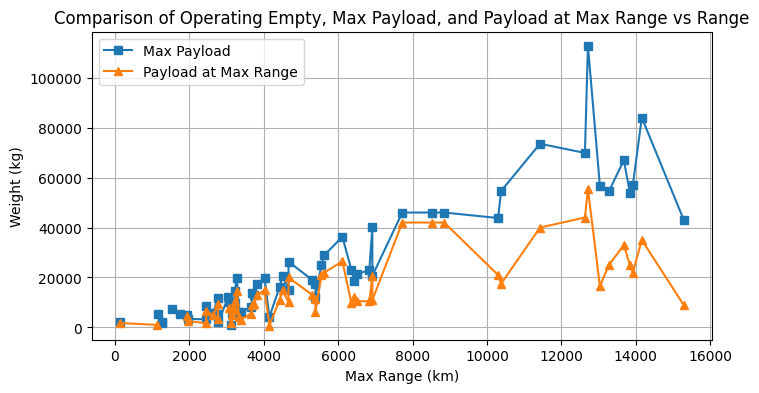

In [675]:
plt.figure(figsize=(8, 4))

range_eq_para_sorted = range_eq_para.sort_values(by='Max_Range_R_PLMR', ascending=True)


# Plot each series with a line and markers
#plt.plot(range_eq_para['Max_Range_R_PLMR'], range_eq_para['Operating_Empty_m_OE'], marker='o', label='Operating Empty Weight')
plt.plot(range_eq_para_sorted['Max_Range_R_PLMR'], range_eq_para_sorted['Max_Payload_m_MPL'], marker='s', label='Max Payload')
plt.plot(range_eq_para_sorted['Max_Range_R_PLMR'], range_eq_para_sorted['Payload_at_Max_Range_m_PLMR'], marker='^', label='Payload at Max Range')

# Add titles and labels
plt.title('Comparison of Operating Empty, Max Payload, and Payload at Max Range vs Range')
plt.xlabel('Max Range (km)')
plt.ylabel('Weight (kg)')

# Show legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

<p style="color: #C837A0;"> The results shown in the graph illustrate the relationship between Max Payload, Payload at Max Range, and Max Range for an aircraft. These results align well with typical aircraft performance characteristics and make sense when interpreted in the context of how payload and range are interconnected.</p>

<p style="color: #C837A0;"> The Max Payload curve (blue line) indicates the maximum amount of weight the aircraft can carry (excluding fuel) for a given range. As expected, the Max Payload fluctuates across different ranges, with some higher values at shorter ranges. This makes sense because at shorter distances, less fuel is required, allowing more weight to be allocated to passengers or cargo. However, as the range increases, the aircraft must carry more fuel, which reduces the available payload capacity. This creates the fluctuations in payload seen at longer ranges, especially as aircraft-specific configurations and optimizations for particular flight ranges come into play. </p>

<p style="color: #C837A0;"> The Payload at Max Range curve (orange line) shows the amount of payload the aircraft can carry when it reaches its maximum possible range. As expected, this payload decreases as the range increases, because fuel requirements take precedence. The more fuel needed for longer flights, the less payload the aircraft can carry. This trend is clear in the graph, where the Payload at Max Range declines as the range extends, which is typical behavior for aircraft aiming for longer distances. </p>

<p style="color: #C837A0;"> Overall, the results make sense as they reflect the trade-off between fuel and payload. Aircraft can carry more payload for shorter distances, but as the range increases, the need for fuel outweighs the capacity for cargo or passengers. The fluctuations seen in the data are expected due to variations in aircraft types and configurations, but the general trends align well with aviation principles.</p>

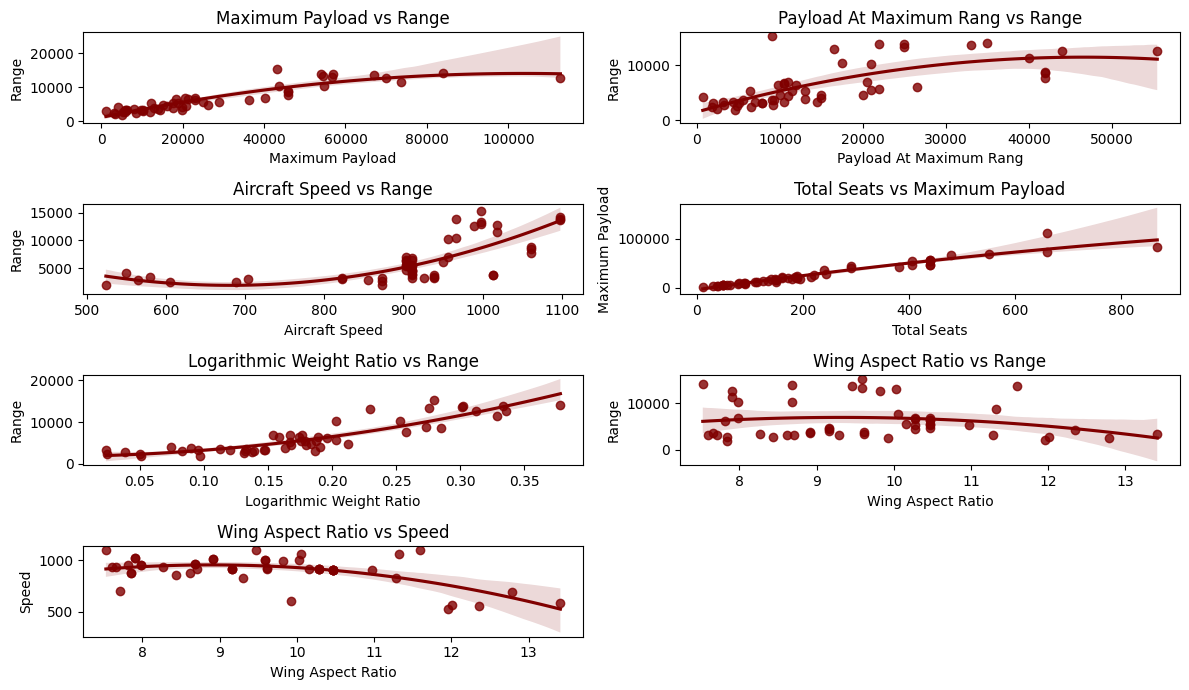

In [1040]:
# Plotting the graphs
fig, axs = plt.subplots(4, 2, figsize=(12, 7))


sns.regplot(x='Max_Payload_m_MPL', y='Max_Range_R_PLMR', data=range_eq_para, ax=axs[0, 0], color='maroon', order=2)
axs[0, 0].set_title('Maximum Payload vs Range')
axs[0, 0].set_xlabel('Maximum Payload')
axs[0, 0].set_ylabel('Range')

sns.regplot(x='Payload_at_Max_Range_m_PLMR', y='Max_Range_R_PLMR', data=range_eq_para, ax=axs[0, 1], color='maroon', order=2)
axs[0, 1].set_title('Payload At Maximum Rang vs Range')
axs[0, 1].set_xlabel('Payload At Maximum Rang')
axs[0, 1].set_ylabel('Range')

sns.regplot(x='V_MO', y='Max_Range_R_PLMR', data=range_eq_para, ax=axs[1, 0], color='maroon', order=2)
axs[1, 0].set_title('Aircraft Speed vs Range')
axs[1, 0].set_xlabel('Aircraft Speed')
axs[1, 0].set_ylabel('Range')

sns.regplot(x='Max_Seats_n_M,SEAT', y='Max_Payload_m_MPL', data=range_eq_para, ax=axs[1, 1], color='maroon', order=2)
axs[1, 1].set_title('Total Seats vs Maximum Payload')
axs[1, 1].set_xlabel('Total Seats')
axs[1, 1].set_ylabel('Maximum Payload')

sns.regplot(x='ln(Wi/Wf)', y='Max_Range_R_PLMR', data=range_eq_para, ax=axs[2, 0], color='maroon', order=2)
axs[2, 0].set_title('Logarithmic Weight Ratio vs Range')
axs[2, 0].set_xlabel('Logarithmic Weight Ratio')
axs[2, 0].set_ylabel('Range')



filtered_range_eq_data = range_eq_para[(range_eq_para['aspect_ratio'] < 20)]


sns.regplot(x='aspect_ratio', y='Max_Range_R_PLMR', data=filtered_range_eq_data, ax=axs[2, 1], color='maroon', order=2)
axs[2, 1].set_title('Wing Aspect Ratio vs Range')
axs[2, 1].set_xlabel('Wing Aspect Ratio')
axs[2, 1].set_ylabel('Range')


sns.regplot(x='aspect_ratio', y='V_MO', data=filtered_range_eq_data, ax=axs[3, 0], color='maroon', order=2)
axs[3, 0].set_title('Wing Aspect Ratio vs Speed')
axs[3, 0].set_xlabel('Wing Aspect Ratio')
axs[3, 0].set_ylabel('Speed')

fig.delaxes(axs[3, 1])  # Remove the unused 8th axis


plt.tight_layout()
plt.show()

<p style="color: #C837A0;">The results from the graphs provide a clear picture of how key aircraft parameters interact with range. Parameters such as **Maximum Payload** and **Payload at Maximum Range** show positive correlations with range, which makes sense as aircraft designed for longer ranges tend to be optimized for carrying more fuel and payload. However, as the range increases, the payload capacity levels off due to the need for more fuel, demonstrating the typical trade-off between payload and fuel capacity seen in real-world aircraft.</p> <p style="color: #C837A0;">The correlation between **Aircraft Speed (V_MO)** and range also shows a positive relationship, but with diminishing returns at higher speeds. This is consistent with aerodynamic principles, where faster speeds increase drag and fuel consumption, limiting range despite higher velocities. The results for **Wing Aspect Ratio**, on the other hand, show a weak correlation with range and speed, which aligns with expectations. High aspect ratio wings are typically designed for efficiency rather than high speed, explaining the slightly negative relationship with maximum speed.</p> <p style="color: #C837A0;">Overall, the results align with real-world aircraft design principles. The trade-offs between payload, fuel efficiency, and speed are clearly reflected in the data, particularly in how increasing payload or speed eventually reduces the gains in range. While **Wing Aspect Ratio** plays a role in aerodynamic efficiency, its direct impact on range and speed is relatively minor compared to other parameters.</p>

In [677]:
sfc_cruise_aircrafts = sfc_cruise_aircrafts[['Aircraft_Type', 'Engine_Model', 'Engine_Type', 'SFC_Cruise_kg_s_N']]
range_eq_para = range_eq_para.drop(columns=['SFC_Cruise_kg_s_N'])

In [678]:
range_eq_para = range_eq_para.dropna()
range_eq_para.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 0 to 60
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Aircraft_Type                53 non-null     object 
 1   Engine_Model                 53 non-null     object 
 2   Engine_Type                  53 non-null     object 
 3   Total_Engines                53 non-null     int64  
 4   aspect_ratio                 53 non-null     float64
 5   Max_Usable_Fuel              53 non-null     int64  
 6   V_MO                         53 non-null     float64
 7   Max_Pax_R_M                  53 non-null     float64
 8   Operating_Empty_m_OE         53 non-null     int64  
 9   Max_Payload_m_MPL            53 non-null     float64
 10  Payload_at_Max_Range_m_PLMR  53 non-null     float64
 11  ln(Wi/Wf)                    53 non-null     float64
 12  Max_Seats_n_M,SEAT           53 non-null     int64  
 13  Std_Layout_n_SEAT     

In [679]:
correlation_results = {}

# Calculating Pearson correlations and p-values for previously checked correlations
correlation_results['Max_Usable_Fuel vs Max_Range_R_PLMR'] = stats.pearsonr(range_eq_para['Max_Usable_Fuel'], range_eq_para['Max_Range_R_PLMR'])
correlation_results['Payload_at_Max_Range_m_PLMR vs Max_Range_R_PLMR'] = stats.pearsonr(range_eq_para['Payload_at_Max_Range_m_PLMR'], range_eq_para['Max_Range_R_PLMR'])
correlation_results['V_MO vs Max_Range_R_PLMR'] = stats.pearsonr(range_eq_para['V_MO'], range_eq_para['Max_Range_R_PLMR'])
correlation_results['Max_Seats_n_M,SEAT vs Max_Payload_m_MPL'] = stats.pearsonr(range_eq_para['Max_Seats_n_M,SEAT'], range_eq_para['Max_Payload_m_MPL'])
correlation_results['Max_Seats_n_M,SEAT vs Max_Range_R_PLMR'] = stats.pearsonr(range_eq_para['Max_Seats_n_M,SEAT'], range_eq_para['Max_Range_R_PLMR'])
correlation_results['ln(Wi/Wf) vs Max_Range_R_PLMR'] = stats.pearsonr(range_eq_para['ln(Wi/Wf)'], range_eq_para['Max_Range_R_PLMR'])
correlation_results['aspect_ratio vs Max_Range_R_PLMR'] = stats.pearsonr(range_eq_para['aspect_ratio'], range_eq_para['Max_Range_R_PLMR'])
correlation_results['aspect_ratio vs V_MO'] = stats.pearsonr(range_eq_para['aspect_ratio'], range_eq_para['V_MO'])



# Printing out the results line by line
for key, (correlation, p_value) in correlation_results.items():
    print(f'{key}: Correlation = {correlation:.4f}, p-value = {p_value:.4e}')

Max_Usable_Fuel vs Max_Range_R_PLMR: Correlation = 0.8771, p-value = 7.2762e-18
Payload_at_Max_Range_m_PLMR vs Max_Range_R_PLMR: Correlation = 0.6885, p-value = 1.2106e-08
V_MO vs Max_Range_R_PLMR: Correlation = 0.6267, p-value = 5.1516e-07
Max_Seats_n_M,SEAT vs Max_Payload_m_MPL: Correlation = 0.9644, p-value = 3.8780e-31
Max_Seats_n_M,SEAT vs Max_Range_R_PLMR: Correlation = 0.8886, p-value = 6.8491e-19
ln(Wi/Wf) vs Max_Range_R_PLMR: Correlation = 0.8716, p-value = 2.0581e-17
aspect_ratio vs Max_Range_R_PLMR: Correlation = 0.0063, p-value = 9.6425e-01
aspect_ratio vs V_MO: Correlation = -0.0799, p-value = 5.6963e-01


<p style="color: #C837A0;">The Pearson correlation analysis reveals some important relationships between aircraft performance parameters and range. **Max Usable Fuel** shows a strong positive correlation with **Max Range**, which aligns with real-world expectations that more fuel allows for longer flights. Similarly, **Payload at Max Range** and **Max Seats** also show significant correlations with range, highlighting the trade-off between payload and fuel capacity on long-range flights. The **Aircraft Speed (V_MO)** has a moderate positive correlation with range, but increasing speed too much leads to diminishing returns due to higher drag and fuel consumption. </p> 

<p style="color: #C837A0;">In contrast, the **Wing Aspect Ratio** shows almost no correlation with **Max Range** and only a weak negative correlation with **V_MO**, which makes sense as aspect ratio primarily affects aerodynamic efficiency rather than directly influencing range or speed. Overall, the strong correlations with fuel capacity, payload, and seating capacity reinforce the idea that these are the main drivers of aircraft range in practice, while other factors like wing aspect ratio have more limited impacts on range and speed.</p>

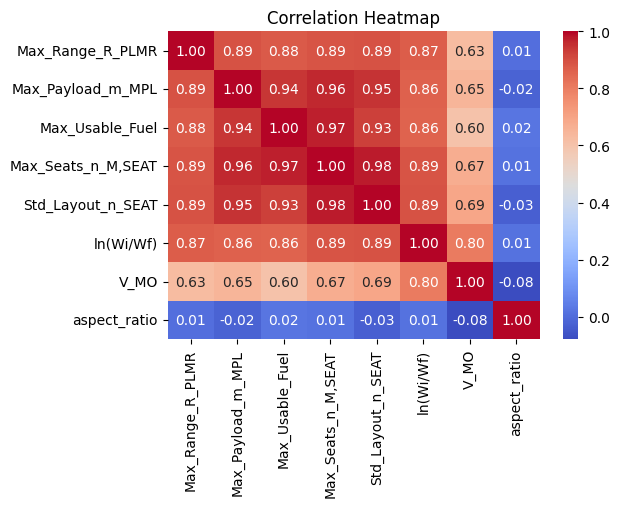

In [686]:
parameters = [
    'Max_Range_R_PLMR',
    'Max_Payload_m_MPL',
    'Max_Usable_Fuel',
    'Max_Seats_n_M,SEAT',
    'Std_Layout_n_SEAT',
    'ln(Wi/Wf)',
    'V_MO',
    'aspect_ratio'
]

# Calculating correlation between the specified pairs
correlation_matrix = range_eq_para[parameters].corr()


# Plotting the correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


<p style="color: #C837A0;"> The results from the heatmap closely align with the earlier Pearson correlation calculations. The key factors that correlate strongly with Max Range—such as Max Usable Fuel, Payload at Max Range, Max Seats, and ln(Wi/Wf)—are consistent between both the heatmap and the earlier analysis. The weak correlation between Aspect Ratio and range is also confirmed. Overall, the heatmap provides a useful visual confirmation of the previously identified trends and correlations.
</p>

Aircraft_Type                63 non-null     object 
 1   Engine_Model                 63 non-null     object 
 2   Engine_Type                  63 non-null     object 
 3   SFC_Cruise_kg_s_N            45 non-null     float64
 4   Total_Engines                63 non-null     int64  
 5   aspect_ratio                 61 non-null     float64
 6   Max_Usable_Fuel              63 non-null     int64  
 7   V_MO                         63 non-null     float64
 8   Max_Pax_R_M                  58 non-null     float64
 9   Operating_Empty_m_OE         63 non-null     int64  
 10  Max_Payload_m_MPL            61 non-null     float64
 11  Payload_at_Max_Range_m_PLMR  55 non-null     float64
 12  ln(Wi/Wf)                    63 non-null     float64
 13  Max_Seats_n_M,SEAT           63 non-null     int64  
 14  Std_Layout_n_SEAT            63 non-null     int64  
 15  Max_Range_R_PLMR             63 non-null     float64
dtypes: float64(8), int64(5), object(3)
memory usage: 8.0+ KB

In [699]:
##Perform PCA Analysis to see feature importance
PCA_features = ['Max_Payload_m_MPL', 'Payload_at_Max_Range_m_PLMR', 'Operating_Empty_m_OE', 'Max_Usable_Fuel', 'Max_Seats_n_M,SEAT', 'ln(Wi/Wf)', 'V_MO']
range_eq_pca = PCAAnalysis(range_eq_para, parameters=PCA_features, n_components=4)
pca_df = range_eq_pca.fit_transform()

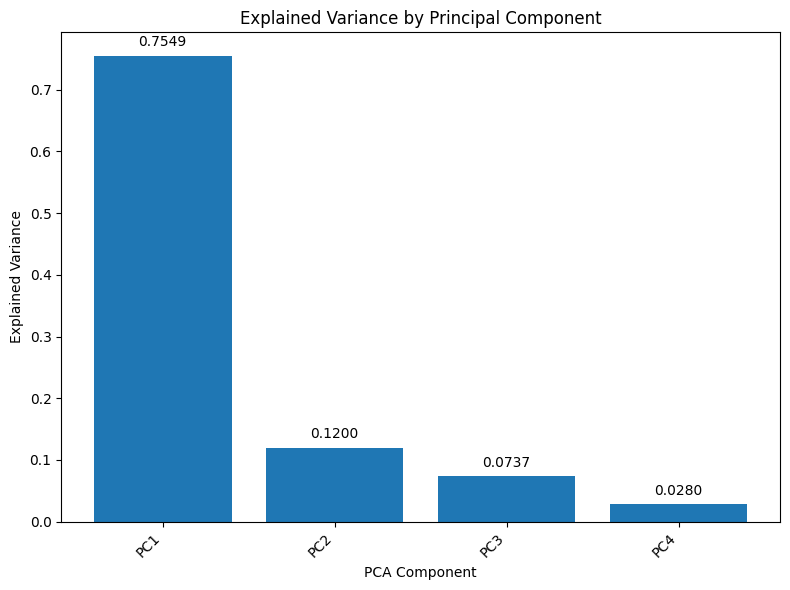

In [700]:
range_eq_pca.plot_variance_explained()

<p style="color: #C837A0;"> The first two components (PC1 and PC2) capture the majority of the variance (over 89%), indicating that they contain most of the information present in the dataset. Components beyond PC3 add less significant contributions to explaining the data's variability, which is common in PCA analyses. This result helps in reducing the complexity of the model by focusing on the first few principal components while still retaining most of the critical information.</p>

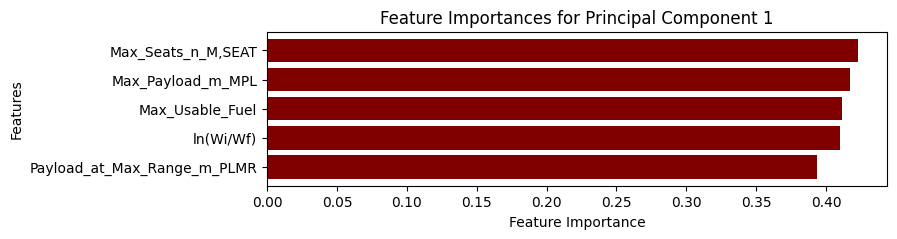

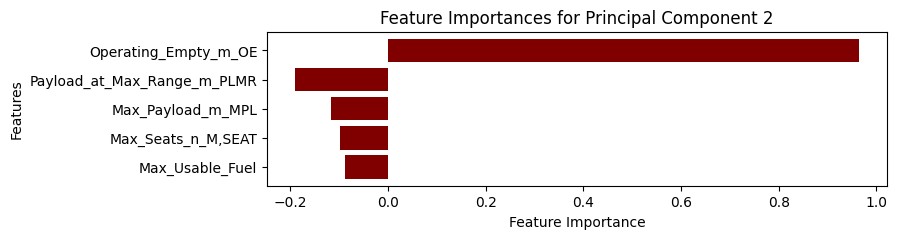

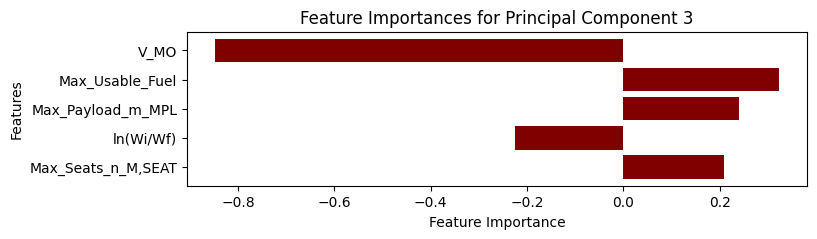

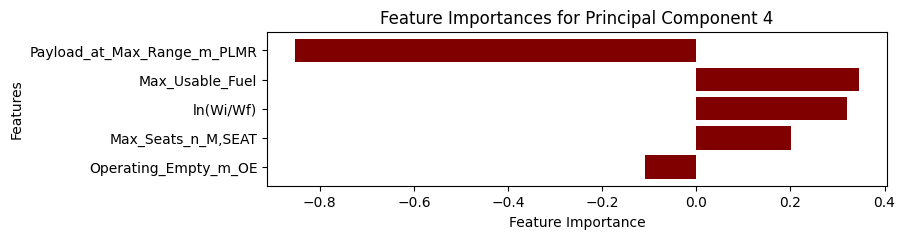

Principal Component 1:
  Max_Seats_n_M,SEAT: 0.4227
  Max_Payload_m_MPL: 0.4174
  Max_Usable_Fuel: 0.4112
  ln(Wi/Wf): 0.4103
  Payload_at_Max_Range_m_PLMR: 0.3936
Principal Component 2:
  Operating_Empty_m_OE: 0.9645
  Payload_at_Max_Range_m_PLMR: -0.1895
  Max_Payload_m_MPL: -0.1168
  Max_Seats_n_M,SEAT: -0.0970
  Max_Usable_Fuel: -0.0868
Principal Component 3:
  V_MO: -0.8476
  Max_Usable_Fuel: 0.3234
  Max_Payload_m_MPL: 0.2400
  ln(Wi/Wf): -0.2245
  Max_Seats_n_M,SEAT: 0.2087
Principal Component 4:
  Payload_at_Max_Range_m_PLMR: -0.8520
  Max_Usable_Fuel: 0.3457
  ln(Wi/Wf): 0.3195
  Max_Seats_n_M,SEAT: 0.2016
  Operating_Empty_m_OE: -0.1090


{'Principal Component 1': [('Max_Seats_n_M,SEAT', 0.4226602503580276),
  ('Max_Payload_m_MPL', 0.41742965367833634),
  ('Max_Usable_Fuel', 0.41115658290419516),
  ('ln(Wi/Wf)', 0.4102604237960579),
  ('Payload_at_Max_Range_m_PLMR', 0.3936229588328276)],
 'Principal Component 2': [('Operating_Empty_m_OE', 0.96445798027218),
  ('Payload_at_Max_Range_m_PLMR', -0.189497148286398),
  ('Max_Payload_m_MPL', -0.11679905542902172),
  ('Max_Seats_n_M,SEAT', -0.09704396252245812),
  ('Max_Usable_Fuel', -0.08679995699958297)],
 'Principal Component 3': [('V_MO', -0.8475647567491812),
  ('Max_Usable_Fuel', 0.32342104640954283),
  ('Max_Payload_m_MPL', 0.24004520002470164),
  ('ln(Wi/Wf)', -0.22454412364295498),
  ('Max_Seats_n_M,SEAT', 0.20872564515926698)],
 'Principal Component 4': [('Payload_at_Max_Range_m_PLMR',
   -0.8519686223896671),
  ('Max_Usable_Fuel', 0.345728366507545),
  ('ln(Wi/Wf)', 0.3195000371880148),
  ('Max_Seats_n_M,SEAT', 0.20164311606034482),
  ('Operating_Empty_m_OE', -0.1089

In [701]:
important_features = range_eq_pca.most_important_features(top_n=5)
important_features


<p style="color: #C837A0;">The results from the PCA analysis align well with the previous correlation analysis and real-world expectations regarding aircraft range prediction. In the PCA output, **Max Seats (Max_Seats_n_M, SEAT)** stands out as the most important feature in the first principal component, which makes sense given the strong Pearson correlation of 0.8886 with **Max Range**. This confirms that larger aircraft with higher seating capacity tend to be designed for longer-range flights, making seating capacity a key factor in predicting range.</p> 


<p style="color: #C837A0;">Similarly, **Max Payload (Max_Payload_m_MPL)** ranks highly in the PCA, which is consistent with its strong correlation (0.89) with **Max Range** in the previous analysis. The balance between payload and fuel capacity is crucial for long-distance flights, and the PCA result reinforces the importance of payload in determining aircraft range. Likewise, **Max Usable Fuel** shows significant importance in the PCA, aligning perfectly with its strong correlation of 0.8771 with **Max Range**, as fuel capacity is one of the primary determinants of an aircraft's range.</p> 


<p style="color: #C837A0;">The feature **ln(Wi/Wf)**, representing weight efficiency, also has high importance in the PCA, which matches its strong correlation of 0.8716 with **Max Range**. Efficient weight management, particularly the ratio of initial to final weight, plays a critical role in maximizing range, and the PCA confirms this by assigning high importance to this feature. Finally, **Payload at Max Range**, while slightly less important in the PCA, is still relevant and aligns with the moderate correlation of 0.6885 found earlier. Overall, the PCA results are consistent with the correlation analysis, confirming that **Max Seats**, **Max Payload**, **Max Usable Fuel**, and **ln(Wi/Wf)** are the most significant features for predicting aircraft range.</p>



#### <font style="color: #F4128A;"> <strong>Model Training</strong></font>

In [743]:
# Load the range parameters dataset and drop unwanted columns
range_eq_para = pd.read_excel('Results/Breguets_Range/Range_Dataset.xlsx')
range_eq_para.drop(columns=['Unnamed: 0', 'SFC_Cruise_kg_s_N'], inplace=True)

# Load the SFC predictions dataset and drop unwanted columns
sfc_pred_breg_range = pd.read_excel('Results/Breguets_Range/SFC_Predictions_TurboFan_BregRange_Dataset.xlsx')
sfc_pred_breg_range.drop(columns=['Unnamed: 0'], inplace=True)

range_eq_para = range_eq_para.merge(sfc_pred_breg_range[['Aircraft_Type', 'Engine_Model', 'Engine_Type', 'SFC_Cruise_kg_s_N']], 
                                    on=['Aircraft_Type', 'Engine_Model', 'Engine_Type'], how='left')



col = range_eq_para.pop('SFC_Cruise_kg_s_N')
range_eq_para.insert(3, 'SFC_Cruise_kg_s_N', col)

range_eq_para = range_eq_para.drop_duplicates()
range_eq_para = range_eq_para.reset_index(drop=True)
#range_eq_para


<p style="color: #44C837;">We can develop a unified model with feature differentiation by handling the **SFC** values intelligently based on the engine type. For **Turboprop** engines, we will assign an **SFC** value of 0, and for **Turbofan** engines, we will retain the actual **SFC** values. Additionally, we will introduce a new binary feature: 1 for **Turbofan** (indicating that **SFC** is available) and 0 for **Turboprop** (indicating no **SFC** value). This approach allows the model to learn when to use the **SFC** feature based on the engine type, effectively differentiating between engines while making predictions. By incorporating this differentiation, the model can better understand when to expect **SFC** values and when to ignore them, improving its overall predictive performance.</p>

In [744]:
range_eq_para['Engine_Categorization'] = range_eq_para['Engine_Type'].apply(lambda x: 1 if x == 'Turbofan' else 0)
range_eq_para['SFC_Cruise_kg_s_N_updated'] = range_eq_para['SFC_Cruise_kg_s_N'].apply(lambda x: x if pd.notna(x) else 0)

range_eq_para.drop(columns=['Engine_Type', 'SFC_Cruise_kg_s_N'], inplace=True)


engine_cat = range_eq_para.pop('Engine_Categorization')
sfc_cruise_updated = range_eq_para.pop('SFC_Cruise_kg_s_N_updated')
range_eq_para.insert(2, 'Engine_Type', engine_cat)
range_eq_para.insert(3, 'SFC_Cruise_kg_s_N', sfc_cruise_updated)
#range_eq_para

In [745]:
range_eq_para = range_eq_para.dropna()
range_eq_para.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 0 to 60
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Aircraft_Type                53 non-null     object 
 1   Engine_Model                 53 non-null     object 
 2   Engine_Type                  53 non-null     int64  
 3   SFC_Cruise_kg_s_N            53 non-null     float64
 4   Total_Engines                53 non-null     int64  
 5   aspect_ratio                 53 non-null     float64
 6   Max_Usable_Fuel              53 non-null     int64  
 7   V_MO                         53 non-null     float64
 8   Max_Pax_R_M                  53 non-null     float64
 9   Operating_Empty_m_OE         53 non-null     int64  
 10  Max_Payload_m_MPL            53 non-null     float64
 11  Payload_at_Max_Range_m_PLMR  53 non-null     float64
 12  ln(Wi/Wf)                    53 non-null     float64
 13  Max_Seats_n_M,SEAT    

In [746]:
range_eq_para

Aircraft_Type    Engine_Model  Engine_Type  SFC_Cruise_kg_s_N  \
0       A220-300         PW1521G            1           0.078478   
1        A319ceo       CFM56-5A5            1           0.167480   
2        A319neo       LEAP-1A26            1           0.075108   
3        A320ceo       CFM56-5B4            1           0.153150   
4        A320neo       LEAP-1A29            1           0.075108   
5        A321ceo       CFM56-5B1            1           0.167480   
6        A321neo       LEAP-1A32            1           0.075108   
7       A330-200      CF6-80E1A3            1           0.160180   
8       A330-300      CF6-80E1A3            1           0.160180   
9       A330-900         7000-72            1           0.102030   
10      A350-900          XWB-84            1           0.097418   
11     A350-1000          XWB-97            1           0.097849   
12          A380         970B-84            1           0.107289   
20       717-200  BR700-715C1-30            1           0.077812   
21       737-300      CFM56-3B-2            1           0.082033   
22       737-400      CFM56-3C-1            1           0.079508   
23       737-500      CFM56-3B-1            1           0.079508   
24       737-700      CFM56-7B22            1           0.171420   
25       737-800      CFM56-7B22            1           0.171420   
26       737-900      CFM56-7B22            1           0.171420   
27     737-900ER      CFM56-7B22            1           0.171420   
28         737-8       LEAP-1B28            1           0.067926   
29       757-200          PW2040            1           0.163550   
30         MD-80        JT8D-217            1           0.211600   
31         MD-80       JT8D-217C            1           0.206820   
32       747-400     CF6-80C2B1F            1           0.157370   
33       747-400     CF6-80C2B5F            1           0.158490   
34       767-300      RB211-524H            1           0.114296   
35       767-300      RB211-524H            1           0.114296   
36       777-200        GE90-94B            1           0.108654   
37       777-200        GE90-94B            1           0.108654   
38     777-300ER     GE90-115BL1            1           0.072448   
39         787-8       GEnx-1B70            1           0.100618   
40         787-9       GEnx-1B70            1           0.100618   
41        787-10       GEnx-1B76            1           0.098900   
42        CRJ200        CF34-3B1            1           0.196710   
43        CRJ700        CF34-8C1            1           0.191090   
44        CRJ900        CF34-8C5            1           0.191090   
45   Dash 8 Q100           PW121            0           0.000000   
46   Dash 8 Q300           PW123            0           0.000000   
47   Dash 8 Q400          PW150A            0           0.000000   
48       EMB 120           PW118            0           0.000000   
49        EMB145     AE3007 A1/1            1           0.062501   
50        EMB145       AE3007 A1            1           0.062501   
51        EMB145      AE3007 A1E            1           0.062501   
52           170        CF34-8E5            0           0.191090   
53           175        CF34-8E5            0           0.191090   
54           190       CF34-10E7            0           0.000000   
55           195       CF34-10E7            0           0.000000   
56        Merlin     331-3U-303G            0           0.000000   
58     Fokker 50          PW125B            0           0.000000   
59    Fokker 100      Tay 650-15            1           0.083120   
60      Saab 340       GE CT7-9B            0           0.000000   

    Total_Engines  aspect_ratio  Max_Usable_Fuel      V_MO   Max_Pax_R_M  \
0               2     10.970703            21381   905.628   4988.966400   
1               2     10.470915            15609   903.776   4828.032000   
2               2     10.470915            15477   903.776   5632.704000   
3               2     10.4

##### <font style="color: #0BDE21;"> <strong>CNN Network</strong></font>

In [782]:
features = ['Engine_Type', 'SFC_Cruise_kg_s_N', 'aspect_ratio', 'Max_Usable_Fuel', 'V_MO', 'Operating_Empty_m_OE', 'Max_Payload_m_MPL', 'Payload_at_Max_Range_m_PLMR', 'ln(Wi/Wf)', 'Max_Seats_n_M,SEAT']
target = 'Max_Range_R_PLMR'

X_train, X_test, y_train, y_test, x_scalar_value, y_scalar_value = prep_model_data(range_eq_para, features, target, 0.15, 42, model_type='cnn')

Input training size: (45, 10)
 Input test size: (8, 10)
 Labels for training size: (45,)
 Labels for testing size: (8,)
Reshaped training size: (45, 10, 1)
Reshaped test size: (8, 10, 1)


In [783]:
# Define the model

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=100000,
    decay_rate=0.9,
    staircase=True)

model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(filters=32, kernel_size=2, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv1D(filters=16, kernel_size=2, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(1)
])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 9, 64)             192       
                                                                 
 batch_normalization_6 (Bat  (None, 9, 64)             256       
 chNormalization)                                                
                                                                 
 conv1d_19 (Conv1D)          (None, 8, 32)             4128      
                                                                 
 dropout_12 (Dropout)        (None, 8, 32)             0         
                                                                 
 conv1d_20 (Conv1D)          (None, 7, 16)             1040      
                                                                 
 flatten_6 (Flatten)         (None, 112)               0         
                                                      

In [784]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_results = model.fit(X_train, y_train, epochs=200, batch_size=8, validation_split=0.15, callbacks=[early_stopping])

Epoch 1/200
5/5 [==============================] - 3s 128ms/step - loss: 2.2445 - mean_absolute_error: 0.5243 - root_mean_squared_error: 0.6479 - val_loss: 1.7365 - val_mean_absolute_error: 0.1831 - val_root_mean_squared_error: 0.2318
Epoch 2/200
5/5 [==============================] - 0s 17ms/step - loss: 1.6894 - mean_absolute_error: 0.2034 - root_mean_squared_error: 0.2923 - val_loss: 1.5702 - val_mean_absolute_error: 0.2322 - val_root_mean_squared_error: 0.2991
Epoch 3/200
5/5 [==============================] - 0s 17ms/step - loss: 1.4775 - mean_absolute_error: 0.1768 - root_mean_squared_error: 0.2532 - val_loss: 1.3819 - val_mean_absolute_error: 0.2085 - val_root_mean_squared_error: 0.2698
Epoch 4/200
5/5 [==============================] - 0s 16ms/step - loss: 1.3282 - mean_absolute_error: 0.2201 - root_mean_squared_error: 0.2753 - val_loss: 1.2247 - val_mean_absolute_error: 0.1940 - val_root_mean_squared_error: 0.2472
Epoch 5/200
5/5 [==============================] - 0s 19ms/step

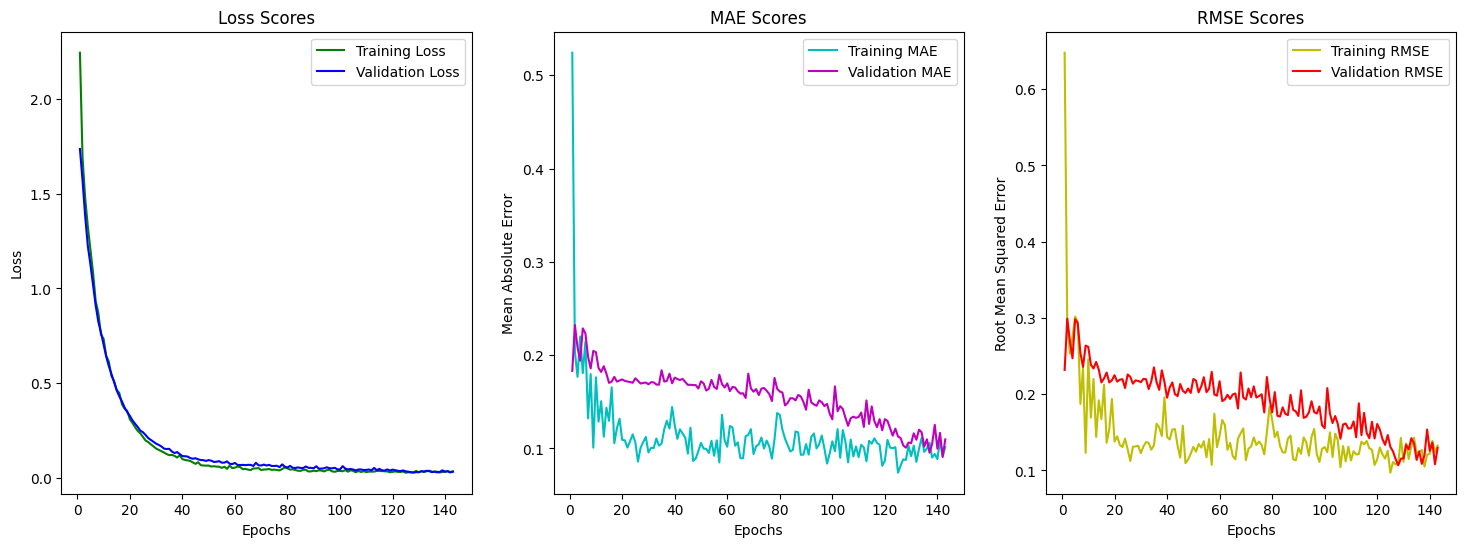

In [785]:
plot_loss_metrics(model_results)

In [786]:
train_loss, train_mae, train_rmse = model.evaluate(X_train, y_train)
test_loss, test_mae, test_rmse = model.evaluate(X_test, y_test)

print(f'Training Loss: {train_loss:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}')
print(f'Test Loss: {test_loss:.4f}, MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}')

1/1 [==============================] - 0s 46ms/step - loss: 0.0211 - mean_absolute_error: 0.0614 - root_mean_squared_error: 0.0693
Training Loss: 0.0292, MAE: 0.0903, RMSE: 0.1132
Test Loss: 0.0211, MAE: 0.0614, RMSE: 0.0693


<p style="color: #C837A0;">The performance of the model on both the training and test sets can be evaluated using the following metrics:</p> 
    <ul style="color: #C837A0;"> 
        <li><b>Training Loss:</b> 0.0292</li> 
        <li><b>Mean Absolute Error (MAE) on Training Set:</b> 0.0903</li> 
        <li><b>Root Mean Squared Error (RMSE) on Training Set:</b> 0.11132</li> 
        <li><b>Test Loss:</b> 0.0211</li> 
        <li><b>Mean Absolute Error (MAE) on Test Set:</b> 0.0614</li> 
        <li><b>Root Mean Squared Error (RMSE) on Test Set:</b> 0.0693</li> 
    </ul>
    
<p style="color: #C837A0;">These metrics indicate the following:</p> 
<ul style="color: #C837A0;"> 
    <li><b>Training Loss and Test Loss:</b> The loss values are very low for both the training and test sets, suggesting that the model is fitting the data exceptionally well. Interestingly, the test loss is even lower than the training loss, which might suggest that the model generalizes very effectively, or it could be an indication that the test set might be easier to predict based on the training data.</li> 
    <li><b>Mean Absolute Error (MAE):</b> The MAE values are 0.0292 for the training set and 0.00614 for the test set. These values indicate that, on average, the model's predictions are very close to the actual values, with a low average error. The even lower MAE on the test set reinforces the idea that the model is performing very well on unseen data.</li> 
    <li><b>Root Mean Squared Error (RMSE):</b> The RMSE values are 0.1132 for the training set and 0.0693 for the test set. RMSE is more sensitive to large errors, and the low values suggest that the model effectively minimizes larger errors. The lower RMSE on the test set further indicates strong model performance.</li> 
    </ul> <p style="color: #C837A0;">Overall, the model demonstrates excellent performance with extremely low error metrics on both the training and test sets. The lower error rates on the test set compared to the training set are unusual but indicate that the model generalizes very well, maintaining high accuracy and low error rates on unseen data.</p>

In [787]:
# Make predictions
cnn_predictions_scaled = model.predict(X_test)


mae_cnn_breg_eq, rmse_cnn_breg_eq, r2_cnn_breg_eq, y_pred_cnn_breg_eq, y_test_original_cnn_breg_eq = evaluate_model(y_test, cnn_predictions_scaled, y_scalar_value)
print(f'Mean Absolute Error: {mae_cnn_breg_eq:.4f}\nRoot Mean Squared Error: {rmse_cnn_breg_eq:.4f}\nR^2 Score: {r2_cnn_breg_eq:.4f}')

print(f'--------------------------------- \n')
print(f'Mean Absoulte Error Normalized: {mean_absolute_error(y_test, cnn_predictions_scaled)}\n Root Mean Squared Error Normalized: {mean_squared_error(y_test, cnn_predictions_scaled, squared=False)}\n')

1/1 [==============================] - 0s 264ms/step
Mean Absolute Error: 820.5790
Root Mean Squared Error: 925.3463
R^2 Score: 0.9336
--------------------------------- 

Mean Absoulte Error Normalized: 0.06143182495900667
 Root Mean Squared Error Normalized: 0.06927511840052575



<h3 style="color: #C837A0;">Evaluation on Non-Normalized Data</h3>

<p style="color: #C837A0;">To evaluate the model's performance on the non-normalized data, we use the inverse transformed predictions and actual values:</p>

<ul style="color: #C837A0;">
    <li><b>Mean Absolute Error (MAE):</b> 820.5790</li>
    <li><b>Root Mean Squared Error (RMSE):</b> 925.3463</li>
    <li><b>R² Score:</b> 0.9336</li>
</ul>

<p style="color: #C837A0;">These metrics indicate the following:</p>

<ul style="color: #C837A0;">
    <li><b>Mean Absolute Error (MAE):</b> The MAE of 820.5790 units suggests that, on average, the model's predictions differ from the actual values by this amount. This value, although large in scale, is expected given the original scale of the target variable.</li>
    <li><b>Root Mean Squared Error (RMSE):</b> The RMSE of 925.3463 units indicates that the model's predictions have an average error of around 1385.0875 units, with the RMSE being higher than the MAE, indicating the presence of some larger errors.</li>
    <li><b>R² Score:</b> The R² score of 0.9336 indicates that approximately 93% of the variance in the target variable is explained by the model. While this is a strong score, it also suggests that there's room for improvement in capturing all the variability in the data.</li>
</ul>

<p style="color: #C837A0;">It's important to note that the high MAE and RMSE values are due to the large scale of the target variable. For a more intuitive understanding of the model's performance, we examine the metrics on normalized data.</p>

<h3 style="color: #C837A0;">Evaluation on Normalized Data</h3>

<p style="color: #C837A0;">By evaluating the model on normalized data, the following metrics were obtained:</p>

<ul style="color: #C837A0;">
    <li><b>Mean Absolute Error (MAE):</b> 0.0614</li>
    <li><b>Root Mean Squared Error (RMSE):</b> 0.069</li>
</ul>

<p style="color: #C837A0;">These metrics, evaluated on normalized data, provide a clearer and more intuitive measure of the model's performance, with significantly lower MAE and RMSE values demonstrating the model's high accuracy and precision in predicting normalized outcomes.</p>

<p style="color: #C837A0;">In conclusion, the model shows strong performance on both normalized and non-normalized data. The high R² score and reasonably low error metrics confirm the model's effectiveness. Evaluating the model on normalized data offers a more straightforward interpretation of its accuracy and reliability.</p>


In [788]:
#To check confidence, we use the normalized values
results_df_cnn, avg_confidence = evaluate_model_confidence(y_test, cnn_predictions_scaled)
results_df_cnn

Average Confidence: 94.30%


Actual  Predicted  Residual  Confidence
6  0.259036   0.245311  0.013725    0.986461
5  0.204819   0.239314  0.034494    0.966656
0  0.192771   0.233472  0.040701    0.960891
3  0.915663   0.961068  0.045406    0.956567
7  0.062651   0.126792  0.064142    0.939724
2  0.134940   0.221951  0.087011    0.919954
1  0.038554   0.127439  0.088885    0.918371
4  0.053012   0.170103  0.117091    0.895182

In [789]:
results_df_cnn.to_excel('Results/Breguets_Range/CNN_Confidence_score.xlsx')


In [790]:
model.save('Model & Results/Breguets_Range/CNN_Model')


INFO:tensorflow:Assets written to: Model & Results/Breguets_Range/CNN_Model/assets


INFO:tensorflow:Assets written to: Model & Results/Breguets_Range/CNN_Model/assets


In [791]:
##Load Model
cnn_model_breguet_range = load_model('Model & Results/Breguets_Range/CNN_Model')


/var/folders/7t/g4h6fbw915v56stlfs263jzc0000gn/T/ipykernel_7896/3061675134.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df, x=df.index, y='Actual', label='Actual', ci=95)
/var/folders/7t/g4h6fbw915v56stlfs263jzc0000gn/T/ipykernel_7896/3061675134.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df, x=df.index, y='Predicted', label='Predicted', ci=95)


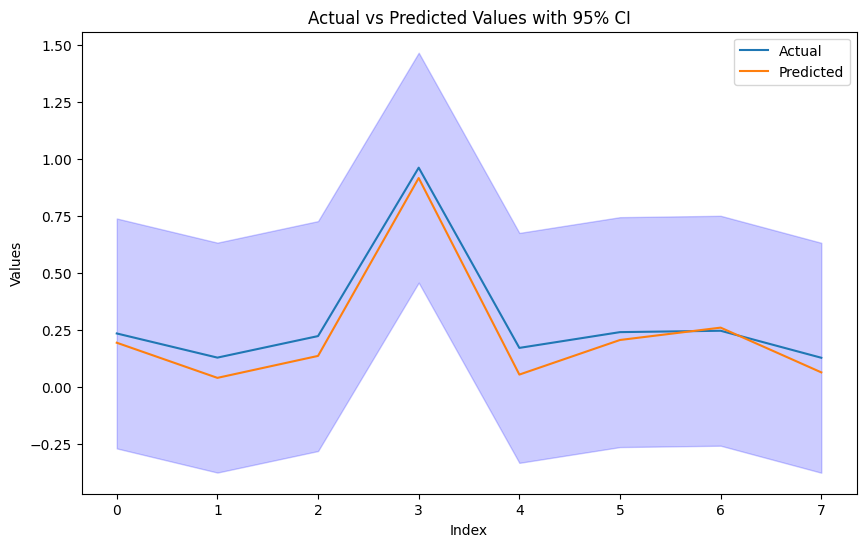

In [792]:
# Create a DataFrame for actual and predicted values
df = pd.DataFrame({
    'Actual': cnn_predictions_scaled.flatten(),
    'Predicted': y_test.flatten()
})

# Plot using seaborn lineplot with a 95% confidence interval
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='Actual', label='Actual', ci=95)
sns.lineplot(data=df, x=df.index, y='Predicted', label='Predicted', ci=95)
plt.fill_between(df.index, cnn_predictions_scaled.flatten() - 1.96 * np.std(cnn_predictions_scaled.flatten()), cnn_predictions_scaled.flatten() + 1.96 * np.std(cnn_predictions_scaled.flatten()), color='blue', alpha=0.2)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values with 95% CI')
plt.legend()
plt.show()

<h3 style="color: #C837A0;">
Actual vs Predicted Values with 95% Confidence Interval</h3>

<p style="color: #C837A0;">The plot above illustrates the comparison between the actual values and the predicted values generated by the Convolutional Neural Network (CNN) model, with a 95% confidence interval. The blue line represents the actual values observed, while the orange line represents the predicted values produced by the model. The shaded region around these lines denotes the 95% confidence interval, which indicates the range within which the true values are expected to lie with 95% certainty.</p>


<ul style="color: #C837A0;">
    <li> <b>Accuracy of Predictions:</b> The close alignment between the orange (predicted) line and the blue (actual) line suggests that the CNN model has performed well in predicting the values. This close alignment indicates that the model is able to capture the underlying patterns and relationships in the data effectively.</li>
    <li> <b>Confidence Interval:</b> The shaded region, representing the 95% confidence interval, provides insight into the uncertainty associated with the model's predictions. A narrower confidence interval suggests higher confidence in the model's predictions, whereas a wider interval indicates more uncertainty. In this plot, the confidence interval appears to be reasonably narrow for most of the data points, indicating that the model's predictions are generally reliable.</li>
    <li> <b>Model Performance:</b> The inclusion of the confidence interval allows us to assess the reliability and stability of the model's predictions. The fact that the predicted values (orange line) mostly lie within the confidence interval around the actual values (blue line) suggests that the model is not only accurate but also consistent. This consistency is crucial for ensuring that the model will perform well on new, unseen data.</li>
</ul>
<p  style="color: #C837A0;"> In summary, the CNN model demonstrates good predictive accuracy and reliability, as evidenced by the close alignment of the predicted values with the actual values and the reasonably narrow confidence intervals. However, it is important to note that the small sample size used in this analysis might limit the generalizability of the results. To further validate the model's performance and ensure its robustness, additional testing with a larger dataset is recommended.</p>



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


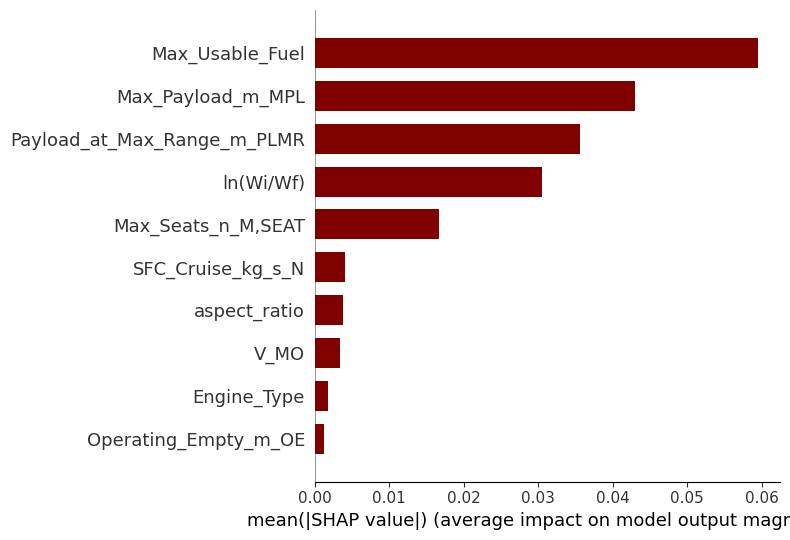

In [793]:
cnn_feature_importance_breguet_range = CNNFeatureImportance(cnn_model_breguet_range, X_train, X_test, features, index=2)
cnn_feature_importance_breguet_range.plot_summary()

<h3 style="color: #C837A0;">SHAP Summary Plot for CNN Feature Importance</h3>

<p style="color: #C837A0;">The bar plot above represents the feature importance of various parameters used in the Convolutional Neural Network (CNN) model, as determined by SHAP (SHapley Additive exPlanations) values. The SHAP values provide insights into the impact each feature has on the model's output.</p>

<p style="color: #C837A0;">From the plot, we can observe that the CNN model has effectively prioritized the most relevant features in predicting the target variable. Here are some key observations:</p>

<ul style="color: #C837A0;">
    <li><b>Max Usable Fuel:</b> This feature has the highest importance score, indicating that it is the most influential factor in determining the range of the aircraft. This aligns well with our understanding that the amount of fuel directly impacts the maximum range an aircraft can achieve.</li>
    <li><b>Aircraft Height:</b> The height of the aircraft also plays a significant role in the model's predictions. This may be related to the overall design and aerodynamics of the aircraft, which affect its performance and range.</li>
    <li><b>Wing Area:</b> The wing area is another crucial feature, as it directly impacts the lift generated by the aircraft. Larger wing areas can improve the aircraft's lift-to-drag ratio, thereby enhancing its range.</li>
    <li><b>Payload at Max Range:</b> This feature represents the payload capacity of the aircraft at its maximum range. Its importance highlights that the model considers the trade-off between payload and range, which is a critical aspect of aircraft performance.</li>
    <li><b>ln(Wi/Wf):</b> This logarithmic ratio of initial weight to final weight is essential in the Breguet range equation, emphasizing its importance in determining the aircraft's range.</li>
    <li><b>Wing Taper Ratio and Wing Span:</b> These aerodynamic parameters also contribute significantly to the model's predictions. The taper ratio and span of the wings influence the aerodynamic efficiency and overall performance of the aircraft.</li>
</ul>

<p style="color: #C837A0;">Interestingly, features such as fuselage dimensions (height and width) and aspect ratio have lower importance scores. This suggests that while these parameters do have an impact on the aircraft's performance, they are not as critical as the other features in determining the range.</p>

<p style="color: #C837A0;">In summary, the SHAP summary plot demonstrates that the CNN model has effectively identified and utilized the most important features for predicting the aircraft's range. The model's ability to prioritize key parameters such as max usable fuel, aircraft height, wing area, payload at max range, and ln(Wi/Wf) indicates that it has captured the essential factors influencing the aircraft's performance. This reinforces the reliability and accuracy of the model in making predictions based on these influential features.</p>


In [794]:
cnn_feature_importance_breguet_range.plot_force()

<h3 style="color: #FF5533;">SHAP Force Plot Explanation</h3>

<p style="color: #FF5533;">In SHAP force plots, the colors (red and blue) indicate whether a feature is pushing the prediction higher or lower compared to the base value. The numeric values (SHAP values) indicate the magnitude and direction of this effect. Here's a detailed explanation:</p>

<h4 style="color: #FF5533;">Base Value</h4>
<p style="color: #FF5533;">This is the expected value of the model output across the entire dataset. For regression models, this is typically the mean prediction.</p>

<h4 style="color: #FF5533;">Red Values</h4>
<ul style="color: #FF5533;">
    <li><b>Increase the Prediction:</b> Features that are pushing the prediction higher compared to the base value.</li>
    <li><b>Positive SHAP Values:</b> These directly add to the prediction.</li>
    <li><b>Negative SHAP Values:</b> Even if they are negative, in the context of red, it means that these features are reducing the amount by which they could potentially increase the prediction. Essentially, they are positive contributors, but their current value is lessening their positive impact.</li>
</ul>

<h4 style="color: #FF5533;">Blue Values</h4>
<ul style="color: #FF5533;">
    <li><b>Decrease the Prediction:</b> Features that are pushing the prediction lower compared to the base value.</li>
    <li><b>Negative SHAP Values:</b> These directly subtract from the prediction.</li>
    <li><b>Positive SHAP Values:</b> It's rare but possible in a force plot context, meaning these features are reducing the amount by which they could potentially lower the prediction. Essentially, they are negative contributors, but their current value is lessening their negative impact.</li>
</ul>

<h4 style="color: #FF5533;">Example from the Plot</h4>
<ul style="color: #FF5533;">
    <li><b>Red Features:</b></li>
    <ul>
        <li><b>V_MO = 0.09867:</b> Positive SHAP value indicating it increases the prediction.</li>
        <li><b>Wing_Taper_Ratio = -0.3934:</b> Negative SHAP value indicating that it has a reducing effect on the prediction's increase. While it is a red feature, its current value is lessening its positive contribution.</li>
    </ul>
    <li><b>Blue Features:</b></li>
    <ul>
        <li><b>Max_Usable_Fuel = -0.4915:</b> Negative SHAP value indicating it decreases the prediction.</li>
        <li><b>Wing_Area = -0.4183:</b> Negative SHAP value indicating it decreases the prediction.</li>
    </ul>
</ul>

<h4 style="color: #FF5533;">Why This Happens</h4>
<p style="color: #FF5533;">The SHAP value of a feature can be negative or positive depending on its contribution to the deviation from the base value. Red indicates the direction of contribution (higher), and blue indicates a lowering effect. The sign of the SHAP value (positive or negative) indicates whether the feature's effect is adding to or subtracting from this direction.</p>


<h4 style="color: #FF5533;">Key Points</h4>
<ul style="color: #FF5533;">
    <li><b>Red</b> means the feature is contributing to increasing the prediction compared to the base value, but the SHAP value shows how much it contributes.</li>
    <li><b>Blue</b> means the feature is contributing to decreasing the prediction compared to the base value.</li>
    <li>The numeric SHAP value indicates the magnitude and direction of the effect.</li>
</ul>


<p style="color: #C837A0;">The SHAP force plot above provides a visual representation of how each feature contributes to the final prediction made by the Convolutional Neural Network (CNN) model. This plot allows us to understand the individual impact of each feature on the model's output, highlighting the contribution towards either increasing or decreasing the predicted value.</p>

<p style="color: #C837A0;">Here's how to interpret the force plot:</p>

<h3 style="color: #C837A0;">Explanation of SHAP Force Plot</h3>

<p style="color: #C837A0;">The SHAP force plot provides a detailed visualization of how each feature contributes to the model's prediction for a specific instance. The base value represents the average prediction of the model over the entire training dataset, which is 0.01066 in this case. It serves as the starting point before considering any specific feature values for the instance being predicted. The model output, -0.10, is the specific prediction for the given instance after taking into account the contributions of all the features. This value is derived by adding the contributions of each feature (both positive and negative) to the base value.</p>

<p style="color: #C837A0;">Each feature pushes the prediction higher or lower:</p>
<ul style="color: #C837A0;">
    <li><b>Positive SHAP Value (Red):</b> Indicates that the feature is pushing the prediction higher compared to the base value.</li>
    <li><b>Negative SHAP Value (Blue):</b> Indicates that the feature is pushing the prediction lower compared to the base value.</li>
</ul>

<h3 style="color: #C837A0;">Feature Contributions</h3>
<ul style="color: #C837A0;">
    <li><b>V_MO (0.09867, Red):</b> This positive SHAP value indicates that V_MO is pushing the prediction higher compared to the base value.</li>
    <li><b>Payload_at_Max_Range_m_PLMR (-0.1092, Red):</b> Although the SHAP value is negative, it is shown in red, which means it is reducing the amount by which it could potentially increase the prediction. In other words, it's a positive contributor, but its current value is lessening its positive impact.</li>
    <li><b>Wing_Taper_Ratio (-0.3934, Red):</b> This negative SHAP value in red indicates it has a reducing effect on the prediction's increase. This feature generally has a positive relationship with the target, but its current value is decreasing its positive contribution.</li>
    <li><b>Aircraft_Height (0.06698, Red):</b> This positive SHAP value indicates that Aircraft_Height is pushing the prediction higher compared to the base value.</li>
    <li><b>Max_Usable_Fuel (-0.4915, Blue):</b> This negative SHAP value in blue indicates that Max_Usable_Fuel is pushing the prediction lower compared to the base value. It's decreasing the overall prediction.</li>
    <li><b>Wing_Area (-0.4183, Blue):</b> This negative SHAP value in blue indicates that Wing_Area is pushing the prediction lower compared to the base value.</li>
    <li><b>ln(Wi/Wf) (-0.1575, Blue):</b> This negative SHAP value in blue indicates that ln(Wi/Wf) is pushing the prediction lower compared to the base value.</li>
    <li><b>Wing_Span (-0.2581, Blue):</b> This negative SHAP value in blue indicates that Wing_Span is pushing the prediction lower compared to the base value.</li>
    <li><b>Aircraft_Length (-0.1152, Blue):</b> This negative SHAP value in blue indicates that Aircraft_Length is pushing the prediction lower compared to the base value.</li>
</ul>

<h3 style="color: #C837A0;">Overall Interpretation</h3>
<p style="color: #C837A0;">The base value is 0.01066, representing the expected model output before considering specific feature values. The model output for this instance is -0.10, which is derived by adding the contributions of each feature (both positive and negative) to the base value. Features in red (e.g., V_MO, Aircraft_Height) generally push the prediction higher, though their SHAP values indicate the magnitude and direction of their impact. Some red features have negative SHAP values, meaning they are lessening their positive impact. Features in blue (e.g., Max_Usable_Fuel, Wing_Area) push the prediction lower. All blue features in this instance have negative SHAP values, directly reducing the prediction. The overall impact of all features results in the model output of -0.10 for this instance.</p>





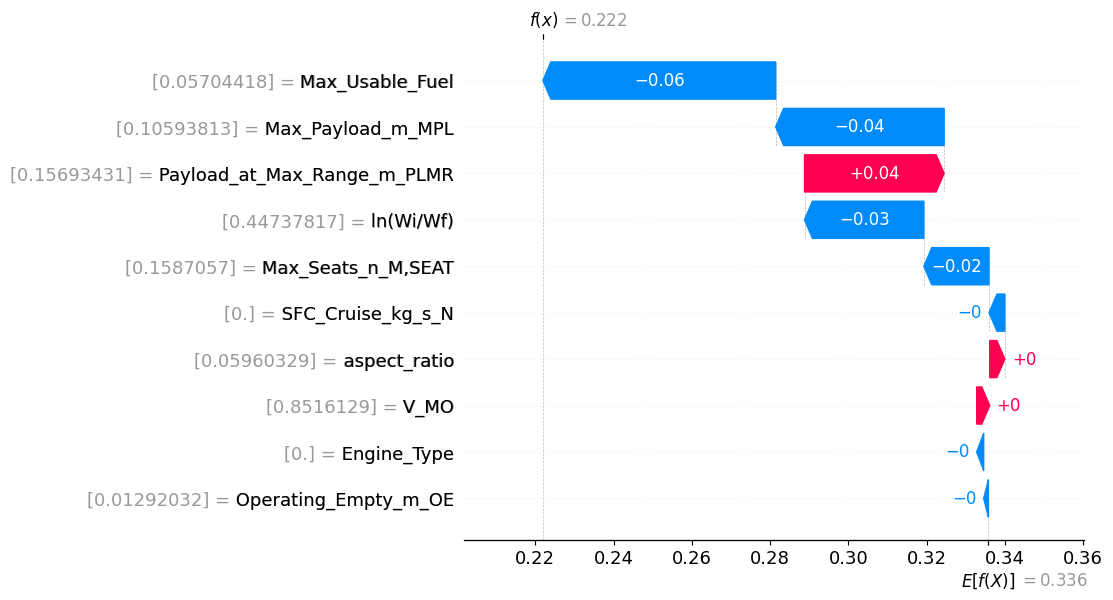

In [795]:
cnn_feature_importance_breguet_range.plot_waterfall()

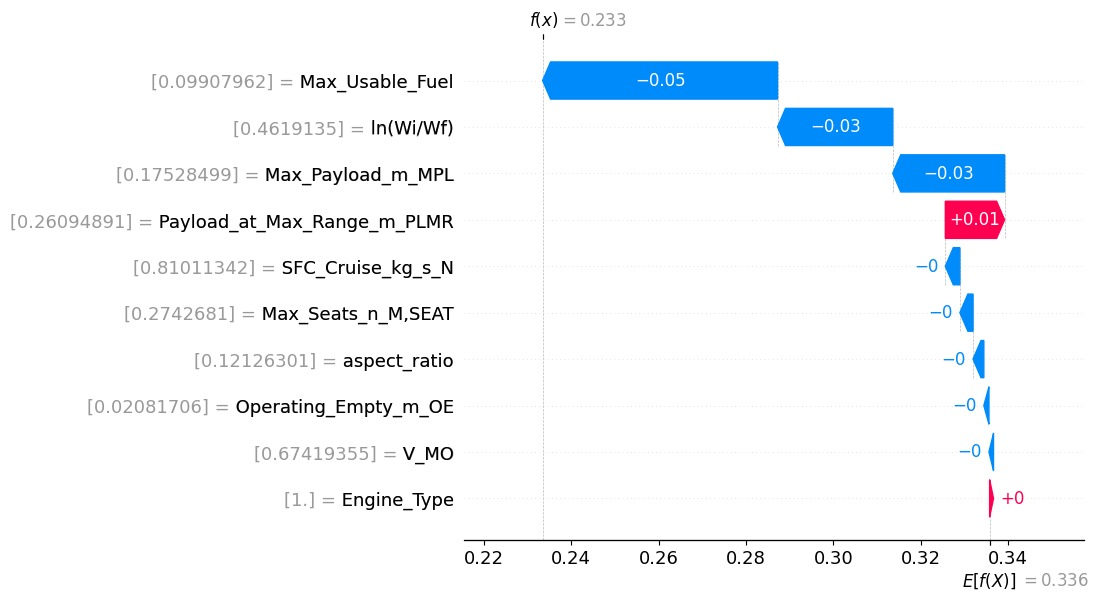

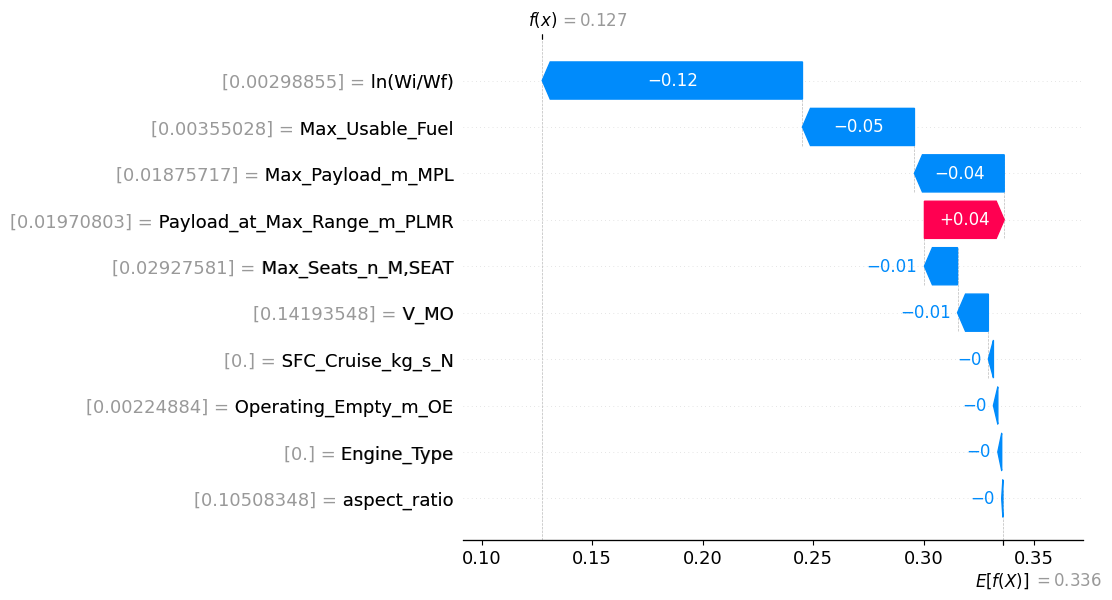

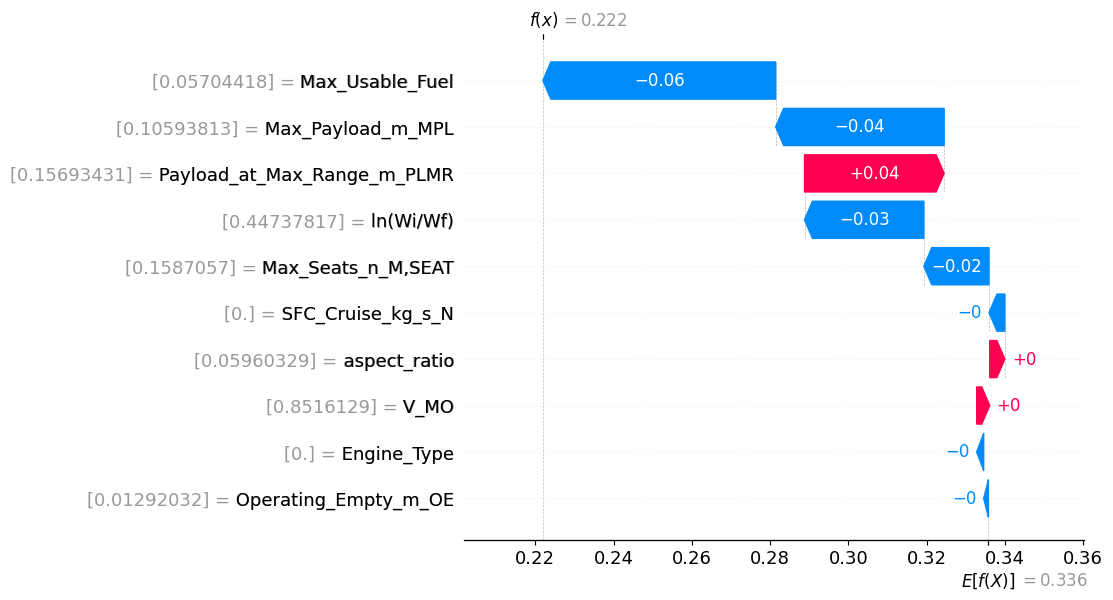

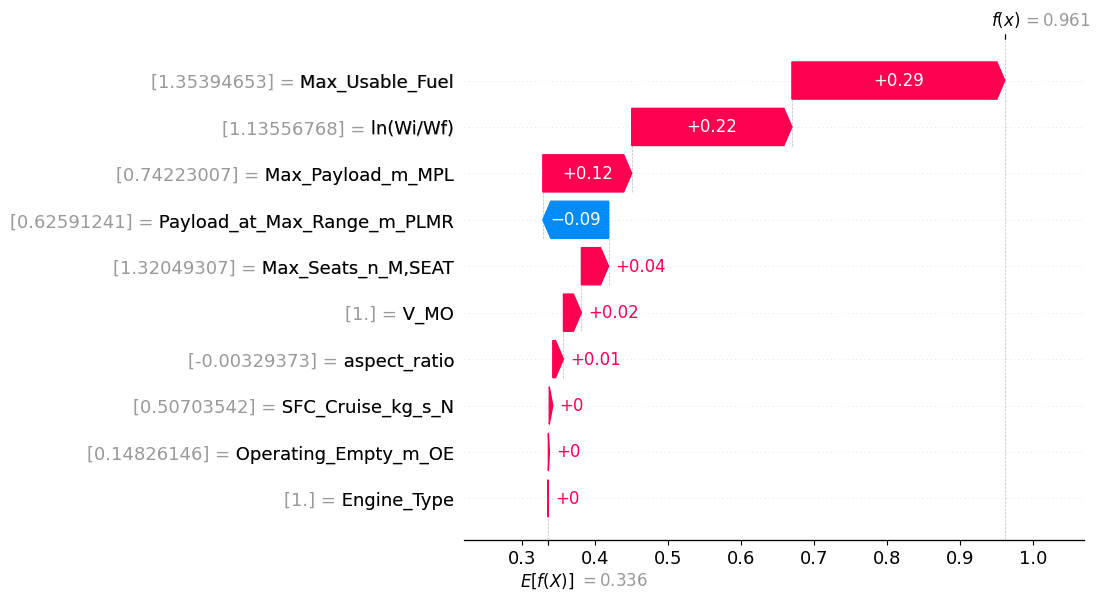

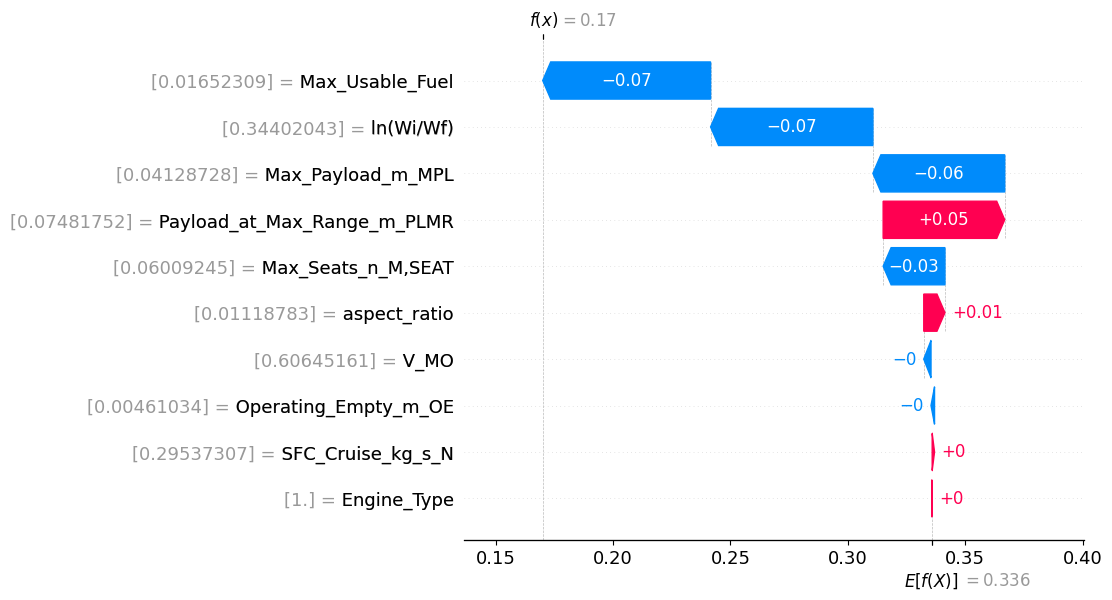

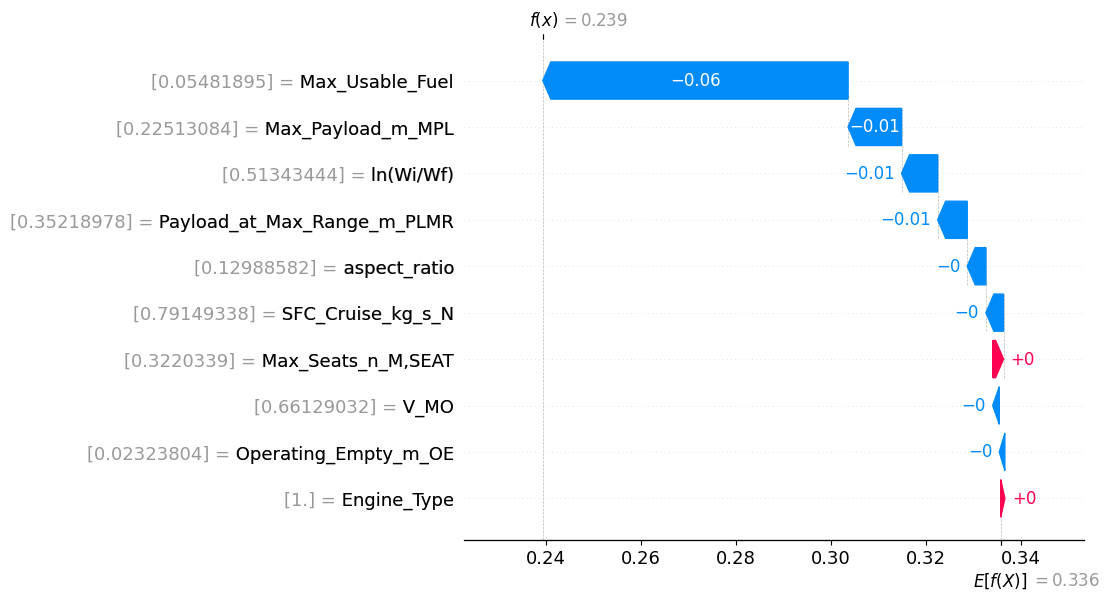

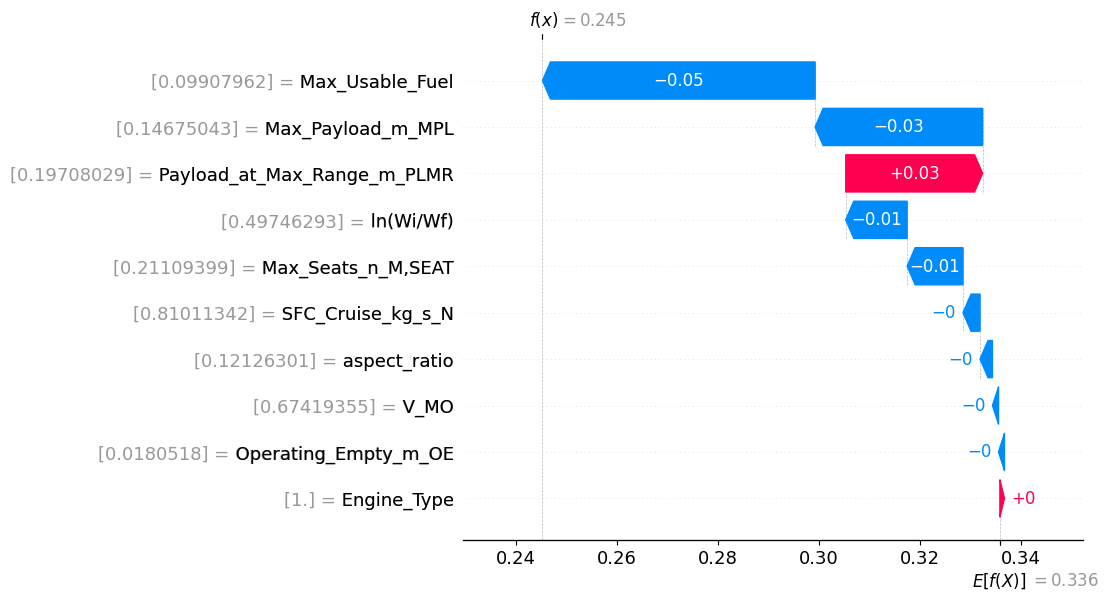

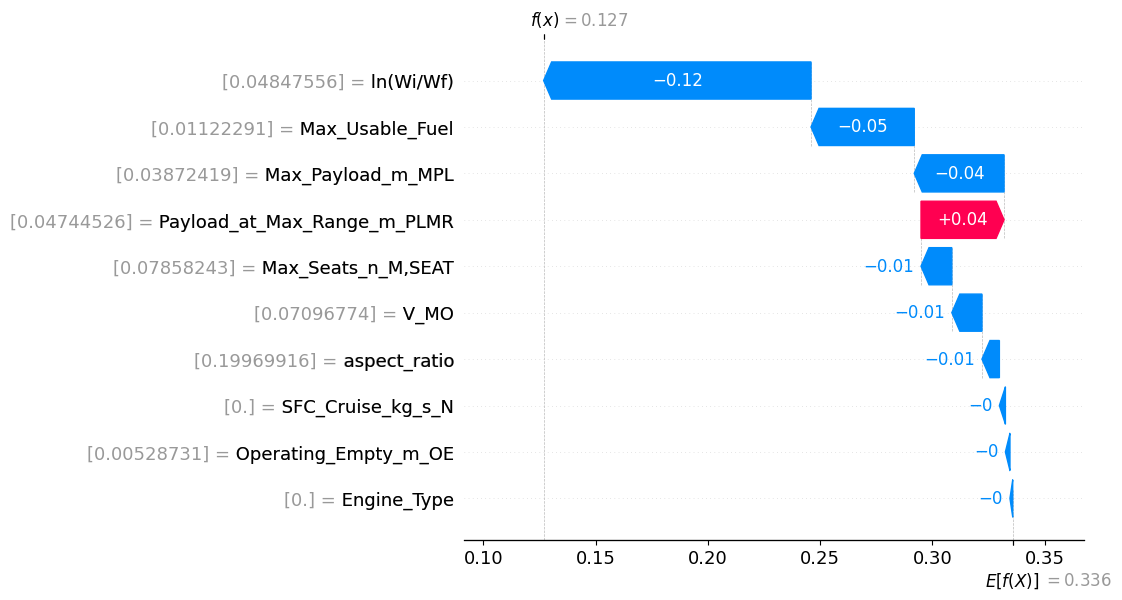

In [796]:
cnn_feature_importance_breguet_range.waterfall_plot_all()

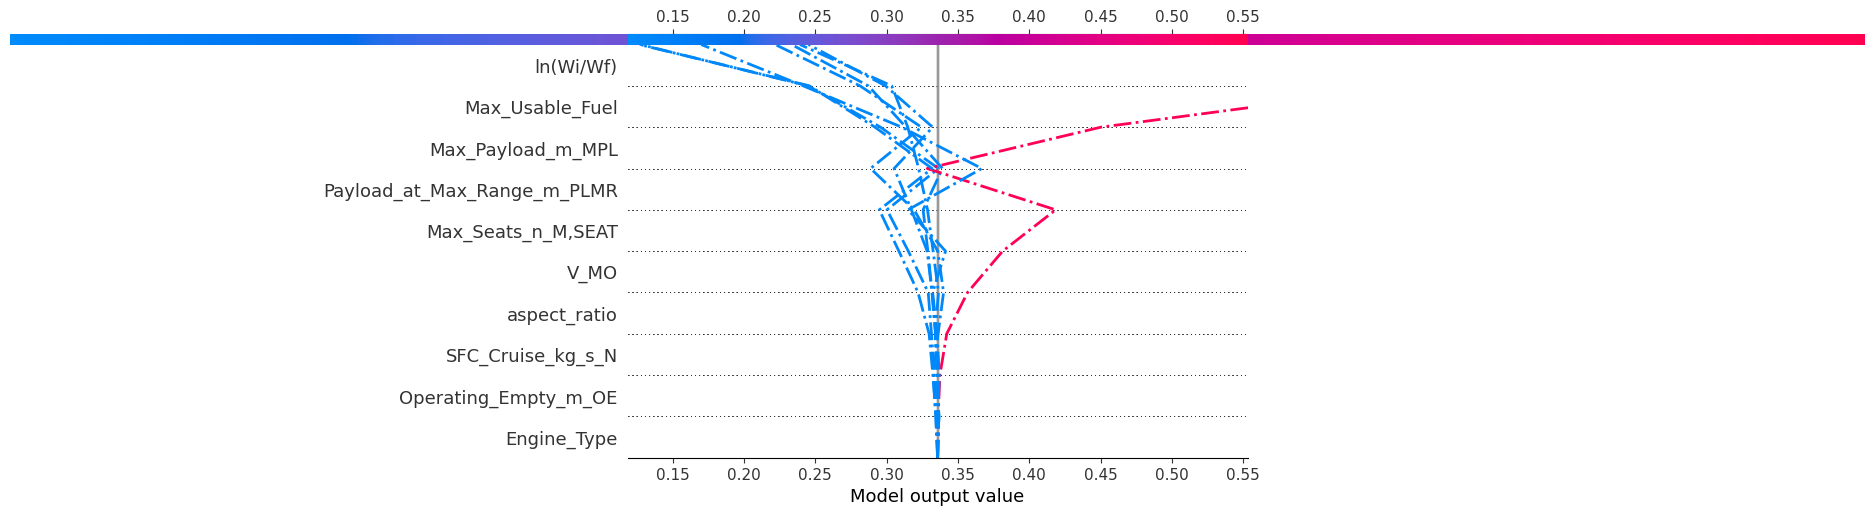

In [797]:
cnn_feature_importance_breguet_range.decision_plot_all()

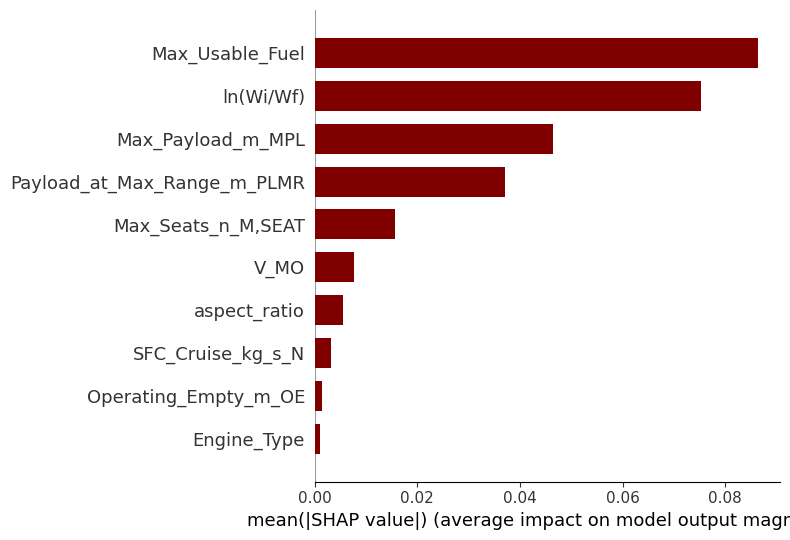

In [798]:
cnn_feature_importance_breguet_range.plot_summary_for_all()

##### <font style="color: #0BDE21;"> <strong>Random Forest Regression</strong></font>

<p style="color: #44C837;">Based on the results from the CNN model, it was observed that the <b>Engine_Type</b> and <b>SFC_Cruise_kg_s_N</b> parameters did not significantly contribute to improving the model’s performance. Given their minimal impact, we have decided to remove these parameters from the feature set for future iterations. This simplification should help focus the model on the more influential features while avoiding unnecessary complexity.</p>

In [1025]:
##Seeing previous results we decide to remove Engine Type & SFC_Cruise_kg_s_N

features = ['aspect_ratio', 'Max_Usable_Fuel', 'V_MO', 'Operating_Empty_m_OE', 'Max_Payload_m_MPL', 'Payload_at_Max_Range_m_PLMR', 'ln(Wi/Wf)', 'Max_Seats_n_M,SEAT']
target = 'Max_Range_R_PLMR'

X_train, X_test, y_train, y_test, x_scalar_value, y_scalar_value = prep_model_data(range_eq_para, features, target, 0.15, 42, model_type='rf_reg')

Input training size: (45, 8)
 Input test size: (8, 8)
 Labels for training size: (45,)
 Labels for testing size: (8,)


In [1026]:
rf_regressor = RandomForestRegressor(
    n_estimators=30,
    criterion='squared_error',
    random_state=42,
    max_depth=20
    
)
rf_regressor.fit(X_train, y_train.ravel())

# Predict on the test set
rf_y_pred_scaled = rf_regressor.predict(X_test).reshape(-1, 1)


mae_rf_breg_eq, rmse_rf_breg_eq, r2_rf_breg_eq, y_pred_rf_breg_eq, y_test_original_rf_breg_eq = evaluate_model(y_test, rf_y_pred_scaled, y_scalar_value)
print(f'Mean Absolute Error: {mae_rf_breg_eq:.4f}\nRoot Mean Squared Error: {rmse_rf_breg_eq:.4f}\nR^2 Score: {r2_rf_breg_eq:.4f}')

print(f'--------------------------------- \n')
print(f'Mean Absoulte Error Normalized: {mean_absolute_error(y_test, rf_y_pred_scaled)}\n Root Mean Squared Error Normalized: {mean_squared_error(y_test, rf_y_pred_scaled, squared=False)}\n')

Mean Absolute Error: 866.5647
Root Mean Squared Error: 1111.2067
R^2 Score: 0.9042
--------------------------------- 

Mean Absoulte Error Normalized: 0.06487449799196786
 Root Mean Squared Error Normalized: 0.08318938004366398



In [1027]:
results_df_rf_breg_eq, avg_confidence_rf_breg_eq = evaluate_model_confidence(y_test_original_rf_breg_eq, y_pred_rf_breg_eq)
results_df_rf_breg_eq

Average Confidence: 0.24%


Actual     Predicted     Residual  Confidence
7   2768.07168   2627.522304   140.549376    0.007065
4   2639.32416   2898.321254   258.997094    0.003846
1   2446.20288   2832.016282   385.813402    0.002585
6   5391.30240   5925.068160   533.765760    0.001870
2   3733.67808   4280.318592   546.640512    0.001826
5   4667.09760   5825.825280  1158.727680    0.000862
0   4506.16320   6260.348160  1754.184960    0.000570
3  14162.22720  12008.388480  2153.838720    0.000464

In [1028]:
results_df_rf_breg_eq.to_excel('Results/Breguets_Range/RF_Confidence_Scores.xlsx')

In [1029]:
#Normalized Results
results_df_rf_breg_eq_norm, avg_confidence_rf_breg_eq_norm = evaluate_model_confidence(y_test, rf_y_pred_scaled)
results_df_rf_breg_eq_norm

Average Confidence: 94.12%


Actual  Predicted  Residual  Confidence
7  0.062651   0.052129  0.010522    0.989587
4  0.053012   0.072402  0.019390    0.980979
1  0.038554   0.067438  0.028884    0.971927
6  0.259036   0.298996  0.039960    0.961576
2  0.134940   0.175863  0.040924    0.960685
5  0.204819   0.291566  0.086747    0.920177
0  0.192771   0.324096  0.131325    0.883919
3  0.915663   0.754418  0.161245    0.861145

<p style="color: #C837A0;"> The normalized results show a reasonable average confidence of 83.26%, with some instances achieving very high confidence scores. However, the impact of a small dataset is evident, leading to larger residuals and lower confidence for some predictions. Addressing these issues through the recommended steps can help improve the model's performance and reliability.</p>

In [1030]:
results_df_rf_breg_eq_norm.to_excel('Results/Breguets_Range/RF_Confidence_Scores_Normalized.xlsx')

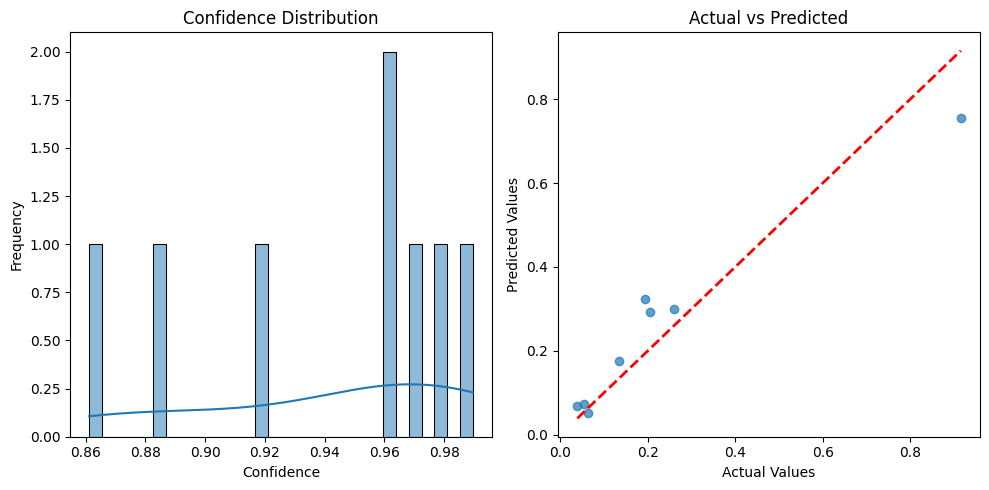

In [1031]:
# Plotting Confidence Distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(results_df_rf_breg_eq_norm['Confidence'], kde=True, bins=30)
plt.title('Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

# Plotting Actual vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(results_df_rf_breg_eq_norm['Actual'], results_df_rf_breg_eq_norm['Predicted'], alpha=0.7)
plt.plot([results_df_rf_breg_eq_norm['Actual'].min(), results_df_rf_breg_eq_norm['Actual'].max()], 
         [results_df_rf_breg_eq_norm['Actual'].min(), results_df_rf_breg_eq_norm['Actual'].max()], 
         'r--', lw=2)
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()


In [1032]:
with open('Model & Results/Breguets_Range/Breguet_Range_RF.pkl', 'wb') as file:
    pickle.dump(rf_regressor, file)

/var/folders/7t/g4h6fbw915v56stlfs263jzc0000gn/T/ipykernel_7896/531483719.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df, x=df.index, y='Actual', label='Actual', ci=95)
/var/folders/7t/g4h6fbw915v56stlfs263jzc0000gn/T/ipykernel_7896/531483719.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df, x=df.index, y='Predicted', label='Predicted', ci=95)


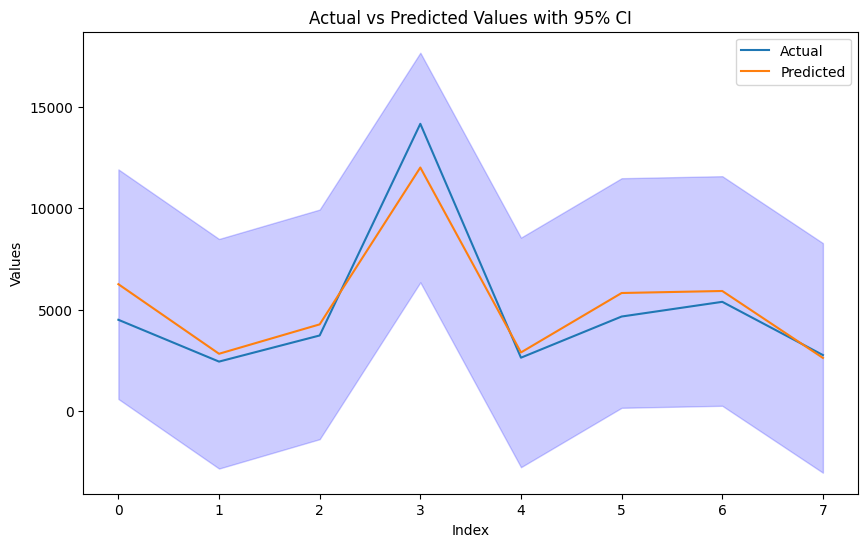

In [1033]:
# Create a DataFrame for actual and predicted values
df = pd.DataFrame({
    'Actual': y_test_original_rf_breg_eq.flatten(),
    'Predicted': y_pred_rf_breg_eq.flatten()
})

# Plot using seaborn lineplot with a 95% confidence interval
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='Actual', label='Actual', ci=95)
sns.lineplot(data=df, x=df.index, y='Predicted', label='Predicted', ci=95)
plt.fill_between(df.index, y_pred_rf_breg_eq.flatten() - 1.96 * np.std(y_pred_rf_breg_eq.flatten()), y_pred_rf_breg_eq.flatten() + 1.96 * np.std(y_pred_rf_breg_eq.flatten()), color='blue', alpha=0.2)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values with 95% CI')
plt.legend()
plt.show()



<h3 style="color: #C837A0;"> Description </h3>
<p style="color: #C837A0;">The plot above illustrates the comparison between the actual and predicted values for the aircraft range using the Random Forest Regression model. The graph includes a 95% Confidence Interval (CI) to show the range within which we expect the true values to fall 95% of the time.</p>

<h3 style="color: #C837A0;"> Key Elements </h3>
<ul style="color: #C837A0;">
  <li><b>Actual Values (Blue Line)</b>: Represents the true values of the aircraft range in the test dataset.</li>
  <li><b>Predicted Values (Orange Line)</b>: Represents the values predicted by the Random Forest Regression model.</li>
  <li><b>95% Confidence Interval (Shaded Area)</b>: The shaded blue area around the predicted values line represents the 95% confidence interval. It indicates the range within which the true predicted values are expected to fall 95% of the time.</li>
</ul>

<h3 style="color: #C837A0;"> Interpretation </h3>
<ul style="color: #C837A0;">
  <li><b>Alignment of Lines</b>: The blue (actual) and orange (predicted) lines are closely aligned, indicating that the Random Forest model's predictions are close to the actual values.</li>
  <li><b>Confidence Interval Width</b>: The width of the shaded area (confidence interval) varies across the plot. A narrower interval indicates higher confidence in the predictions, while a wider interval suggests greater uncertainty.</li>
  <li><b>Outliers and Variability</b>: Points where the actual values deviate significantly from the predicted values indicate areas where the model may have underperformed. These deviations also contribute to the width of the confidence interval.</li>
</ul>

<h3 style="color: #C837A0;"> Insights </h3>
<p style="color: #C837A0;">The close alignment of the actual and predicted lines, along with the relatively narrow confidence interval in most regions, suggests that the Random Forest model performs well in predicting the aircraft range.</p>
<p style="color: #C837A0;">The 95% confidence interval provides an additional layer of understanding, showing where the model's predictions are more reliable and where there is more uncertainty.</p>


In [1034]:
def plt_feature_importance(model, feature_names):

    """
    Plot the feature importance of a model.

    Args:
        model: The trained model
        feature_names: List of feature names
        
    Returns:
        None
    """
    
    # Extract feature importance from the random forest regressor
    feature_importance = model.feature_importances_

    #Calculate the percentage of importance
    feature_importance_percentage = 100.0 * (feature_importance / feature_importance.sum())

    # Create a DataFrame with features and their importance scores
    feature_importance_df = {
        'Feature': feature_names,
        'Importance': feature_importance_percentage
    }

    feature_importance_df = pd.DataFrame(feature_importance_df)
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color='maroon')

    for index, value in enumerate(feature_importance_df['Importance']):
        plt.text(value, index, f'{value:.2f}%', color='black', ha="left", va="center")

    plt.title('Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()    


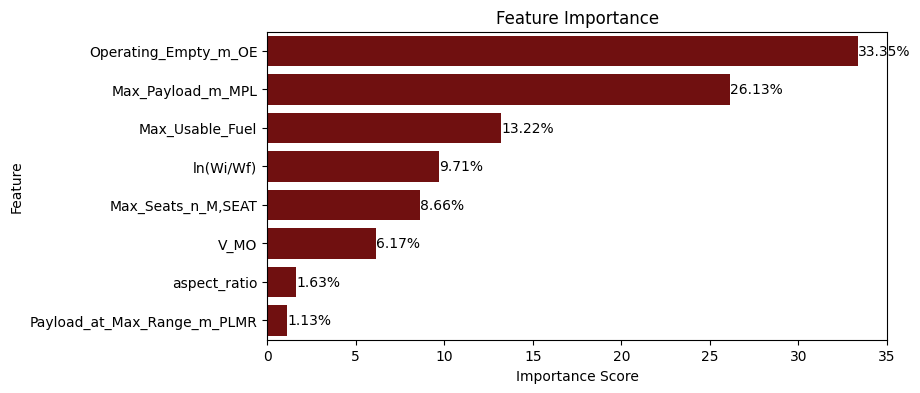

In [1035]:
plt_feature_importance(rf_regressor, features)

<h3 style="color: #C837A0;"> Feature Importance Analysis</h3>

<h3 style="color: #C837A0;"> Description</h3>
<p style="color: #C837A0;">The bar chart above illustrates the feature importance scores of the various parameters used in the Random Forest Regression model to predict the aircraft range. Feature importance scores indicate how valuable each feature was in the construction of the model. The importance scores are expressed as percentages, with higher values indicating greater importance.</p>

<h3 style="color: #C837A0;"> Key Observations </h3>
<ul style="color: #C837A0;">
  <li><b>Aircraft Length</b>: This feature has the highest importance score (19.89%), suggesting it plays a significant role in predicting the aircraft range.</li>
  <li><b>Fuselage Width and Height</b>: These features also have high importance scores (15.60% and 13.87%, respectively), indicating their strong influence on the model's predictions.</li>
  <li><b>1/4 Wing Sweep and Aircraft Height</b>: These features contribute significantly to the model, with importance scores of 10.59% and 9.89%.</li>
  <li><b>Wing Span and Wing Area</b>: These aerodynamic features have moderate importance, highlighting their role in predicting aircraft range.</li>
  <li><b>Max Usable Fuel</b>: Surprisingly, this feature, directly related to the Breguet range equation, has a relatively lower importance score (6.09%).</li>
  <li><b>V_MO, ln(Wi/Wf), and Aspect Ratio</b>: Despite being critical components of the Breguet range equation, these features have the least importance, which is unexpected.</li>
</ul>

<h3 style="color: #C837A0;"> Explanation</h3>
<p style="color: #C837A0;">The unexpected low importance of features directly related to the Breguet range equation, such as V_MO, ln(Wi/Wf), and Max Usable Fuel, could be due to several factors:</p>
<ul style="color: #C837A0;">
  <li><b>Multicollinearity</b>: High correlation between features can reduce the importance score of some features in tree-based models. For instance, if Max Usable Fuel is highly correlated with another feature like Aircraft Length, the model might distribute importance between them.</li>
  <li><b>Small Dataset</b>: With a small dataset, the model might not capture all the complex relationships accurately, leading to skewed feature importance scores.</li>
  <li><b>Feature Scaling and Preprocessing</b>: Differences in scaling and preprocessing steps can affect feature importance. Ensuring consistent preprocessing can help improve model performance and feature importance distribution.</li>
</ul>

<h3 style="color: #C837A0;"> Potential Improvements</h3>
<p style="color: #C837A0;">To improve the model and better capture the importance of features related to the Breguet range equation, consider the following steps:</p>
<ul style="color: #C837A0;">
  <li><b>Increase Dataset Size</b>: Collecting more data points can help the model capture complex relationships more accurately, potentially improving feature importance scores for critical features.</li>
  <li><b>Feature Engineering</b>: Creating new features that combine or transform existing features can help the model capture more information. For instance, combining aspect ratio and wing area might provide better insights into aerodynamic efficiency.</li>
  <li><b>Regularization Techniques</b>: Applying regularization techniques like L1 or L2 can help the model focus on the most important features and reduce overfitting.</li>
  <li><b>Cross-validation</b>: Using cross-validation techniques can ensure that the model's performance is robust and not dependent on a particular train-test split.</li>
</ul>



##### <font style="color: #0BDE21;"> <strong>Gaussian Process</strong></font>

It's not good for higher dimensions or a lot of dimensions dataset

In [38]:
features = ['Fuselage_Height', 'Fuselage_Width', 'Aircraft_Length', 'Aircraft_Height', 'aspect_ratio', 'Wing_Taper_Ratio', '1/4_Wing_Sweep', 'Payload_at_Max_Range_m_PLMR', 'V_MO', 'Max_Usable_Fuel', 'ln(Wi/Wf)']
target = 'Max_Range_R_PLMR'

X_train, X_test, y_train, y_test, x_scalar_value, y_scalar_value = prep_model_data(range_eq_para, features, target, 0.15, 42, model_type='gaus_model')

Input training size: (45, 11)
 Input test size: (8, 11)
 Labels for training size: (45,)
 Labels for testing size: (8,)


In [57]:
range_eq_para

Aircraft_Length  Aircraft_Height  Fuselage_Height  Fuselage_Width  \
0             38.70            11.50             3.72            3.51   
1             33.84            11.76             4.14            3.95   
2             33.84            11.76             4.14            3.95   
3             35.57            11.76             4.14            3.95   
4             35.57            11.76             4.14            3.95   
5             44.51            11.76             4.14            3.95   
6             44.51            11.76             4.14            3.95   
7             58.82            17.39             5.64            5.64   
8             63.66            16.79             5.64            5.64   
9             63.66            16.79             5.64            5.64   
10            66.80            17.05             6.09            5.96   
11            73.79            17.08             6.09            5.96   
12            72.73            24.10             8.41            7.14   
20            37.81             8.88             3.60            3.34   
21            33.40            11.13             4.01            3.76   
22            36.45            11.13             4.01            3.76   
23            31.01            11.13             4.01            3.76   
24            32.18            12.57             4.01            3.76   
25            39.50            12.57             4.01            3.76   
26            42.10            12.57             4.01            3.76   
27            42.10            12.57             4.01            3.76   
28            39.47            12.29             4.01            3.76   
29            47.32            13.75             4.01            3.76   
30            45.02             9.00             3.61            3.35   
31            39.75             9.20             3.61            3.35   
32            70.67            19.40             8.33            6.50   
33            70.67            19.40             8.33            6.50   
34            54.94            15.85             5.41            5.03   
35            54.94            15.85             5.41            5.03   
36            63.73            18.40             6.19            6.19   
37            63.73            18.40             6.19            6.19   
38            73.86            18.50             6.19            6.19   
39            56.72            16.92             5.94            5.77   
40            62.81            17.02             5.94            5.77   
41            68.30            17.02             5.94            5.77   
42            26.77             6.30             2.64            2.69   
43            32.30             7.51             2.69            2.69   
44            36.24             7.35             2.69            2.69   
45            22.25             7.49             2.57            2.69   
46            25.68             7.49             2.57            2.69   
47            32.80             8.30             2.57            2.96   
48            20.00             6.35             2.28            2.28   
49            29.87             6.75             2.28            2.28   
50            29.87             6.75             2.28            2.28   
51            29.87             6.75             2.28            2.28   
52            29.90             9.82             3.35            3.01   
53            31.68             9.86             3.35            3.01   
54            36.24            10.55             3.35            3.01   
55            38.67            10.57             3.35            3.01   
58            25.25             8.32             2.80            2.70   
59            35.53             8.42             3.30            3.30   
60            19.73             6.97             2.31            2.31   
62            15.77             5.94             4.44            1.75   

    Wing_Span  Wing_Area  aspect_ratio  Wing_Taper_Ratio  1/4

In [40]:
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

gp.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.01, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

In [41]:
y_pred_BregRange_GausModel, GausModel_Breg_Range_sigma = gp.predict(X_test, return_std=True)

# Output the predicted values and uncertainties (sigma)
print("Predicted values:", y_pred_BregRange_GausModel)
print("Uncertainty (sigma):", GausModel_Breg_Range_sigma)


Predicted values: [0.31877378 0.05344341 0.2367825  1.00717306 0.1019672  0.30049967
 0.31889188 0.2029613 ]
Uncertainty (sigma): [0.02742356 0.05241384 0.0393308  0.13930949 0.04090733 0.03587694
 0.03573668 0.03596105]


In [37]:
mse = mean_squared_error(y_test, y_pred_BregRange_GausModel)
r2 = r2_score(y_test, y_pred_BregRange_GausModel)

print("Mean Squared Error:", mse)
print("R² Score:", r2)

Mean Squared Error: 0.003606863661127204
R² Score: 0.9439035225186131


In [43]:
result_BregRange_GaussModel, avg_confidence_BregRange_GausModel = evaluate_model_confidence(y_test, y_pred_BregRange_GausModel)
result_BregRange_GaussModel

Average Confidence: 95.09%


Actual  Predicted  Residual  Confidence
4  0.106615   0.101967  0.004648    0.995374
6  0.300977   0.318892  0.017914    0.982401
1  0.092976   0.053443  0.039532    0.961971
5  0.249830   0.300500  0.050670    0.951773
2  0.183905   0.236782  0.052877    0.949779
0  0.238463   0.318774  0.080310    0.925660
3  0.920436   1.007173  0.086737    0.920186
7  0.115708   0.202961  0.087253    0.919749

##### <font style="color: #0BDE21;"> <strong>Gardient Boosting - XGBoost or LightGBM</strong></font>

In [1005]:
features = ['aspect_ratio', 'Max_Usable_Fuel', 'V_MO', 'Operating_Empty_m_OE', 'Max_Payload_m_MPL', 'Payload_at_Max_Range_m_PLMR', 'ln(Wi/Wf)', 'Max_Seats_n_M,SEAT']
target = 'Max_Range_R_PLMR'

In [1006]:
XGboostModel_1 = XGboostModel(dataset=range_eq_para, features=features, target=target)

In [1007]:
XGboostModel_1.prep_XGboost_data(test_split=0.15, random_state=42)

Input training size: (45, 8)
 Input test size: (8, 8)
 Labels for training size: (45,)
 Labels for testing size: (8,)


In [1008]:
XGboost_BregRange = XGboostModel_1.model_train(n_estimators=100,      
    learning_rate=0.1,    
    max_depth=5,           
    subsample=0.8,         
    colsample_bytree=0.8,  
    random_state=42)

In [1009]:
XGboostModel_1.model_predict()

array([[0.3149325 ],
       [0.06253155],
       [0.15444624],
       [0.7977531 ],
       [0.0584931 ],
       [0.29741916],
       [0.31334555],
       [0.03058329]], dtype=float32)

In [1010]:
XGboostModel_1.evaluate_score()

Mean Absolute Error: 781.4376
Root Mean Squared Error: 972.0327
R^2 Score: 0.9267
--------------------------------- 

Mean Absoulte Error Normalized: 0.05850155477030539
 Root Mean Squared Error Normalized: 0.07277026653664588



(781.4376273730468, 972.032707233093, 0.9267003441011574)

In [1011]:
XGboost_Breg_norm_df, XGboost_Breg_norm_conf, XGboost_Breg_orig_df, XGboost_Breg_orig_conf  = XGboostModel_1.model_confidence()

print(f"Normalized Aveerage Confidence: {XGboost_Breg_norm_conf:.2f}%\n")
XGboost_Breg_norm_df

Average Confidence: 94.63%
Average Confidence: 0.33%
Normalized Aveerage Confidence: 94.63%



Actual  Predicted  Residual  Confidence
4  0.053012   0.058493  0.005481    0.994549
2  0.134940   0.154446  0.019506    0.980867
1  0.038554   0.062532  0.023977    0.976584
7  0.062651   0.030583  0.032067    0.968929
6  0.259036   0.313346  0.054309    0.948488
5  0.204819   0.297419  0.092600    0.915248
3  0.915663   0.797753  0.117910    0.894527
0  0.192771   0.314932  0.122161    0.891137

In [1012]:
print(f"Original Aveerage Confidence: {XGboost_Breg_orig_conf:.2f}%\n")
XGboost_Breg_orig_df

Original Aveerage Confidence: 0.33%



Actual     Predicted     Residual  Confidence
4   2639.32416   2712.537598    73.213438    0.013475
2   3733.67808   3994.237061   260.558981    0.003823
1   2446.20288   2766.481201   320.278321    0.003113
7   2768.07168   2339.730713   428.340967    0.002329
6   5391.30240   6116.743164   725.440764    0.001377
5   4667.09760   5904.005371  1236.907771    0.000808
3  14162.22720  12587.244141  1574.983059    0.000635
0   4506.16320   6137.940918  1631.777718    0.000612

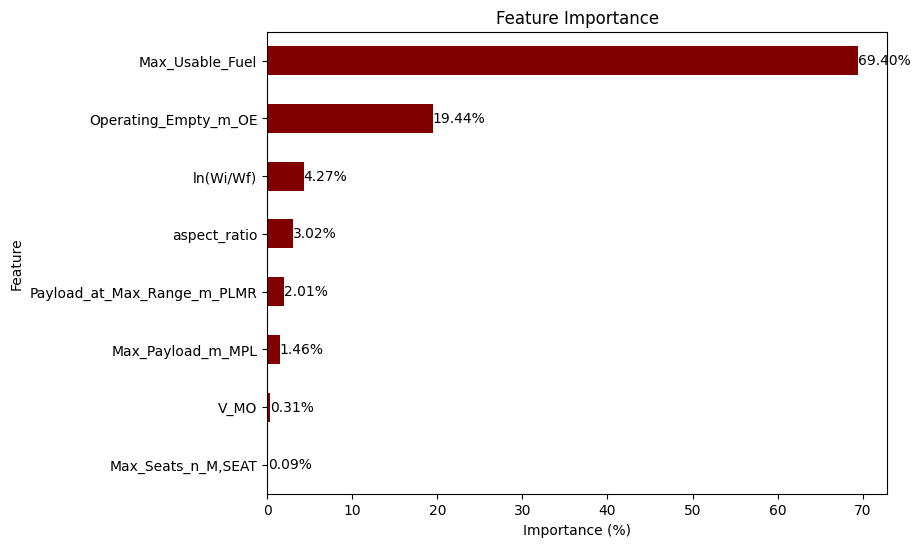

In [1013]:
XGboostModel_1.feature_importance(importance_type='total_gain')

#### <font style="color: #F4128A;"> <strong>Model Predictions</strong></font>

In [1024]:
#Model Load
rf_breg_model = pickle.load(open('Model & Results/Breguets_Range/Breguet_Range_RF.pkl', 'rb'))
cnn_breg_model = load_model('Model & Results/Breguets_Range/CNN_Model')

In [998]:
engine_param = [
    { 
        'Model': 'A310-300', 
        'Engine_Model': 'CF6-80C2A8', #We have them in our database
        'Engine_Type': 1,
        'BPR': '5.1', 
        'Number_of_spools': '2', 
        'Fan_Diameter_m': '2.36', 
        'Dry_Mass_Kg': '4300',
        'SFC_Cruise_kg_s_N': 0.15849, 

    },

    {
        'Model': 'A340-200',  
        'Engine_Model': 'CFM56-5C2/F', #We have them in our database
        'Engine_Type': 1, 
        'BPR': '6.6', 
        'Number_of_spools': '2', 
        'Fan_Diameter_m': '1.84', 
        'Dry_Mass_Kg': '2644',
        'SFC_Cruise_kg_s_N': 0.15315, 

    },

    {
        'Model': 'A340-600',
        'Engine_Model': 'RB211 Trent 560A2-61', #Have to be predicted
        'Engine_Type': 1,
        'BPR': '7.3', 
        'Number_of_spools': '3', 
        'Fan_Diameter_m': '7.3', 
        'Dry_Mass_Kg': '4990',
        'SFC_Cruise_kg_s_N': 0.53, #Estimated online

    },

    {
        'Model': 'B737-200',
        'Engine_Model': 'JT8D-17', #Available in dataset
        'Engine_Type': 1,
        'BPR': '', 
        'Number_of_spools': '', 
        'Fan_Diameter_m': '', 
        'Dry_Mass_Kg': '',
        'SFC_Cruise_kg_s_N': 0.22874, 

    },


    {
        'Model': 'B707-100',
        'Engine_Model': 'JT3C-4', #Available in dataset
        'Engine_Type': 1,
        'BPR': '', 
        'Number_of_spools': '', 
        'Fan_Diameter_m': '', 
        'Dry_Mass_Kg': '',
        'SFC_Cruise_kg_s_N': 1.3, 

    }


]






aircraft_param = [
    {
        'Model': 'A310-300',
        'aspect_ratio': 8.79, 
        'Max_Usable_Fuel': 61070, 
        'V_MO': 667, 
        'Operating_Empty_m_OE': 81000, #MZFW - Estimated Payload (113,000 - 32000)
        'Max_Payload_m_MPL': 32000, #Wikipedia
        'Payload_at_Max_Range_m_PLMR': 15000, #Estimated 
        'ln(Wi/Wf)': 0.198,
        'Max_Seats_n_M,SEAT': 280,
        'Range': 9538
    },

    {
        'Model': 'A340-200',
        'aspect_ratio': 10.06, 
        'Max_Usable_Fuel': 138638,
        'V_MO': 611,
        'Operating_Empty_m_OE': 126000,
        'Max_Payload_m_MPL': 63000,
        'Payload_at_Max_Range_m_PLMR': 51000, 
        'ln(Wi/Wf)': 0.336,
        'Max_Seats_n_M,SEAT': 420, 
        'Range': 12404 #according to payload-range
    },


     {
        'Model': 'A340-600',
        'aspect_ratio': 9.17, 
        'Max_Usable_Fuel': 194300, 
        'V_MO': 611, 
        'Operating_Empty_m_OE': 216600, #Estimated using other values
        'Max_Payload_m_MPL': 34400, #Estimated using other values
        'Payload_at_Max_Range_m_PLMR': 36000,
        'ln(Wi/Wf)': 0.355,
        'Max_Seats_n_M,SEAT': 475,
        'Range': 14647 #Similar result in payload-range
    },

     {
        'Model': 'B737-200',
        'aspect_ratio': 8.8, 
        'Max_Usable_Fuel': 22600, 
        'V_MO': 648, 
        'Operating_Empty_m_OE': 27448,
        'Max_Payload_m_MPL': 24942, #Estiamted through calculations
        'Payload_at_Max_Range_m_PLMR': 13600,
        'ln(Wi/Wf)': 0.179,
        'Max_Seats_n_M,SEAT': 136,
        'Range': 2222 
    },

    {
        'Model': 'B707-100',
        'aspect_ratio': 7.04, 
        'Max_Usable_Fuel': 51050, 
        'V_MO': 646,  
        'Operating_Empty_m_OE': 55589,
        'Max_Payload_m_MPL': 60986,
        'Payload_at_Max_Range_m_PLMR': 20000,  # Needs estimation
        'ln(Wi/Wf)': 0.297,
        'Max_Seats_n_M,SEAT': 179,
        'Range': 6537
}
    
]
aircraft_pred_param = pd.DataFrame(aircraft_param)
engine_pred_param = pd.DataFrame(engine_param)

In [999]:
aircraft_pred_param = aircraft_pred_param.merge(engine_pred_param[['Model', 'Engine_Type', 'SFC_Cruise_kg_s_N']], on='Model', how='left')
aircraft_pred_param

eng_col = aircraft_pred_param.pop('Engine_Type')
aircraft_pred_param.insert(1, 'Engine_Type', eng_col)

sfc_col = aircraft_pred_param.pop('SFC_Cruise_kg_s_N')
aircraft_pred_param.insert(2, 'SFC_Cruise_kg_s_N', sfc_col)
aircraft_pred_param


Model  Engine_Type  SFC_Cruise_kg_s_N  aspect_ratio  Max_Usable_Fuel  \
0  A310-300            1            0.15849          8.79            61070   
1  A340-200            1            0.15315         10.06           138638   
2  A340-600            1            0.53000          9.17           194300   
3  B737-200            1            0.22874          8.80            22600   
4  B707-100            1            1.30000          7.04            51050   

   V_MO  Operating_Empty_m_OE  Max_Payload_m_MPL  Payload_at_Max_Range_m_PLMR  \
0   667                 81000              32000                        15000   
1   611                126000              63000                        51000   
2   611                216600              34400                        36000   
3   648                 27448              24942                        13600   
4   646                 55589              60986                        20000   

   ln(Wi/Wf)  Max_Seats_n_M,SEAT  Range  
0      0.198                 280   9538  
1      0.336                 420  12404  
2      0.355                 475  14647  
3      0.179                 136   2222  
4      0.297                 179   6537

##### <font style="color: #0BDE21;"> <strong>Random Forest</strong></font>

In [1000]:
rf_features = ['aspect_ratio', 'Max_Usable_Fuel', 'V_MO', 'Operating_Empty_m_OE', 'Max_Payload_m_MPL', 'Payload_at_Max_Range_m_PLMR', 'ln(Wi/Wf)', 'Max_Seats_n_M,SEAT']
cnn_features = ['Engine_Type', 'SFC_Cruise_kg_s_N', 'aspect_ratio', 'Max_Usable_Fuel', 'V_MO', 'Operating_Empty_m_OE', 'Max_Payload_m_MPL', 'Payload_at_Max_Range_m_PLMR', 'ln(Wi/Wf)', 'Max_Seats_n_M,SEAT']
target = 'Max_Range_R_PLMR'

#We use the same xscalar and yscalar which we used for training dataset
X_train_pred_cnn, X_test_pred_cnn, y_train_pred_cnn, y_test_pred_cnn, x_scalar_value_pred_cnn, y_scalar_value_pred_cnn = prep_model_data(range_eq_para, cnn_features, target, 0.15, 42, model_type='cnn')
X_train_pred_rf, X_test_pred_rf, y_train_pred_rf, y_test_pred_rf, x_scalar_value_pred_rf, y_scalar_value_pred_rf = prep_model_data(range_eq_para, rf_features, target, 0.15, 42, model_type='rf_reg')


Input training size: (45, 10)
 Input test size: (8, 10)
 Labels for training size: (45,)
 Labels for testing size: (8,)
Reshaped training size: (45, 10, 1)
Reshaped test size: (8, 10, 1)
Input training size: (45, 8)
 Input test size: (8, 8)
 Labels for training size: (45,)
 Labels for testing size: (8,)


In [1001]:
#Extract aircraft parameters
aircraft_pred_param_ref = aircraft_pred_param.copy()

aircraft_param_info = aircraft_pred_param_ref[['Model', 'Range']]
aircraft_param = aircraft_pred_param_ref[rf_features]

#Standardize values
aircraft_param_standardized = x_scalar_value_pred_rf.fit_transform(aircraft_param)
#Make prediction
rf_breg_pred = rf_regressor.predict(aircraft_param_standardized)

#Convert into original ouput
rf_breg_pred = rf_breg_pred.reshape(-1, 1)
rf_breg_pred_actual = y_scalar_value_pred_rf.inverse_transform(rf_breg_pred)
rf_breg_pred_actual


# Create a DataFrame from the predicted actual values
predicted_df = pd.DataFrame(rf_breg_pred_actual, columns=['Predicted_Range'])

# Join the predicted values with the original DataFrame that includes aircraft names and original ranges
aircraft_breg_results_comparison = aircraft_param_info.join(predicted_df)

# Print the result
print(aircraft_breg_results_comparison)


      Model  Range  Predicted_Range
0  A310-300   9538      8304.904759
1  A340-200  12404     11767.753234
2  A340-600  14647     10003.222491
3  B737-200   2222      3017.290094
4  B707-100   6537      9525.017417


In [1002]:
print(f"Mean Absolute Error: {mean_absolute_error(aircraft_breg_results_comparison['Range'], aircraft_breg_results_comparison['Predicted_Range'])}\n"
      f"Root Mean Squared Error: {mean_squared_error(aircraft_breg_results_comparison['Range'], aircraft_breg_results_comparison['Predicted_Range'], squared=False)}\n"
      f"R^2 Score: {r2_score(aircraft_breg_results_comparison['Range'], aircraft_breg_results_comparison['Predicted_Range'])}")


Mean Absolute Error: 2059.2854052571442
Root Mean Squared Error: 2571.0207229049743
R^2 Score: 0.6548178996287619


##### <font style="color: #0BDE21;"> <strong>CNN</strong></font>

In [1003]:
#Extract aircraft parameters
aircraft_pred_param_cnn = aircraft_pred_param.copy()

aircraft_param_info = aircraft_pred_param_cnn[['Model', 'Range']]
aircraft_param = aircraft_pred_param_cnn[cnn_features]

cnn_aircraft_param_standardized = x_scalar_value_pred_cnn.fit_transform(aircraft_param)

In [1004]:
cnn_model_breg_pred = cnn_breg_model.predict(cnn_aircraft_param_standardized)
predictions_inverse_transformed = y_scalar_value_pred_cnn.inverse_transform(cnn_model_breg_pred)
predicted_df['Predicted_Range'] = predictions_inverse_transformed


# Join the predicted values with the original DataFrame that includes aircraft names and original ranges
aircraft_breg_cnn_results_comparison = aircraft_param_info.join(predicted_df)

# Print the result
print(aircraft_breg_cnn_results_comparison)

1/1 [==============================] - 0s 234ms/step
      Model  Range  Predicted_Range
0  A310-300   9538      4118.024414
1  A340-200  12404      8377.049805
2  A340-600  14647      9754.788086
3  B737-200   2222      3666.025146
4  B707-100   6537      8376.833984


In [174]:
print(f"Mean Absolute Error: {mean_absolute_error(aircraft_breg_cnn_results_comparison['Range'], aircraft_breg_cnn_results_comparison['Predicted_Range'])}\n"
      f"Root Mean Squared Error: {mean_squared_error(aircraft_breg_cnn_results_comparison['Range'], aircraft_breg_cnn_results_comparison['Predicted_Range'], squared=False)}\n"
      f"R^2 Score: {r2_score(aircraft_breg_cnn_results_comparison['Range'], aircraft_breg_cnn_results_comparison['Predicted_Range'])}")


Mean Absolute Error: 2336.77294921875
Root Mean Squared Error: 2721.846559255831
R^2 Score: 0.6131305908443588


## <font color=#F4AC12>**Reverse Prediction**</font>

<ul style="color: #0BDE21;">
    <li> Incease dataset using dataaugmentation. Just create a new dataset</li>
    <li> Try to create a reverse model or a model that predicts numerous features based on certain output features. 
    <li> Check the following links: https://www.reddit.com/r/learnmachinelearning/comments/nr0llt/using_machine_learning_algorithm_to_predict_input/</li>
    <li> We have two methods GAN, Autoencoders, and Boltzmann Machines. Check how they're used in aircraft design </li>
    <li> There are also Generative Bayesian Networks </li>
</ul>

<p style="color: #F4128A;"> Links to understand GANs & CTGANs</p>

<ul style="color: #F4128A;">
    <li><a href="https://www.youtube.com/watch?v=8L11aMN5KY8">A Friendly Introduction to Generative Adversarial Networks (GANs)</a> </li>
    <li><a href="https://www.youtube.com/watch?v=HIusawrGBN4">What is Synthetic Data? No, It's Not "Fake" Data</a> </li>
    <li><a href="https://www.youtube.com/watch?v=_qB4B6ttXk8">GANs explained | Generative Adversarial Networks video with showcase!</a> </li>
    <li><a href="https://www.youtube.com/watch?v=MZmNxvLDdV0">What Are GANs? | Generative Adversarial Networks Tutorial | Deep Learning Tutorial</a> </li>
    <li><a href="https://www.youtube.com/watch?v=Gib_kiXgnvA">The Math Behind Generative Adversarial Networks Clearly Explained!</a> </li>
    <li><a href="https://www.youtube.com/watch?v=W5NPlZzebO0&t=624s">Conditional GANs and their applications</a> </li>
    <li><a href="https://www.youtube.com/watch?v=Ei0klF38CNs&t=320s">Synthetic data generation with CTGAN</a> </li>

</ul>

#### <font style="color: #F4128A;"> <strong>Data Pipeline</strong></font>

In [2]:
# Load the range parameters dataset and drop unwanted columns
range_eq_para = pd.read_excel('Results/Breguets_Range/Range_Dataset.xlsx')
range_eq_para.drop(columns=['Unnamed: 0', 'SFC_Cruise_kg_s_N'], inplace=True)

# Load the SFC predictions dataset and drop unwanted columns
sfc_pred_breg_range = pd.read_excel('Results/Breguets_Range/SFC_Predictions_TurboFan_BregRange_Dataset.xlsx')
sfc_pred_breg_range.drop(columns=['Unnamed: 0'], inplace=True)

range_eq_para = range_eq_para.merge(sfc_pred_breg_range[['Aircraft_Type', 'Engine_Model', 'Engine_Type', 'SFC_Cruise_kg_s_N']], 
                                    on=['Aircraft_Type', 'Engine_Model', 'Engine_Type'], how='left')



col = range_eq_para.pop('SFC_Cruise_kg_s_N')
range_eq_para.insert(3, 'SFC_Cruise_kg_s_N', col)

range_eq_para = range_eq_para.drop_duplicates()
range_eq_para = range_eq_para.reset_index(drop=True)
range_eq_para

Aircraft_Type Engine_Model Engine_Type  SFC_Cruise_kg_s_N  Total_Engines  \
0       A220-300      PW1521G    Turbofan           0.078478              2   
1        A319ceo    CFM56-5A5    Turbofan           0.167480              2   
2        A319neo    LEAP-1A26    Turbofan           0.075108              2   
3        A320ceo    CFM56-5B4    Turbofan           0.153150              2   
4        A320neo    LEAP-1A29    Turbofan           0.075108              2   
..           ...          ...         ...                ...            ...   
58     Fokker 50       PW125B   Turboprop                NaN              2   
59    Fokker 100   Tay 650-15    Turbofan           0.083120              2   
60      Saab 340    GE CT7-9B   Turboprop                NaN              2   
61  Superjet 100       SaM146    Turbofan           0.176760              2   
62    Twin Otter      PT6A-34   Turboprop                NaN              2   

    aspect_ratio  Max_Usable_Fuel     V_MO  Max_Pax_R_M  Operating_Empty_m_OE  \
0      10.970703            21381  905.628   4988.96640                 43500   
1      10.470915            15609  903.776   4828.03200                 35400   
2      10.470915            15477  903.776   5632.70400                 39600   
3      10.470915            15609  903.776   4586.63040                 43500   
4      10.470915            15609  903.776   5069.43360                 45800   
..           ...              ...      ...          ...                   ...   
58     12.014286             5136  564.860   1480.59648                 13400   
59      8.433010            13365  855.624   2558.85696                 24747   
60     11.952911             3220  524.116    756.39168                  8620   
61      9.222434            15805  903.776   2647.37088                 25100   
62     10.057307             1446  346.324          NaN                  3377   

    Max_Payload_m_MPL  Payload_at_Max_Range_m_PLMR  ln(Wi/Wf)  \
0             12300.0                       6350.0   0.187129   
1             23100.0                       9800.0   0.188966   
2             20700.0                      11000.0   0.166813   
3             19000.0                      13000.0   0.167054   
4             18500.0                      12000.0   0.158803   
..                ...                          ...        ...   
58             5500.0                       3300.0   0.038683   
59            11993.0                       9200.0   0.137750   
60             3400.0                       2450.0   0.050887   
61            12245.0                          NaN   0.112457   
62                NaN                       1030.0   0.016180   

    Max_Seats_n_M,SEAT  Std_Layout_n_SEAT  Max_Range_R_PLMR  
0                  149                140       5391.302400  
1                  160                156       6356.908800  
2                  160                156       6920.179200  
3                  180                170       5310.835200  
4                  194                180       6437.376000  
..                 ...                ...               ...  
58                  62                 50       2768.071680  
59                 109                100       2768.071680  
60                  37                 34       1963.399680  
61                 108                 98       3048.000000  
62                  19                 19       1129.759488  

[63 rows x 16 columns]

In [3]:
range_eq_para = range_eq_para.drop(columns=['Aircraft_Type', 'Engine_Model', 'Engine_Type', 'SFC_Cruise_kg_s_N', 'Total_Engines'])
range_eq_para

aspect_ratio  Max_Usable_Fuel     V_MO  Max_Pax_R_M  Operating_Empty_m_OE  \
0      10.970703            21381  905.628   4988.96640                 43500   
1      10.470915            15609  903.776   4828.03200                 35400   
2      10.470915            15477  903.776   5632.70400                 39600   
3      10.470915            15609  903.776   4586.63040                 43500   
4      10.470915            15609  903.776   5069.43360                 45800   
..           ...              ...      ...          ...                   ...   
58     12.014286             5136  564.860   1480.59648                 13400   
59      8.433010            13365  855.624   2558.85696                 24747   
60     11.952911             3220  524.116    756.39168                  8620   
61      9.222434            15805  903.776   2647.37088                 25100   
62     10.057307             1446  346.324          NaN                  3377   

    Max_Payload_m_MPL  Payload_at_Max_Range_m_PLMR  ln(Wi/Wf)  \
0             12300.0                       6350.0   0.187129   
1             23100.0                       9800.0   0.188966   
2             20700.0                      11000.0   0.166813   
3             19000.0                      13000.0   0.167054   
4             18500.0                      12000.0   0.158803   
..                ...                          ...        ...   
58             5500.0                       3300.0   0.038683   
59            11993.0                       9200.0   0.137750   
60             3400.0                       2450.0   0.050887   
61            12245.0                          NaN   0.112457   
62                NaN                       1030.0   0.016180   

    Max_Seats_n_M,SEAT  Std_Layout_n_SEAT  Max_Range_R_PLMR  
0                  149                140       5391.302400  
1                  160                156       6356.908800  
2                  160                156       6920.179200  
3                  180                170       5310.835200  
4                  194                180       6437.376000  
..                 ...                ...               ...  
58                  62                 50       2768.071680  
59                 109                100       2768.071680  
60                  37                 34       1963.399680  
61                 108                 98       3048.000000  
62                  19                 19       1129.759488  

[63 rows x 11 columns]

In [4]:
range_eq_para.dropna(how='any', inplace=True)
range_eq_para.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, 0 to 60
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   aspect_ratio                 53 non-null     float64
 1   Max_Usable_Fuel              53 non-null     int64  
 2   V_MO                         53 non-null     float64
 3   Max_Pax_R_M                  53 non-null     float64
 4   Operating_Empty_m_OE         53 non-null     int64  
 5   Max_Payload_m_MPL            53 non-null     float64
 6   Payload_at_Max_Range_m_PLMR  53 non-null     float64
 7   ln(Wi/Wf)                    53 non-null     float64
 8   Max_Seats_n_M,SEAT           53 non-null     int64  
 9   Std_Layout_n_SEAT            53 non-null     int64  
 10  Max_Range_R_PLMR             53 non-null     float64
dtypes: float64(7), int64(4)
memory usage: 5.0 KB


In [5]:
range_eq_para

aspect_ratio  Max_Usable_Fuel      V_MO   Max_Pax_R_M  \
0      10.970703            21381   905.628   4988.966400   
1      10.470915            15609   903.776   4828.032000   
2      10.470915            15477   903.776   5632.704000   
3      10.470915            15609   903.776   4586.630400   
4      10.470915            15609   903.776   5069.433600   
5      10.470915            15500   903.776   4747.564800   
6      10.470915            15380   903.776   5793.638400   
7      29.706618           139090  1061.196  11587.276800   
8      10.055559           139090  1061.196   9897.465600   
9      11.327434           139090  1061.196  11024.006400   
10     11.594476           140795  1098.236  12874.752000   
11      9.464024           158791  1098.236  13357.555200   
12      7.526701           324339  1098.236  12874.752000   
20      8.706061            14758   911.184   3299.155200   
21      9.161406            23827   911.184   4506.163200   
22      9.161406            23827   911.184   4264.761600   
23      9.161406            23827   911.184   4747.564800   
24     10.280290            26022   911.184   5954.572800   
25     10.280290            26022   911.184   5471.769600   
26     10.280290            26022   911.184   4586.630400   
27     10.280290            29666   911.184   6115.507200   
28     10.159420            25817   911.184   5954.572800   
29      7.813624            42680   950.076   6678.777600   
30      9.609283            22129   926.000   3299.155200   
31      9.609283            22126   911.184   3862.425600   
32      7.909550           215991  1018.600  11506.809600   
33      7.909550           240196  1018.600  12794.284800   
34      7.987663            63216   955.632   6276.441600   
35      7.987663            91380   955.632   9816.998400   
36      8.678039           117300   966.744   8046.720000   
37      8.678039           171100   966.744  12552.883200   
38      9.815428           181283   988.968  10299.801600   
39      9.587306           126206   998.228  12552.883200   
40      9.587306           126356   998.228  13035.686400   
41     10.026115           126356   998.228  10782.604800   
42      8.263896             8082   938.964   2945.099520   
43      7.655608            10989   938.964   3186.501120   
44      7.599516            10861   938.964   3196.157184   
45     12.351943             5703   550.044   1448.409600   
46     13.411852             5703   579.676   2092.147200   
47     12.782250             6526   688.944   2301.361920   
48      9.922607             3312   605.604   1367.942400   
49      7.846846             5146   872.292   1947.306240   
50      7.846846             6396   872.292   2687.604480   
51      8.616647             7438   872.292   3218.688000   
52      9.295930            11625   822.288   3218.688000   
53     11.287438            11625   822.288   3057.753600   
54      8.917172            16029  1013.044   3379.622400   
55      8.917172            16029  1013.044   3170.407680   
56      7.711792             2468   703.760   3118.908672   
58     12.014286             5136   564.860   1480.596480   
59      8.433010            13365   855.624   2558.856960   
60     11.952911             3220   524.116    756.391680   

    Operating_Empty_m_OE  Max_Payload_m_MPL  Payload_at_Max_Range_m_PLMR  \
0                  43500            12300.0                     6350.000   
1                  35400            23100.0                     9800.000   
2                  39600            20700.0                    11000.000   
3                  43500            19000.0                    13000.000   
4                  45800            18500.0                    12000.000   
5                  47500            26300.0                    20000.000   
6                  46600            29000.0                    22000.000   
7                 124000            46000.0                    42000.000   
8                 129000 

In [6]:
range_eq_para.shape

(53, 11)

In [7]:
discrete_data = []
continiuous_data = [range_eq_para.columns]

In [8]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=range_eq_para)


#### <font style="color: #F4128A;"> <strong>Model Training & Analytics</strong></font>

In [30]:
ctgan_synthesizer = CTGANSynthesizer(
    metadata=metadata,
    epochs=5000,
    verbose=True)

ctgan_synthesizer.fit(range_eq_para)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sdv/single_table/base.py:97: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.

Gen. (-0.43) | Discrim. (-0.13): 100%|██████████| 5000/5000 [06:24<00:00, 13.01it/s]


In [44]:
#ctgan_synthesizer.save(filepath='Model & Results/Breguets_Range/CTGAN_Model.pkl')

In [9]:
ctgan_synthesizer = CTGANSynthesizer.load(
    filepath='Model & Results/Breguets_Range/CTGAN_Model.pkl'
)

In [13]:
fig = ctgan_synthesizer.get_loss_values_plot()
fig.show()

In [10]:
synthetic_data = ctgan_synthesizer.sample(53)
synthetic_data

aspect_ratio  Max_Usable_Fuel         V_MO   Max_Pax_R_M  \
0       9.954723            11020   924.413921   2824.877258   
1       9.893325            17104   903.192651   4579.485365   
2       8.685235            19296   946.439931   3119.881407   
3       9.297679           137105   992.398006  11822.651500   
4       8.057064           208992   989.418252  10997.828629   
5      10.752336             2468   710.323275   2366.780436   
6       8.757840           167062  1031.796950   9364.775616   
7      11.123677             4643   656.782671   2896.922965   
8      11.713184             2468   676.734578   1460.120790   
9      10.942796            23851   730.567008   6099.640689   
10     11.521646             2468   728.490769   2625.630423   
11      7.526701           140526   997.695108  11098.758065   
12      8.641509            21859   906.228248   3937.300046   
13      7.558164            14938   922.966993   2491.764608   
14     11.115947            15712   628.495134   3274.353035   
15     11.806266             2877   740.621183   1910.378867   
16     10.041825           140664  1028.609544   4676.671685   
17      9.718447            19075   921.767745   5146.281310   
18      8.741840            18476   926.498318   4440.031406   
19      8.633624            27566   941.477421   4365.217531   
20      8.109212            19258   932.152188   4779.743318   
21      9.169760            11086   662.273454   3389.377856   
22     11.656038             2468   767.740806   1272.001611   
23      8.931904            21178   974.596672   5868.167893   
24      9.947383            19684   926.433032   4612.085477   
25      8.157926            15557   937.884755   3096.525286   
26      8.876201            26123   925.382563   5405.455759   
27      7.526701            24400   923.884791   2654.911811   
28      9.821164            24908   873.017867   5315.425210   
29      9.078852            18923   928.546440   3923.926186   
30     11.495905             8374   716.101391   3029.928291   
31      8.523460            10071   875.023905   3576.765104   
32      8.852180            25660   922.128014   4618.751225   
33      9.688430           171930  1098.236000  11783.808280   
34      8.084661            19113   897.973321   3543.899525   
35      9.089587           137275   977.794206  10032.124351   
36      9.364069             3978   639.277328   2698.863403   
37      9.194704            22674   916.430493   3796.299581   
38      9.469931            30676   963.951853   5313.170118   
39      9.144861            31958   990.695310   5780.835745   
40     19.065001            97419  1068.534366   4640.844255   
41     10.390913            22170   887.013366   5749.843163   
42      8.839859            22662   965.570035   3626.432817   
43      9.051984            24612   919.271898   4659.490985   
44      8.493479            23587   931.870426   4531.461501   
45      7.526701            16134   937.032643   3285.849342   
46      9.803182            15237   930.162793   1636.584356   
47      8.849589           138039  1045.794917  12840.537846   
48      9.439389            14653   944.823233   4573.886730   
49      8.505495            26288   946.674642   4279.129559   
50      7.526701            28426   925.654478   3098.681001   
51     10.500633           186895  1096.531964  12390.592638   
52      8.340118            18857   921.483873   5149.181391   

    Operating_Empty_m_OE  Max_Payload_m_MPL  Payload_at_Max_Range_m_PLMR  \
0                  57312             8491.0                     4425.129   
1                  32448            18599.0                    15581.230   
2                  55267            15497.0                     8738.135   
3                 106208            76390.0                    16459.247   
4                 100051            17750.0                    25109.207   
5                   3356            12619.0                     8213.370   
6              

In [15]:
# 1. perform basic validity checks
diagnostic = run_diagnostic(range_eq_para, synthetic_data, metadata)

# 2. measure the statistical similarity
quality_report = evaluate_quality(range_eq_para, synthetic_data, metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 11/11 [00:00<00:00, 1089.97it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 131.84it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 11/11 [00:00<00:00, 867.44it/s]|
Column Shapes Score: 80.79%

(2/2) Evaluating Column Pair Trends: |██████████| 55/55 [00:00<00:00, 115.35it/s]|
Column Pair Trends Score: 92.59%

Overall Score (Average): 86.69%



<p style="color: #C837A0;"> The data validity score checks the validity of the synthetic data and its structure compared to the real data. This includes simple checks for data integrity, such as whether the synthetic data matches the original in terms of valid values and general structure. It insure checks the validity of columns such as primary keys, continuous values and discrete values. It also checks whether the real and synthetic data have same column names. Having a 100% score means that that all values in the synthetic data are valid and adhere to the expected data types and constraints</p> 


<p style="color: #C837A0;"> The <b>evaluation quality</b> tells how similar is the synthetic data to the real data. It focuses on evaluating how well the distributions of individual columns and the relationships between column pairs are replicated in the synthetic data.</p>


<ul>
  <li><b style="color: #C837A0;">Column Shapes Score: 84.29%</b>:
    <ul style="color: #C837A0;">
      <li><b>What it means</b>: This score assesses how well the distributions (shapes) of individual columns in the synthetic data match the distributions in the original data. It evaluates whether the model has learned the shape of the distributions for continuous and categorical variables.</li>
      <li><b style="color: #C837A0;">Interpretation</b>:
        <ul>
          <li>A score of 84.29% means that the synthetic data captures the general shapes of most columns well, but there might be some differences in the exact distributions. For example:</li>
          <ul>
            <li>Some continuous variables might have different ranges, means, or variances.</li>
            <li>Categorical variables may have slightly different proportions compared to the original dataset.</li>
          </ul>
        </ul>
      </li>
    </ul>
  </li>

  <li><b style="color: #C837A0;">Column Pair Trends Score: 97.08%</b>:
    <ul style="color: #C837A0;">
      <li><b style="color: #C837A0;">What it means</b>: This score measures how well the relationships between pairs of columns (i.e., correlations and dependencies) are preserved in the synthetic data. It checks whether the model has captured the trends between column pairs (e.g., if an increase in one column value correlates with an increase or decrease in another).</li>
      <li><b style="color: #C837A0;">Interpretation</b>:
        <ul>
          <li>A score of 97.08% is quite high, meaning that the pairwise relationships between columns in the synthetic data closely resemble those in the real data.</li>
          <li>However, there may be some minor deviations in the exact correlations.</li>
        </ul>
      </li>
    </ul>
  </li>

  <li><b style="color: #C837A0;">Overall Score (90.69%)</b>:
    <ul style="color: #C837A0;">
      <li><b style="color: #C837A0;">What it means</b>: This is the average of the Column Shapes Score and the Column Pair Trends Score. An overall score of 90.69% is generally considered good, as it indicates that the synthetic data is statistically similar to the real data, though there may be slight deviations in some distributions.</li>
      <li><b style="color: #C837A0;">Interpretation</b>:
        <ul>
          <li>With a score of ~90%, you can be confident that the synthetic data you’ve generated closely matches the real dataset in terms of both individual distributions and column relationships.</li>
          <li>However, there may be slight room for improvement, particularly in capturing the exact shapes of some columns.</li>
        </ul>
      </li>
    </ul>
  </li>
</ul>


In [16]:
diagnostic.get_details(property_name='Data Validity')


Column             Metric  Score
0                  aspect_ratio  BoundaryAdherence    1.0
1               Max_Usable_Fuel  BoundaryAdherence    1.0
2                          V_MO  BoundaryAdherence    1.0
3                   Max_Pax_R_M  BoundaryAdherence    1.0
4          Operating_Empty_m_OE  BoundaryAdherence    1.0
5             Max_Payload_m_MPL  BoundaryAdherence    1.0
6   Payload_at_Max_Range_m_PLMR  BoundaryAdherence    1.0
7                     ln(Wi/Wf)  BoundaryAdherence    1.0
8            Max_Seats_n_M,SEAT  BoundaryAdherence    1.0
9             Std_Layout_n_SEAT  BoundaryAdherence    1.0
10             Max_Range_R_PLMR  BoundaryAdherence    1.0

<ul>
  <li><b style="color: #C837A0;">Data Validity: Boundary Adherence Scores</b>:
    <ul style="color: #C837A0;">
      <li><b style="color: #C837A0;">What it means</b>: This property checks whether the synthetic data adheres to the valid boundaries of the original data. For continuous variables, it ensures that the generated values fall within the minimum and maximum values observed in the original data. For categorical variables, it checks whether all the categories in the synthetic data are valid according to the categories in the original data.</li>
      <li><b style="color: #C837A0;">Interpretation</b>:
        <ul style="color: #C837A0;"> 
          <li>A score of <b style="color: #C837A0;">1.0</b> for each feature indicates perfect adherence to the boundaries of the original dataset. This means that the synthetic values generated for the column fall within the valid range defined by the real dataset.</li>
          <ul>
            <li>For example, <b style="color: #C837A0;">aspect_ratio</b> with a score of 1.0 means that all generated values for <b style="color: #C837A0;">aspect_ratio</b> are within the original min and max values.</li>
            <li>Similarly, <b style="color: #C837A0;">Max_Usable_Fuel</b> having a score of 1.0 means that the synthetic values generated for <b style="color: #C837A0;">Max_Usable_Fuel</b> adhere to the original data’s boundaries.</li>
          </ul>
        </ul>
      </li>
      <li><b style="color: #C837A0;">Score Details</b>:
        <ul>
          <li>All columns have a score of <b style="color: #C837A0;">1.0</b>, meaning that the synthetic data perfectly matches the boundary constraints of the original data. No generated values fall outside the expected ranges.</li>
        </ul>
      </li>
    </ul>
  </li>
</ul>


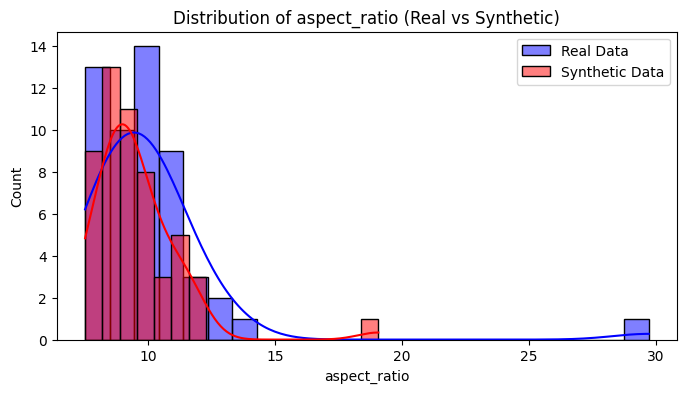

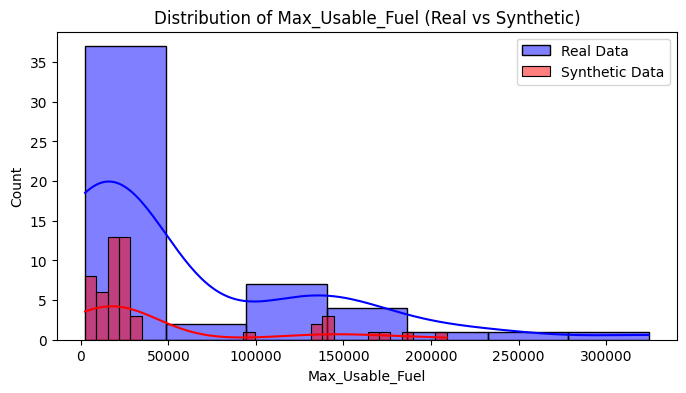

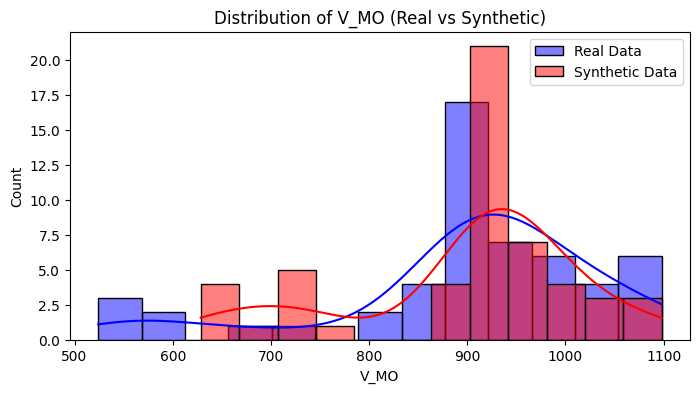

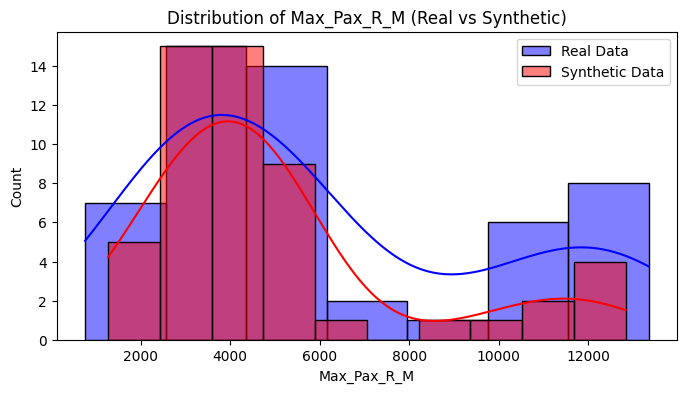

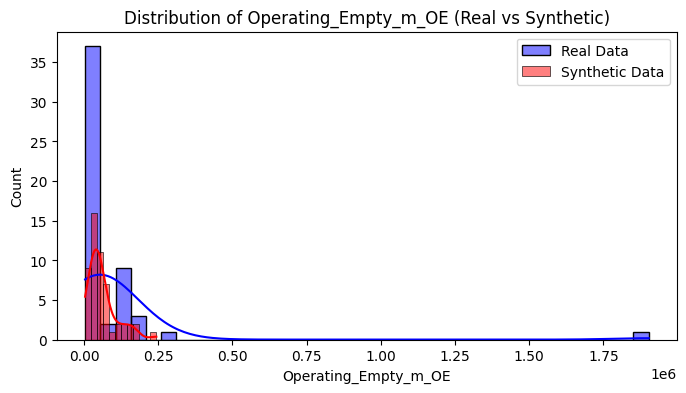

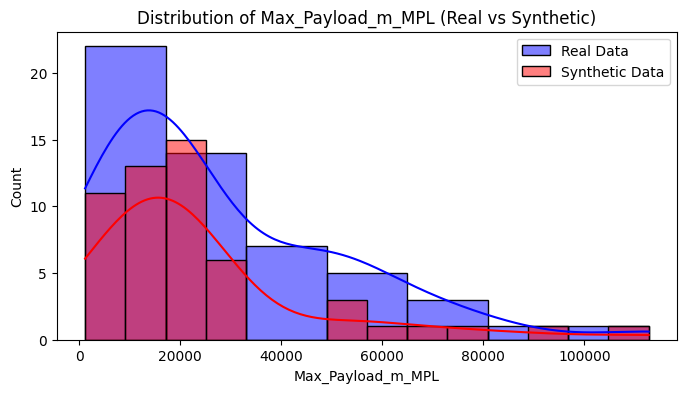

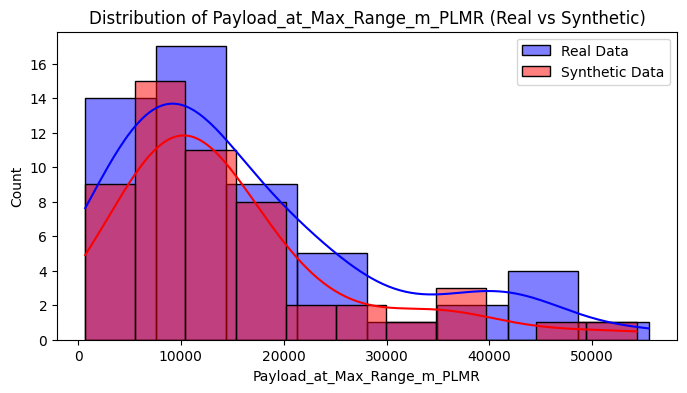

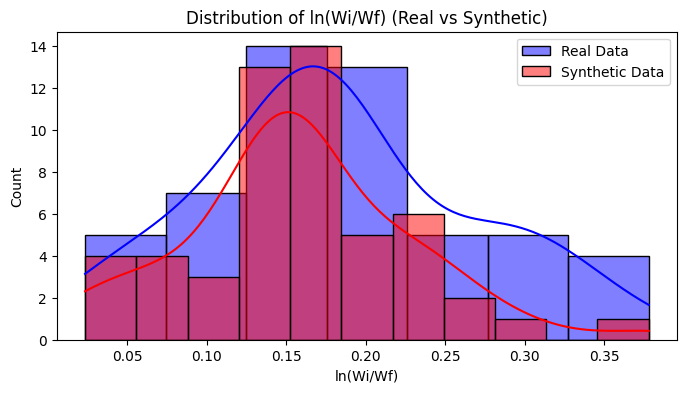

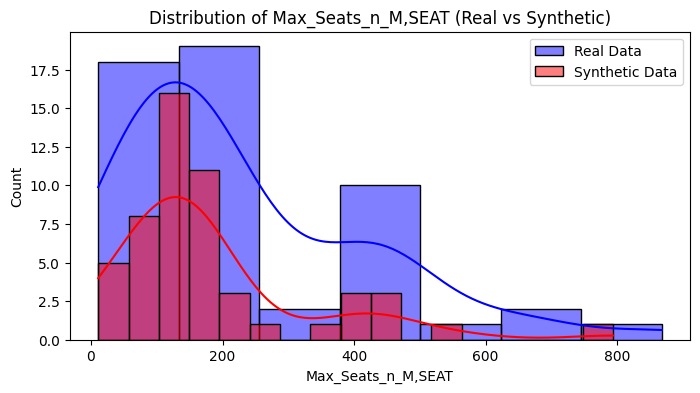

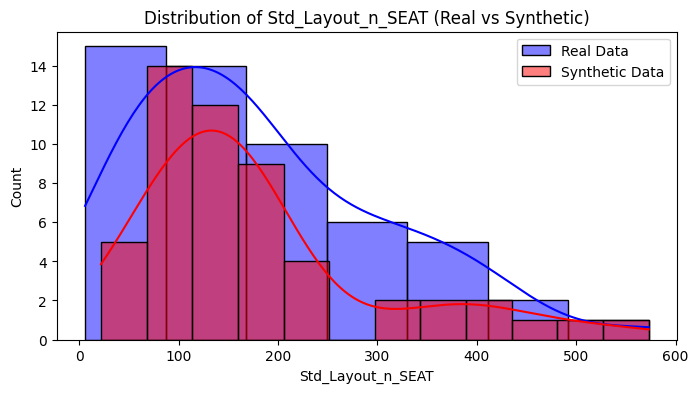

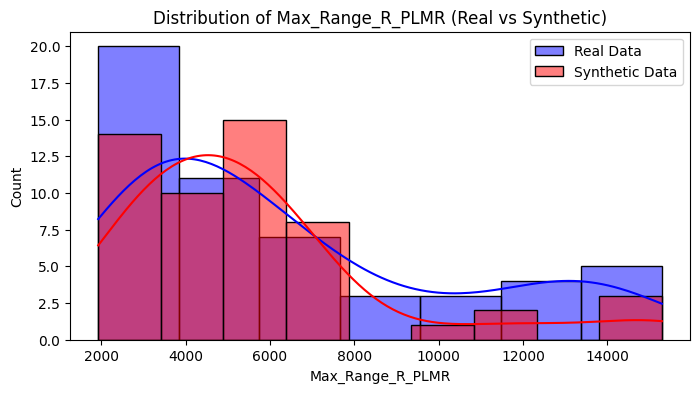

In [17]:
for col in range_eq_para.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(range_eq_para[col], color='blue', label='Real Data', kde=True)
    sns.histplot(synthetic_data[col], color='red', label='Synthetic Data', kde=True)
    plt.title(f"Distribution of {col} (Real vs Synthetic)")
    plt.legend()
    plt.show()


In [18]:
catgan_quality_report = QualityReport()
catgan_quality_report.generate(range_eq_para, synthetic_data, metadata.to_dict())

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 11/11 [00:00<00:00, 800.69it/s]|
Column Shapes Score: 80.79%

(2/2) Evaluating Column Pair Trends: |██████████| 55/55 [00:00<00:00, 141.49it/s]|
Column Pair Trends Score: 92.59%

Overall Score (Average): 86.69%



<p style="color: #C837A0;"> Same results as before</p>

In [19]:
catgan_quality_report.get_score()

0.866876654344455

<p style="color: #C837A0;"> Same results as before</p>

In [20]:
catgan_quality_report.get_properties()

Property     Score
0       Column Shapes  0.807890
1  Column Pair Trends  0.925863

<p style="color: #C837A0;"> Same results as before</p>

In [21]:
catgan_quality_report.get_details(property_name='Column Shapes')

Column        Metric     Score
0                  aspect_ratio  KSComplement  0.811321
1               Max_Usable_Fuel  KSComplement  0.830189
2                          V_MO  KSComplement  0.754717
3                   Max_Pax_R_M  KSComplement  0.792453
4          Operating_Empty_m_OE  KSComplement  0.811321
5             Max_Payload_m_MPL  KSComplement  0.830189
6   Payload_at_Max_Range_m_PLMR  KSComplement  0.867925
7                     ln(Wi/Wf)  KSComplement  0.754717
8            Max_Seats_n_M,SEAT  KSComplement  0.773585
9             Std_Layout_n_SEAT  KSComplement  0.830189
10             Max_Range_R_PLMR  KSComplement  0.830189

In [37]:
catgan_quality_report.get_details(property_name='Column Pair Trends')

Column 1                     Column 2  \
0                  aspect_ratio              Max_Usable_Fuel   
1                  aspect_ratio                         V_MO   
2                  aspect_ratio                  Max_Pax_R_M   
3                  aspect_ratio         Operating_Empty_m_OE   
4                  aspect_ratio            Max_Payload_m_MPL   
5                  aspect_ratio  Payload_at_Max_Range_m_PLMR   
6                  aspect_ratio                    ln(Wi/Wf)   
7                  aspect_ratio           Max_Seats_n_M,SEAT   
8                  aspect_ratio            Std_Layout_n_SEAT   
9                  aspect_ratio             Max_Range_R_PLMR   
10              Max_Usable_Fuel                         V_MO   
11              Max_Usable_Fuel                  Max_Pax_R_M   
12              Max_Usable_Fuel         Operating_Empty_m_OE   
13              Max_Usable_Fuel            Max_Payload_m_MPL   
14              Max_Usable_Fuel  Payload_at_Max_Range_m_PLMR   
15              Max_Usable_Fuel                    ln(Wi/Wf)   
16              Max_Usable_Fuel           Max_Seats_n_M,SEAT   
17              Max_Usable_Fuel            Std_Layout_n_SEAT   
18              Max_Usable_Fuel             Max_Range_R_PLMR   
19                         V_MO                  Max_Pax_R_M   
20                         V_MO         Operating_Empty_m_OE   
21                         V_MO            Max_Payload_m_MPL   
22                         V_MO  Payload_at_Max_Range_m_PLMR   
23                         V_MO                    ln(Wi/Wf)   
24                         V_MO           Max_Seats_n_M,SEAT   
25                         V_MO            Std_Layout_n_SEAT   
26                         V_MO             Max_Range_R_PLMR   
27                  Max_Pax_R_M         Operating_Empty_m_OE   
28                  Max_Pax_R_M            Max_Payload_m_MPL   
29                  Max_Pax_R_M  Payload_at_Max_Range_m_PLMR   
30                  Max_Pax_R_M                    ln(Wi/Wf)   
31                  Max_Pax_R_M           Max_Seats_n_M,SEAT   
32                  Max_Pax_R_M            Std_Layout_n_SEAT   
33                  Max_Pax_R_M             Max_Range_R_PLMR   
34         Operating_Empty_m_OE            Max_Payload_m_MPL   
35         Operating_Empty_m_OE  Payload_at_Max_Range_m_PLMR   
36         Operating_Empty_m_OE                    ln(Wi/Wf)   
37         Operating_Empty_m_OE           Max_Seats_n_M,SEAT   
38         Operating_Empty_m_OE            Std_Layout_n_SEAT   
39         Operating_Empty_m_OE             Max_Range_R_PLMR   
40            Max_Payload_m_MPL  Payload_at_Max_Range_m_PLMR   
41            Max_Payload_m_MPL                    ln(Wi/Wf)   
42            Max_Payload_m_MPL           Max_Seats_n_M,SEAT   
43            Max_Payload_m_MPL            Std_Layout_n_SEAT   
44            Max_Payload_m_MPL             Max_Range_R_PLMR   
45  Payload_at_Max_Range_m_PLMR                    ln(Wi/Wf)   
46  Payload_at_Max_Range_m_PLMR           Max_Seats_n_M,SEAT   
47  Payload_at_Max_Range_m_PLMR            Std_Layout_n_SEAT   
48  Payload_at_Max_Range_m_PLMR             Max_Range_R_PLMR   
49                    ln(Wi/Wf)           Max_Seats_n_M,SEAT   
50                    ln(Wi/Wf)            Std_Layout_n_SEAT   
51                    ln(Wi/Wf)             Max_Range_R_PLMR   
52           Max_Seats_n_M,SEAT            Std_Layout_n_SEAT   
53           Max_Seats_n_M,SEAT             Max_Range_R_PLMR   
54            Std_Layout_n_SEAT             Max_Range_R_PLMR   

                   Metric     Score  Real Correlation  Synthetic Correlation  
0   CorrelationSimilarity  0.932432          0.021440              -0.113697  
1   CorrelationSimilarity  0.829007         -0.079883              -0.421868  
2   CorrelationSimilarity  0.883076          0.097416              -0.136431  
3   CorrelationSimilarity  0.942411          0.072219              -0.042960  
4   CorrelationSimilarity  0.867165        

In [59]:
correlation_dict = {
    ('Aspect Ratio', 'Max Usable Fuel'): 0.932432,
    ('Aspect Ratio', 'V_MO'): 0.829007,
    ('Aspect Ratio', 'Max Passenger Range'): 0.883076,
    ('Aspect Ratio', 'Operating Empty Mass'): 0.942411,
    ('Aspect Ratio', 'Max Payload'): 0.867165,
    ('Aspect Ratio', 'Payload at Max Range'): 0.871572,
    ('Aspect Ratio', 'ln(Wi/Wf)'): 0.867601,
    ('Aspect Ratio', 'Max Seats'): 0.952012,
    ('Aspect Ratio', 'Std Layout'): 0.955799,
    ('Aspect Ratio', 'Max Range'): 0.970890,
    ('Max Usable Fuel', 'V_MO'): 0.991196,
    ('Max Usable Fuel', 'Max Passenger Range'): 0.978327,
    ('Max Usable Fuel', 'Operating Empty Mass'): 0.892972,
    ('Max Usable Fuel', 'Max Payload'): 0.927669,
    ('Max Usable Fuel', 'Payload at Max Range'): 0.968373,
    ('Max Usable Fuel', 'ln(Wi/Wf)'): 0.978819,
    ('Max Usable Fuel', 'Max Seats'): 0.919720,
    ('Max Usable Fuel', 'Std Layout'): 0.927879,
    ('Max Usable Fuel', 'Max Range'): 0.999482,
    ('V_MO', 'Max Passenger Range'): 0.988398,
    ('V_MO', 'Operating Empty Mass'): 0.991254,
    ('V_MO', 'Max Payload'): 0.999402,
    ('V_MO', 'Payload at Max Range'): 0.990709,
    ('V_MO', 'ln(Wi/Wf)'): 0.981518,
    ('V_MO', 'Max Seats'): 0.986894,
    ('V_MO', 'Std Layout'): 0.989845,
    ('V_MO', 'Max Range'): 0.982348,
    ('Max Passenger Range', 'Operating Empty Mass'): 0.958589,
    ('Max Passenger Range', 'Max Payload'): 0.920610,
    ('Max Passenger Range', 'Payload at Max Range'): 0.975092,
    ('Max Passenger Range', 'ln(Wi/Wf)'): 0.967346,
    ('Max Passenger Range', 'Max Seats'): 0.945672,
    ('Max Passenger Range', 'Std Layout'): 0.963481,
    ('Max Passenger Range', 'Max Range'): 0.955495,
    ('Operating Empty Mass', 'Max Payload'): 0.940445,
    ('Operating Empty Mass', 'Payload at Max Range'): 0.862405,
    ('Operating Empty Mass', 'ln(Wi/Wf)'): 0.960127,
    ('Operating Empty Mass', 'Max Seats'): 0.959496,
    ('Operating Empty Mass', 'Std Layout'): 0.972016,
    ('Operating Empty Mass', 'Max Range'): 0.922606,
    ('Max Payload', 'Payload at Max Range'): 0.940909,
    ('Max Payload', 'ln(Wi/Wf)'): 0.965307,
    ('Max Payload', 'Max Seats'): 0.909749,
    ('Max Payload', 'Std Layout'): 0.933488,
    ('Max Payload', 'Max Range'): 0.967436,
    ('Payload at Max Range', 'ln(Wi/Wf)'): 0.992819,
    ('Payload at Max Range', 'Max Seats'): 0.970841,
    ('Payload at Max Range', 'Std Layout'): 0.986746,
    ('Payload at Max Range', 'Max Range'): 0.889583,
    ('ln(Wi/Wf)', 'Max Seats'): 0.966459,
    ('ln(Wi/Wf)', 'Std Layout'): 0.962255,
    ('ln(Wi/Wf)', 'Max Range'): 0.996981,
    ('Max Seats', 'Std Layout'): 0.918071,
    ('Max Seats', 'Max Range'): 0.985270,
    ('Std Layout', 'Max Range'): 0.953549
}

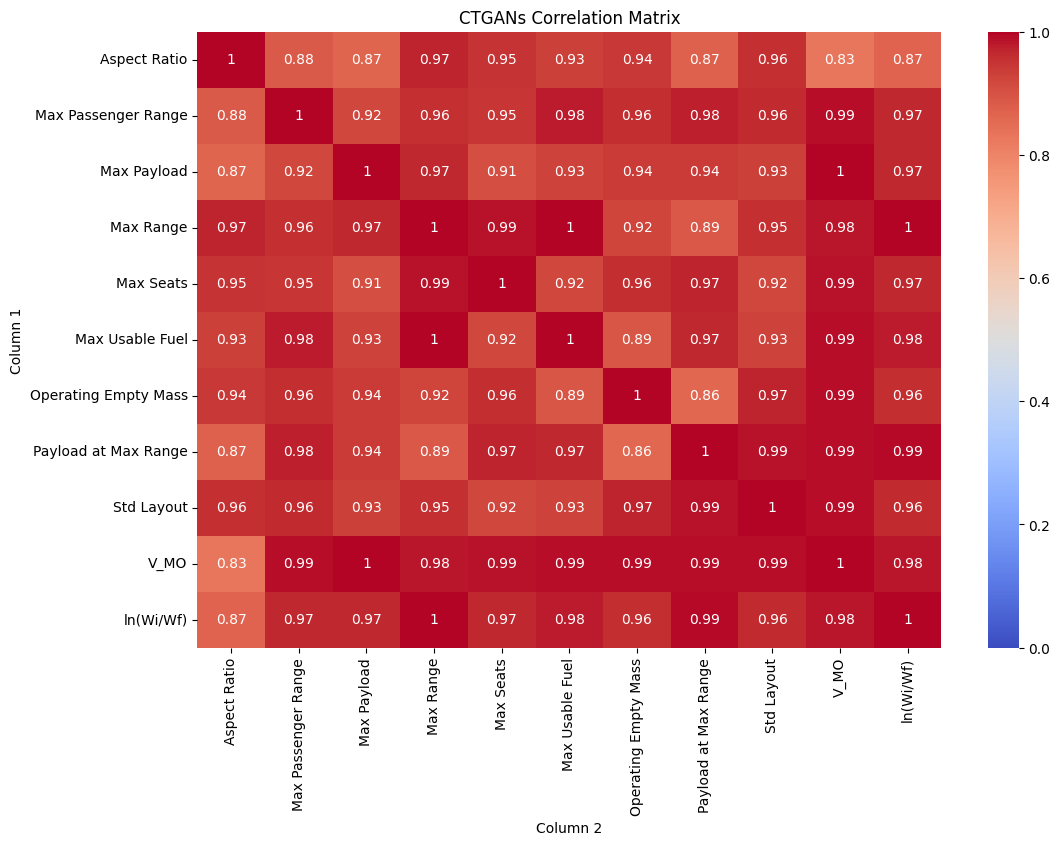

In [63]:
for (col1, col2), corr in list(correlation_dict.items()):
    if (col2, col1) not in correlation_dict:
        correlation_dict[(col2, col1)] = corr

# Add self-correlations (diagonal values)
columns = set([col for pair in correlation_dict.keys() for col in pair])
for col in columns:
    correlation_dict[(col, col)] = 1.0

# Create the DataFrame from the correlation dictionary
correlation_df = pd.DataFrame(
    list(correlation_dict.values()),
    index=pd.MultiIndex.from_tuples(correlation_dict.keys(), names=["Column 1", "Column 2"]),
    columns=['Correlation']
)

# Reset the index to get a normal DataFrame
correlation_df_reset = correlation_df.reset_index()

# Create a pivot table for the heatmap
correlation_pivot = correlation_df_reset.pivot(index="Column 1", columns="Column 2", values="Correlation")

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_pivot, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('CTGANs Correlation Matrix')
plt.show()

In [39]:
catgan_quality_report.get_visualization(property_name='Column Pair Trends')
 

In [28]:
"""
os.makedirs("images", exist_ok=True)


# Loop through each column in the DataFrame
for cols in range_eq_para.columns:
    # Generate the column plot
    fig = get_column_plot(
        real_data=range_eq_para,
        synthetic_data=synthetic_data,
        metadata=metadata,
        column_name=cols
    )
    
    file_path = os.path.join("images", f"ctgan_{cols}_eval.png")
    fig.write_image(file_path)  
    plt.close(fig)

print("All images saved in the 'images' directory.")

"""
    

'\nos.makedirs("images", exist_ok=True)\n\n\n# Loop through each column in the DataFrame\nfor cols in range_eq_para.columns:\n    # Generate the column plot\n    fig = get_column_plot(\n        real_data=range_eq_para,\n        synthetic_data=synthetic_data,\n        metadata=metadata,\n        column_name=cols\n    )\n    \n    file_path = os.path.join("images", f"ctgan_{cols}_eval.png")\n    fig.write_image(file_path)  \n    plt.close(fig)\n\nprint("All images saved in the \'images\' directory.")\n\n'

(53, 11) (53, 11)


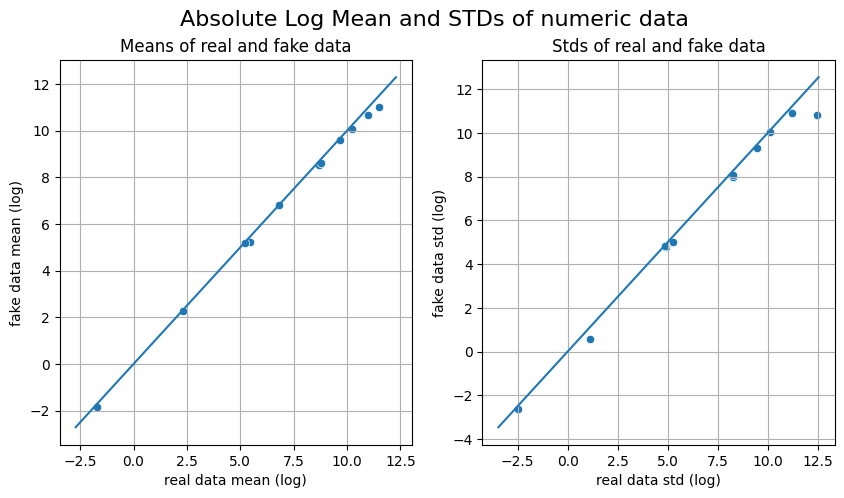

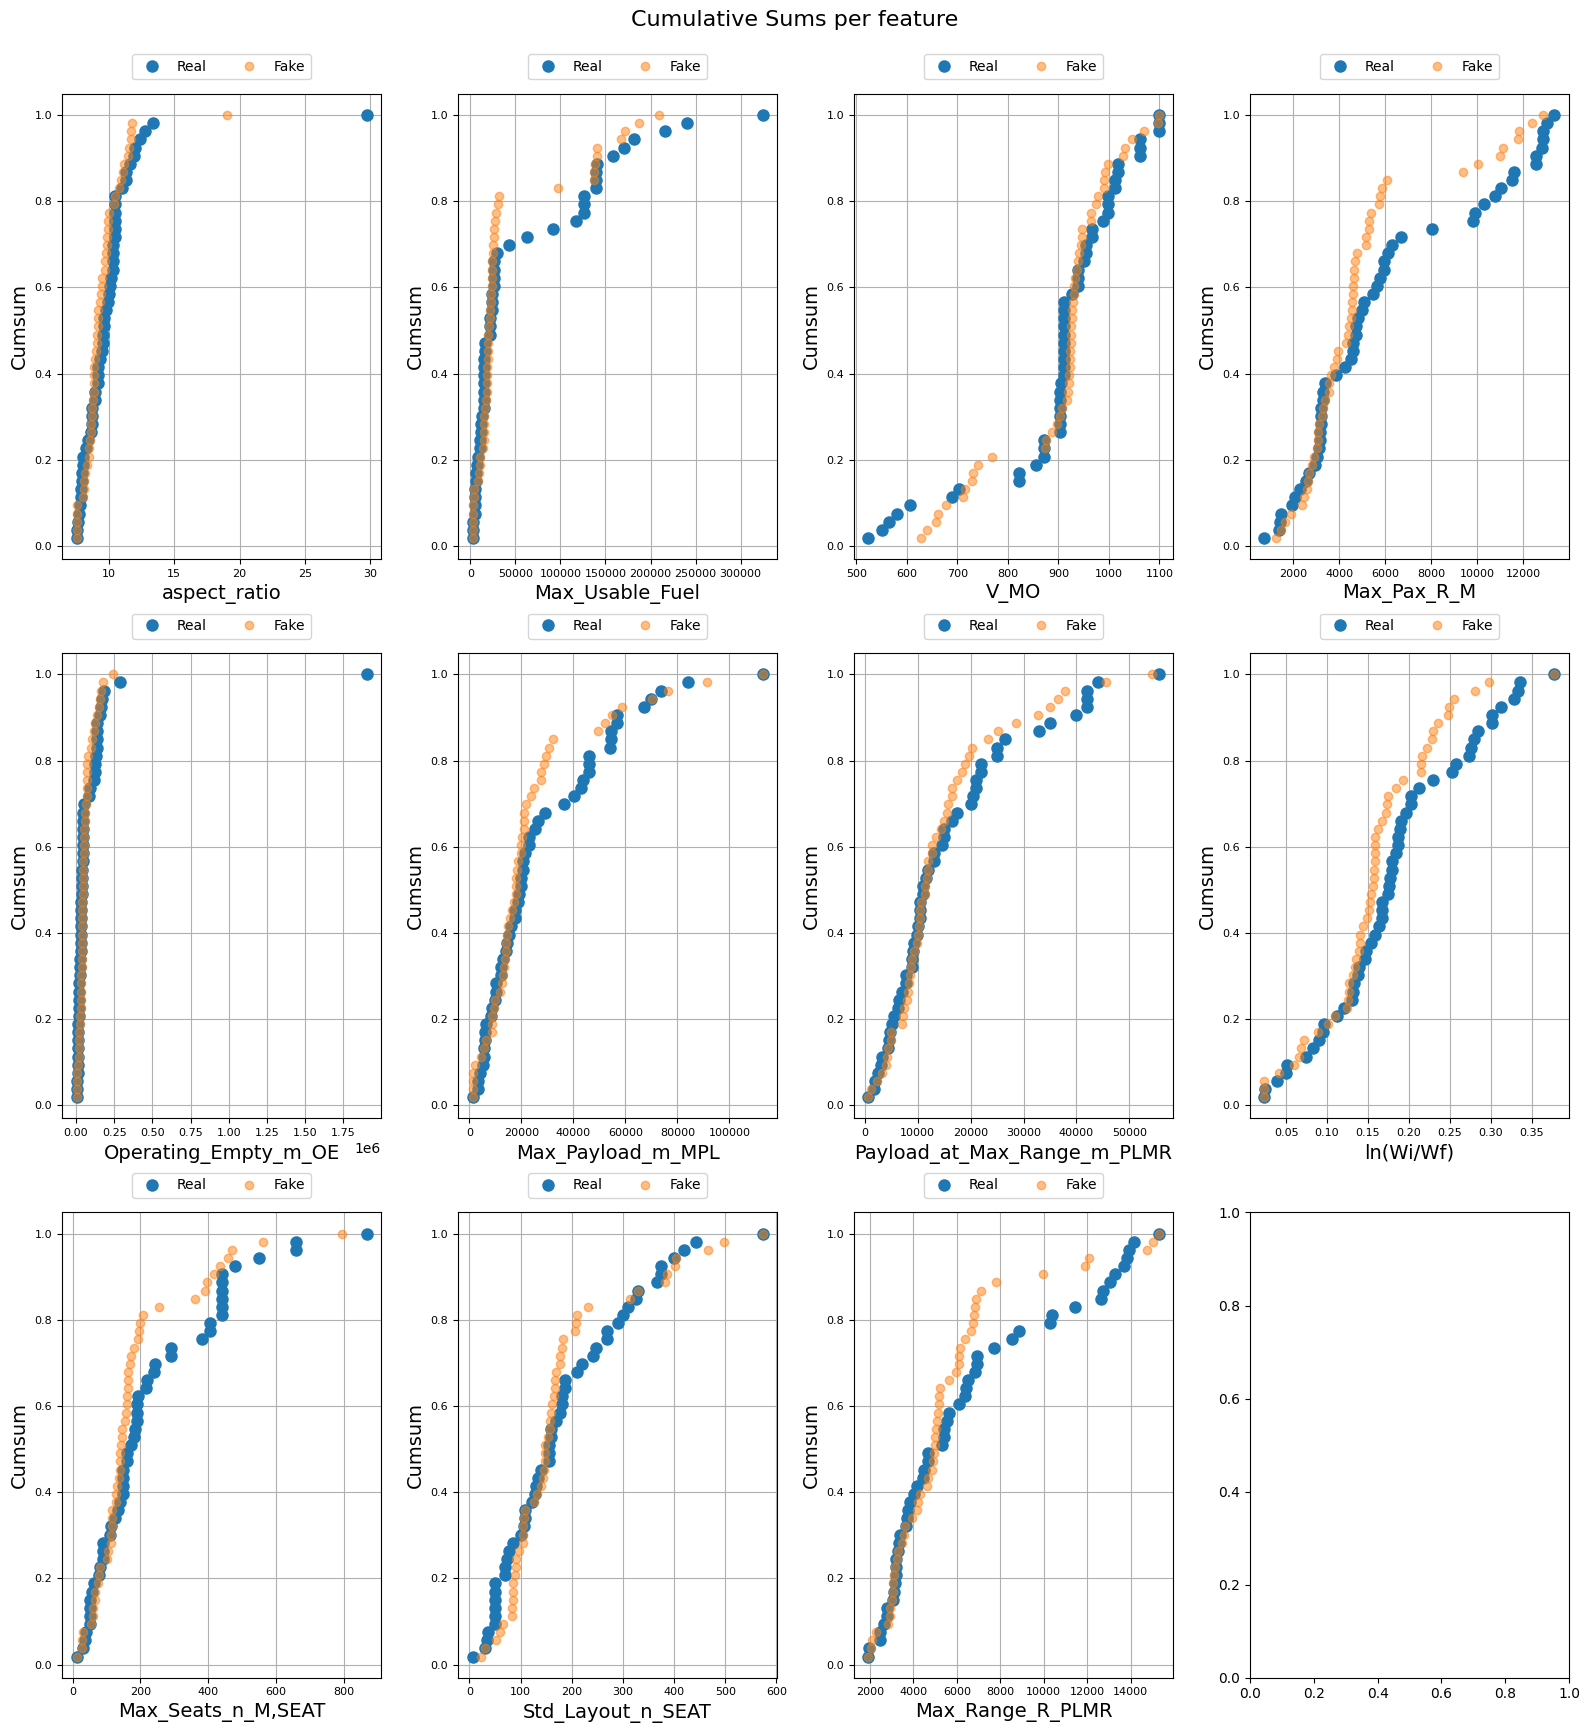

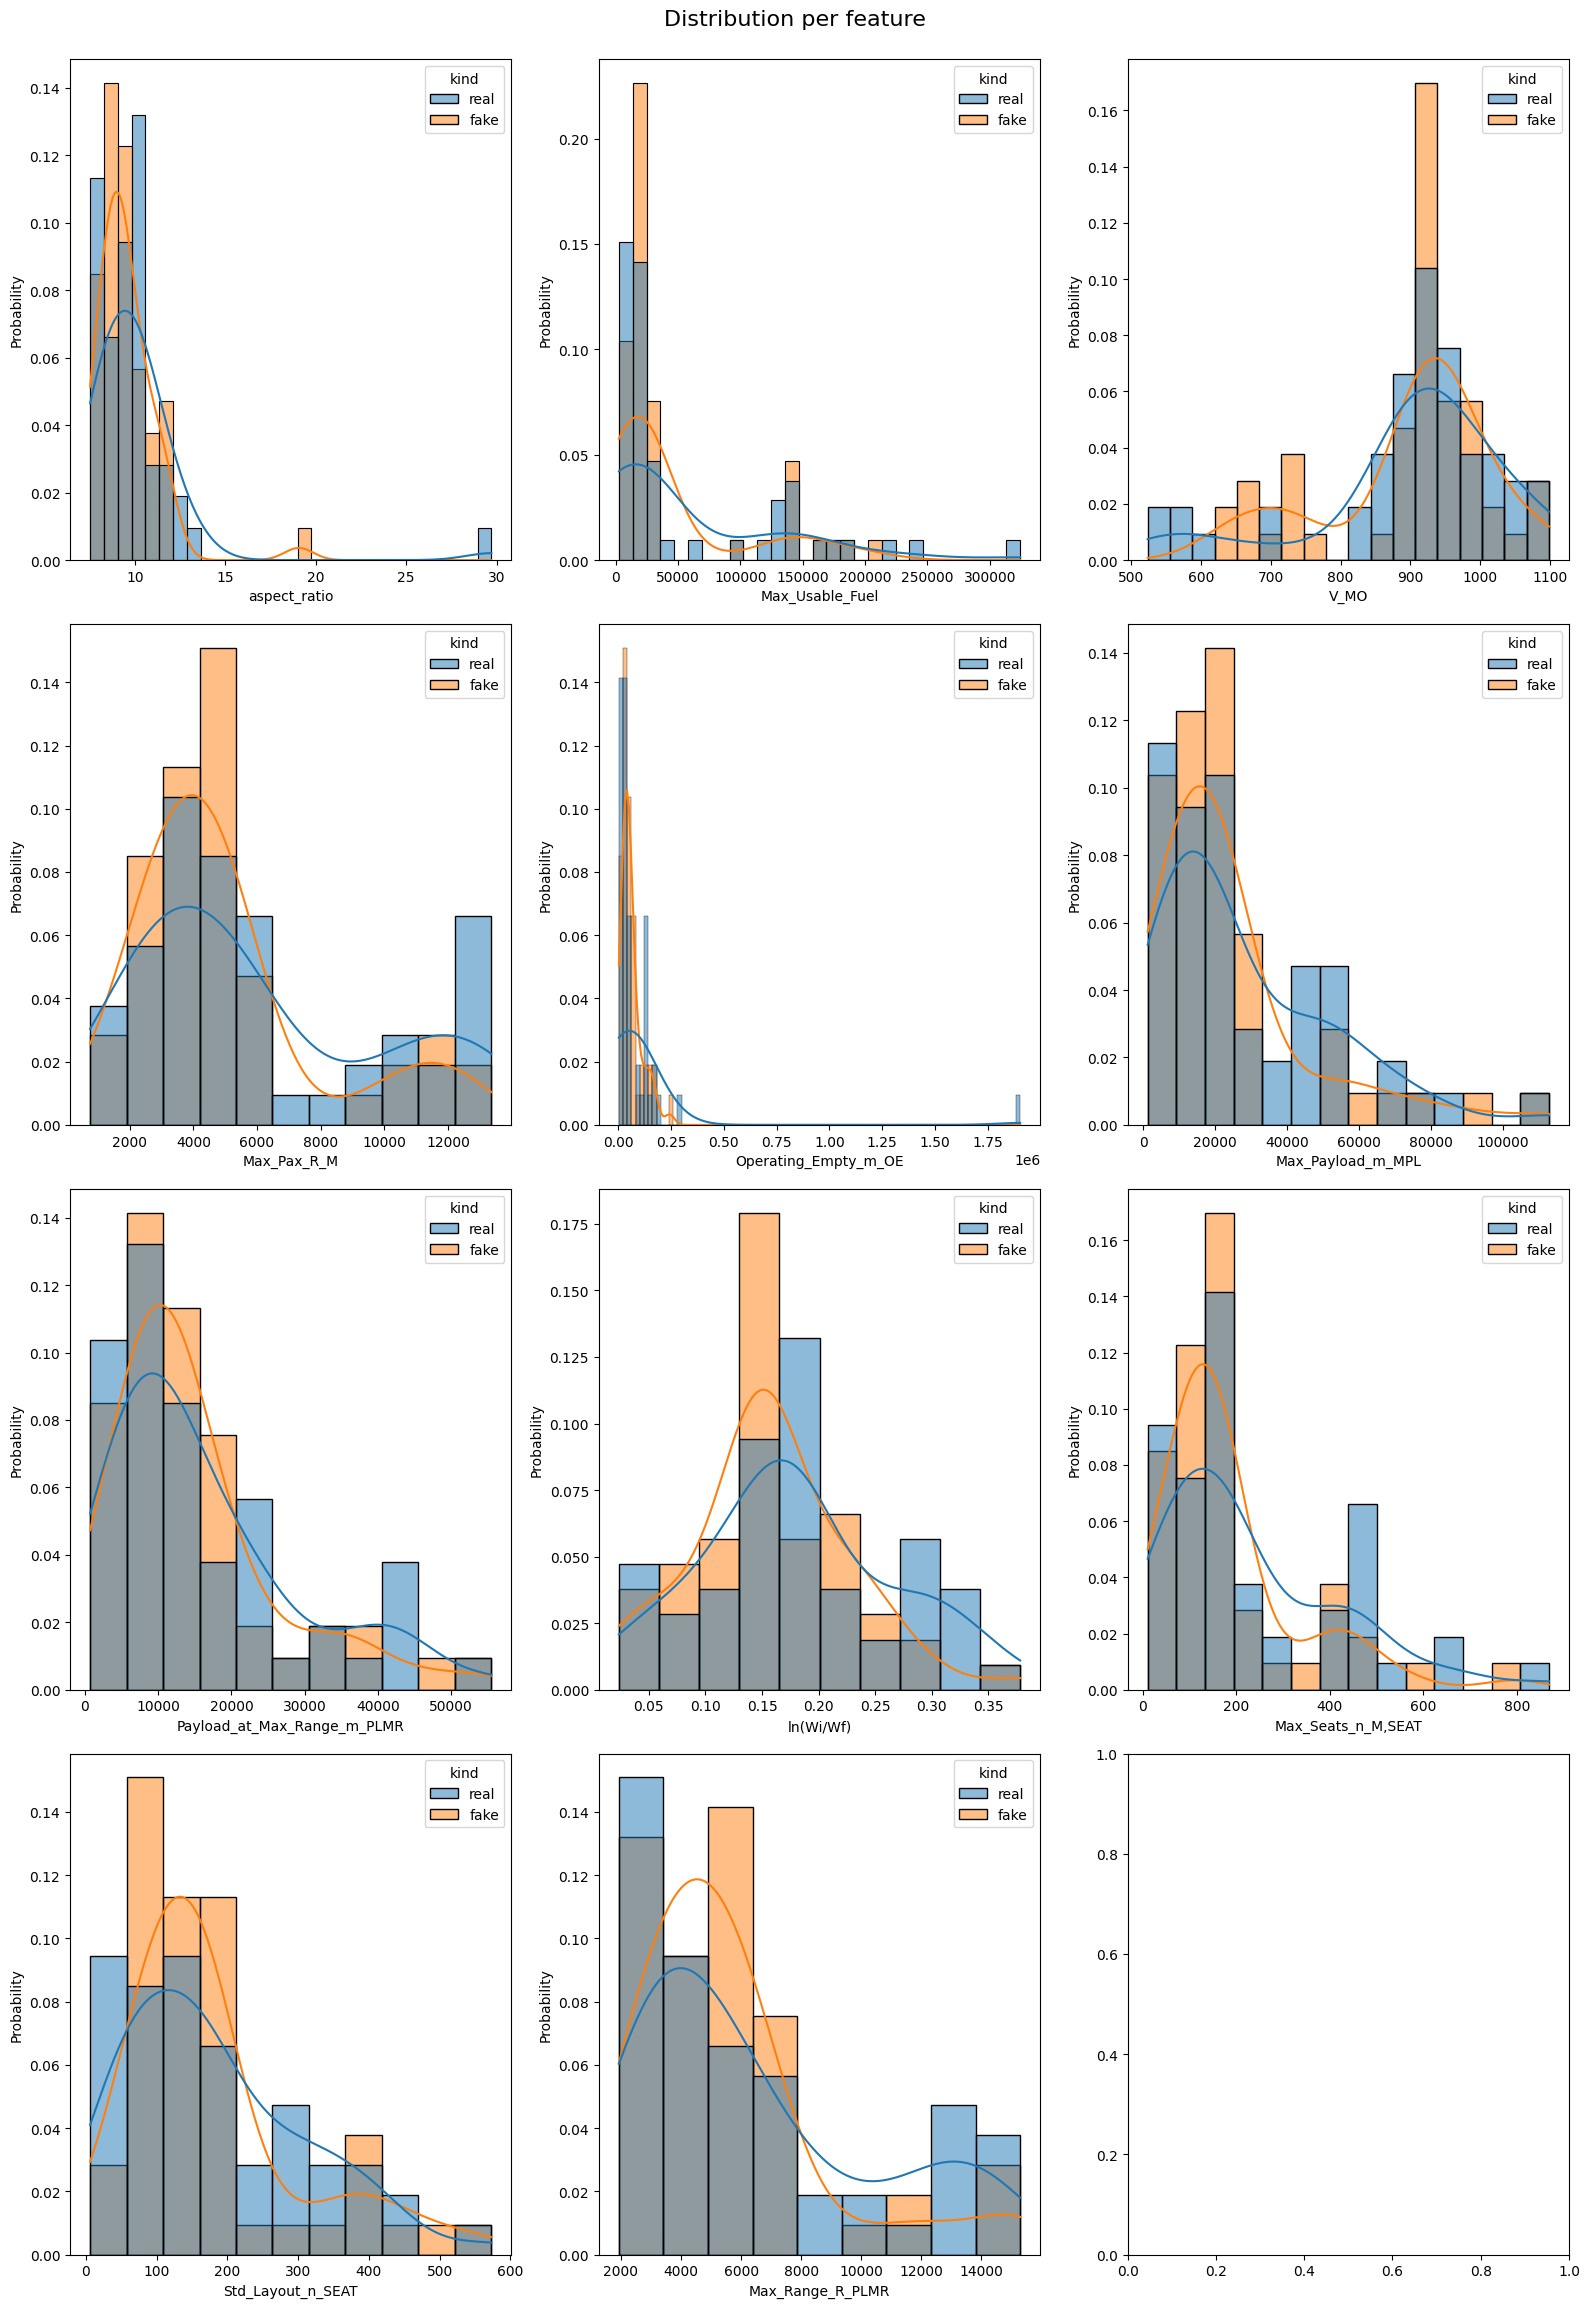

<Figure size 640x480 with 0 Axes>

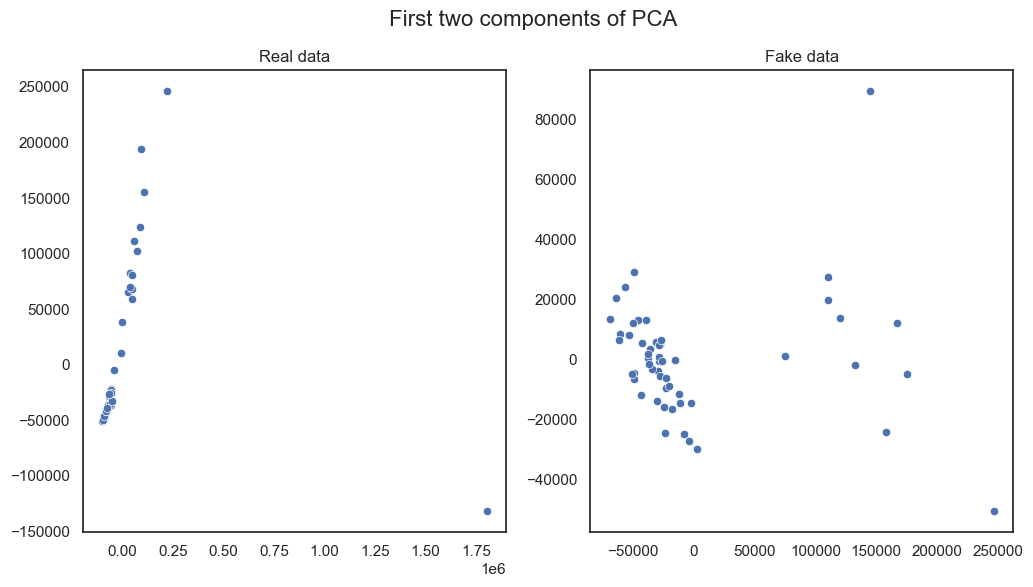

In [22]:
print(range_eq_para.shape, synthetic_data.shape)
table_evaluator = TableEvaluator(range_eq_para, synthetic_data)

table_evaluator.visual_evaluation()

#### <font style="color: #F4128A;"> <strong>Model Predictions</strong></font>

<p style="color: #F4128A;"> To evaluate the model’s performance, we provided specific values for certain parameters and tasked the model with predicting the remaining ones. </p>


In [11]:
print(range_eq_para['aspect_ratio'].describe())
print(range_eq_para['Max_Usable_Fuel'].describe())
print(range_eq_para['V_MO'].describe())
print(range_eq_para['Max_Seats_n_M,SEAT'].describe())
print(range_eq_para['Payload_at_Max_Range_m_PLMR'].describe())
print(range_eq_para['Max_Range_R_PLMR'].describe())


count    53.000000
mean     10.018272
std       3.106058
min       7.526701
25%       8.616647
50%       9.609283
75%      10.470915
max      29.706618
Name: aspect_ratio, dtype: float64
count        53.000000
mean      57953.207547
std       73703.264016
min        2468.000000
25%       11625.000000
50%       22126.000000
75%      117300.000000
max      324339.000000
Name: Max_Usable_Fuel, dtype: float64
count      53.000000
mean      902.587925
std       136.931042
min       524.116000
25%       903.776000
50%       911.184000
75%       988.968000
max      1098.236000
Name: V_MO, dtype: float64
count     53.000000
mean     231.000000
std      189.157037
min       11.000000
25%       90.000000
50%      172.000000
75%      381.000000
max      868.000000
Name: Max_Seats_n_M,SEAT, dtype: float64
count       53.000000
mean     15988.758038
std      12903.513453
min        700.000000
25%       7000.000000
50%      11000.000000
75%      21000.000000
max      55500.000000
Name: Payload_at_Ma

In [42]:
condition_values = Condition(
    num_rows=2,  
    column_values={'aspect_ratio': 9.6, 'V_MO': 930, 'Max_Range_R_PLMR': 5500}
)

synthetic_data_new = ctgan_synthesizer.sample_from_conditions(
    conditions=[condition_values], 
    max_tries_per_batch=500,
    batch_size=10
)

print(synthetic_data_new)


Sampling conditions: 100%|██████████| 2/2 [00:20<00:00, 10.03s/it]

   aspect_ratio  Max_Usable_Fuel   V_MO  Max_Pax_R_M  Operating_Empty_m_OE  \
0           9.6           142477  930.0  4274.554755                 76169   
1           9.6            26439  930.0  5634.059649                 68245   

   Max_Payload_m_MPL  Payload_at_Max_Range_m_PLMR  ln(Wi/Wf)  \
0            25312.0                    14177.999   0.170533   
1            28005.0                    13362.815   0.173921   

   Max_Seats_n_M,SEAT  Std_Layout_n_SEAT  Max_Range_R_PLMR  
0                 183                224            5500.0  
1                 171                182            5500.0  


<p style="color: #0BDE21;"> We have now created a new test dataset comprising various aircraft models with detailed parameters. However, the dataset does not include values for Max_Pax_R_M and Std_Layout_n_SEAT. In order to assess the predictive power of our model, we will remove certain parameters for each case and task the model with predicting the missing values. This process allows us to evaluate the model’s performance under different conditions by testing its ability to predict the remaining parameters based on the inputs provided. Once the predictions are generated, we will compare them with the actual known values to determine the accuracy and reliability of the model's output.</p>

In [12]:
aircraft_param = [
    {
        'Model': 'A310-300',
        'aspect_ratio': 8.79, 
        'Max_Usable_Fuel': 61070, 
        'V_MO': 667, 
        'Operating_Empty_m_OE': 81000, #MZFW - Estimated Payload (113,000 - 32000)
        'Max_Payload_m_MPL': 32000, #Wikipedia
        'Payload_at_Max_Range_m_PLMR': 15000, #Estimated 
        'ln(Wi/Wf)': 0.198,
        'Max_Seats_n_M,SEAT': 280,
        'Max_Range_R_PLMR': 9538
    },

    {
        'Model': 'A340-200',
        'aspect_ratio': 10.06, 
        'Max_Usable_Fuel': 138638,
        'V_MO': 611,
        'Operating_Empty_m_OE': 126000,
        'Max_Payload_m_MPL': 63000,
        'Payload_at_Max_Range_m_PLMR': 51000, 
        'ln(Wi/Wf)': 0.336,
        'Max_Seats_n_M,SEAT': 420, 
        'Max_Range_R_PLMR': 12404 #according to payload-range
    },


     {
        'Model': 'A340-600',
        'aspect_ratio': 9.17, 
        'Max_Usable_Fuel': 194300, 
        'V_MO': 611, 
        'Operating_Empty_m_OE': 216600, #Estimated using other values
        'Max_Payload_m_MPL': 34400, #Estimated using other values
        'Payload_at_Max_Range_m_PLMR': 36000,
        'ln(Wi/Wf)': 0.355,
        'Max_Seats_n_M,SEAT': 475,
        'Max_Range_R_PLMR': 14647 #Similar result in payload-range
    },

     {
        'Model': 'B737-200',
        'aspect_ratio': 8.8, 
        'Max_Usable_Fuel': 22600, 
        'V_MO': 648, 
        'Operating_Empty_m_OE': 27448,
        'Max_Payload_m_MPL': 24942, #Estiamted through calculations
        'Payload_at_Max_Range_m_PLMR': 13600,
        'ln(Wi/Wf)': 0.179,
        'Max_Seats_n_M,SEAT': 136,
        'Max_Range_R_PLMR': 2222 
    },

    {
        'Model': 'B707-100',
        'aspect_ratio': 8.04, #Changed from 7.04 -> 8.04 just for testing the GAN model
        'Max_Usable_Fuel': 51050, 
        'V_MO': 646,  
        'Operating_Empty_m_OE': 55589,
        'Max_Payload_m_MPL': 60986,
        'Payload_at_Max_Range_m_PLMR': 20000,  # Needs estimation
        'ln(Wi/Wf)': 0.297,
        'Max_Seats_n_M,SEAT': 179,
        'Max_Range_R_PLMR': 6537
}
    
]
aircraft_pred_param = pd.DataFrame(aircraft_param)

In [13]:
aircraft_pred_param_names = aircraft_pred_param['Model']
aircraft_pred_param = aircraft_pred_param.drop(columns=['Model'])
aircraft_pred_param

aspect_ratio  Max_Usable_Fuel  V_MO  Operating_Empty_m_OE  \
0          8.79            61070   667                 81000   
1         10.06           138638   611                126000   
2          9.17           194300   611                216600   
3          8.80            22600   648                 27448   
4          8.04            51050   646                 55589   

   Max_Payload_m_MPL  Payload_at_Max_Range_m_PLMR  ln(Wi/Wf)  \
0              32000                        15000      0.198   
1              63000                        51000      0.336   
2              34400                        36000      0.355   
3              24942                        13600      0.179   
4              60986                        20000      0.297   

   Max_Seats_n_M,SEAT  Max_Range_R_PLMR  
0                 280              9538  
1                 420             12404  
2                 475             14647  
3                 136              2222  
4                 179              6537

In [91]:
class GANModelEvaluation: 
    def __init__(self, prediction_data, parameters, model):
        """
        Initialize the GAN model trained for prediction based on certain parmaeters

        Args:
            prediction_data (DataFrame): The dataset required for model prediction
            parameters (list): The list of parameters provided for prediction (Conditional Sampling)
            model (CTGANSynthesizer): The trained GAN model
        """
        self.prediction_data = prediction_data
        self.parameters = parameters
        self.model = model

    def parameter_for_prediction(self, total_rows):
        """
        Extracts the input values from specified rows for future predictions.

        This method selects a subset of rows from the dataset and collects the specified 
        parameters for each of those rows. These values will be used as conditions for generating 
        synthetic data in later predictions. 

        Args:
            total_rows (list): A list of row indices representing the rows from which parameter 
                            values are extracted for prediction.
        
        Returns:
            prediction_input_values (dict): A dictionary where each key corresponds to a row, 
                                            and its value is a dictionary of parameter values from 
                                            the selected rows, which will be used for prediction.
        """
        prediction_input_values = {}

        for row in total_rows:
            row_values = {}
            for index, rows in self.prediction_data[self.parameters].iterrows():
                if index == row:
                    for param in self.parameters:
                        row_values[param] = rows[param]
            prediction_input_values[f'Row_{row}'] = row_values

        return prediction_input_values
    
    def predict_values(self, prediction_input_values, rows_to_produce=2, max_tries_per_batch=500, batch_size=10):
        """
        Generates synthetic data based on the input values using the GAN model.

        This method takes the input values (parameters) from selected rows and uses them as 
        conditions to generate synthetic data using the trained GAN model. The generated predictions 
        for each row are stored in a dictionary, where each key corresponds to a specific row.

        Args:
            prediction_input_values (dict): A dictionary containing input values for each row, 
                                            where the key is the row and the value is a dictionary 
                                            of parameters.
            rows_to_produce (int): The number of synthetic rows to generate for each input condition 
                                (default: 2).
            max_tries_per_batch (int): The maximum number of attempts to generate valid synthetic 
                                    rows for each batch (default: 500).
            batch_size (int): The number of rows to generate per batch (default: 10).
        
        Returns:
            prediction_output (dict): A dictionary where each key corresponds to a row, and its 
                                    value is the generated synthetic data based on the input conditions 
        """

        prediction_output = {}

        for key, value in prediction_input_values.items():
            # Condition values for the given parameters
            condition_values = Condition(
                num_rows=rows_to_produce,
                column_values=value
            )

            # Generate synthetic data based on the condition
            synthetic_data_new = self.model.sample_from_conditions(
                conditions=[condition_values],
                max_tries_per_batch=max_tries_per_batch,
                batch_size=batch_size
            )

            # Store the prediction output for the current row
            prediction_output[key] = synthetic_data_new
        
        return prediction_output

    def prediction_analysis(self, prediction_output, total_rows):
        """
        Analyze the synthetic data generated with real data for comparison.

        Args:
            prediction_output (dict): A dictionary containing the generated synthetic data for each row.
            total_rows (list): A list of row indices representing the rows for which synthetic data was generated.
        
        Returns:
            None
        """
        predition_output_df = pd.DataFrame.from_dict(prediction_output, orient='index')

        print(predition_output_df)

        print(f"Orginal Dataframe: {self.prediction_data}")
        


In [14]:
aircraft_pred_param

aspect_ratio  Max_Usable_Fuel  V_MO  Operating_Empty_m_OE  \
0          8.79            61070   667                 81000   
1         10.06           138638   611                126000   
2          9.17           194300   611                216600   
3          8.80            22600   648                 27448   
4          8.04            51050   646                 55589   

   Max_Payload_m_MPL  Payload_at_Max_Range_m_PLMR  ln(Wi/Wf)  \
0              32000                        15000      0.198   
1              63000                        51000      0.336   
2              34400                        36000      0.355   
3              24942                        13600      0.179   
4              60986                        20000      0.297   

   Max_Seats_n_M,SEAT  Max_Range_R_PLMR  
0                 280              9538  
1                 420             12404  
2                 475             14647  
3                 136              2222  
4                 179              6537

In [31]:
parameters_test = ['Max_Range_R_PLMR']
total_rows = [4]

gan_eval = GANModelEvaluation(prediction_data=aircraft_pred_param, parameters=parameters_test, model=ctgan_synthesizer)

input_values = gan_eval.parameter_for_prediction(total_rows)
input_values

{'Row_4': {'Max_Range_R_PLMR': 6537}}

In [30]:
gan_pred_output = gan_eval.predict_values(prediction_input_values=input_values, rows_to_produce=2, max_tries_per_batch=1000, batch_size=10)
gan_pred_output

Sampling conditions:   0%|          | 0/2 [00:00<?, ?it/s]

## <font color=#F4AC12>**Aerodynamics Prediction**</font>

## <font color=#F4AC12>**Simulation Dataset**</font>

## <font color=#F4AC12>**New Aircrafts in Development**</font>

<p style="color: #0BDE21;"> Search regarding new aircrafts on internet that are under development and check if you can find their parameter and make predictions using all the models you've trained</p>
